# Вариационные автокодировщики

### Загрузка, нормировка и визуалиация данных

In [23]:
import torchvision.datasets

In [24]:
from torchvision.datasets import MNIST#, FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import math
#dtype = torch.cuda.DoubleTensor
#import chainer
BATCH_SIZE = 100
CONDITIONAL_SHAPE = 5
LATENT_DIMENSION = 16

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="1,2,3"

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x, data_x):
    plt.figure(figsize=(28, 28 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 4, 4)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.cpu().data[i].numpy())
        plt.title("%1.3f %1.3f %1.3f" %(data_x.cpu().data[i].numpy()[0], data_x.cpu().data[i].numpy()[1], data_x.cpu().data[i].numpy()[2]))
        plt.axis('off')
    plt.show()

In [27]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
#data = pkl.load(open('test_data','rb'))
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

In [28]:
import numpy as np
data = np.load('/home/sayankotor/data/EgorWGAN/real_data.npz')
data_img = (data['EnergyDeposit'])
data_img.shape

(29600, 30, 30)

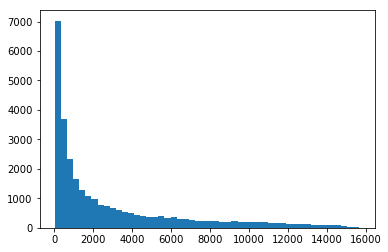

In [29]:
plt.hist(np.sum(data_img, axis = (1,2)), bins = 50)
plt.show()

In [30]:
keys = data.keys()
keys

KeysView(<numpy.lib.npyio.NpzFile object at 0x7ff5a0335630>)

In [31]:
data_point = data['ParticlePoint']
data_momentum = data['ParticleMomentum']
print (data_point.shape)
print (data_momentum.shape)

(29600, 2)
(29600, 3)


In [32]:
data_x = np.concatenate([data_point[:, :2], data_momentum], axis = 1)

In [33]:
np.mean(data_x)

4.177608331523082

In [34]:
#data_img = np.clip(data_img, 1e-8, 8)
#data_img_log = np.log(data_img)
min_ = np.min(data_img)
max_ = np.max(data_img)
print(min_, max_)

0.0 3371.953567922453


In [35]:
n_data_img = []
reconstr_data_img = []

min_ = np.min(data_img)
max_ = np.max(data_img)
min_30 = np.min(data_img, axis = 0)
max_30 = np.max(data_img, axis = 0)

for i, elem in enumerate(data_img):
    n_elem = (elem-min_30)/(max_30 - min_30)
    rec_elem = n_elem*(max_30 - min_30)
    n_data_img.append(n_elem)
    reconstr_data_img.append(rec_elem)
    if (i%5000 == 0):
        print (i)
n_data_img = np.array(n_data_img)
reconstr_data_img = np.array(reconstr_data_img)


0
5000
10000
15000
20000
25000


In [36]:
print (data_img.shape)

(29600, 30, 30)


**Cut it for 4*4**

In [37]:
def cut(data_):
    new_data = []
    for elem in data_:
        new_data.append(elem[13:17, 13:17])
    new_data = np.array(new_data)
    return new_data

In [38]:
cut_data = cut(data_img)
n_cut_data = cut(n_data_img)

In [39]:
cut_data.shape

(29600, 4, 4)

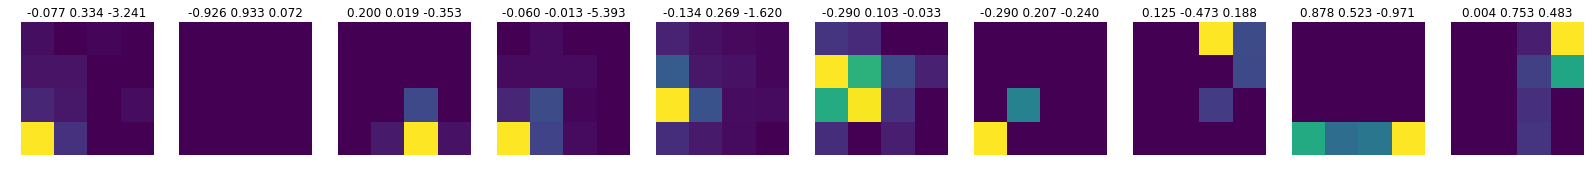

In [40]:
show_images(Variable(torch.from_numpy(cut_data[20:30])), Variable(torch.from_numpy(data_x[20:30])))

In [41]:
np.max(n_cut_data)

1.0

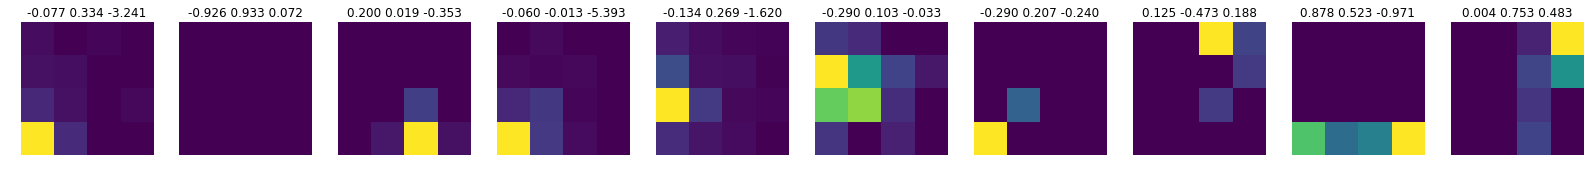

In [42]:
show_images(Variable(torch.from_numpy(n_cut_data[20:30])), Variable(torch.from_numpy(data_x[20:30])))

## loss function ##

In [61]:
n_cut_data.shape

(29600, 4, 4)

In [43]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [44]:
def reconstruction_loss_gauss(x_true_object, mu_generative_distr, log_sigma_var, reduce = 'sum'):
    x_prec = torch.exp(-log_sigma_var)
    x_diff = x_true_object - mu_generative_distr
    x_power = (x_diff * x_diff) * x_prec * -0.5
    loss = (log_sigma_var + math.log(2 * math.pi)) / 2 - x_power
    if reduce == 'sum':
        return torch.mean(loss)
    return loss


In [168]:
def reconstruction_loss(x_true_object, x_generative_object):
    return RMSELoss(x_true_object, x_generative_object)

def sum_loss(x_true_object, x_generative_object):
    x_true_object = x_true_object.view(-1, 16)
    x_generative_object = x_generative_object.view(-1, 16)
    sum_tru = torch.sum(x_true_object, dim =1)
    sum_gen = torch.sum(x_generative_object, dim =1)
    return torch.abs((torch.sum(sum_tru - sum_gen)))

def resolution_loss(reals, fakes, momentum_real, momentum_fake):
    etot_reals = torch.sum(reals, dim =1)
    etot_fakes = torch.sum(fakes, dim =1)
    momentum_real = momentum_real[:,:3]
    momentum_fake = momentum_fake[:,:3]
    etrack_reals = torch.sqrt(torch.sum(torch.mul(momentum_real, momentum_real), dim = 1))
    etrack_fakes = torch.sqrt(torch.sum(torch.mul(momentum_fake, momentum_fake), dim = 1))
    return (torch.sum(etot_reals/etrack_reals - etot_fakes/etrack_fakes))
    

In [169]:
def kl1(mean, ln_var, reduce='sum'):
    var = torch.exp(ln_var)
    mean_square = mean * mean
    loss = (mean_square + var - ln_var - 1) * 0.5
    if reduce == 'sum':
        return torch.sum(loss)
    else:
        return loss

In [170]:
def kl(mean1, ln_var1, mean2, ln_var2, reduce='sum'):
    var1 = torch.exp(ln_var1)
    var2 = torch.exp(ln_var2)
    mean_square = (mean1 - mean2) * (mean1 - mean2)
    loss = ((mean_square + var1)/var2 - 2*ln_var1 + 2*ln_var2 - 1) * 0.5
    if reduce == 'sum':
        return torch.mean(loss)
    else:
        return loss

In [171]:
torch.cuda.DoubleTensor(data_x[:,:3]).shape

torch.Size([29600, 3])

## model

In [172]:
INPUT_IMAGE_SIZE = 16
INPUT_CONDITIONAL_SIZE = 4
HIDDEN_SIZE = 1

In [173]:
from torch.distributions import Normal, Bernoulli
from chainer.functions.math import exponential

class CVAE(nn.Module):
    def __init__(self, d, D_x, D_y, alpha):
        """Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D_x, int - размерность пространства x.
        Вход: D_y, int - размерность пространства y.
        Вход: alpha, float - число от 0 до 1, коэффициент смеси моделей СVAE и GSNN.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D_x = D_x
        self.D_y = D_y
        self.log_s = nn.Parameter(torch.zeros(1))
        self.i = 0
        self.proposal_network = nn.Sequential(
            nn.Linear(self.D_y + self.D_x, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 25),
            nn.LeakyReLU(),
            nn.Linear(25, self.d),
            nn.Sigmoid()
        )
        self.proposal_mu_head = nn.Linear(self.d, self.d)
        self.proposal_sigma_head = nn.Sequential(nn.Linear(self.d, self.d), nn.Softplus())
        #self.prior_network = nn.Sequential(
            #nn.Linear(self.D_x, 200),
            #nn.LeakyReLU(),
            #nn.Linear(200, 200),
            #nn.LeakyReLU(),
        #)
        self.prior_mu_head = nn.Linear(25, self.d)
        self.prior_sigma_head = nn.Sequential(nn.Linear(25, self.d), nn.Softplus())
    
        self.generative_network = nn.Sequential(
            nn.Linear(self.d + self.D_x, 25),
            nn.LeakyReLU(),
            nn.Linear(25, 50),
            nn.LeakyReLU(),
            nn.Linear(50, self.D_y),
            nn.Sigmoid()
        )

        
        self.generative_mu_head = nn.Sequential(nn.Linear(self.D_y, self.D_y))
        self.generative_sigma_head = nn.Sequential(nn.Linear(self.D_y, self.D_y), nn.Softplus())
        
    def proposal_forward(self, pictures, conditions):
        pictures = pictures.view(pictures.shape[0], 16)
        conditions = conditions.view(conditions.shape[0], self.D_x)
        network_input = torch.cat([pictures, conditions], dim=1)
        answ = self.proposal_network(network_input)
        answ = answ.view(answ.shape[0], self.d)
        return answ

    def generative_forward(self, z, x_batch):
        z = z.view(z.shape[0], self.d)
        x_batch = x_batch.view(x_batch.shape[0], self.D_x)
        network_input = torch.cat([z, x_batch], dim=1)
        answ = self.generative_network(network_input)
        answ = answ.view(answ.shape[0], self.D_y)
        return answ
    
    def proposal_distr(self, x, y):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        #a = torch.cat([x, y], dim=1)
        #a = a.type(torch.cuda.DoubleTensor)
        #a_cuda = Variable(a, requires_grad=True).cuda()
        q_teta = self.proposal_forward(y, x)
        return self.proposal_mu_head(q_teta), torch.clamp(self.proposal_sigma_head(q_teta), min = 1e-8)

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: x, Variable - матрица размера n x D_x.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = Variable(torch.Tensor(n, self.d).fill_(0))
        sigma = Variable(torch.Tensor(n, self.d).fill_(1))
        return mu, sigma


    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
    
        mu, sigma = distr
        eps = torch.from_numpy(
            np.random.normal(0, 1, size=(K * sigma.shape[0], sigma.shape[1]))
        )
        eps = eps.cuda().to(device)
        return mu.repeat(K, 1) + sigma.repeat(K, 1) * Variable(eps, requires_grad=False)
        

    def sample_prior(self, x_batch):
        mu, sigma = self.prior_distr(x_batch.shape[0])
        m = Normal(mu, sigma)
        answ = m.sample()  
        return answ.cuda().to(device), x_batch
    
    def sample_prior1(self, x_batch):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        m = Normal(self.latent_mu, self.latent_sigma)
        answ = m.sample()  
        return answ.cuda().to(device), x_batch
        

    def generative_distr(self, z):
        #return self.generative_network.forward(z)
        int_distr = self.generative_network(z)
        return (self.generative_mu_head(int_distr), torch.clamp(self.generative_sigma_head(int_distr), min = 1e-8))


    def batch_loss(self, batch, x_batch, K, alpha_, is_show):
        batch = Variable(batch)
        x_batch = Variable(x_batch)        
        
        q_phi = self.proposal_distr(x_batch, batch)
        z = self.sample_latent(q_phi, K)
        
        self.latent_mu = torch.mean(q_phi[0], 0)
        self.latent_sigma = torch.mean(q_phi[1], 0)
        
        res = self.generative_forward(z, x_batch)
        answ1 = reconstruction_loss(batch, res)
        
        sum_l = sum_loss(batch, res)

        resolution_l = resolution_loss(batch, res, x_batch, x_batch)

        mu_prior, sigma_prior = self.prior_distr(batch.shape[0])
        
        answ2 = kl1(q_phi[0],torch.log(q_phi[1]))
        
        if (is_show):        
            a_gen1 = self.generate_samples1(
                Variable(torch.cuda.DoubleTensor(n_cut_data[20:30]).to(device)),
                Variable(torch.cuda.DoubleTensor(data_x[20:30]).to(device))
            )
            print ("a_gen shape", a_gen1.shape)
            print ("alpha ", alpha_)
            print ("batch_loss:loss_simple, KL, sum, res ", answ1.data.mean() , answ2, sum_l, resolution_l)
            show_images(a_gen1,  Variable(torch.cuda.DoubleTensor(data_x[20:30]).to(device)))
            show_images(Variable(torch.from_numpy(n_cut_data[20:30])), Variable(torch.from_numpy(data_x[20:30])))
        return answ1, answ2, sum_l, resolution_l


    def generate_samples(self, x):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        z, x_b = self.sample_prior(x)
        answ = self.generative_forward(z, x_b)
        return answ
    
    def generate_samples1(self, batch, x_batch):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        batch = batch
        x_batch = x_batch        
        
        q_phi = self.proposal_distr(x_batch, batch)
        z = self.sample_latent(q_phi, 1)
        answ = self.generative_forward(z, x_batch)
        return answ
    

def sample_data_batch(bsize, data_, x_data_):
    idxs = np.random.choice(np.arange(data_.shape[0]), size=bsize)
    return torch.cuda.DoubleTensor(data_[idxs]).to(device), torch.cuda.DoubleTensor(x_data_[idxs]).to(device)

In [174]:
import random
import pickle

shapes = data_img.shape
random.seed()
ep = 0
def train_model(model, tests=[], batch_size=30, K=1, num_epochs=250, learning_rate=1e-3):
    model.double()
    model.to(device)
    
    gd = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses1 = []
    train_losses2 = []
    train_loss_sum = []
    train_loss_res = []
    test_results = []
    for epoch in range(num_epochs):
        if (epoch > 50):
            learning_rate=1e-4
        ep = epoch
        alpha = 1e-3 * 2 ** (epoch // 2)
        if (alpha > 10.0):
            alpha = 1.0
        for i, (batch, _) in enumerate(dataloader):
            total = 500
            batch, batch_x = sample_data_batch(30, n_cut_data.reshape(-1, 16), data_x)
            
            loss1, loss2, loss_s, loss_r = model.batch_loss(batch, batch_x, K, alpha, False)
            (loss2 + loss1+ 0.01*loss_s + 0.01*loss_r).backward()
            #print (loss.shape)
            
            train_losses1.append(loss1.data.cpu().numpy())
            train_losses2.append(loss2.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        
        print ("epoch:", epoch)
        loss1, loss2, loss_s, loss_r = model.batch_loss(batch, batch_x, K, alpha, True)
        print('\rTrain loss:', train_losses1[-1] + train_losses2[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
        with open("/home/sayankotor/data/VAEResG/DUMP/model_try.txt","wb") as file:
            pickle.dump(model,file)
    return {
        'model': model,
        'train_losses_list1': train_losses1,
        'train_losses_list2': train_losses2,
        'train_loss_sum':train_loss_sum,
        'train_loss_res':train_loss_res,
        'test_results': test_results
    }

epoch: 0
a_gen shape torch.Size([10, 16])
alpha  0.001
batch_loss:loss_simple, KL, sum, res  tensor(0.2974) tensor(0.0061, grad_fn=<SumBackward0>) tensor(51.6230, grad_fn=<AbsBackward>) tensor(-79.1536, grad_fn=<SumBackward0>)


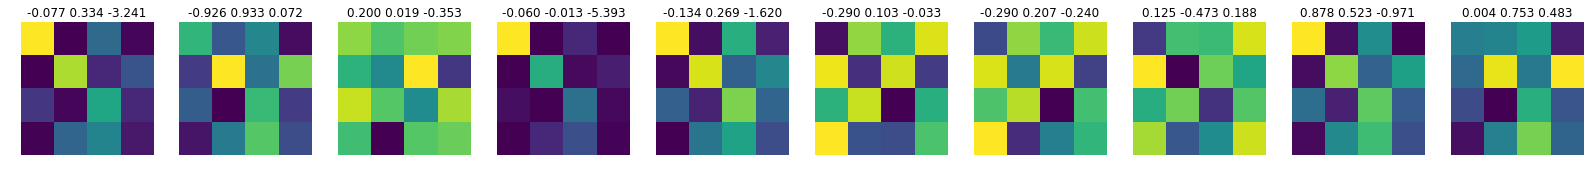

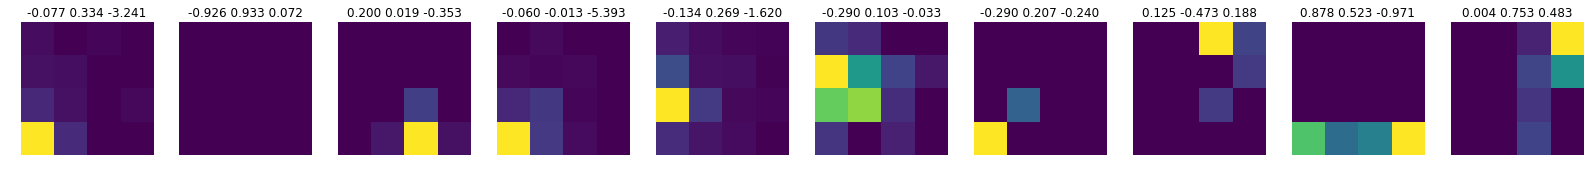

Train loss: 0.3012615601976304 Batch 2000 of 500           epoch: 1
a_gen shape torch.Size([10, 16])
alpha  0.001
batch_loss:loss_simple, KL, sum, res  tensor(0.3714) tensor(6.4173e-07, grad_fn=<SumBackward0>) tensor(72.0149, grad_fn=<AbsBackward>) tensor(-232.4736, grad_fn=<SumBackward0>)


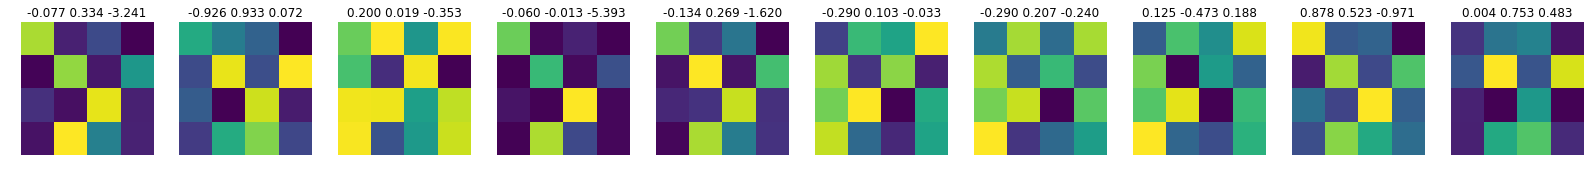

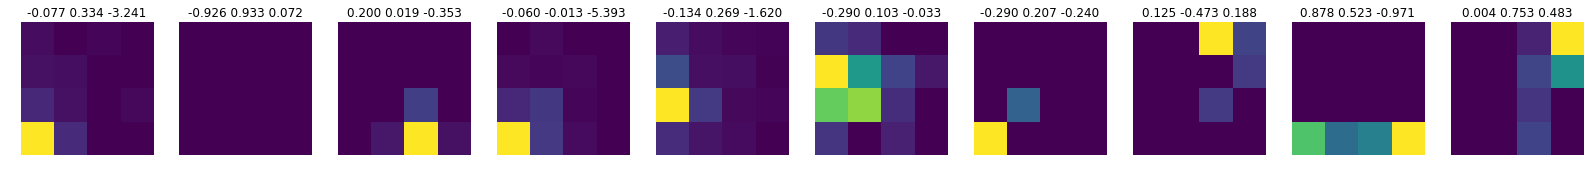

Train loss: 0.3704192263414545 Batch 2000 of 500           epoch: 2
a_gen shape torch.Size([10, 16])
alpha  0.002
batch_loss:loss_simple, KL, sum, res  tensor(0.2449) tensor(3.6395e-07, grad_fn=<SumBackward0>) tensor(34.2922, grad_fn=<AbsBackward>) tensor(-91.6101, grad_fn=<SumBackward0>)


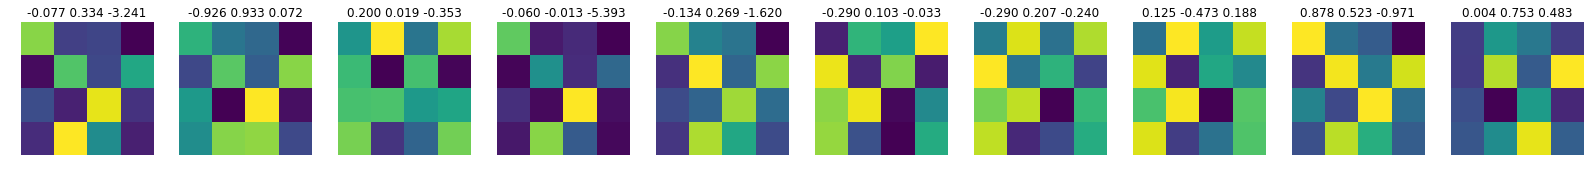

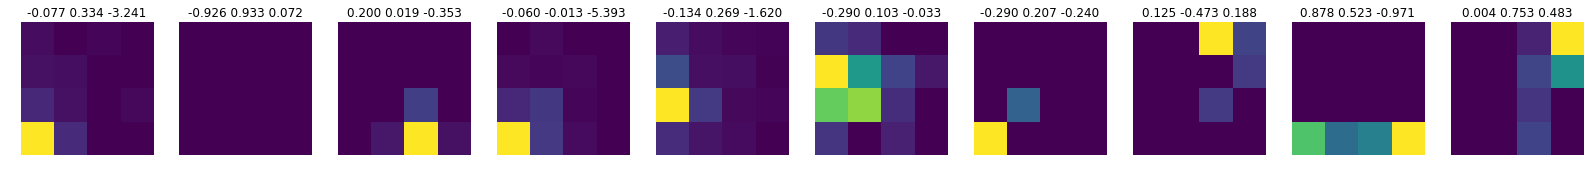

Train loss: 0.24322714819940341 Batch 2000 of 500           epoch: 3
a_gen shape torch.Size([10, 16])
alpha  0.002
batch_loss:loss_simple, KL, sum, res  tensor(0.3496) tensor(5.2139e-07, grad_fn=<SumBackward0>) tensor(65.1939, grad_fn=<AbsBackward>) tensor(-113.2730, grad_fn=<SumBackward0>)


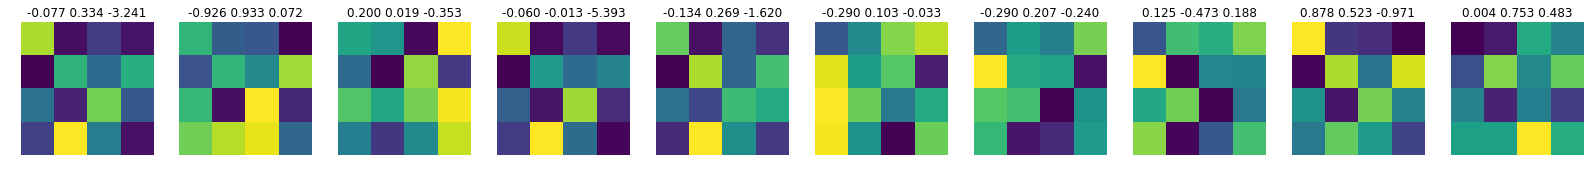

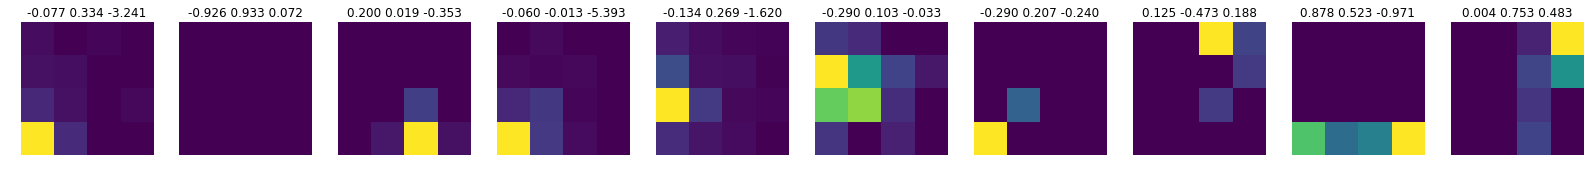

Train loss: 0.3587027313118596 Batch 2000 of 500           epoch: 4
a_gen shape torch.Size([10, 16])
alpha  0.004
batch_loss:loss_simple, KL, sum, res  tensor(0.2000) tensor(2.3894e-07, grad_fn=<SumBackward0>) tensor(21.8911, grad_fn=<AbsBackward>) tensor(-33.8467, grad_fn=<SumBackward0>)


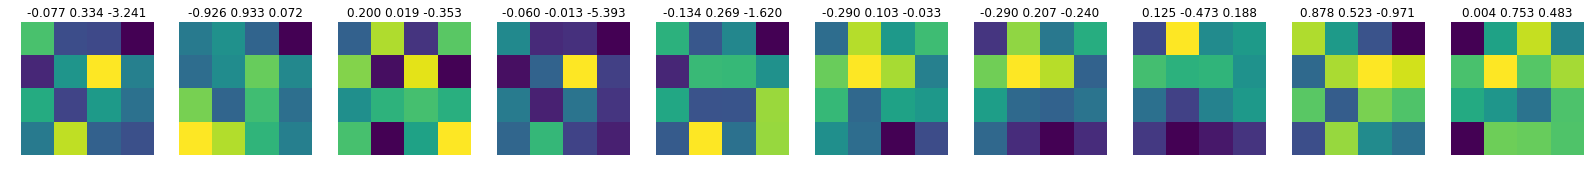

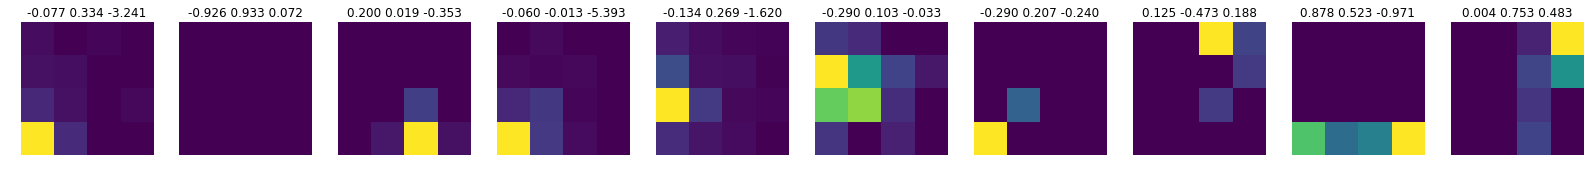

Train loss: 0.19924443422794216 Batch 2000 of 500           epoch: 5
a_gen shape torch.Size([10, 16])
alpha  0.004
batch_loss:loss_simple, KL, sum, res  tensor(0.4505) tensor(2.5412e-07, grad_fn=<SumBackward0>) tensor(109.7950, grad_fn=<AbsBackward>) tensor(-243.3738, grad_fn=<SumBackward0>)


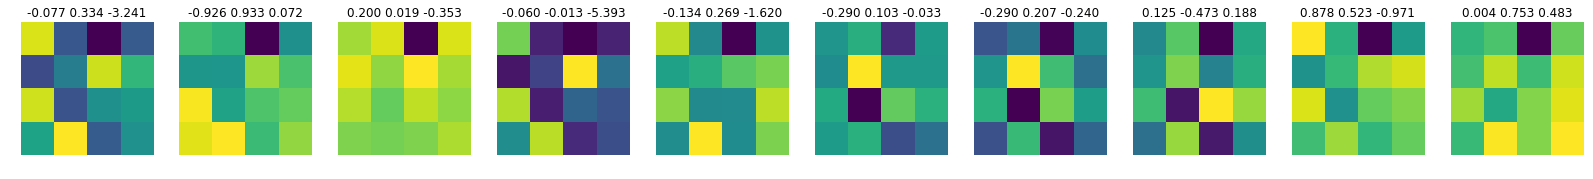

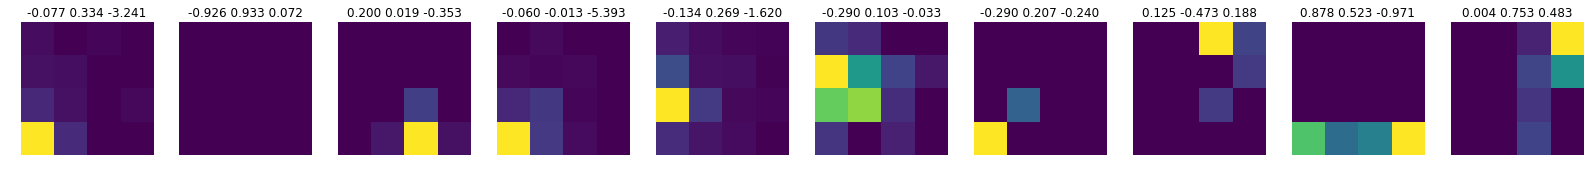

Train loss: 0.4513528655366804 Batch 2000 of 500           epoch: 6
a_gen shape torch.Size([10, 16])
alpha  0.008
batch_loss:loss_simple, KL, sum, res  tensor(0.2832) tensor(1.3845e-07, grad_fn=<SumBackward0>) tensor(44.9064, grad_fn=<AbsBackward>) tensor(-109.8008, grad_fn=<SumBackward0>)


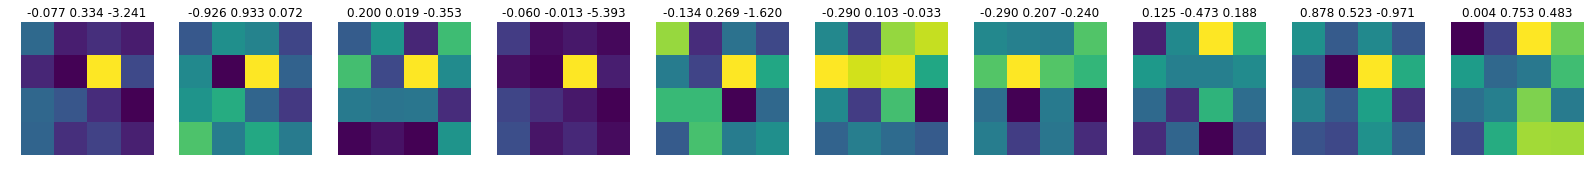

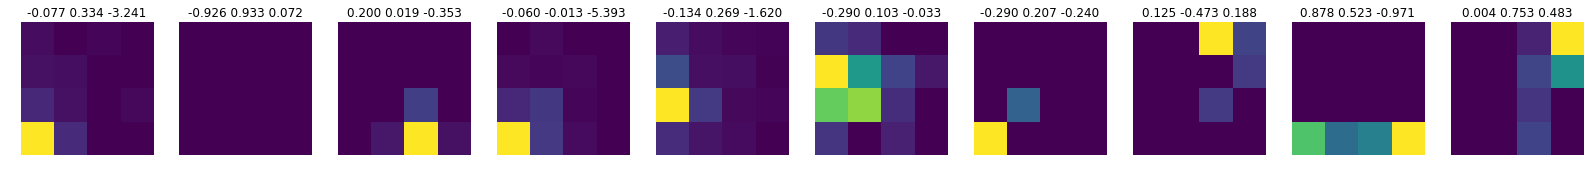

Train loss: 0.2836658906707402 Batch 2000 of 500           epoch: 7
a_gen shape torch.Size([10, 16])
alpha  0.008
batch_loss:loss_simple, KL, sum, res  tensor(0.4122) tensor(1.2747e-07, grad_fn=<SumBackward0>) tensor(95.7413, grad_fn=<AbsBackward>) tensor(-168.6556, grad_fn=<SumBackward0>)


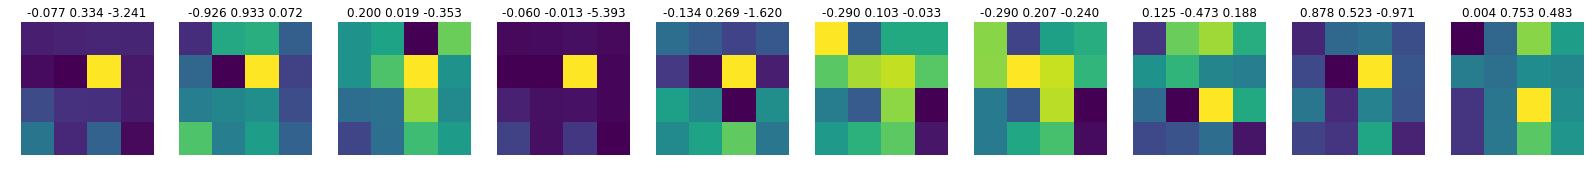

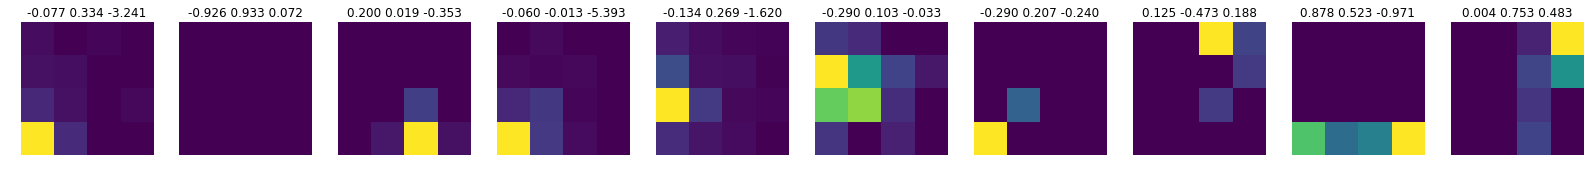

Train loss: 0.4145640769630806 Batch 2000 of 500           epoch: 8
a_gen shape torch.Size([10, 16])
alpha  0.016
batch_loss:loss_simple, KL, sum, res  tensor(0.2758) tensor(5.4534e-06, grad_fn=<SumBackward0>) tensor(36.8090, grad_fn=<AbsBackward>) tensor(-90.2981, grad_fn=<SumBackward0>)


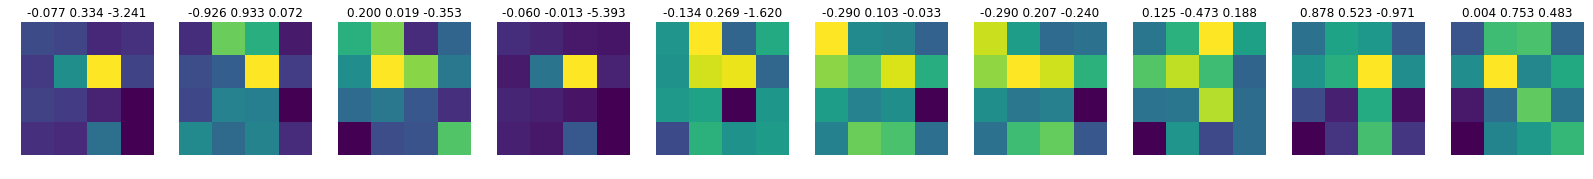

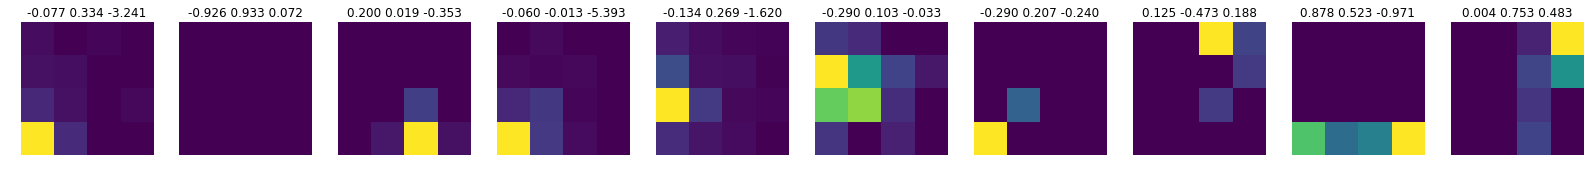

Train loss: 0.27904954958941064 Batch 2000 of 500           epoch: 9
a_gen shape torch.Size([10, 16])
alpha  0.016
batch_loss:loss_simple, KL, sum, res  tensor(0.3376) tensor(9.1074e-08, grad_fn=<SumBackward0>) tensor(68.7173, grad_fn=<AbsBackward>) tensor(-122.8882, grad_fn=<SumBackward0>)


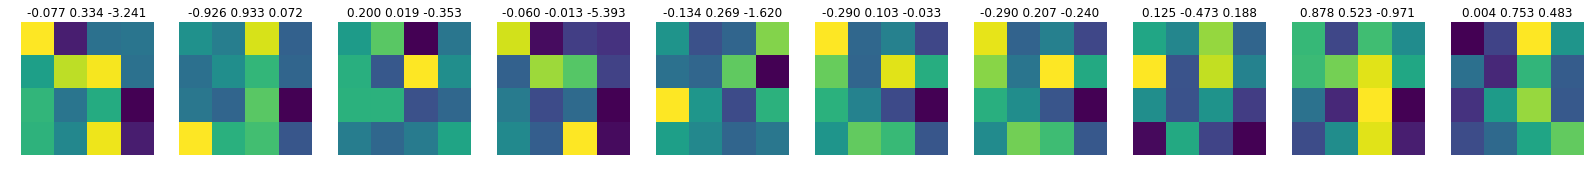

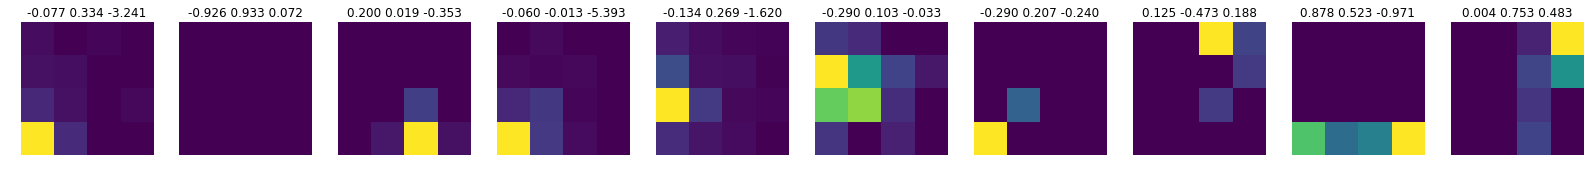

Train loss: 0.3371096370391795 Batch 2000 of 500           epoch: 10
a_gen shape torch.Size([10, 16])
alpha  0.032
batch_loss:loss_simple, KL, sum, res  tensor(0.3310) tensor(3.4787e-08, grad_fn=<SumBackward0>) tensor(59.0322, grad_fn=<AbsBackward>) tensor(-153.0939, grad_fn=<SumBackward0>)


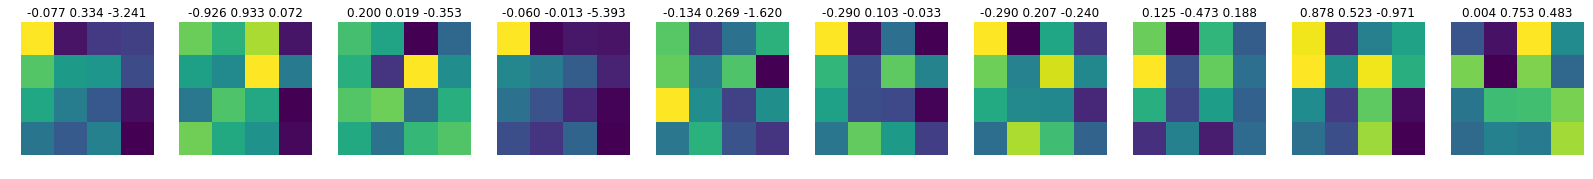

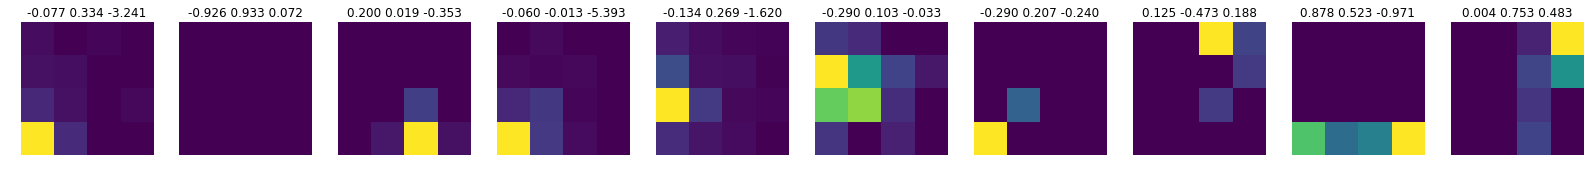

Train loss: 0.3321317023026368 Batch 2000 of 500           epoch: 11
a_gen shape torch.Size([10, 16])
alpha  0.032
batch_loss:loss_simple, KL, sum, res  tensor(0.4382) tensor(1.5225e-08, grad_fn=<SumBackward0>) tensor(94.2288, grad_fn=<AbsBackward>) tensor(-192.0735, grad_fn=<SumBackward0>)


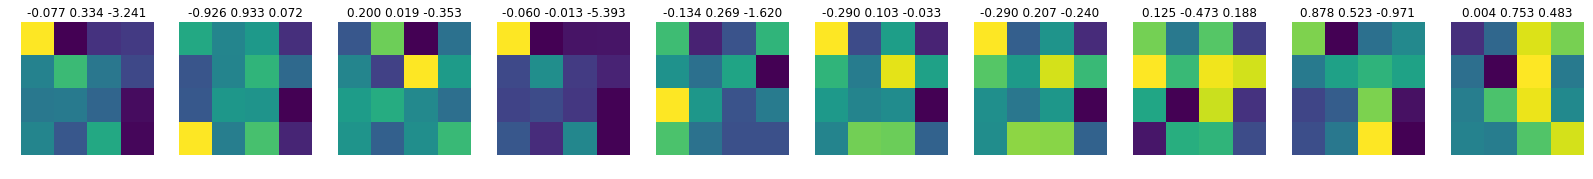

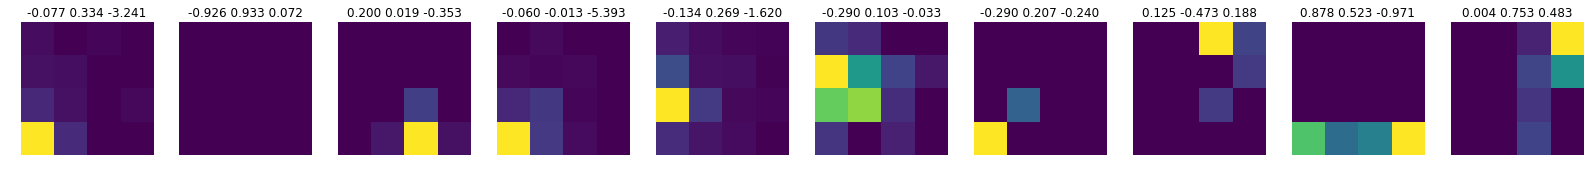

Train loss: 0.43801202982316995 Batch 2000 of 500           epoch: 12
a_gen shape torch.Size([10, 16])
alpha  0.064
batch_loss:loss_simple, KL, sum, res  tensor(0.5295) tensor(1.7120e-07, grad_fn=<SumBackward0>) tensor(143.5796, grad_fn=<AbsBackward>) tensor(-307.5756, grad_fn=<SumBackward0>)


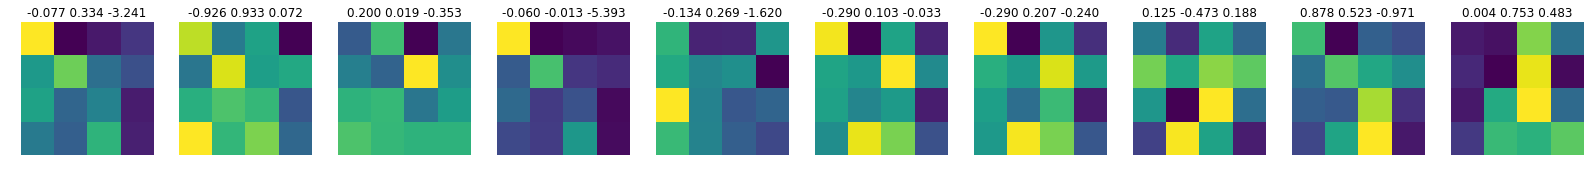

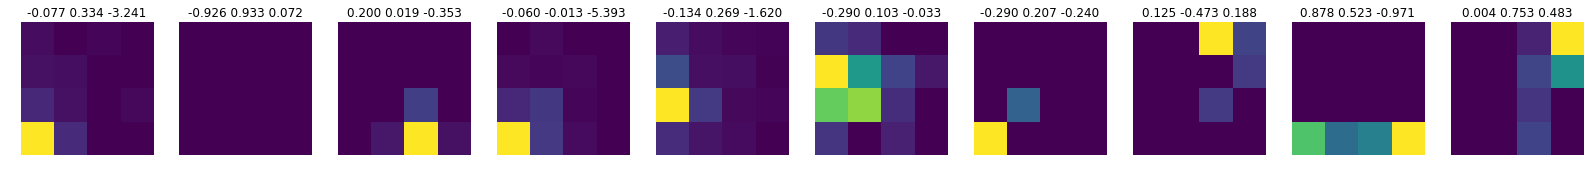

Train loss: 0.5290249106483472 Batch 2000 of 500           epoch: 13
a_gen shape torch.Size([10, 16])
alpha  0.064
batch_loss:loss_simple, KL, sum, res  tensor(0.3076) tensor(1.4190e-07, grad_fn=<SumBackward0>) tensor(54.8174, grad_fn=<AbsBackward>) tensor(-81.3732, grad_fn=<SumBackward0>)


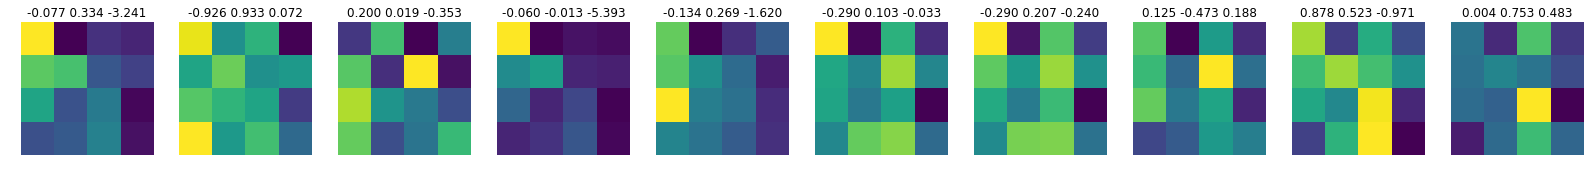

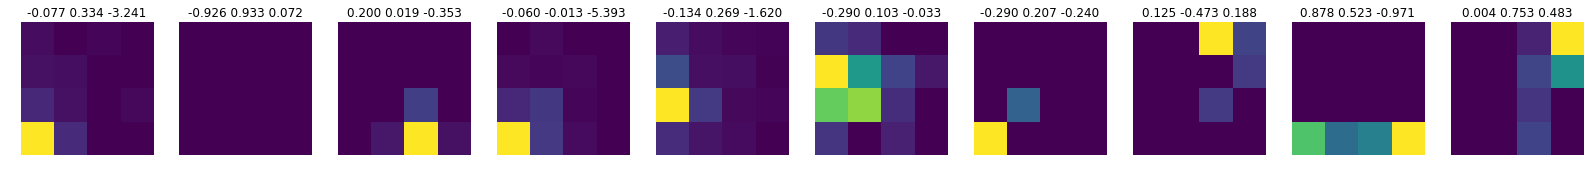

Train loss: 0.30240073585945365 Batch 2000 of 500           epoch: 14
a_gen shape torch.Size([10, 16])
alpha  0.128
batch_loss:loss_simple, KL, sum, res  tensor(0.4600) tensor(1.3566e-07, grad_fn=<SumBackward0>) tensor(118.2739, grad_fn=<AbsBackward>) tensor(-244.0103, grad_fn=<SumBackward0>)


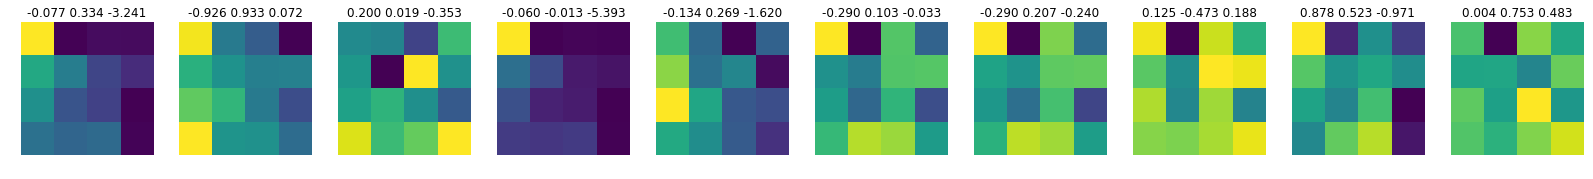

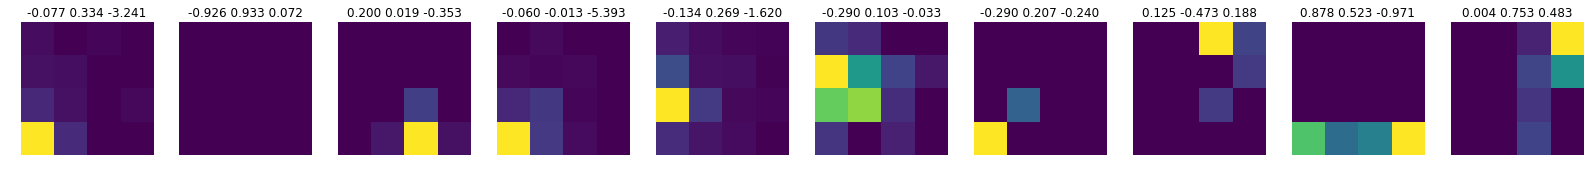

Train loss: 0.46233842669077535 Batch 2000 of 500           epoch: 15
a_gen shape torch.Size([10, 16])
alpha  0.128
batch_loss:loss_simple, KL, sum, res  tensor(0.3981) tensor(5.3653e-08, grad_fn=<SumBackward0>) tensor(98.1021, grad_fn=<AbsBackward>) tensor(-189.8587, grad_fn=<SumBackward0>)


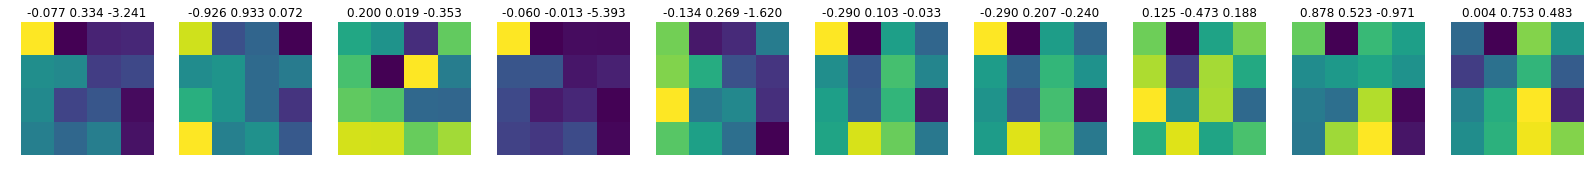

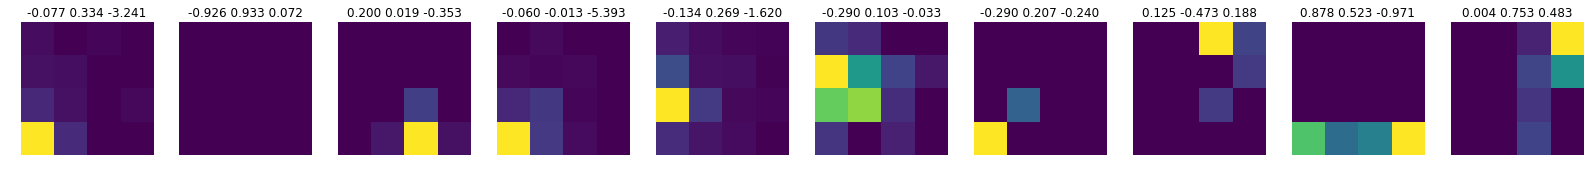

Train loss: 0.3913556131568475 Batch 2000 of 500           epoch: 16
a_gen shape torch.Size([10, 16])
alpha  0.256
batch_loss:loss_simple, KL, sum, res  tensor(0.4021) tensor(4.4620e-07, grad_fn=<SumBackward0>) tensor(81.9459, grad_fn=<AbsBackward>) tensor(-190.5345, grad_fn=<SumBackward0>)


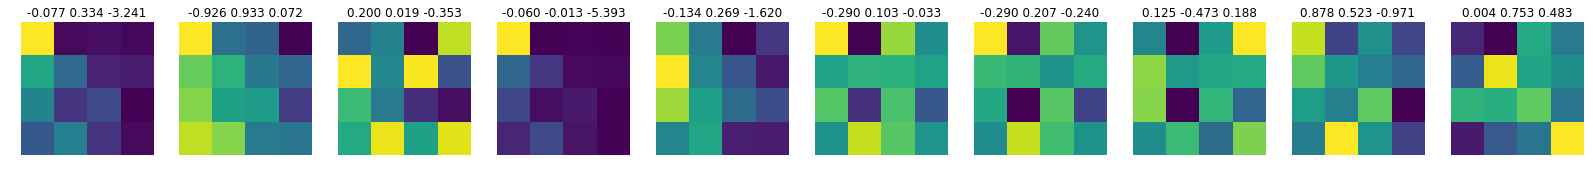

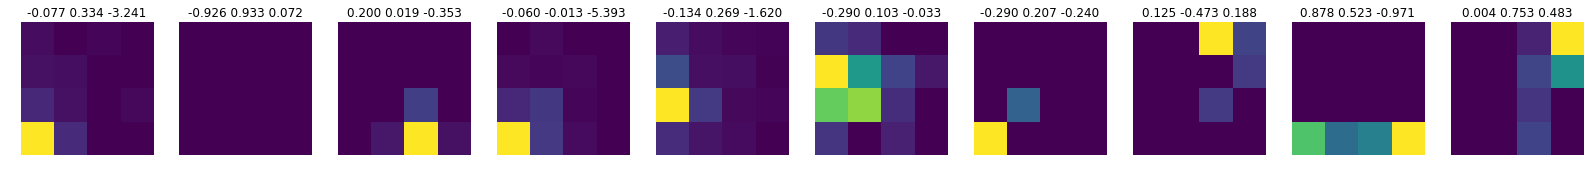

Train loss: 0.4024113252321256 Batch 2000 of 500           epoch: 17
a_gen shape torch.Size([10, 16])
alpha  0.256
batch_loss:loss_simple, KL, sum, res  tensor(0.2656) tensor(1.9732e-08, grad_fn=<SumBackward0>) tensor(46.4542, grad_fn=<AbsBackward>) tensor(-68.5388, grad_fn=<SumBackward0>)


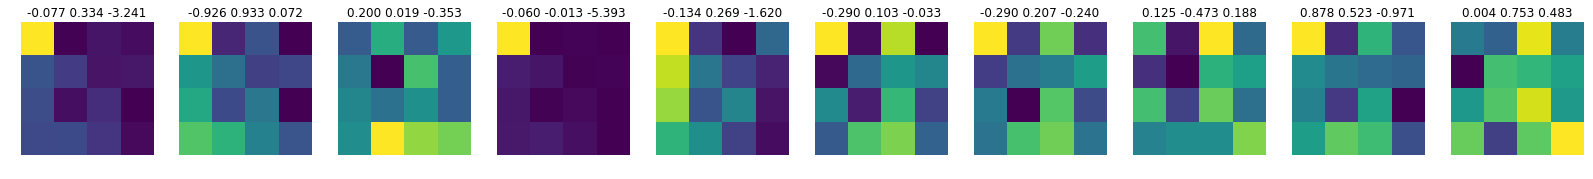

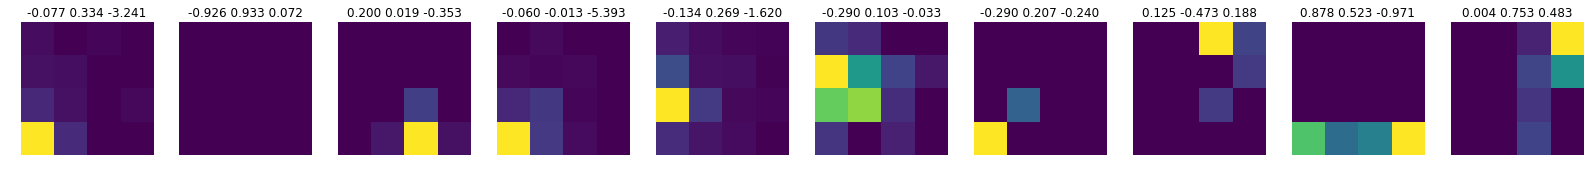

Train loss: 0.2670889345618709 Batch 2000 of 500           epoch: 18
a_gen shape torch.Size([10, 16])
alpha  0.512
batch_loss:loss_simple, KL, sum, res  tensor(0.4653) tensor(6.5998e-08, grad_fn=<SumBackward0>) tensor(120.8371, grad_fn=<AbsBackward>) tensor(-214.5876, grad_fn=<SumBackward0>)


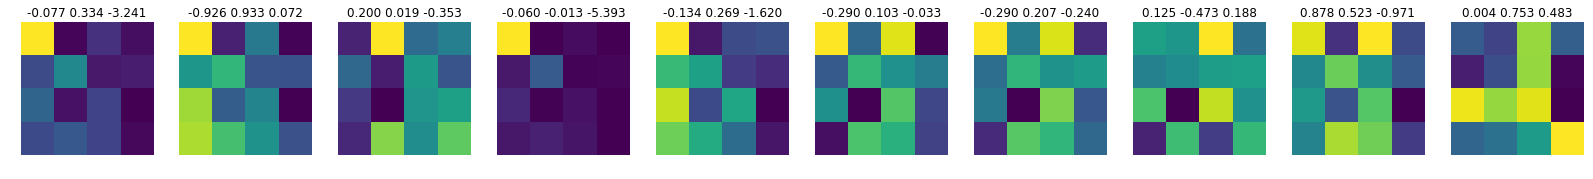

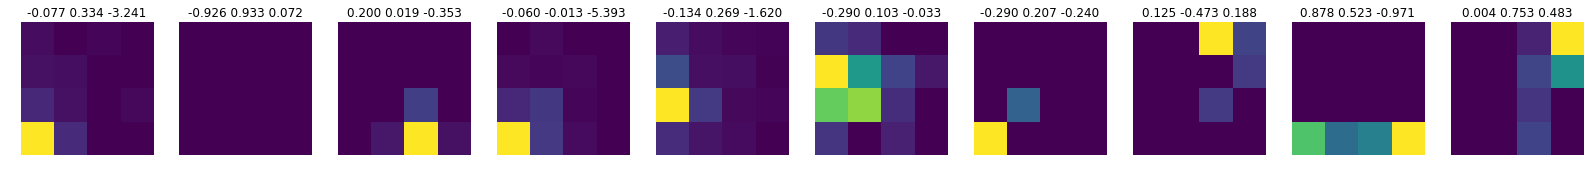

Train loss: 0.4636893779612884 Batch 2000 of 500           epoch: 19
a_gen shape torch.Size([10, 16])
alpha  0.512
batch_loss:loss_simple, KL, sum, res  tensor(0.3317) tensor(1.1598e-07, grad_fn=<SumBackward0>) tensor(65.3999, grad_fn=<AbsBackward>) tensor(-108.7784, grad_fn=<SumBackward0>)


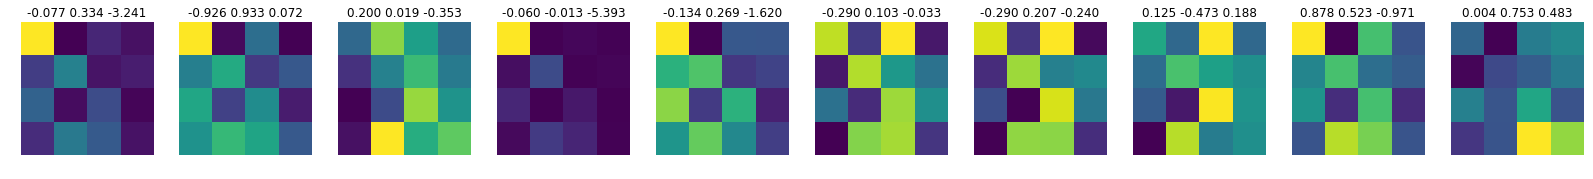

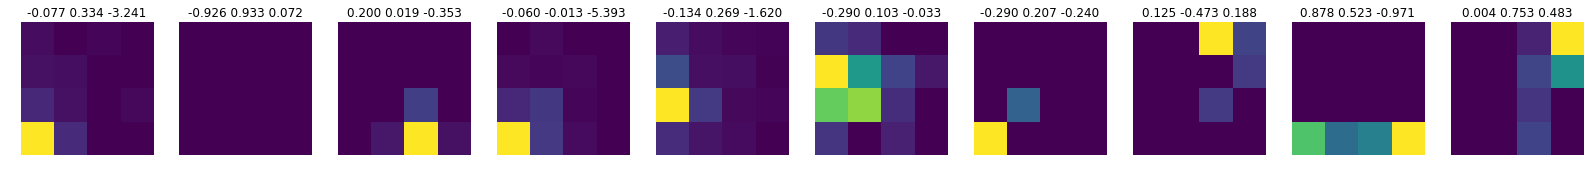

Train loss: 0.3325325143143999 Batch 2000 of 500           epoch: 20
a_gen shape torch.Size([10, 16])
alpha  1.024
batch_loss:loss_simple, KL, sum, res  tensor(0.4199) tensor(1.4721e-08, grad_fn=<SumBackward0>) tensor(94.0688, grad_fn=<AbsBackward>) tensor(-167.6109, grad_fn=<SumBackward0>)


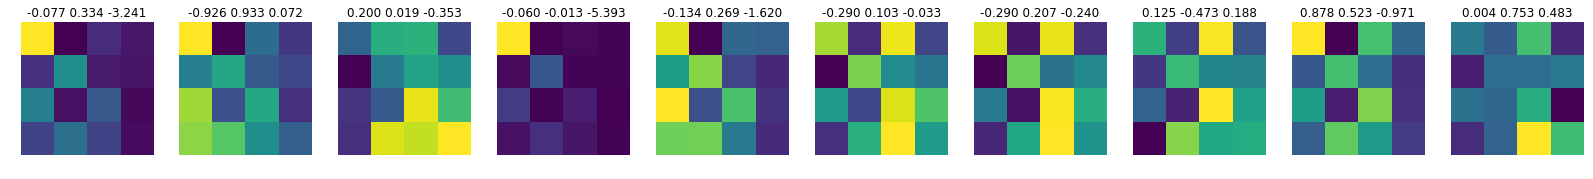

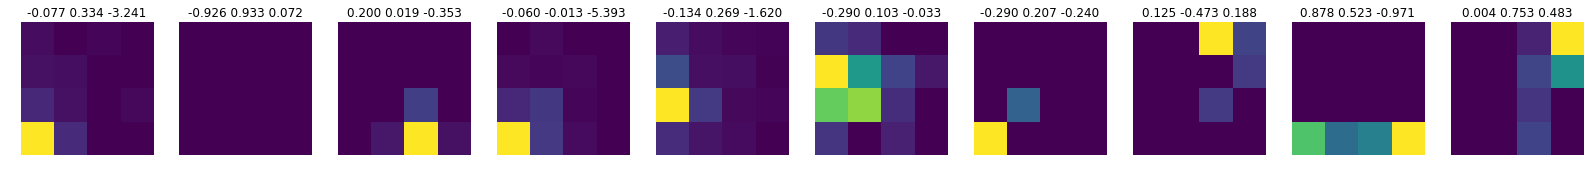

Train loss: 0.4207199749227277 Batch 2000 of 500           epoch: 21
a_gen shape torch.Size([10, 16])
alpha  1.024
batch_loss:loss_simple, KL, sum, res  tensor(0.3990) tensor(1.9611e-09, grad_fn=<SumBackward0>) tensor(88.9061, grad_fn=<AbsBackward>) tensor(-164.0074, grad_fn=<SumBackward0>)


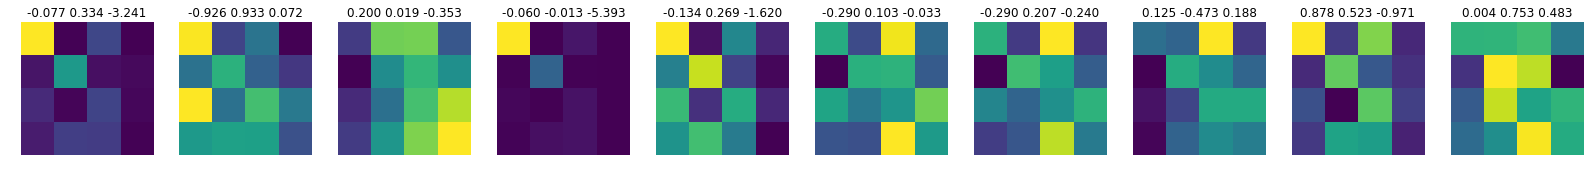

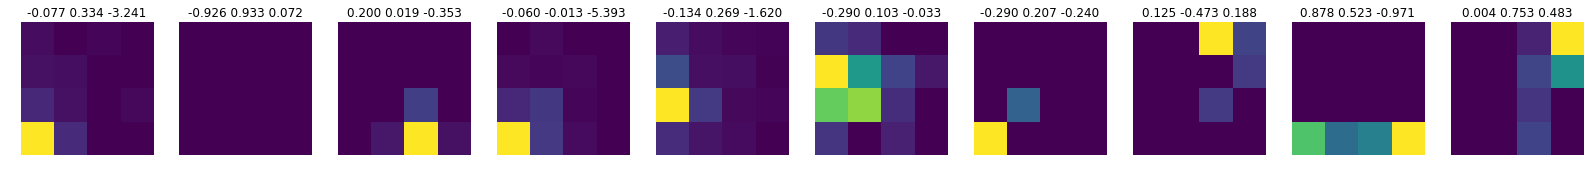

Train loss: 0.3980587965889996 Batch 2000 of 500           epoch: 22
a_gen shape torch.Size([10, 16])
alpha  2.048
batch_loss:loss_simple, KL, sum, res  tensor(0.4333) tensor(3.6586e-08, grad_fn=<SumBackward0>) tensor(106.6261, grad_fn=<AbsBackward>) tensor(-183.0300, grad_fn=<SumBackward0>)


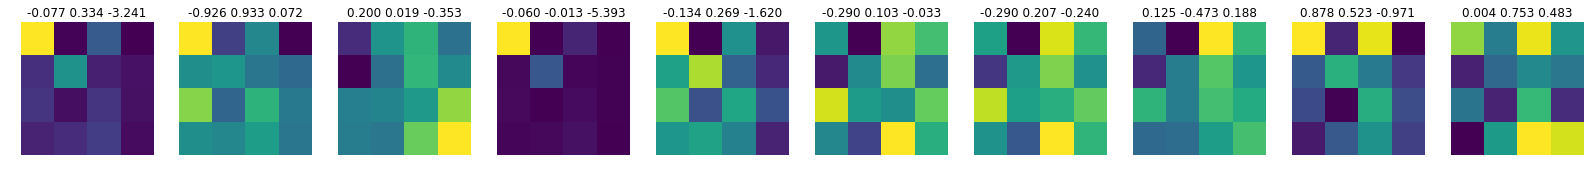

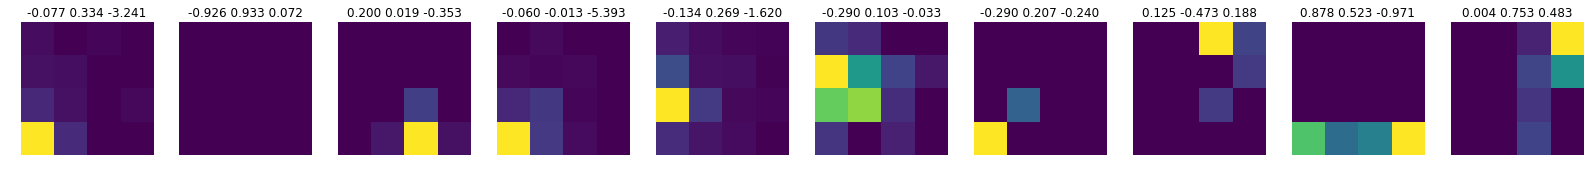

Train loss: 0.4349696448124704 Batch 2000 of 500           epoch: 23
a_gen shape torch.Size([10, 16])
alpha  2.048
batch_loss:loss_simple, KL, sum, res  tensor(0.3050) tensor(8.0636e-08, grad_fn=<SumBackward0>) tensor(54.4236, grad_fn=<AbsBackward>) tensor(-83.6665, grad_fn=<SumBackward0>)


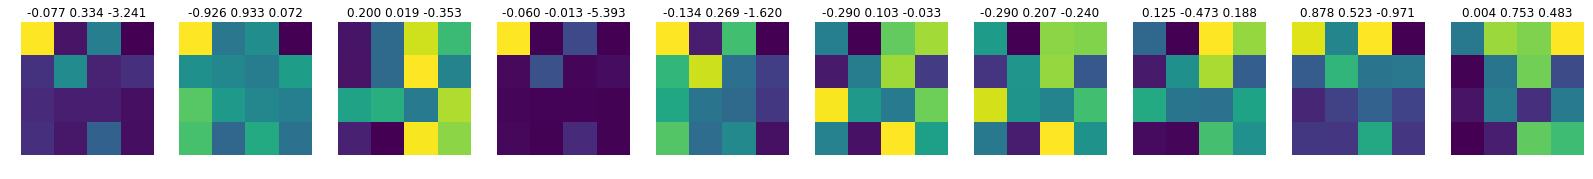

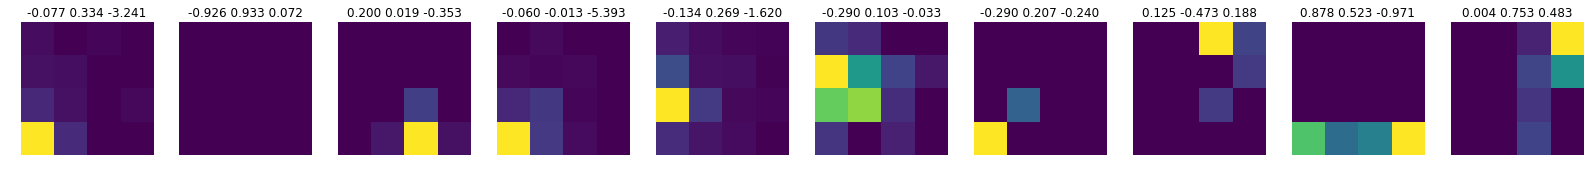

Train loss: 0.3124853262098391 Batch 2000 of 500           epoch: 24
a_gen shape torch.Size([10, 16])
alpha  4.096
batch_loss:loss_simple, KL, sum, res  tensor(0.3415) tensor(2.2727e-08, grad_fn=<SumBackward0>) tensor(63.4534, grad_fn=<AbsBackward>) tensor(-162.9902, grad_fn=<SumBackward0>)


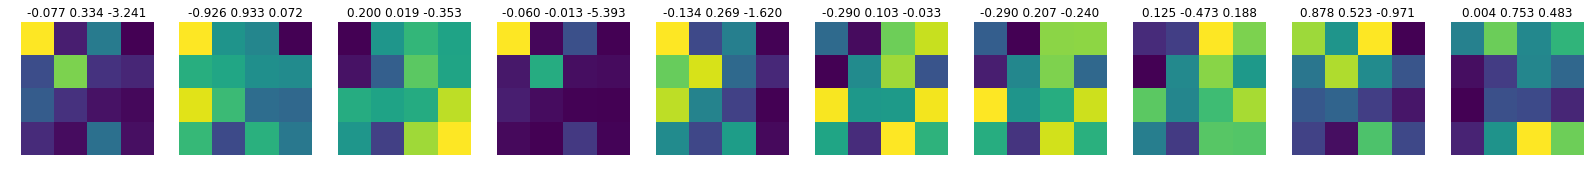

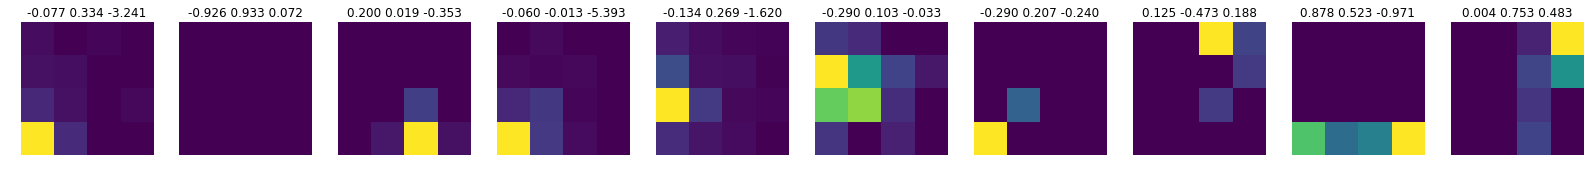

Train loss: 0.3413843243164266 Batch 2000 of 500           epoch: 25
a_gen shape torch.Size([10, 16])
alpha  4.096
batch_loss:loss_simple, KL, sum, res  tensor(0.4375) tensor(1.5280e-08, grad_fn=<SumBackward0>) tensor(108.7114, grad_fn=<AbsBackward>) tensor(-215.7833, grad_fn=<SumBackward0>)


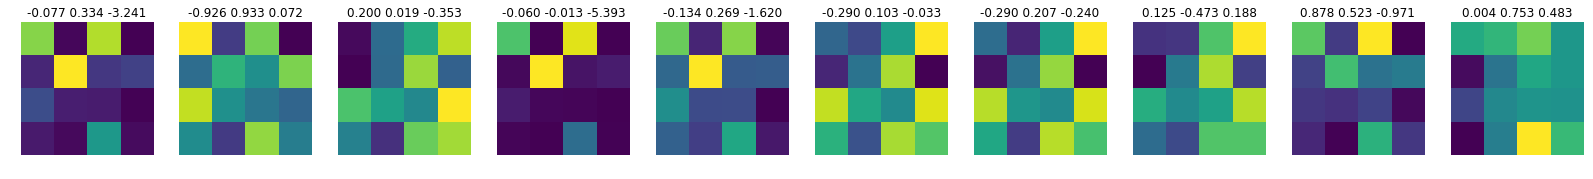

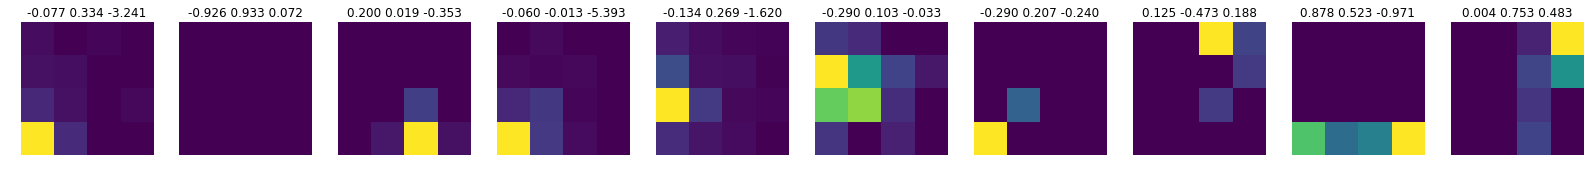

Train loss: 0.4373308751638604 Batch 2000 of 500           epoch: 26
a_gen shape torch.Size([10, 16])
alpha  8.192
batch_loss:loss_simple, KL, sum, res  tensor(0.3336) tensor(2.1125e-08, grad_fn=<SumBackward0>) tensor(76.5952, grad_fn=<AbsBackward>) tensor(-127.0776, grad_fn=<SumBackward0>)


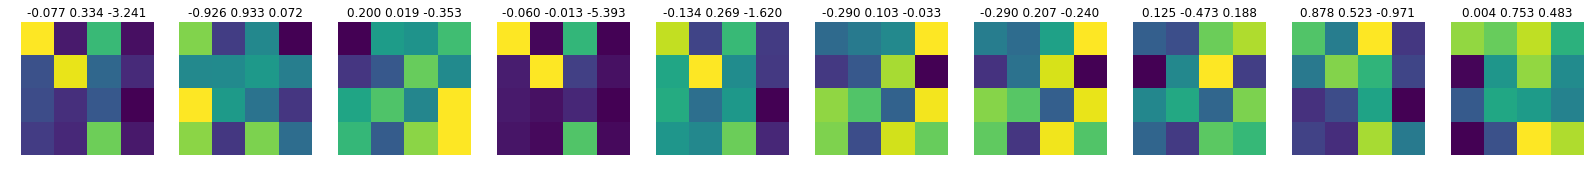

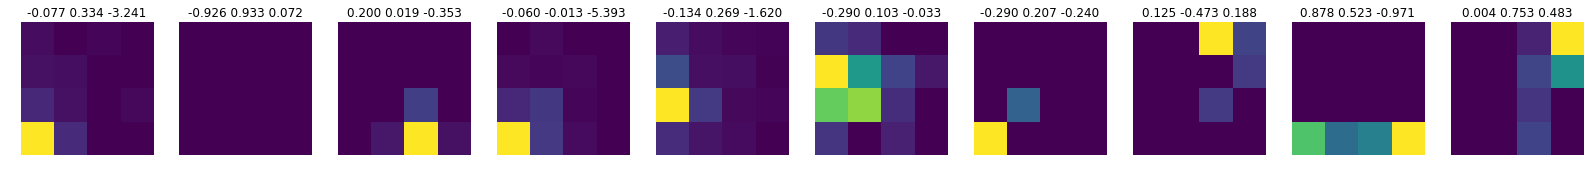

Train loss: 0.33458014876707043 Batch 2000 of 500           epoch: 27
a_gen shape torch.Size([10, 16])
alpha  8.192
batch_loss:loss_simple, KL, sum, res  tensor(0.4192) tensor(2.9914e-09, grad_fn=<SumBackward0>) tensor(102.7649, grad_fn=<AbsBackward>) tensor(-170.2377, grad_fn=<SumBackward0>)


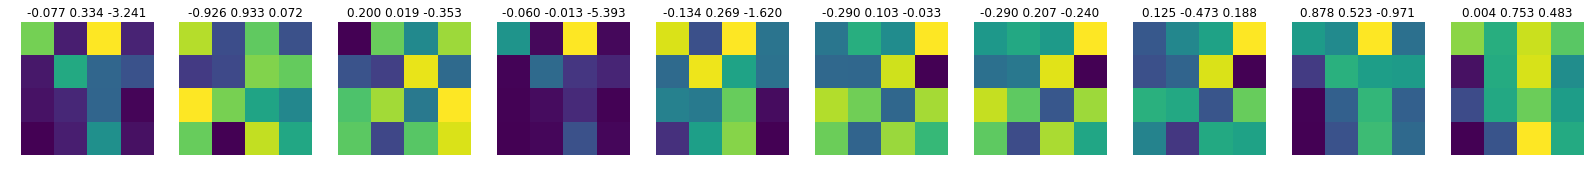

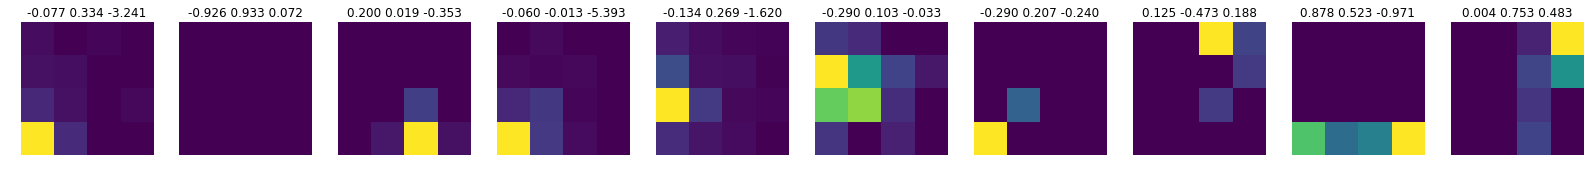

Train loss: 0.421048172466857 Batch 2000 of 500           epoch: 28
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3926) tensor(1.2583e-08, grad_fn=<SumBackward0>) tensor(89.5082, grad_fn=<AbsBackward>) tensor(-155.8907, grad_fn=<SumBackward0>)


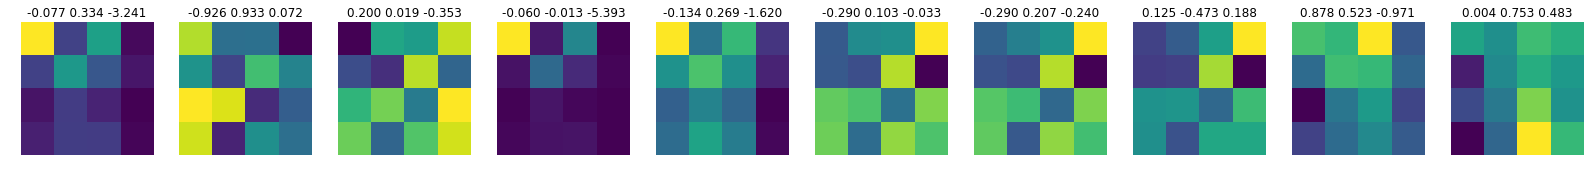

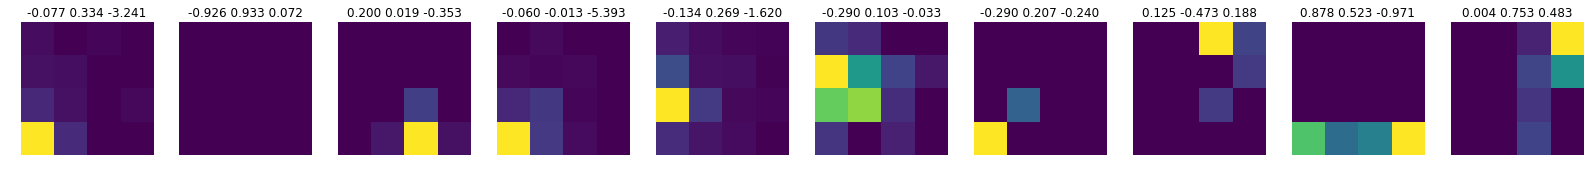

Train loss: 0.39088522739232545 Batch 2000 of 500           epoch: 29
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4224) tensor(8.2192e-08, grad_fn=<SumBackward0>) tensor(102.7255, grad_fn=<AbsBackward>) tensor(-191.5706, grad_fn=<SumBackward0>)


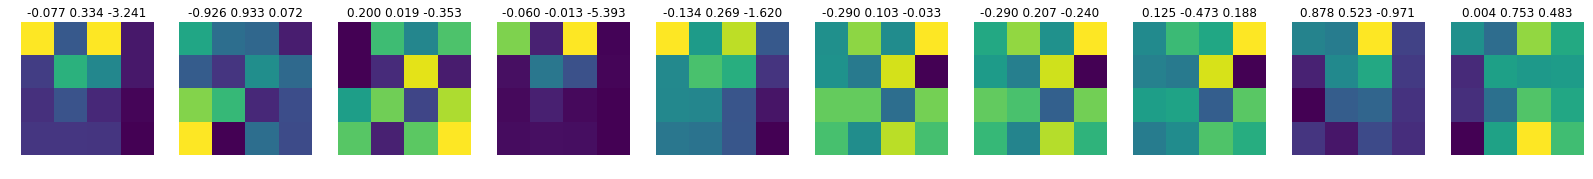

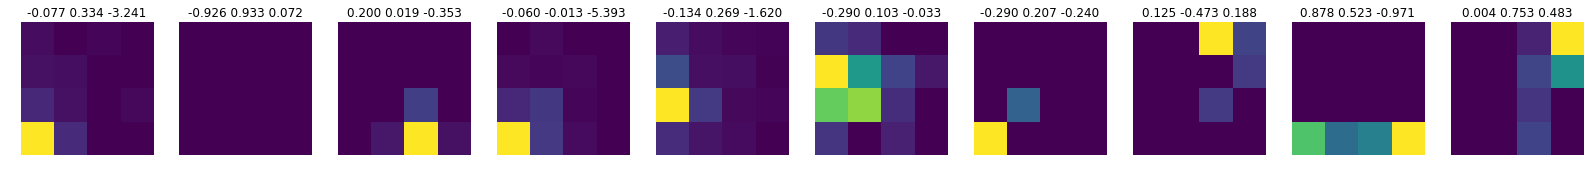

Train loss: 0.419913581799362 Batch 2000 of 500           epoch: 30
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2979) tensor(1.3279e-09, grad_fn=<SumBackward0>) tensor(52.2940, grad_fn=<AbsBackward>) tensor(-172.6136, grad_fn=<SumBackward0>)


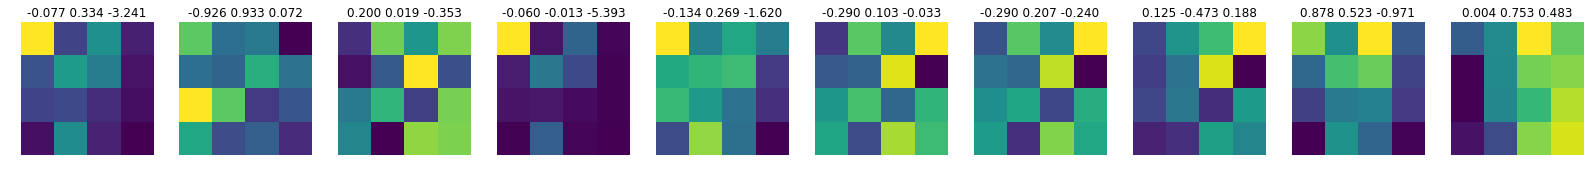

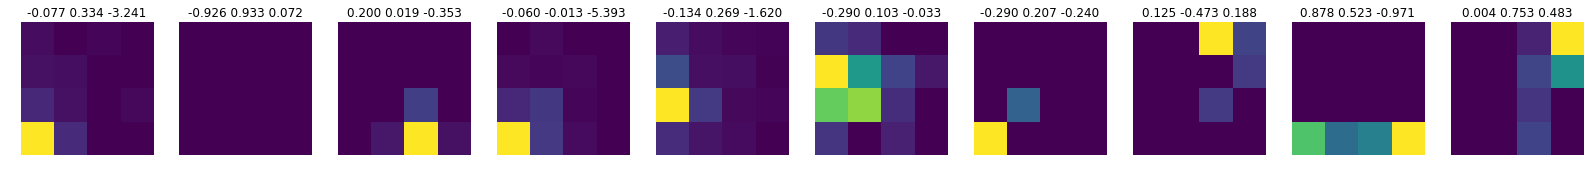

Train loss: 0.2996278153161886 Batch 2000 of 500           epoch: 31
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4764) tensor(1.5824e-07, grad_fn=<SumBackward0>) tensor(116.7624, grad_fn=<AbsBackward>) tensor(-251.6460, grad_fn=<SumBackward0>)


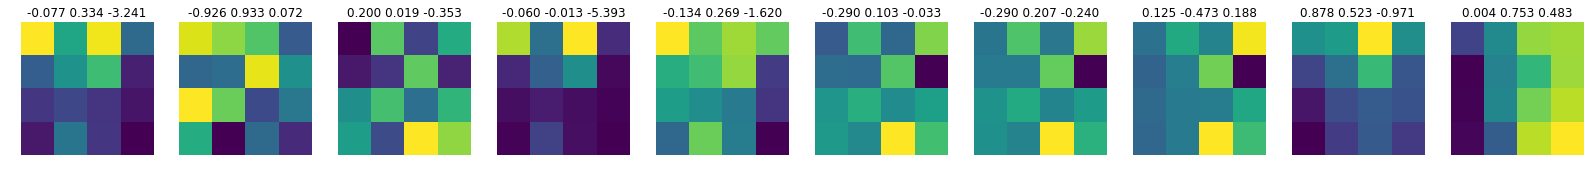

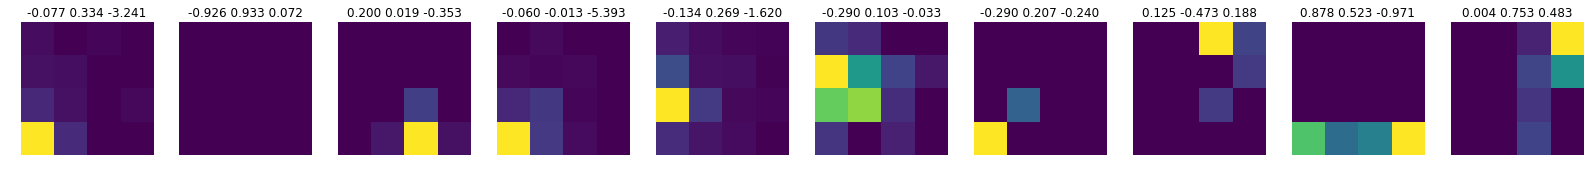

Train loss: 0.4763785340080894 Batch 2000 of 500           epoch: 32
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2474) tensor(1.7990e-07, grad_fn=<SumBackward0>) tensor(35.1435, grad_fn=<AbsBackward>) tensor(-60.2094, grad_fn=<SumBackward0>)


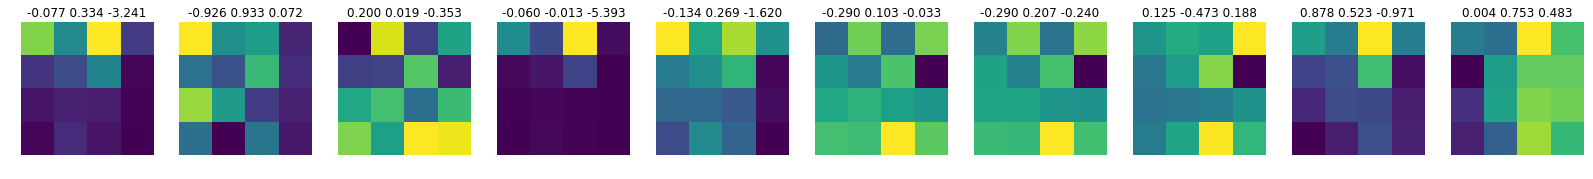

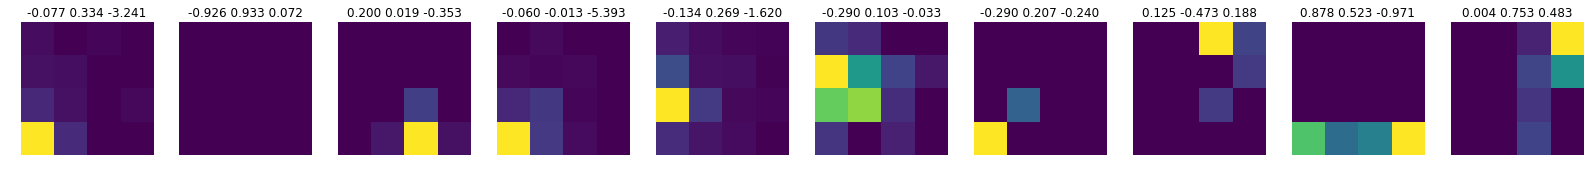

Train loss: 0.24970727728169026 Batch 2000 of 500           epoch: 33
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4197) tensor(1.3770e-07, grad_fn=<SumBackward0>) tensor(107.9714, grad_fn=<AbsBackward>) tensor(-217.2739, grad_fn=<SumBackward0>)


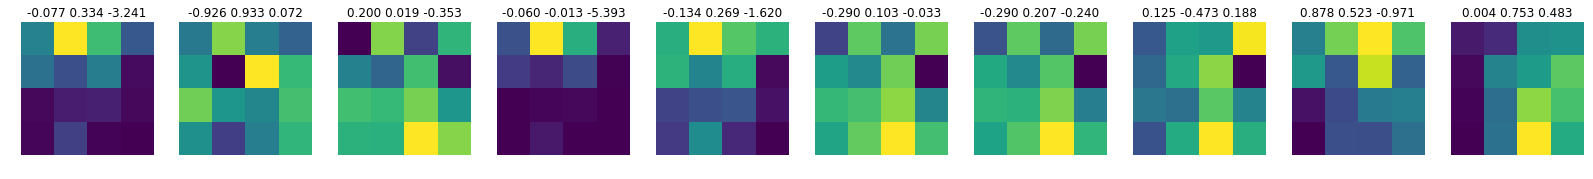

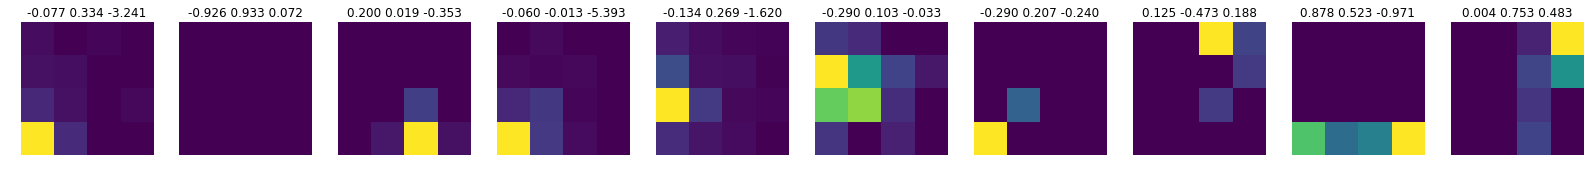

Train loss: 0.4229742998356686 Batch 2000 of 500           epoch: 34
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2665) tensor(1.0462e-08, grad_fn=<SumBackward0>) tensor(39.1919, grad_fn=<AbsBackward>) tensor(-69.0915, grad_fn=<SumBackward0>)


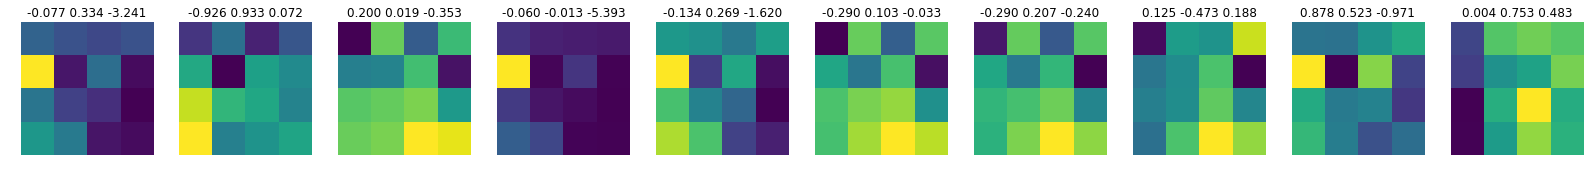

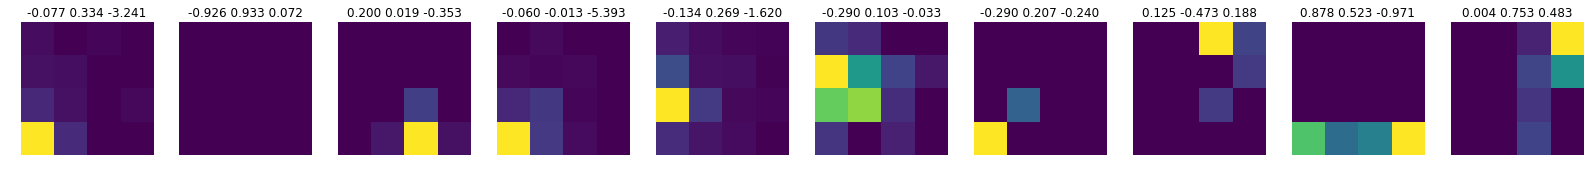

Train loss: 0.26640231086100225 Batch 2000 of 500           epoch: 35
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.5426) tensor(1.2489e-08, grad_fn=<SumBackward0>) tensor(143.4874, grad_fn=<AbsBackward>) tensor(-367.2724, grad_fn=<SumBackward0>)


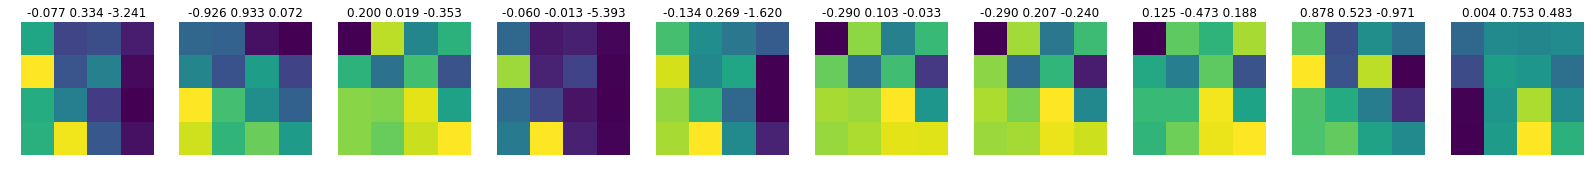

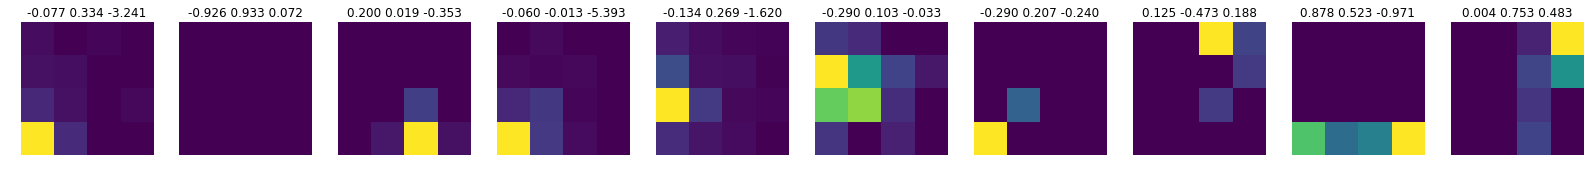

Train loss: 0.5439411829924484 Batch 2000 of 500           epoch: 36
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2646) tensor(1.0453e-08, grad_fn=<SumBackward0>) tensor(40.0675, grad_fn=<AbsBackward>) tensor(-62.5355, grad_fn=<SumBackward0>)


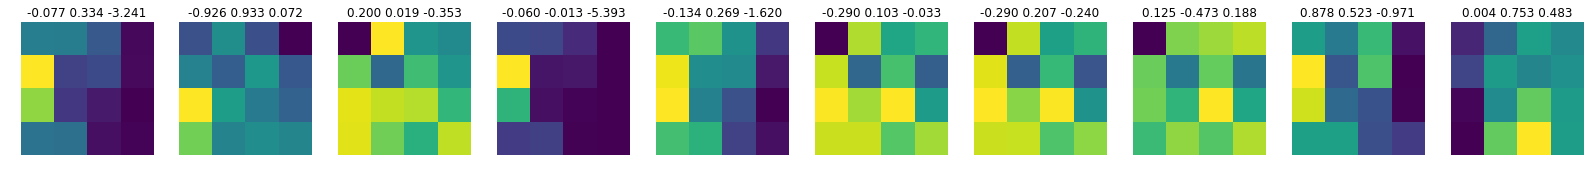

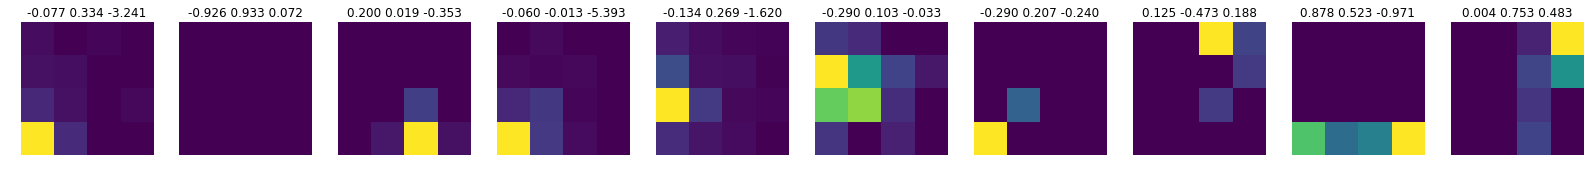

Train loss: 0.26585287102301985 Batch 2000 of 500           epoch: 37
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3745) tensor(1.0219e-07, grad_fn=<SumBackward0>) tensor(79.7838, grad_fn=<AbsBackward>) tensor(-154.0329, grad_fn=<SumBackward0>)


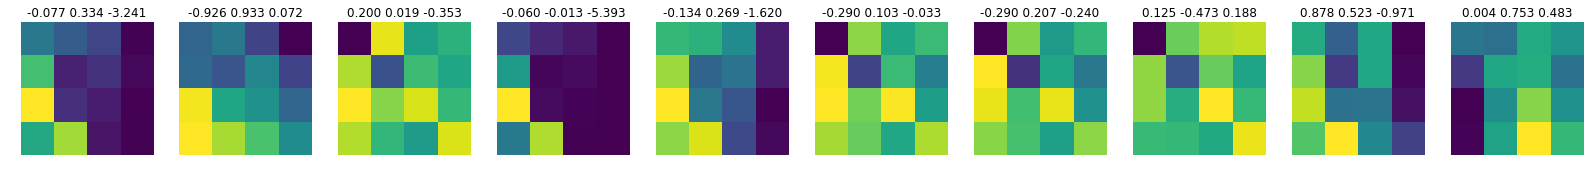

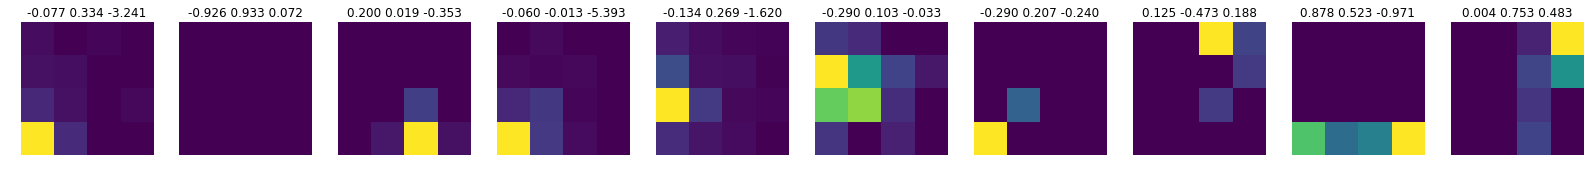

Train loss: 0.37578850724387797 Batch 2000 of 500           epoch: 38
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3858) tensor(1.3279e-07, grad_fn=<SumBackward0>) tensor(80.7266, grad_fn=<AbsBackward>) tensor(-160.5657, grad_fn=<SumBackward0>)


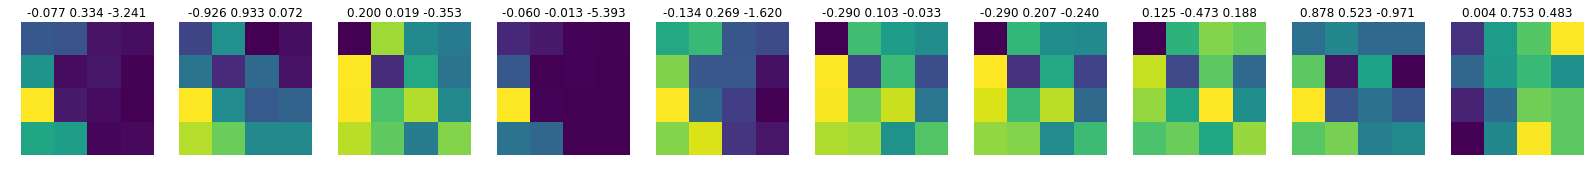

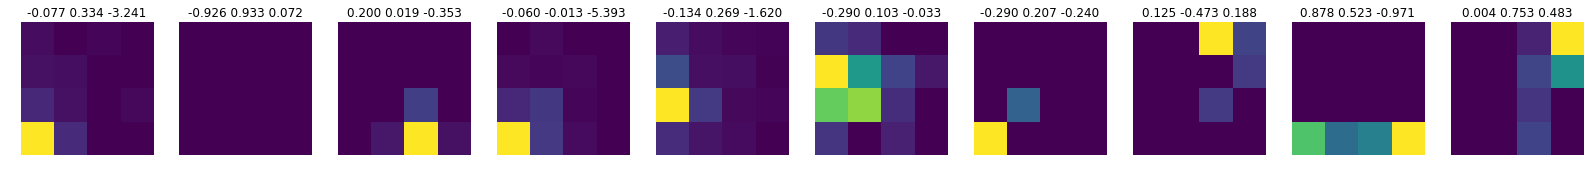

Train loss: 0.3851372816396307 Batch 2000 of 500           epoch: 39
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2830) tensor(1.3845e-07, grad_fn=<SumBackward0>) tensor(42.0529, grad_fn=<AbsBackward>) tensor(-116.9144, grad_fn=<SumBackward0>)


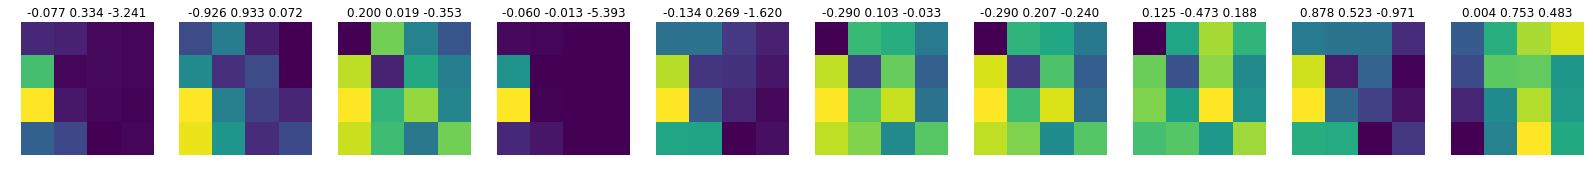

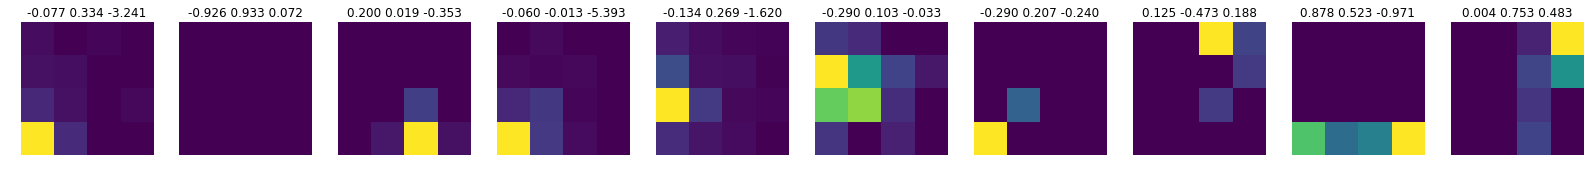

Train loss: 0.28187356958520227 Batch 2000 of 500           epoch: 40
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4734) tensor(3.8965e-08, grad_fn=<SumBackward0>) tensor(133.3517, grad_fn=<AbsBackward>) tensor(-242.7983, grad_fn=<SumBackward0>)


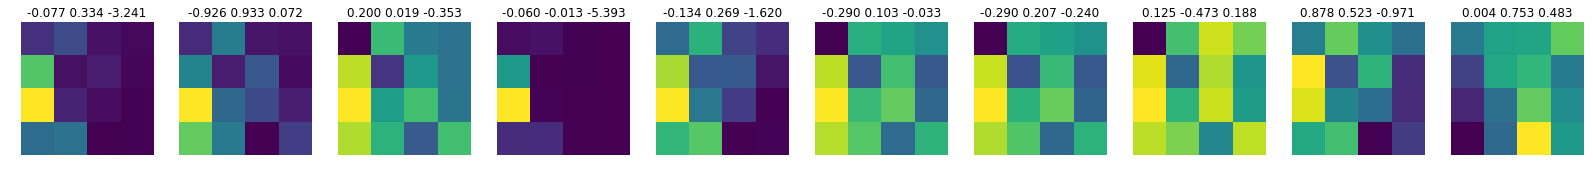

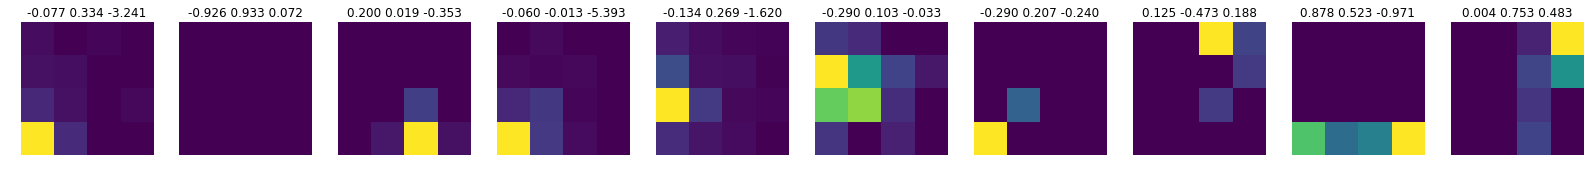

Train loss: 0.472927077075055 Batch 2000 of 500           epoch: 41
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4387) tensor(1.6287e-07, grad_fn=<SumBackward0>) tensor(108.0707, grad_fn=<AbsBackward>) tensor(-207.0082, grad_fn=<SumBackward0>)


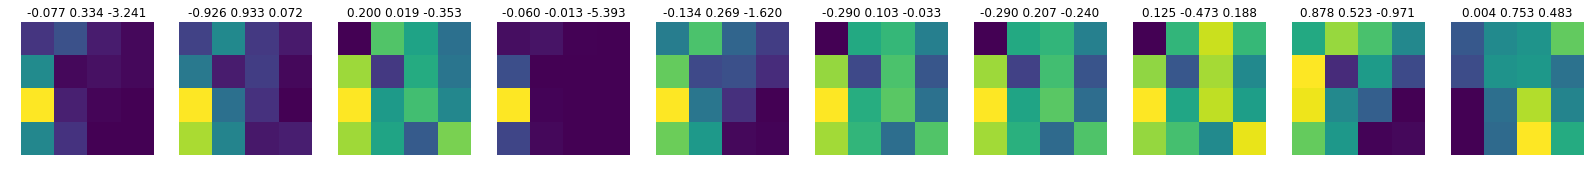

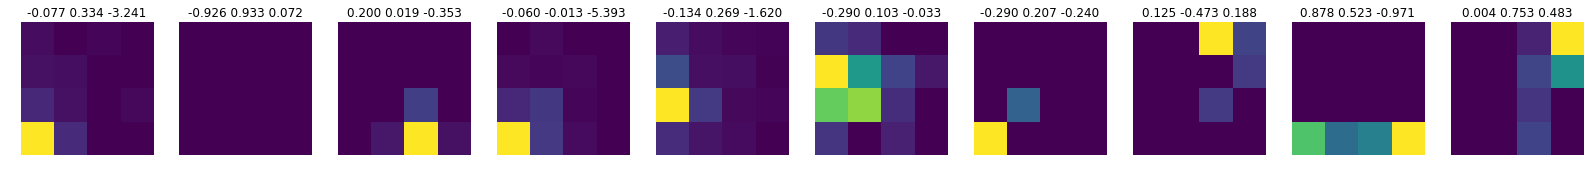

Train loss: 0.4378423567170154 Batch 2000 of 500           epoch: 42
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3769) tensor(2.0468e-07, grad_fn=<SumBackward0>) tensor(82.0374, grad_fn=<AbsBackward>) tensor(-137.7043, grad_fn=<SumBackward0>)


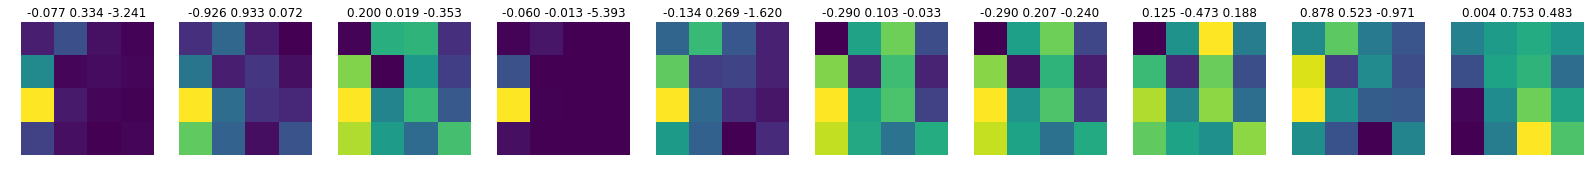

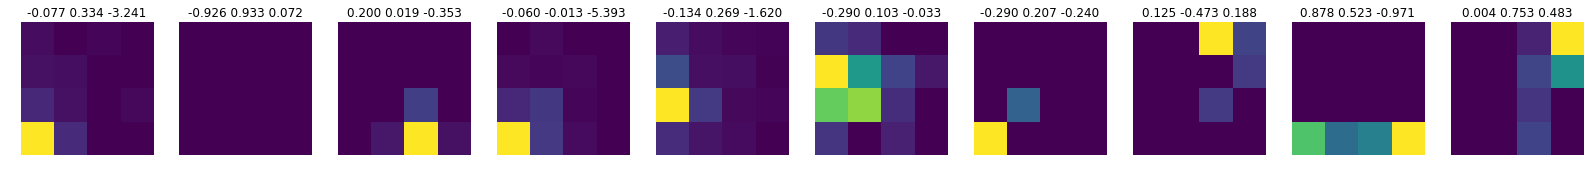

Train loss: 0.3771242999165285 Batch 2000 of 500           epoch: 43
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3342) tensor(3.0353e-08, grad_fn=<SumBackward0>) tensor(61.6904, grad_fn=<AbsBackward>) tensor(-101.3820, grad_fn=<SumBackward0>)


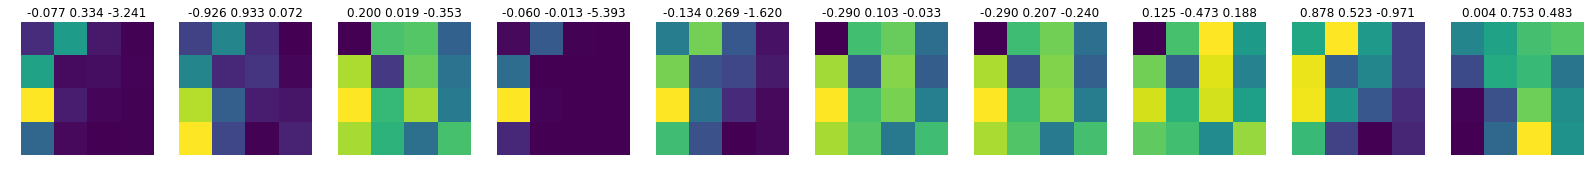

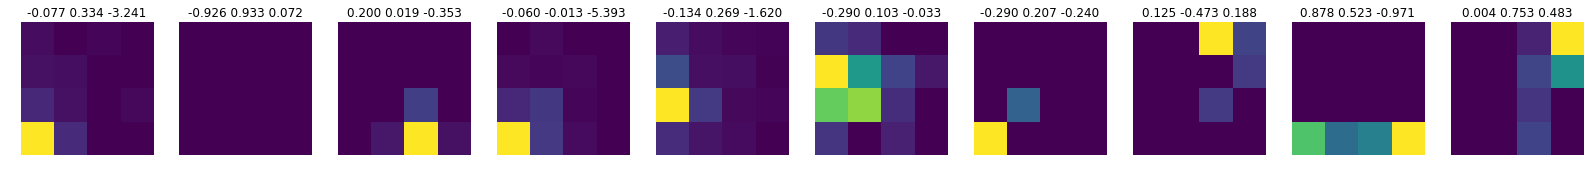

Train loss: 0.3342357422988788 Batch 2000 of 500           epoch: 44
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4447) tensor(5.3812e-08, grad_fn=<SumBackward0>) tensor(122.1035, grad_fn=<AbsBackward>) tensor(-203.9614, grad_fn=<SumBackward0>)


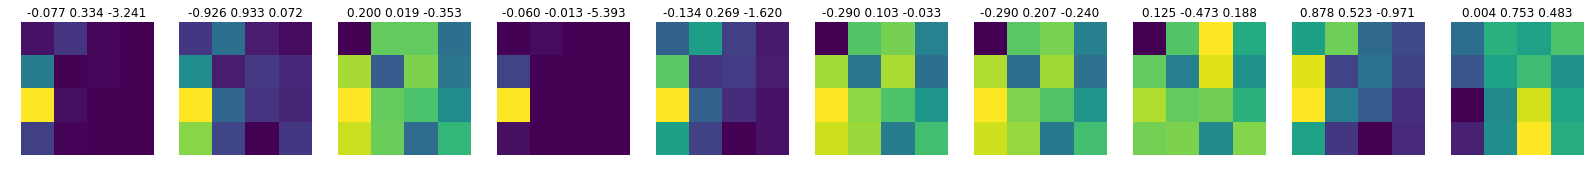

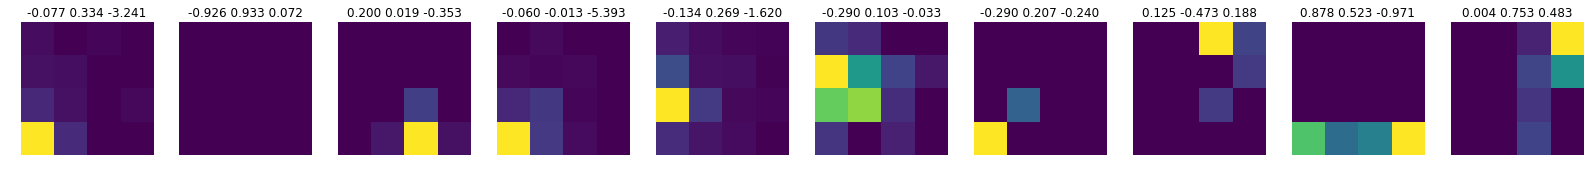

Train loss: 0.44562914331642417 Batch 2000 of 500           epoch: 45
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4255) tensor(3.5489e-08, grad_fn=<SumBackward0>) tensor(93.5208, grad_fn=<AbsBackward>) tensor(-157.7078, grad_fn=<SumBackward0>)


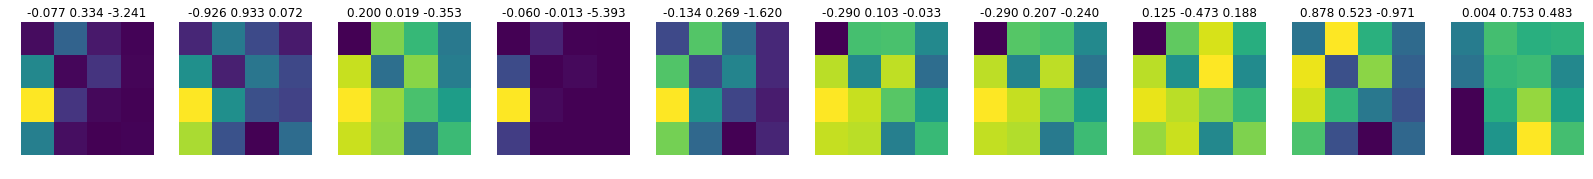

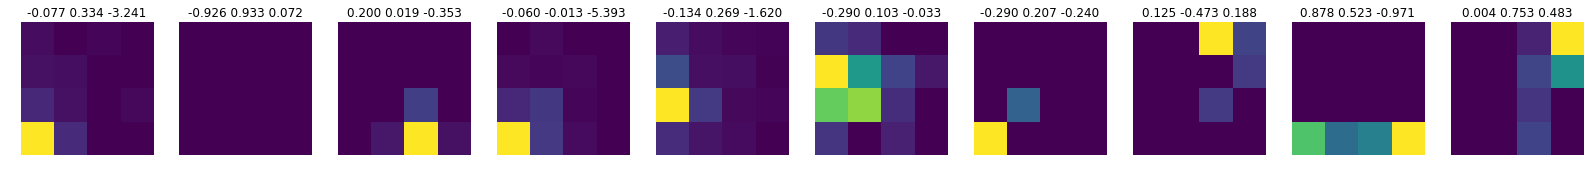

Train loss: 0.4267643034363572 Batch 2000 of 500           epoch: 46
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4270) tensor(1.2300e-07, grad_fn=<SumBackward0>) tensor(91.8723, grad_fn=<AbsBackward>) tensor(-198.8696, grad_fn=<SumBackward0>)


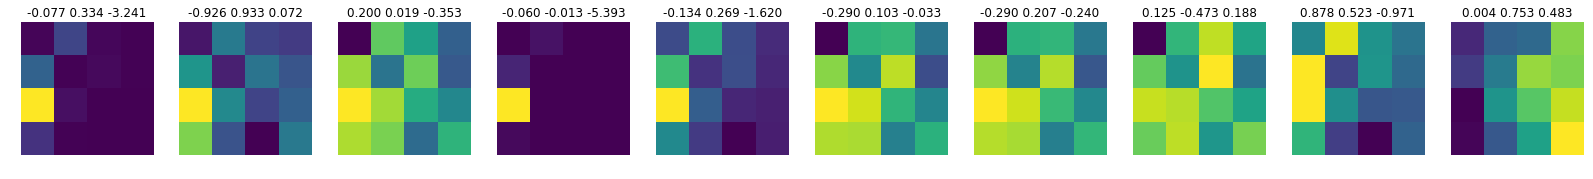

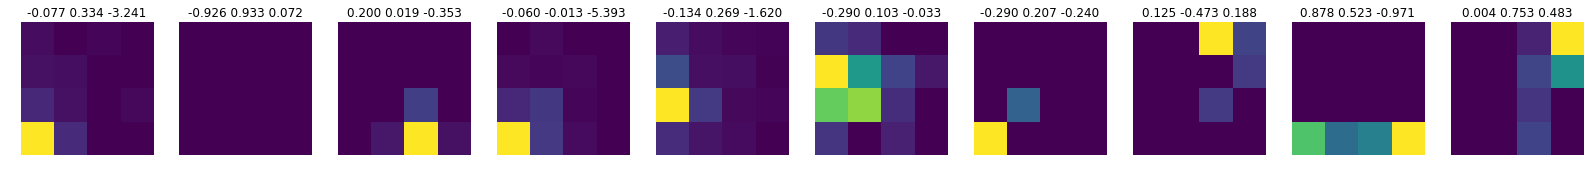

Train loss: 0.42040086813615174 Batch 2000 of 500           epoch: 47
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4331) tensor(1.2355e-07, grad_fn=<SumBackward0>) tensor(101.0432, grad_fn=<AbsBackward>) tensor(-271.7446, grad_fn=<SumBackward0>)


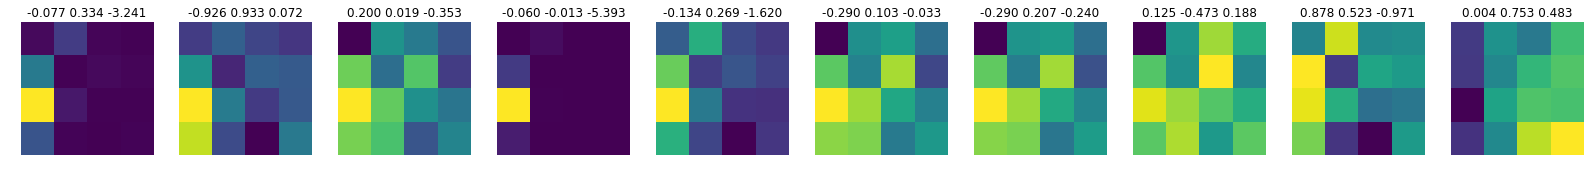

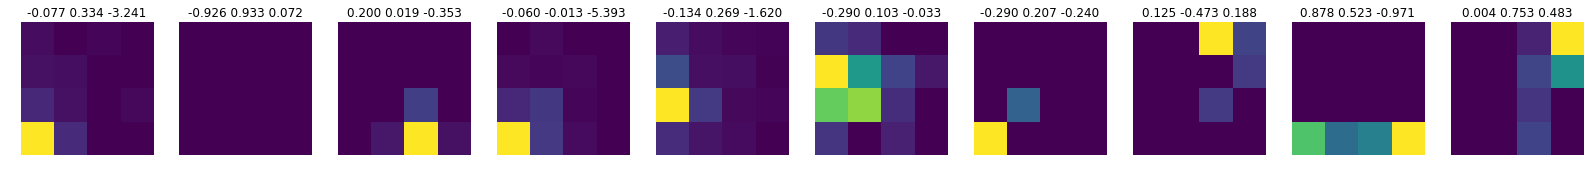

Train loss: 0.4332378854078192 Batch 2000 of 500           epoch: 48
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3342) tensor(2.6483e-08, grad_fn=<SumBackward0>) tensor(70.6183, grad_fn=<AbsBackward>) tensor(-106.3089, grad_fn=<SumBackward0>)


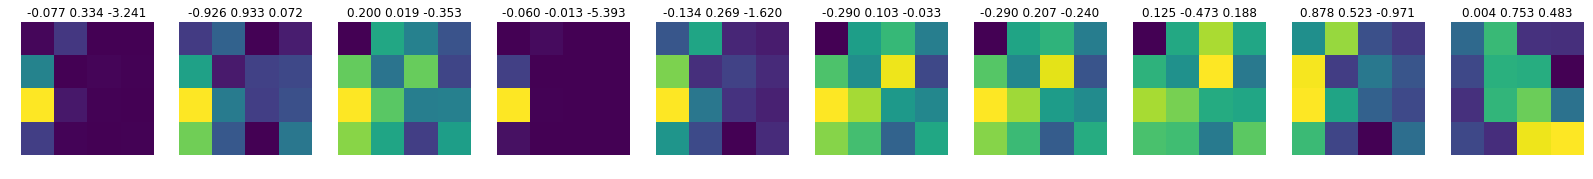

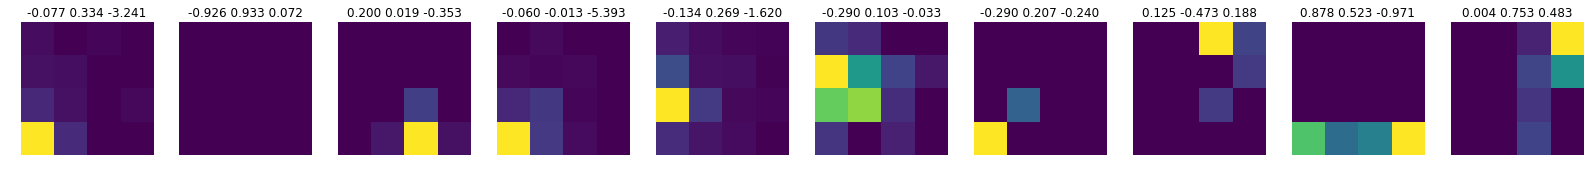

Train loss: 0.33050458899270385 Batch 2000 of 500           epoch: 49
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4207) tensor(2.5011e-09, grad_fn=<SumBackward0>) tensor(102.3027, grad_fn=<AbsBackward>) tensor(-157.7454, grad_fn=<SumBackward0>)


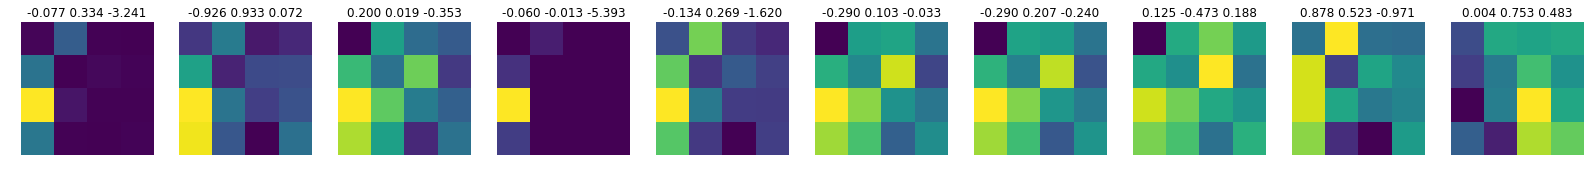

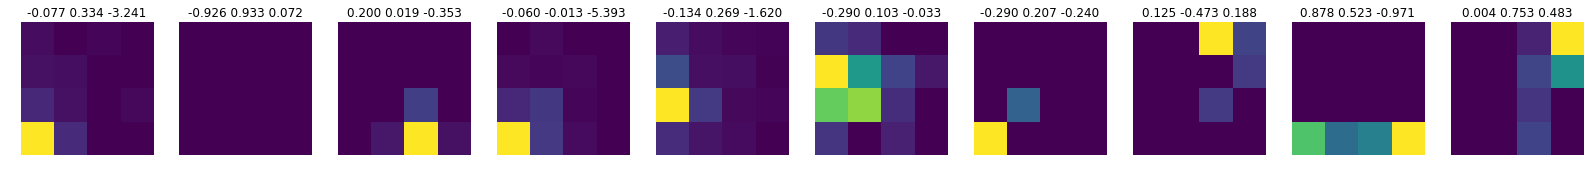

Train loss: 0.4196645965030178 Batch 2000 of 500           epoch: 50
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3508) tensor(1.6610e-08, grad_fn=<SumBackward0>) tensor(87.9779, grad_fn=<AbsBackward>) tensor(-125.5125, grad_fn=<SumBackward0>)


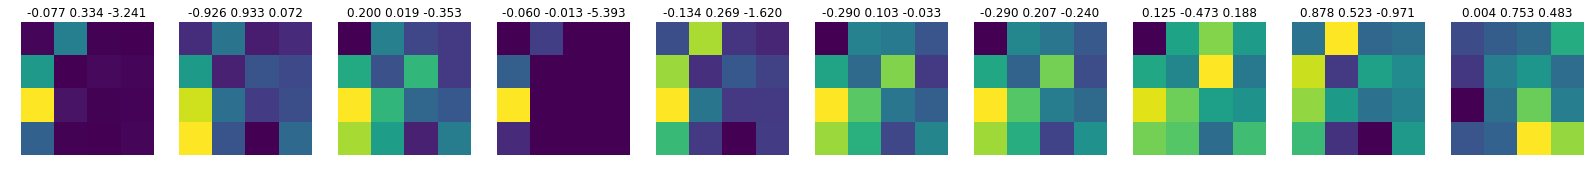

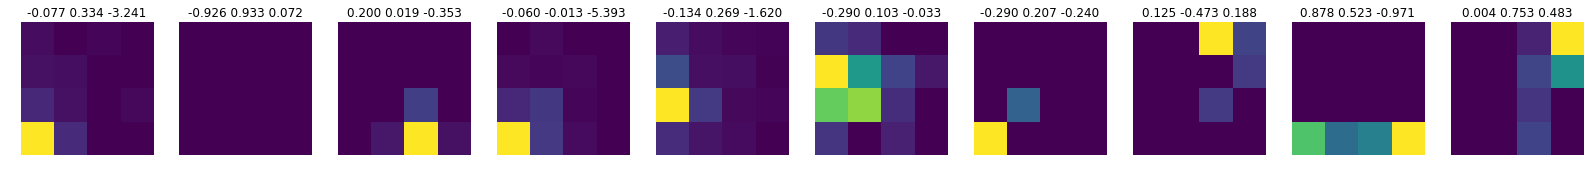

Train loss: 0.35013326062600786 Batch 2000 of 500           epoch: 51
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4332) tensor(1.8237e-08, grad_fn=<SumBackward0>) tensor(106.4826, grad_fn=<AbsBackward>) tensor(-182.6088, grad_fn=<SumBackward0>)


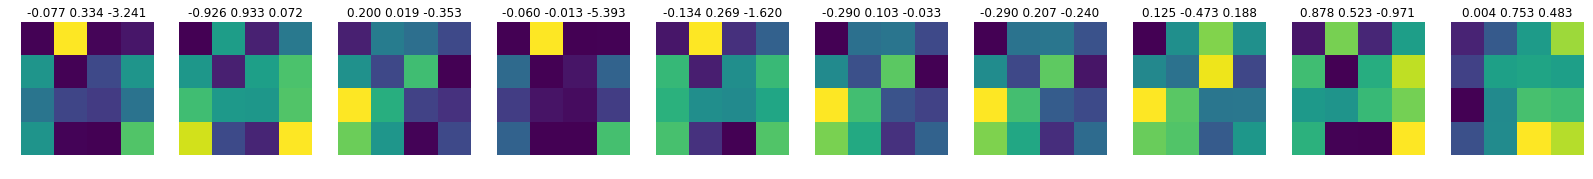

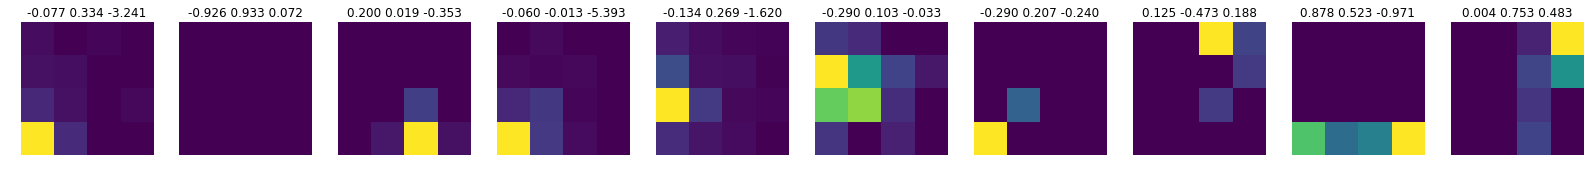

Train loss: 0.4308883255073294 Batch 2000 of 500           epoch: 52
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3728) tensor(4.3241e-08, grad_fn=<SumBackward0>) tensor(78.6228, grad_fn=<AbsBackward>) tensor(-166.7855, grad_fn=<SumBackward0>)


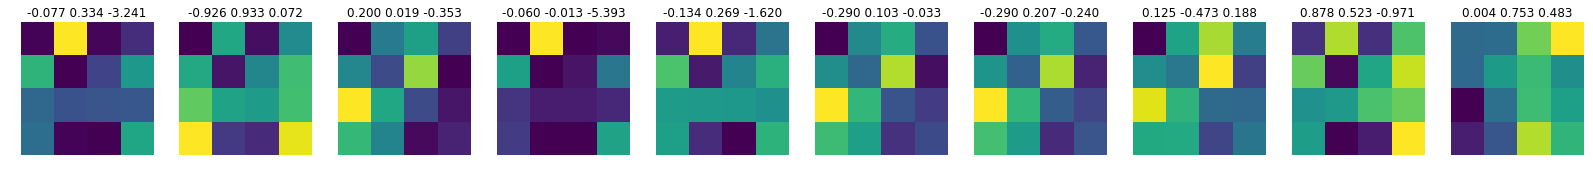

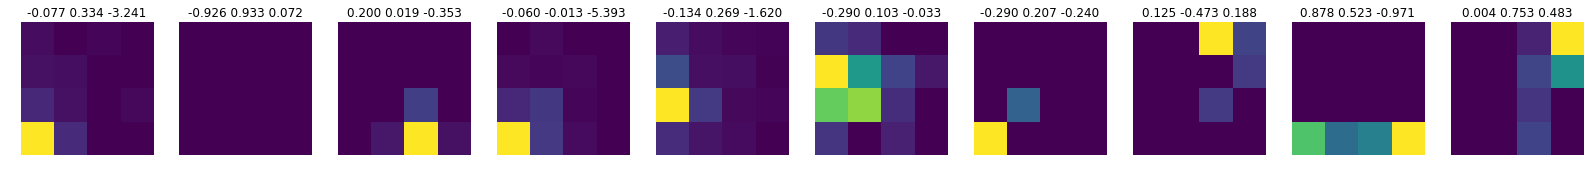

Train loss: 0.36945685090891744 Batch 2000 of 500           epoch: 53
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3003) tensor(3.2961e-08, grad_fn=<SumBackward0>) tensor(56.1220, grad_fn=<AbsBackward>) tensor(-92.7386, grad_fn=<SumBackward0>)


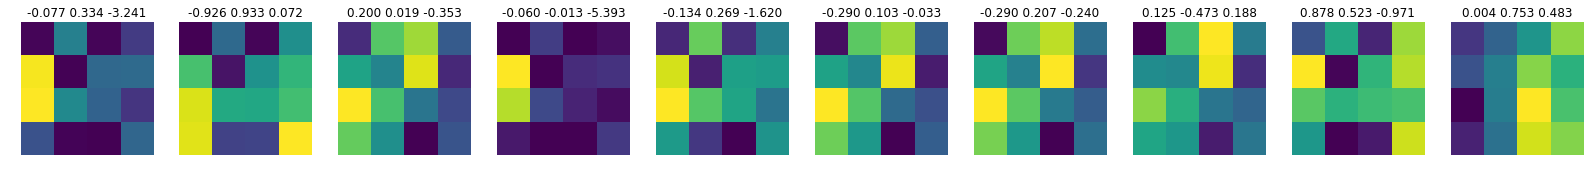

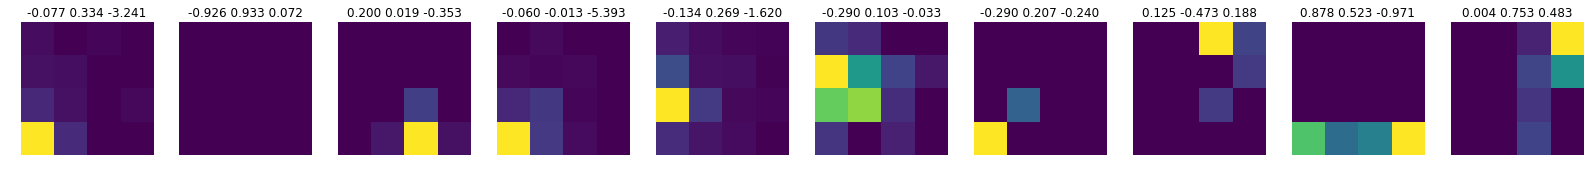

Train loss: 0.2991391240827594 Batch 2000 of 500           epoch: 54
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4185) tensor(6.5774e-08, grad_fn=<SumBackward0>) tensor(96.9137, grad_fn=<AbsBackward>) tensor(-248.2449, grad_fn=<SumBackward0>)


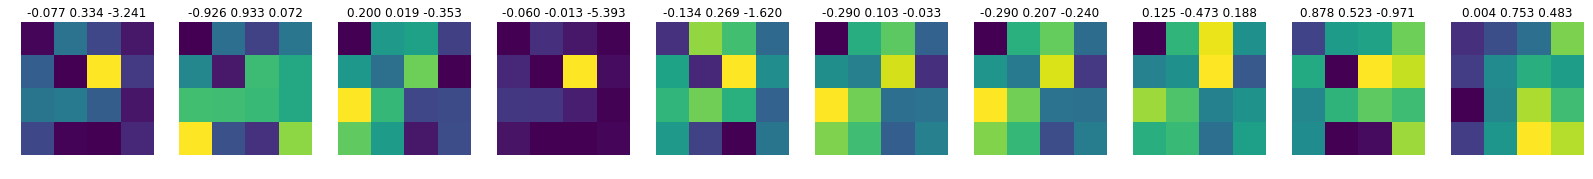

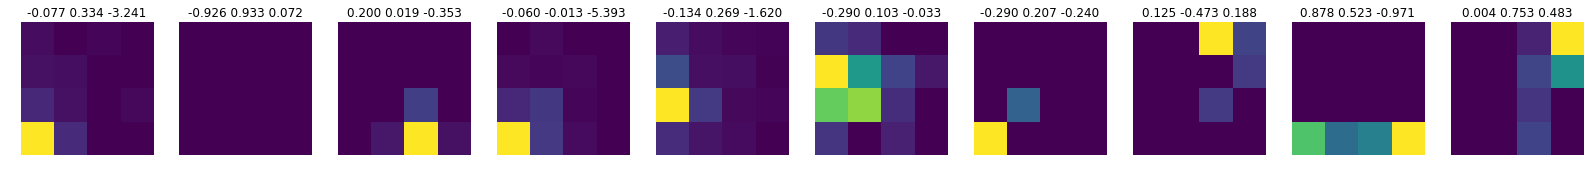

Train loss: 0.4178081140619758 Batch 2000 of 500           epoch: 55
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2884) tensor(1.2254e-07, grad_fn=<SumBackward0>) tensor(46.8811, grad_fn=<AbsBackward>) tensor(-87.5504, grad_fn=<SumBackward0>)


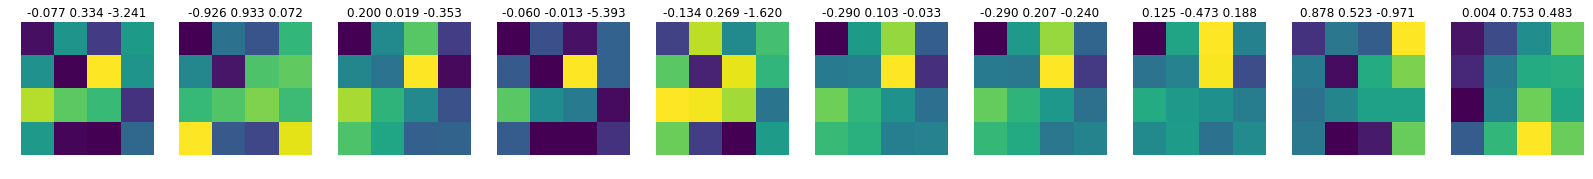

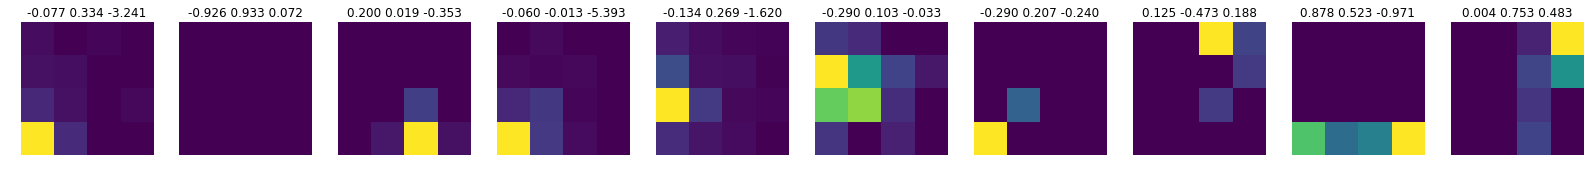

Train loss: 0.28851617953488234 Batch 2000 of 500           epoch: 56
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.1325) tensor(5.1093e-08, grad_fn=<SumBackward0>) tensor(8.5793, grad_fn=<AbsBackward>) tensor(-17.3900, grad_fn=<SumBackward0>)


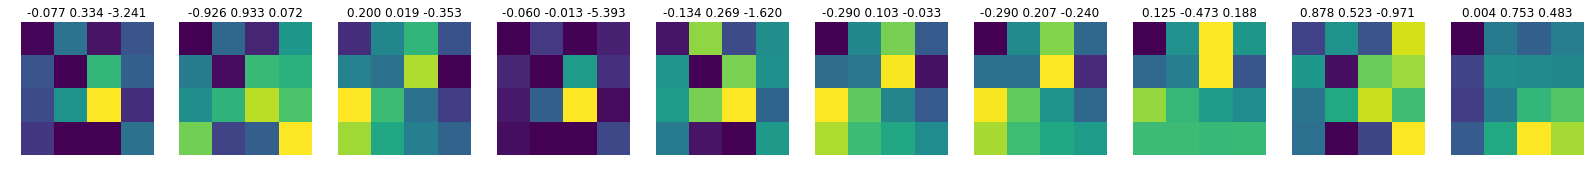

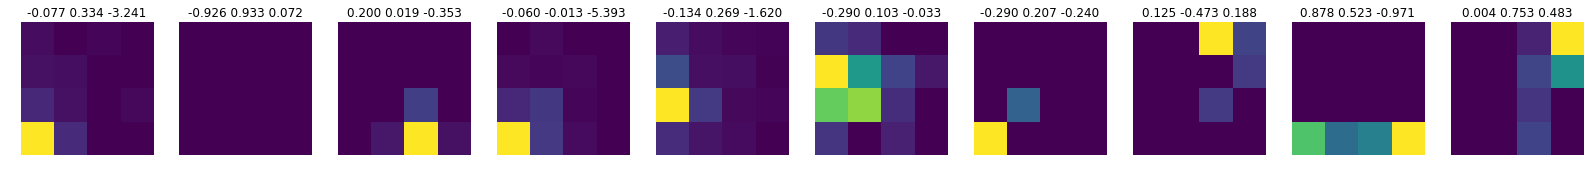

Train loss: 0.13438433140347278 Batch 2000 of 500           epoch: 57
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2704) tensor(2.4648e-09, grad_fn=<SumBackward0>) tensor(50.2342, grad_fn=<AbsBackward>) tensor(-72.0386, grad_fn=<SumBackward0>)


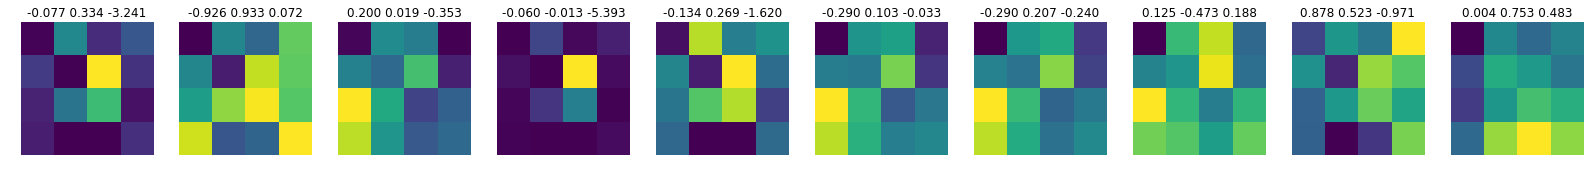

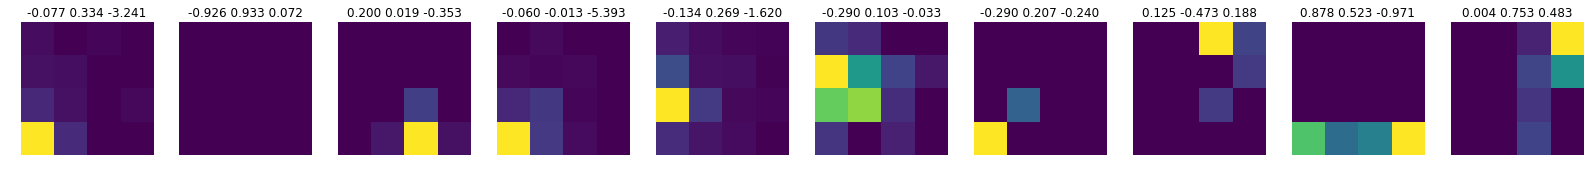

Train loss: 0.26975626640590045 Batch 2000 of 500           epoch: 58
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4793) tensor(4.8836e-08, grad_fn=<SumBackward0>) tensor(122.3376, grad_fn=<AbsBackward>) tensor(-256.2706, grad_fn=<SumBackward0>)


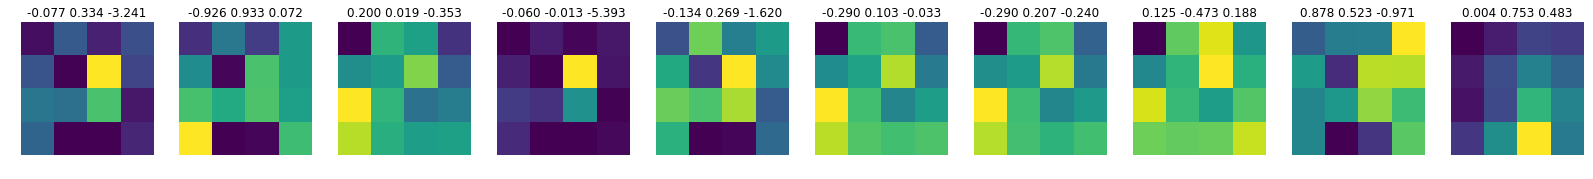

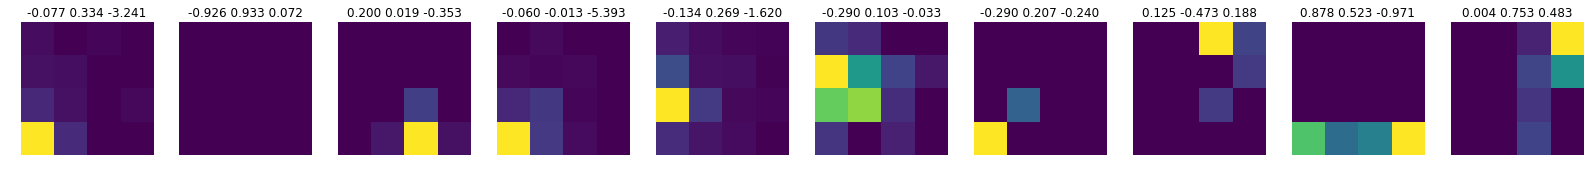

Train loss: 0.47851011310978564 Batch 2000 of 500           epoch: 59
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3481) tensor(3.7757e-07, grad_fn=<SumBackward0>) tensor(71.2633, grad_fn=<AbsBackward>) tensor(-121.2937, grad_fn=<SumBackward0>)


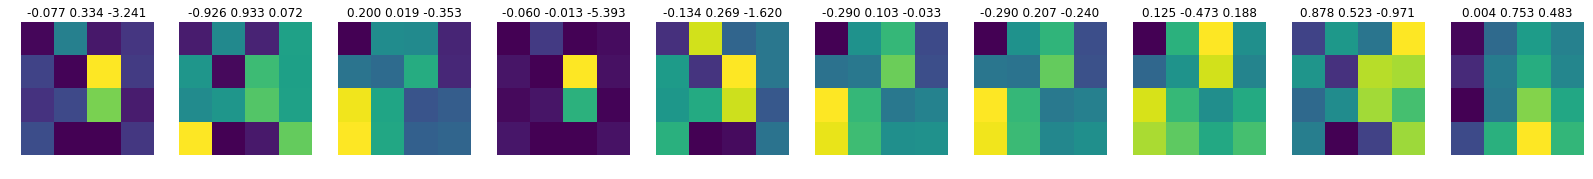

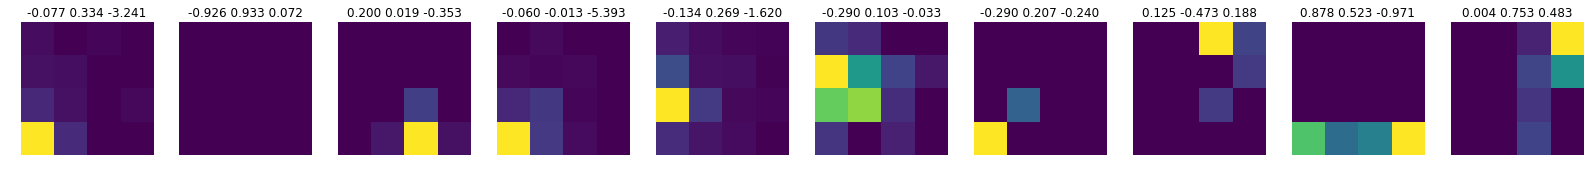

Train loss: 0.3455060200710096 Batch 2000 of 500           epoch: 60
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3676) tensor(1.4301e-07, grad_fn=<SumBackward0>) tensor(89.5966, grad_fn=<AbsBackward>) tensor(-129.0648, grad_fn=<SumBackward0>)


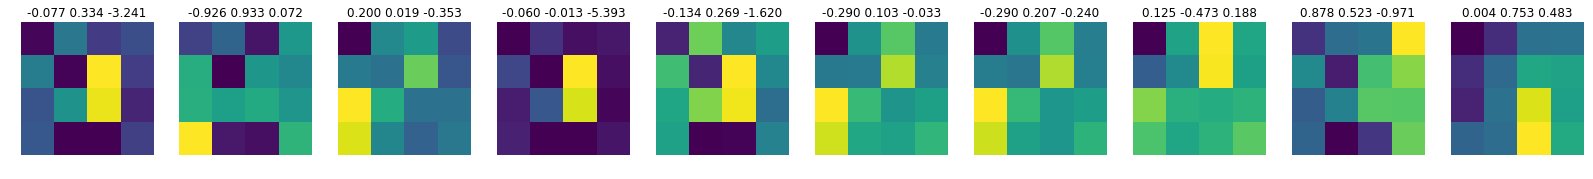

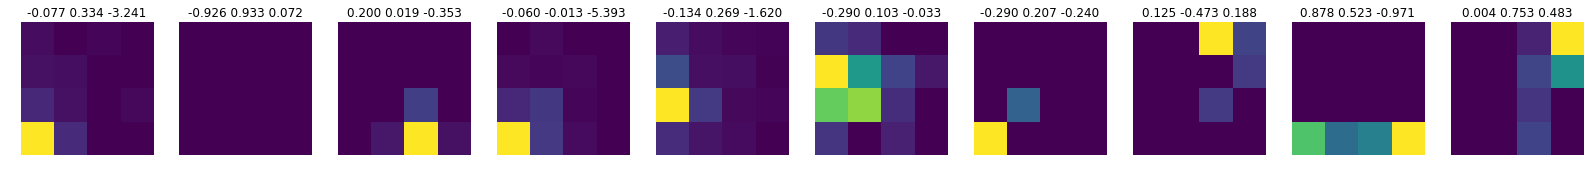

Train loss: 0.37626499218401904 Batch 2000 of 500           epoch: 61
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4205) tensor(2.5540e-07, grad_fn=<SumBackward0>) tensor(99.6595, grad_fn=<AbsBackward>) tensor(-176.8770, grad_fn=<SumBackward0>)


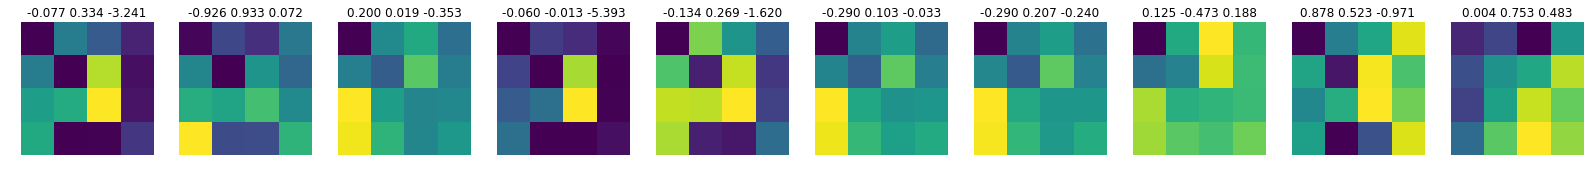

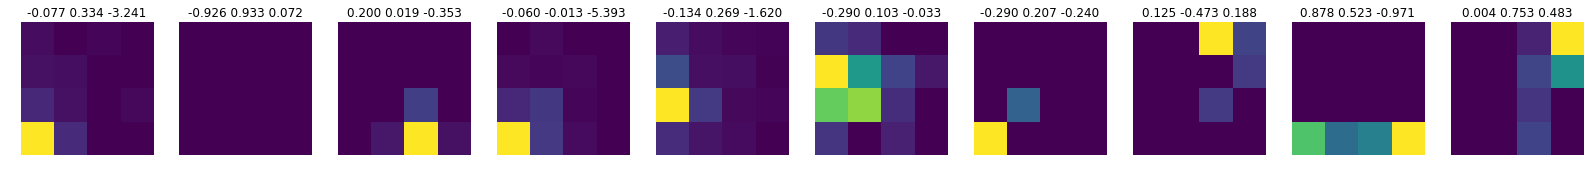

Train loss: 0.41951646510686125 Batch 2000 of 500           epoch: 62
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4069) tensor(3.1339e-08, grad_fn=<SumBackward0>) tensor(88.8968, grad_fn=<AbsBackward>) tensor(-142.8121, grad_fn=<SumBackward0>)


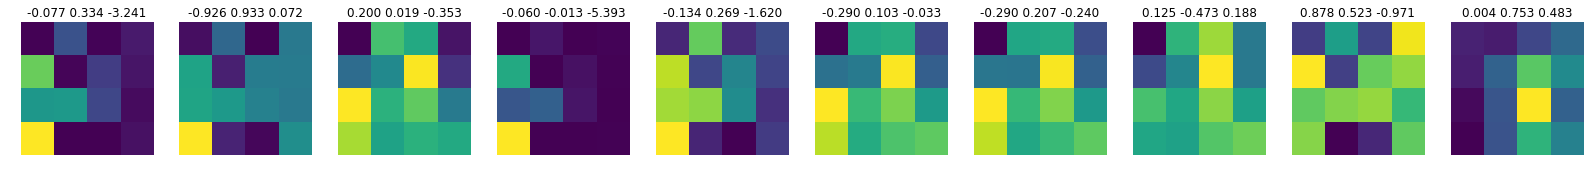

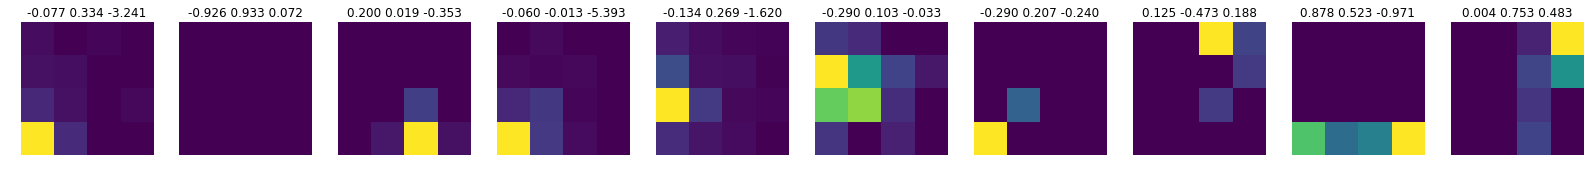

Train loss: 0.4067647521683619 Batch 2000 of 500           epoch: 63
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3274) tensor(1.0133e-07, grad_fn=<SumBackward0>) tensor(65.1690, grad_fn=<AbsBackward>) tensor(-103.3735, grad_fn=<SumBackward0>)


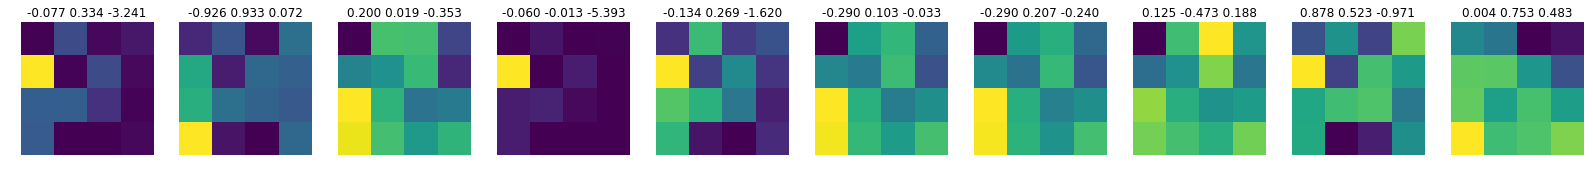

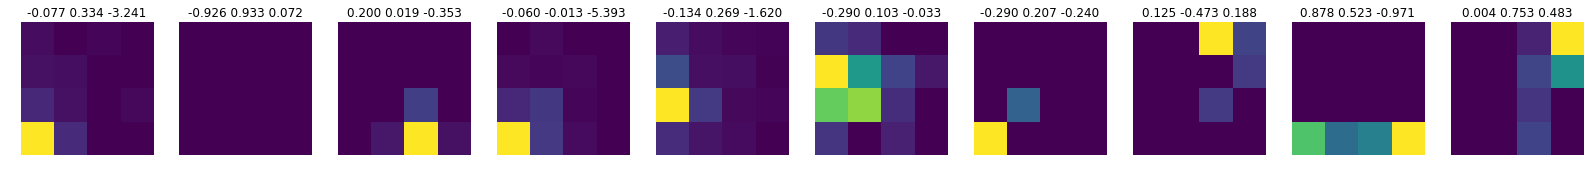

Train loss: 0.3274961401148956 Batch 2000 of 500           epoch: 64
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4308) tensor(1.6070e-07, grad_fn=<SumBackward0>) tensor(97.1788, grad_fn=<AbsBackward>) tensor(-289.0782, grad_fn=<SumBackward0>)


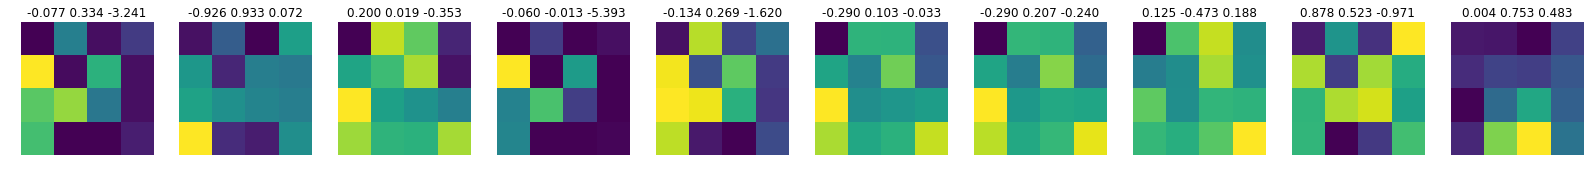

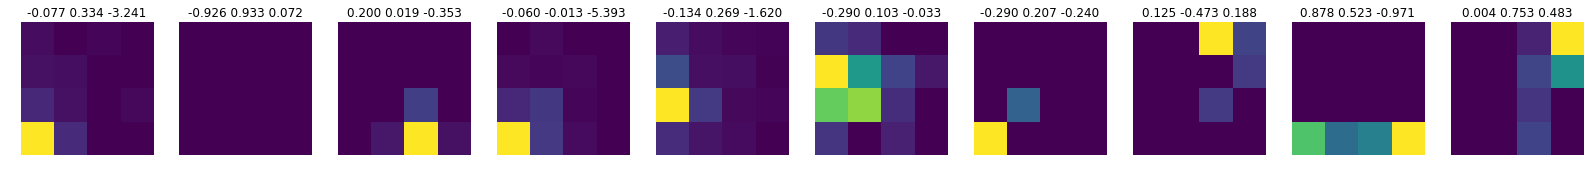

Train loss: 0.42953449544436445 Batch 2000 of 500           epoch: 65
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4686) tensor(6.1126e-08, grad_fn=<SumBackward0>) tensor(124.7555, grad_fn=<AbsBackward>) tensor(-286.7804, grad_fn=<SumBackward0>)


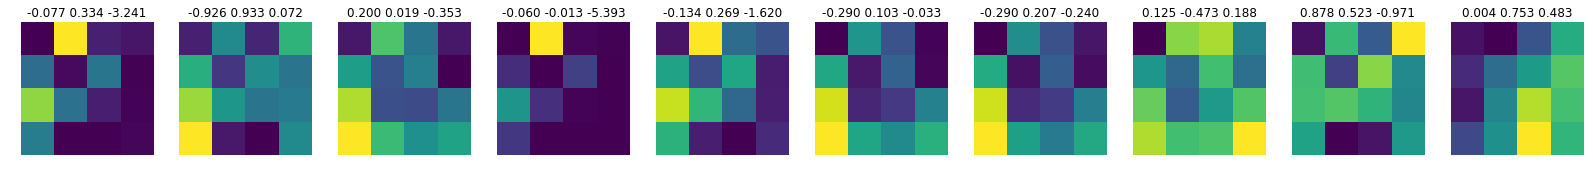

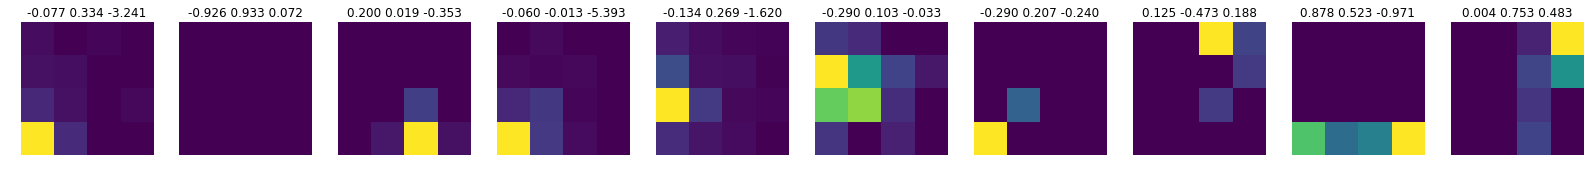

Train loss: 0.4706944141186718 Batch 2000 of 500           epoch: 66
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4083) tensor(1.0100e-08, grad_fn=<SumBackward0>) tensor(81.8133, grad_fn=<AbsBackward>) tensor(-261.6817, grad_fn=<SumBackward0>)


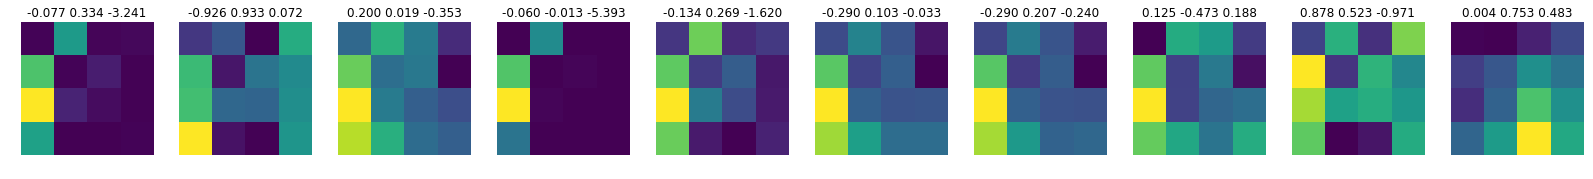

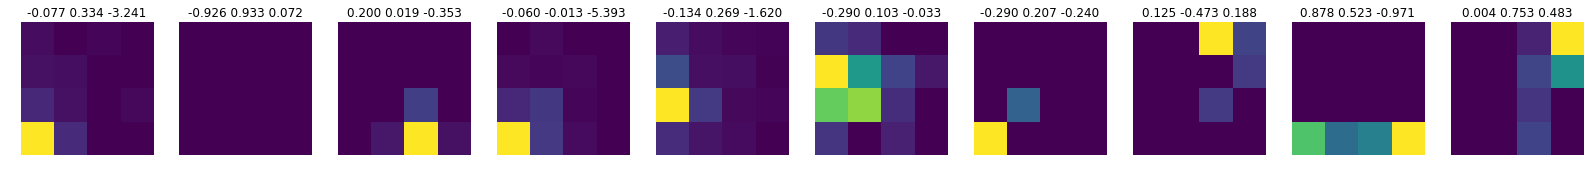

Train loss: 0.4088387678433967 Batch 2000 of 500           epoch: 67
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3908) tensor(4.1932e-09, grad_fn=<SumBackward0>) tensor(92.0748, grad_fn=<AbsBackward>) tensor(-182.7860, grad_fn=<SumBackward0>)


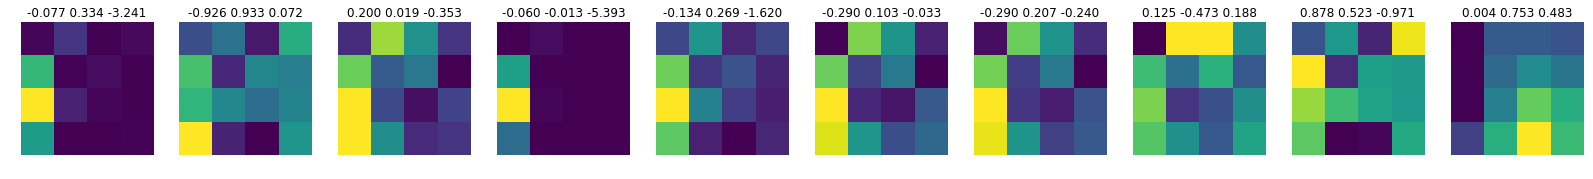

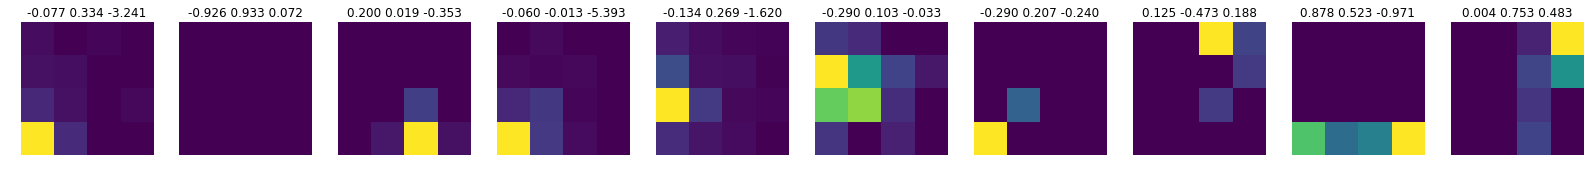

Train loss: 0.3882813704829686 Batch 2000 of 500           epoch: 68
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2027) tensor(3.8750e-08, grad_fn=<SumBackward0>) tensor(23.9748, grad_fn=<AbsBackward>) tensor(-57.6922, grad_fn=<SumBackward0>)


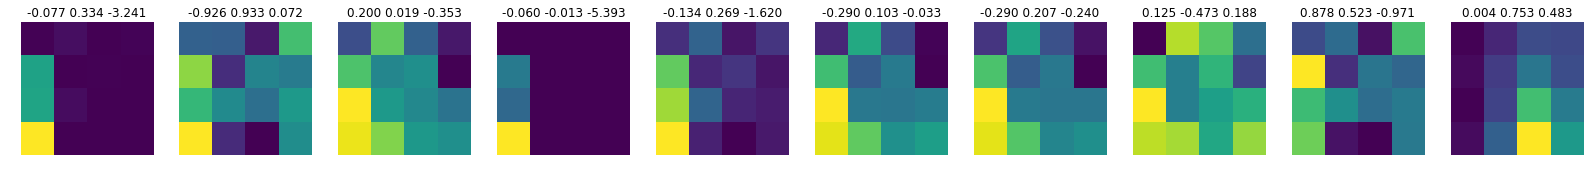

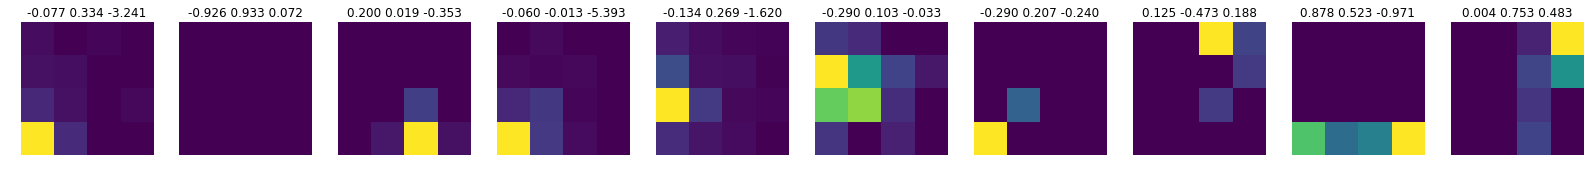

Train loss: 0.20287039549534033 Batch 2000 of 500           epoch: 69
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2767) tensor(2.5581e-07, grad_fn=<SumBackward0>) tensor(43.2047, grad_fn=<AbsBackward>) tensor(-87.6588, grad_fn=<SumBackward0>)


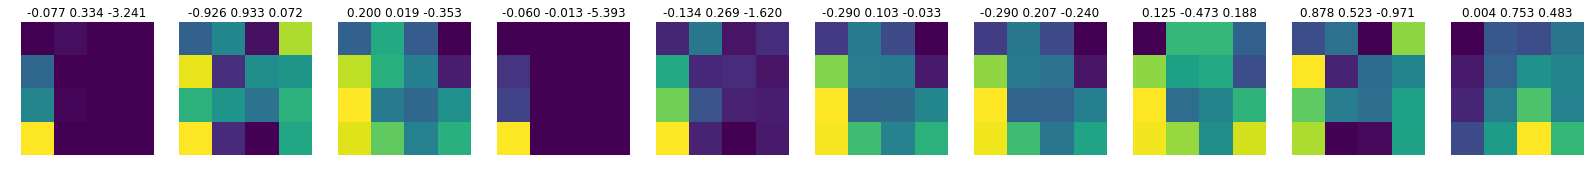

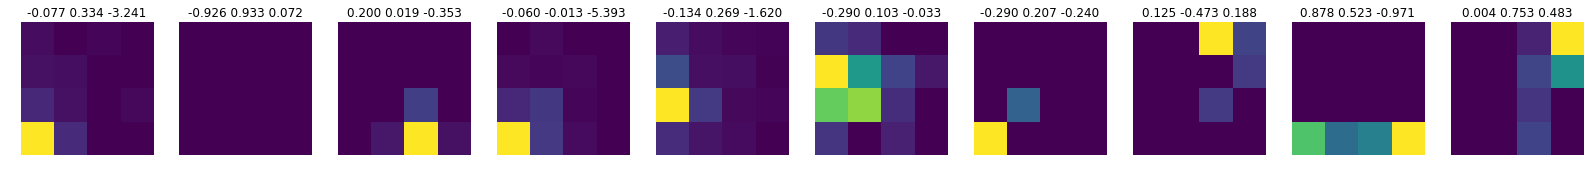

Train loss: 0.27791562991212937 Batch 2000 of 500           epoch: 70
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4729) tensor(1.7185e-07, grad_fn=<SumBackward0>) tensor(113.7402, grad_fn=<AbsBackward>) tensor(-229.9119, grad_fn=<SumBackward0>)


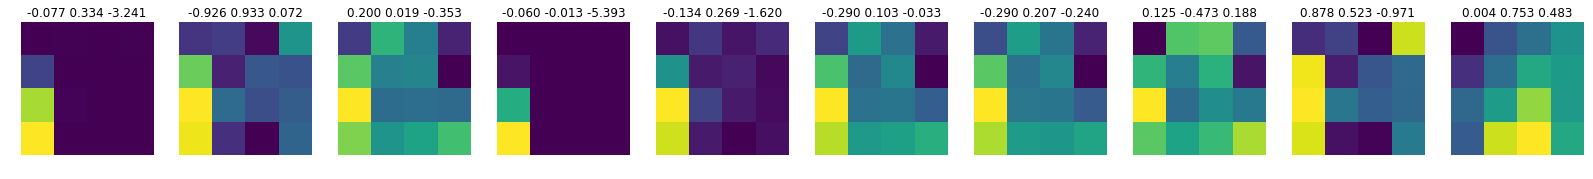

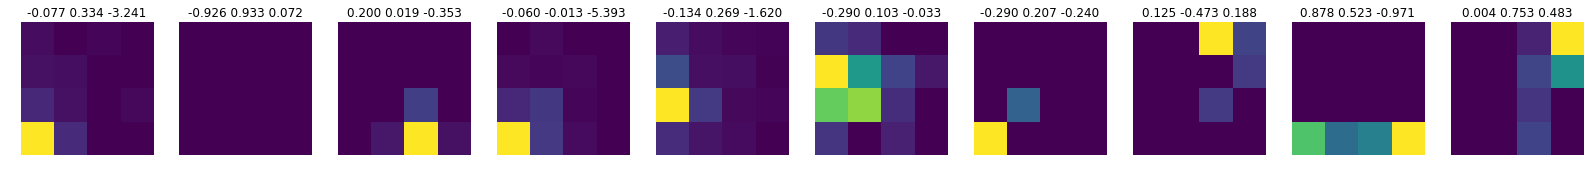

Train loss: 0.47259075765784314 Batch 2000 of 500           epoch: 71
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2048) tensor(3.5639e-08, grad_fn=<SumBackward0>) tensor(35.0016, grad_fn=<AbsBackward>) tensor(-52.9482, grad_fn=<SumBackward0>)


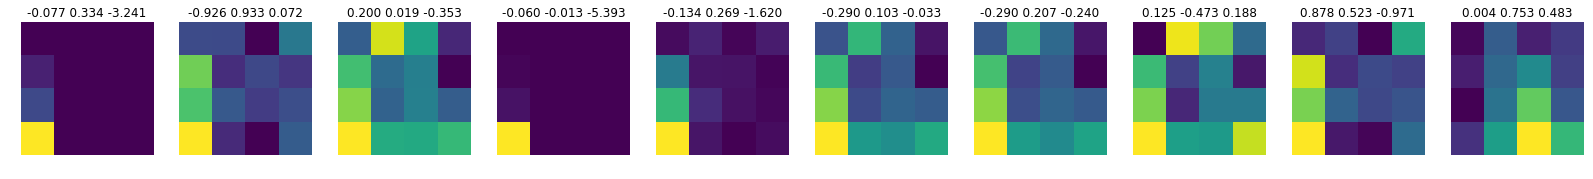

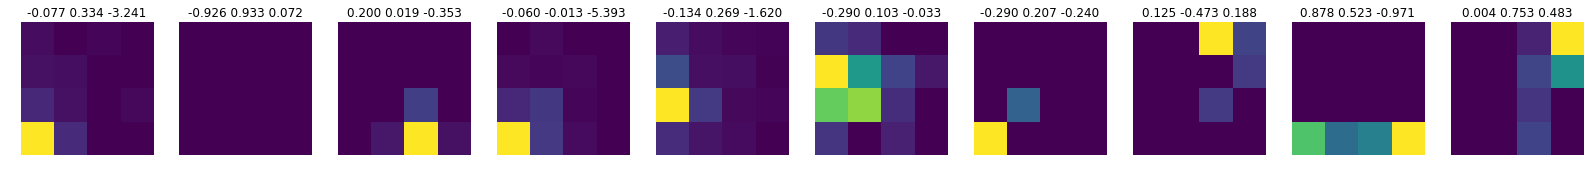

Train loss: 0.20420710412855264 Batch 2000 of 500           epoch: 72
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4375) tensor(6.4748e-08, grad_fn=<SumBackward0>) tensor(99.1081, grad_fn=<AbsBackward>) tensor(-175.9946, grad_fn=<SumBackward0>)


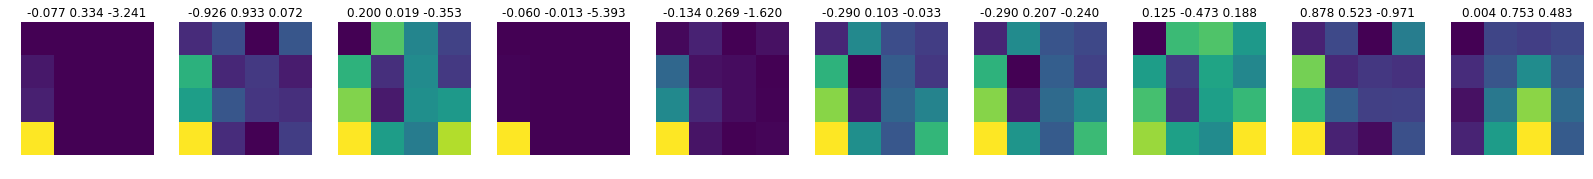

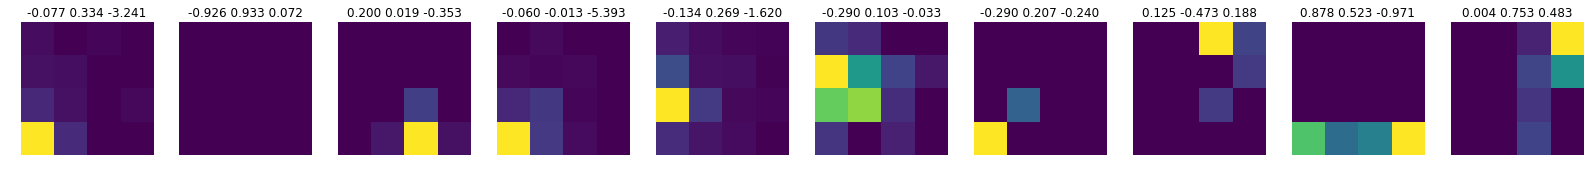

Train loss: 0.4400340167167112 Batch 2000 of 500           epoch: 73
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2478) tensor(3.0770e-07, grad_fn=<SumBackward0>) tensor(36.2792, grad_fn=<AbsBackward>) tensor(-52.2572, grad_fn=<SumBackward0>)


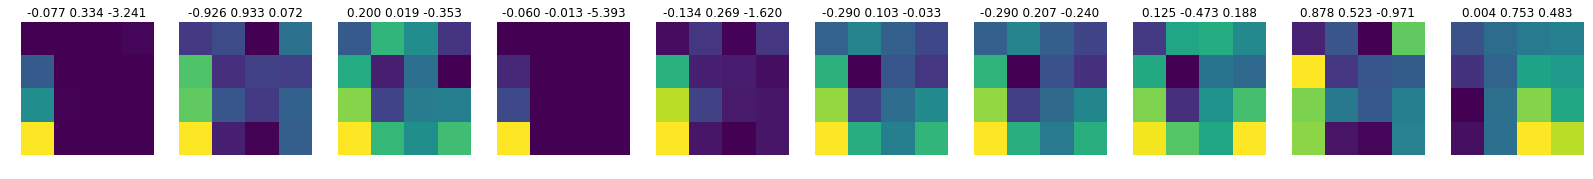

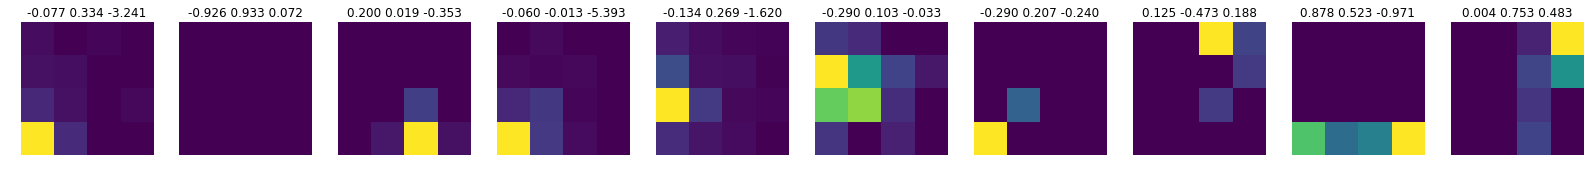

Train loss: 0.23063881805993525 Batch 2000 of 500           epoch: 74
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.5158) tensor(1.0971e-09, grad_fn=<SumBackward0>) tensor(133.2765, grad_fn=<AbsBackward>) tensor(-316.5554, grad_fn=<SumBackward0>)


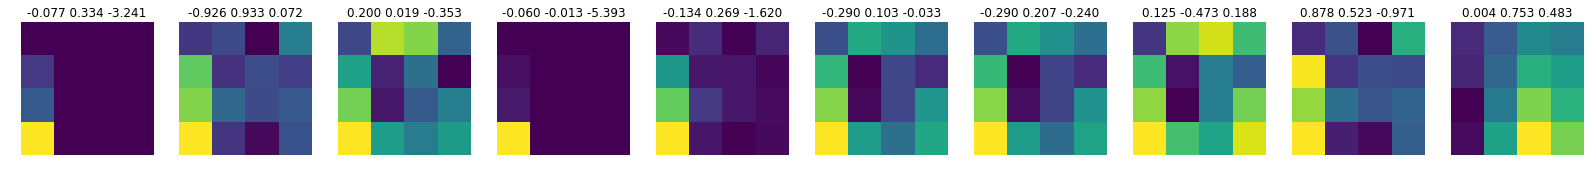

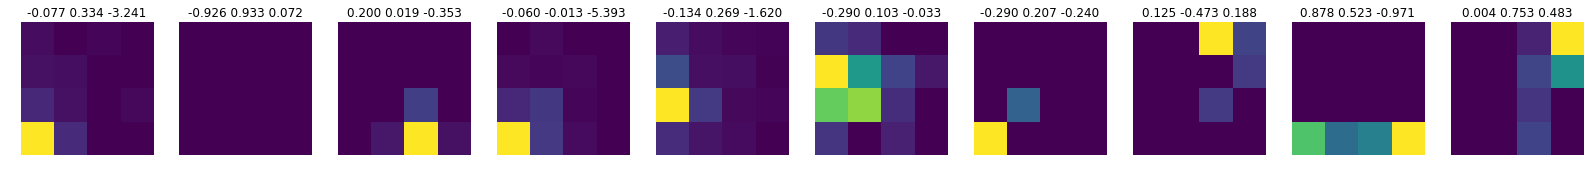

Train loss: 0.5158303163268249 Batch 2000 of 500           epoch: 75
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3441) tensor(1.9166e-08, grad_fn=<SumBackward0>) tensor(71.1561, grad_fn=<AbsBackward>) tensor(-105.9181, grad_fn=<SumBackward0>)


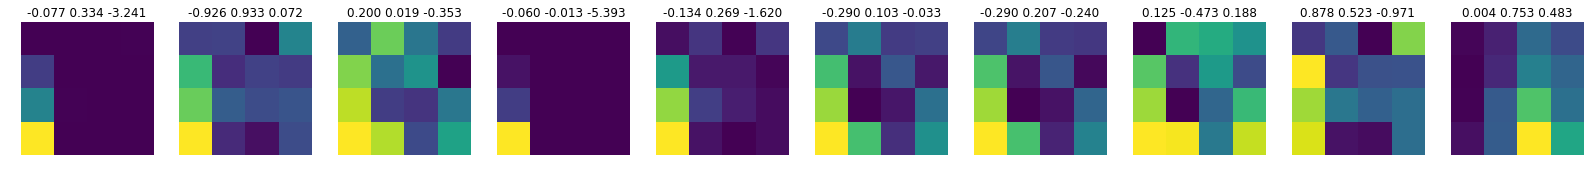

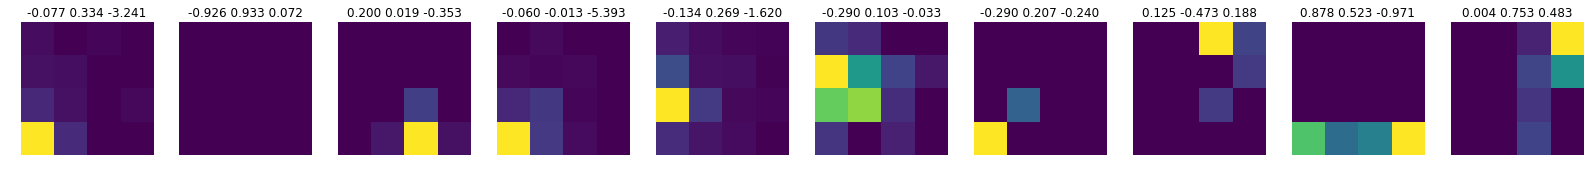

Train loss: 0.3483512208587468 Batch 2000 of 500           epoch: 76
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4064) tensor(3.1671e-08, grad_fn=<SumBackward0>) tensor(95.6988, grad_fn=<AbsBackward>) tensor(-215.1217, grad_fn=<SumBackward0>)


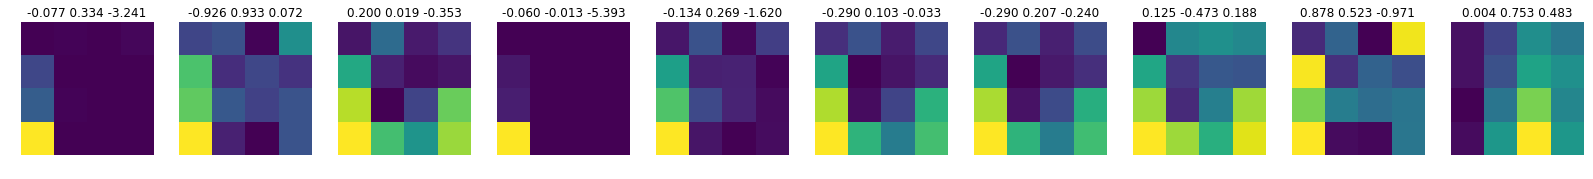

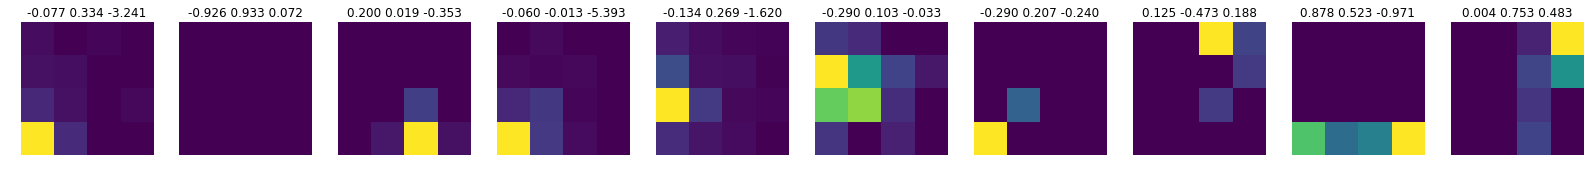

Train loss: 0.39759878043805574 Batch 2000 of 500           epoch: 77
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4091) tensor(5.6700e-08, grad_fn=<SumBackward0>) tensor(95.0648, grad_fn=<AbsBackward>) tensor(-156.1442, grad_fn=<SumBackward0>)


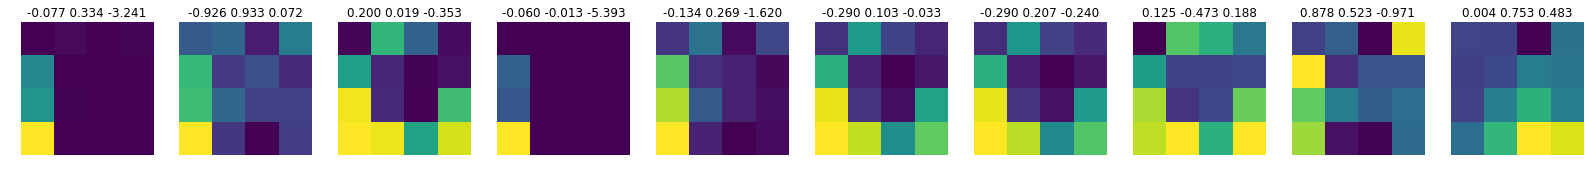

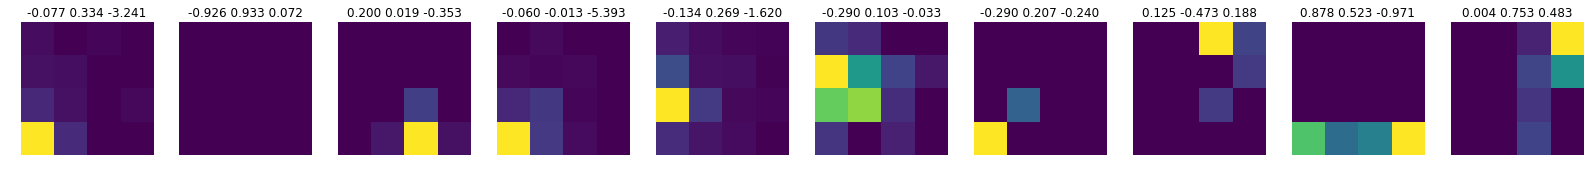

Train loss: 0.4083816942355449 Batch 2000 of 500           epoch: 78
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3415) tensor(1.6896e-07, grad_fn=<SumBackward0>) tensor(78.8754, grad_fn=<AbsBackward>) tensor(-189.1702, grad_fn=<SumBackward0>)


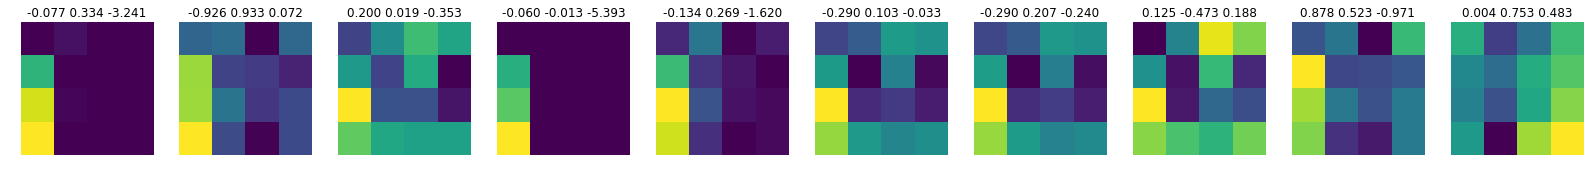

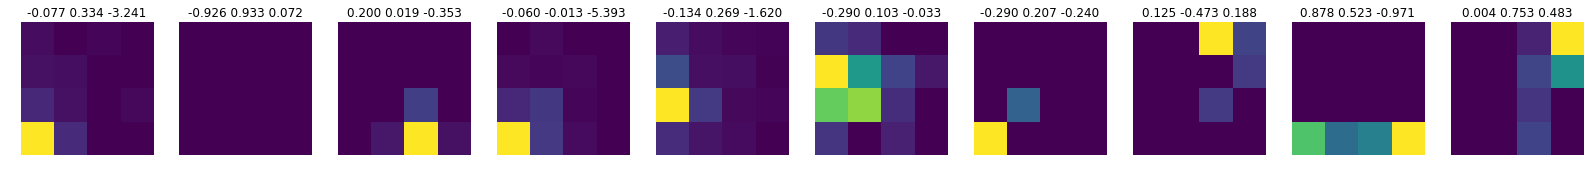

Train loss: 0.34250629198256416 Batch 2000 of 500           epoch: 79
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4001) tensor(1.8645e-08, grad_fn=<SumBackward0>) tensor(84.3773, grad_fn=<AbsBackward>) tensor(-176.6129, grad_fn=<SumBackward0>)


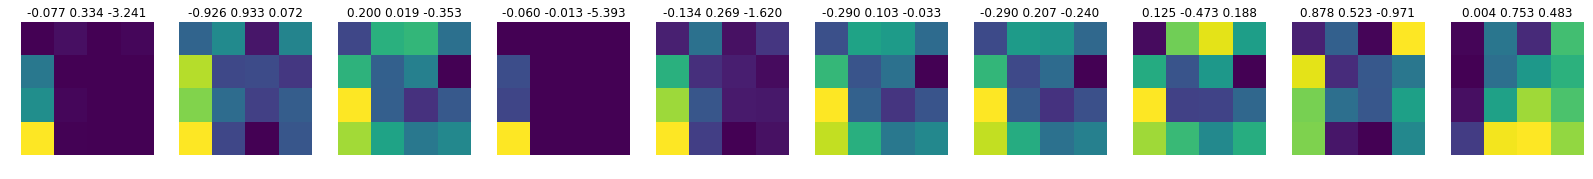

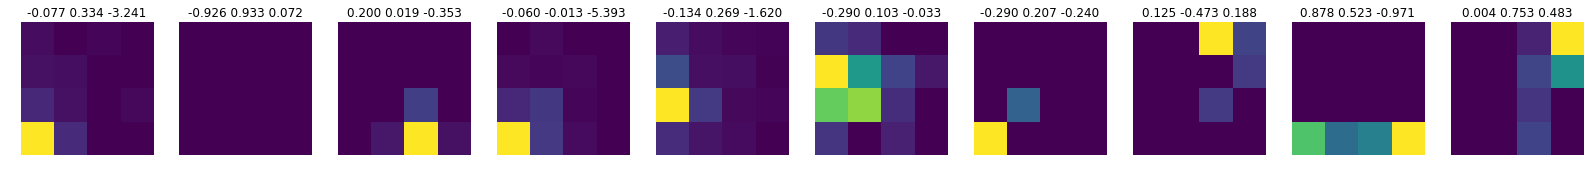

Train loss: 0.39741253274934873 Batch 2000 of 500           epoch: 80
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4784) tensor(2.5632e-09, grad_fn=<SumBackward0>) tensor(130.9180, grad_fn=<AbsBackward>) tensor(-237.3273, grad_fn=<SumBackward0>)


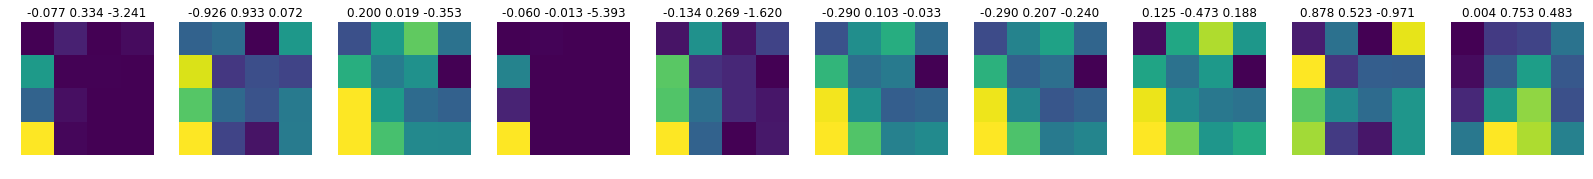

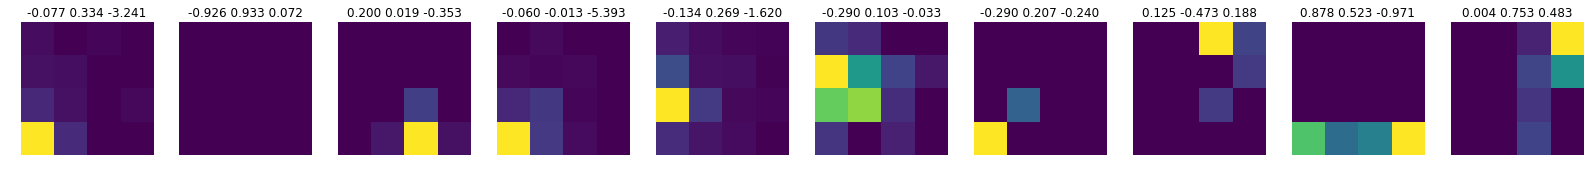

Train loss: 0.4781379986888676 Batch 2000 of 500           epoch: 81
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3378) tensor(5.7750e-09, grad_fn=<SumBackward0>) tensor(58.2250, grad_fn=<AbsBackward>) tensor(-118.9019, grad_fn=<SumBackward0>)


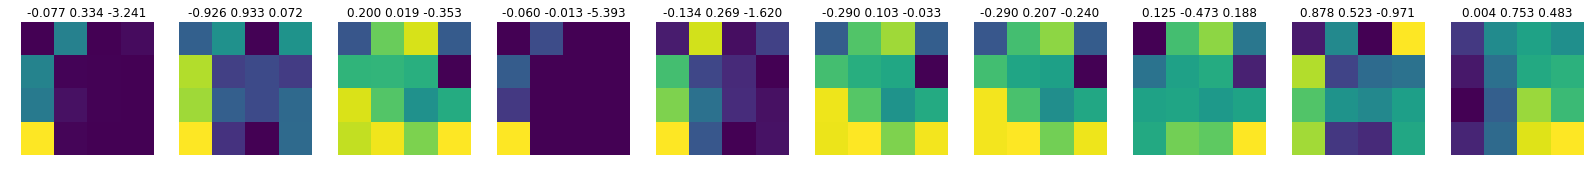

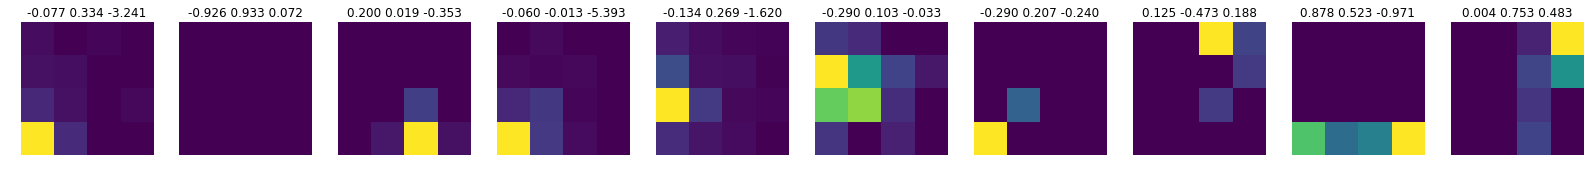

Train loss: 0.33806907145967663 Batch 2000 of 500           epoch: 82
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4525) tensor(1.1632e-07, grad_fn=<SumBackward0>) tensor(101.8114, grad_fn=<AbsBackward>) tensor(-243.9971, grad_fn=<SumBackward0>)


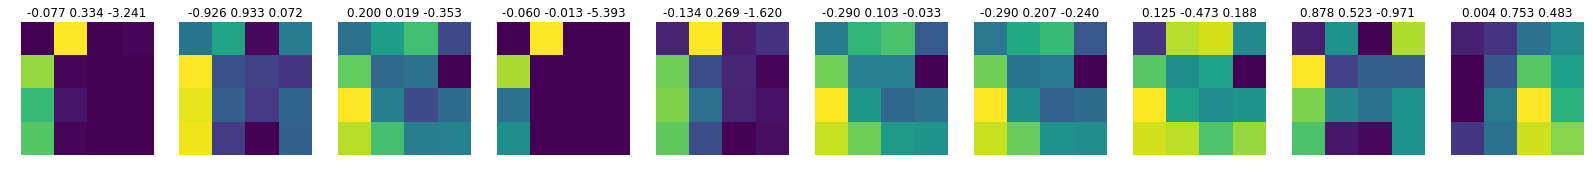

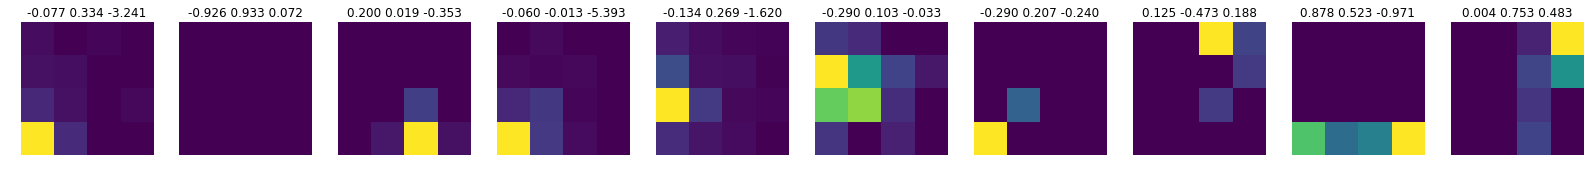

Train loss: 0.4525369258752324 Batch 2000 of 500           epoch: 83
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3162) tensor(6.9529e-08, grad_fn=<SumBackward0>) tensor(49.6252, grad_fn=<AbsBackward>) tensor(-81.8383, grad_fn=<SumBackward0>)


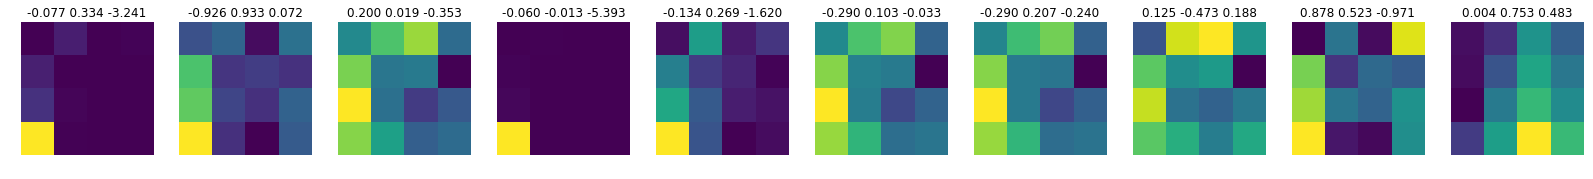

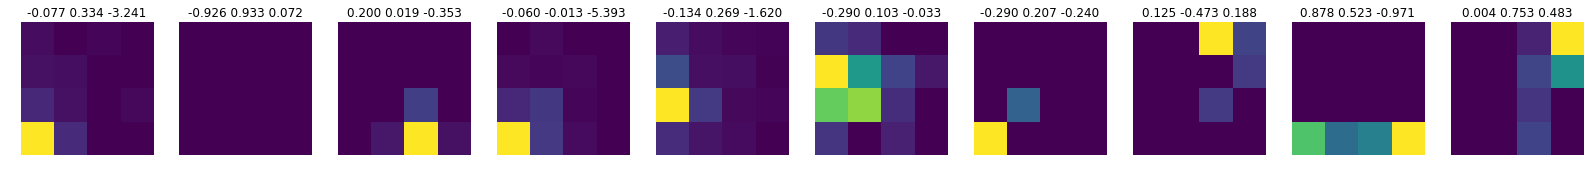

Train loss: 0.3170703569950363 Batch 2000 of 500           epoch: 84
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4094) tensor(1.5719e-09, grad_fn=<SumBackward0>) tensor(102.1000, grad_fn=<AbsBackward>) tensor(-199.2290, grad_fn=<SumBackward0>)


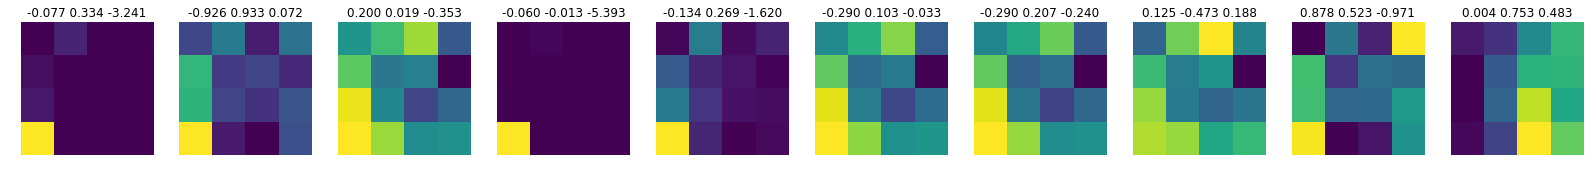

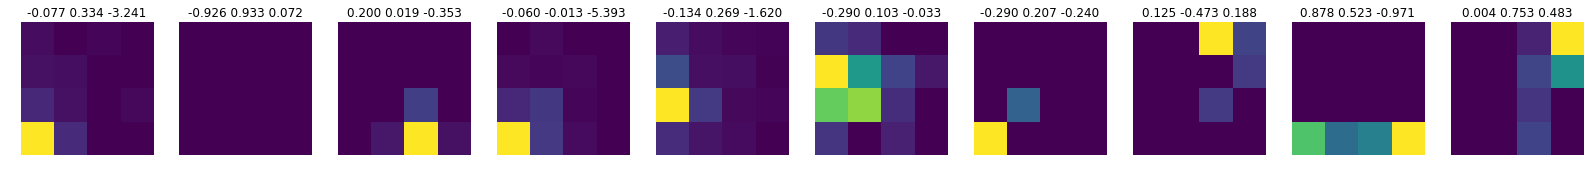

Train loss: 0.4095635276477872 Batch 2000 of 500           epoch: 85
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2553) tensor(2.9811e-07, grad_fn=<SumBackward0>) tensor(46.1257, grad_fn=<AbsBackward>) tensor(-66.7738, grad_fn=<SumBackward0>)


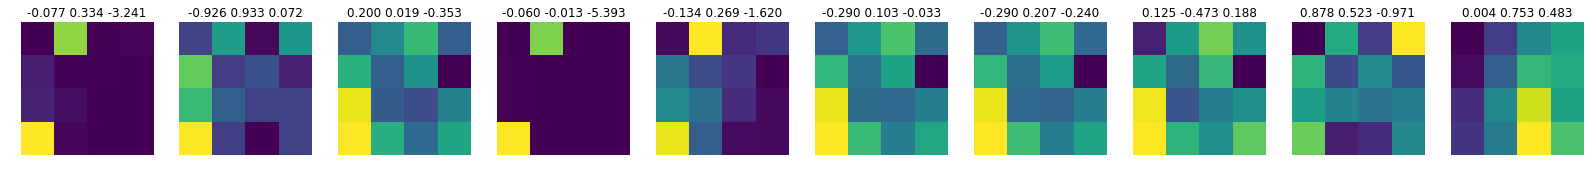

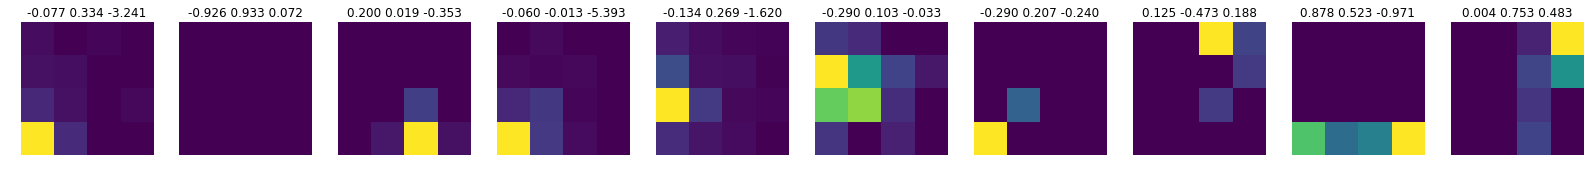

Train loss: 0.25469055518120426 Batch 2000 of 500           epoch: 86
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3799) tensor(1.6199e-07, grad_fn=<SumBackward0>) tensor(85.0311, grad_fn=<AbsBackward>) tensor(-182.2638, grad_fn=<SumBackward0>)


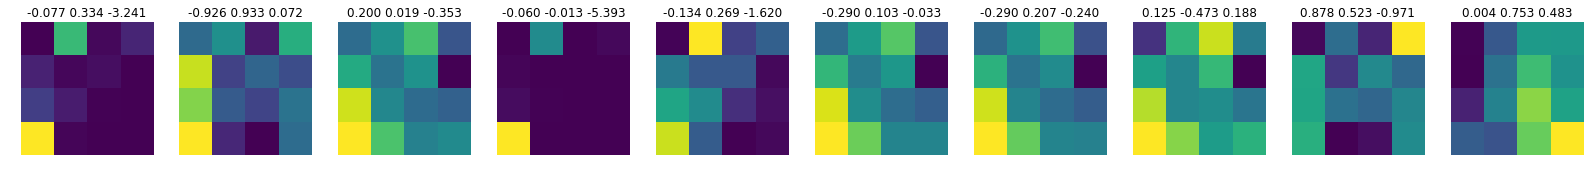

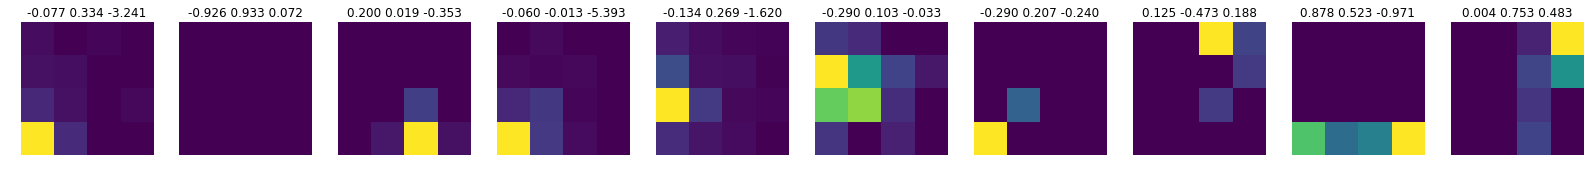

Train loss: 0.37469833828033905 Batch 2000 of 500           epoch: 87
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4242) tensor(2.8837e-09, grad_fn=<SumBackward0>) tensor(91.2121, grad_fn=<AbsBackward>) tensor(-172.0871, grad_fn=<SumBackward0>)


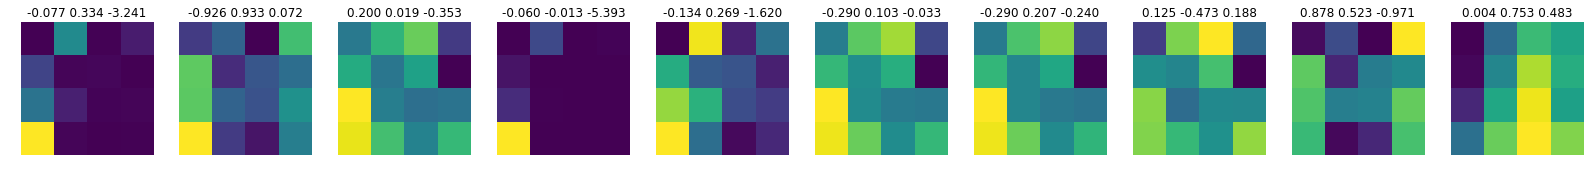

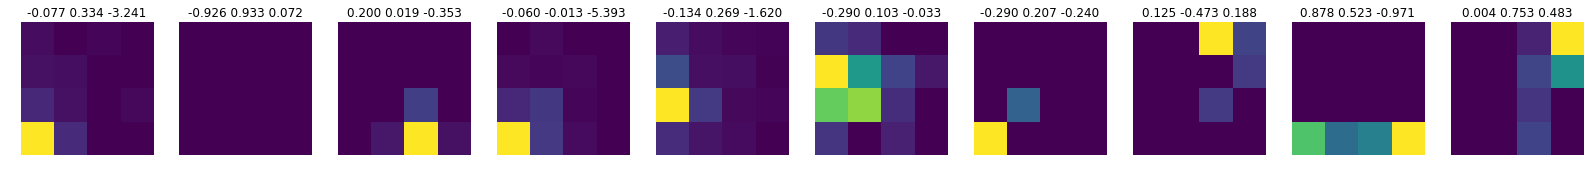

Train loss: 0.4238972144715558 Batch 2000 of 500           epoch: 88
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4233) tensor(1.0134e-07, grad_fn=<SumBackward0>) tensor(95.7679, grad_fn=<AbsBackward>) tensor(-243.3492, grad_fn=<SumBackward0>)


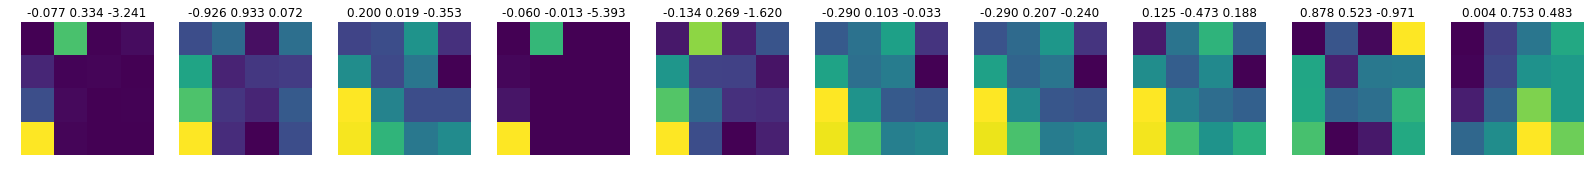

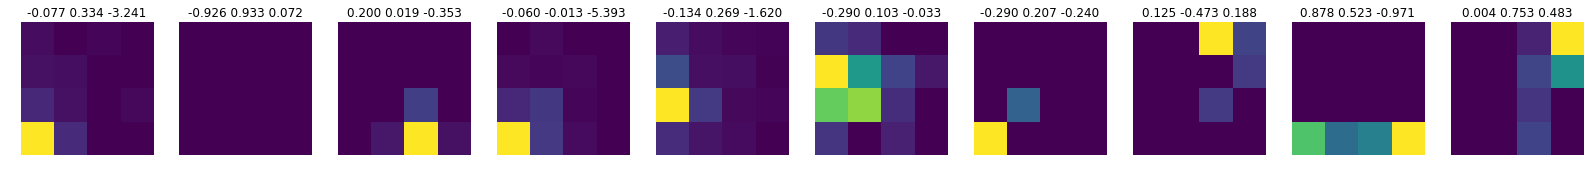

Train loss: 0.4242471104306124 Batch 2000 of 500           epoch: 89
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3964) tensor(6.0806e-08, grad_fn=<SumBackward0>) tensor(85.7013, grad_fn=<AbsBackward>) tensor(-163.5743, grad_fn=<SumBackward0>)


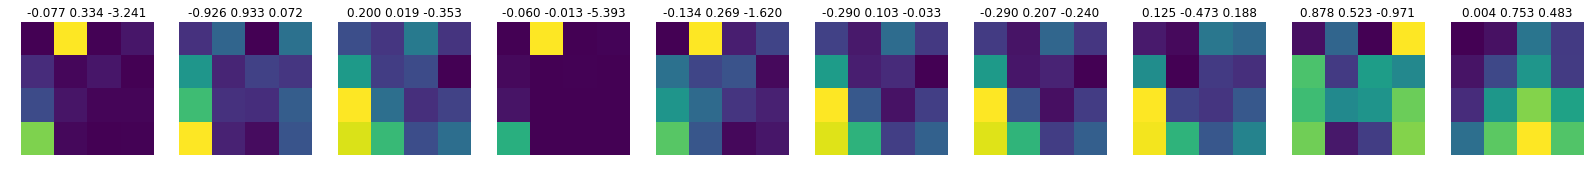

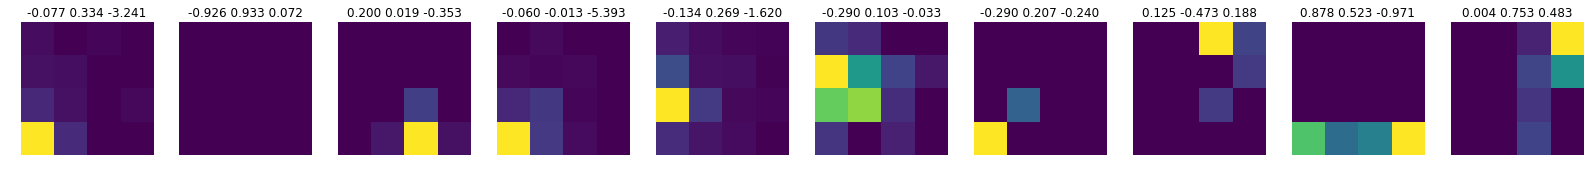

Train loss: 0.39702292659257066 Batch 2000 of 500           epoch: 90
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3657) tensor(4.7027e-08, grad_fn=<SumBackward0>) tensor(63.6701, grad_fn=<AbsBackward>) tensor(-116.2176, grad_fn=<SumBackward0>)


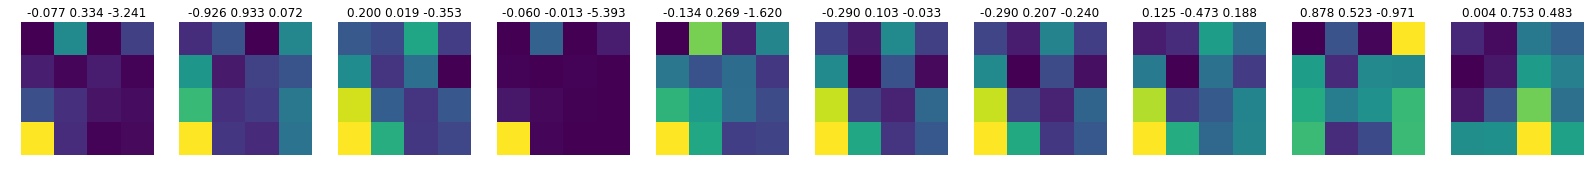

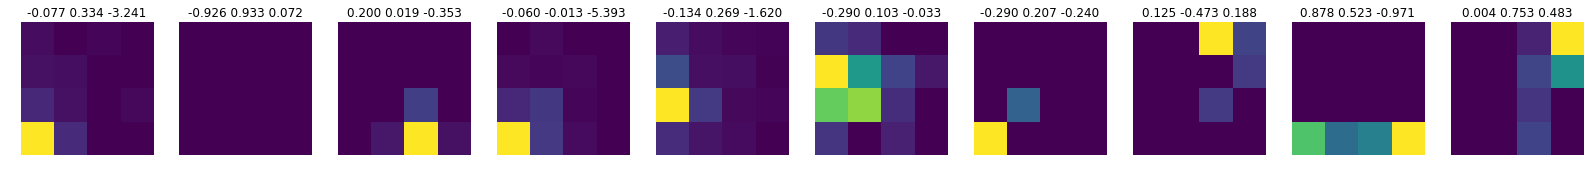

Train loss: 0.36467338606295946 Batch 2000 of 500           epoch: 91
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3322) tensor(9.9362e-09, grad_fn=<SumBackward0>) tensor(64.1911, grad_fn=<AbsBackward>) tensor(-114.2090, grad_fn=<SumBackward0>)


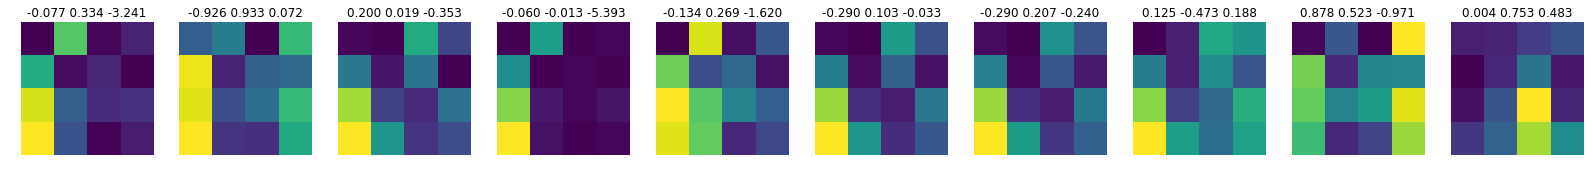

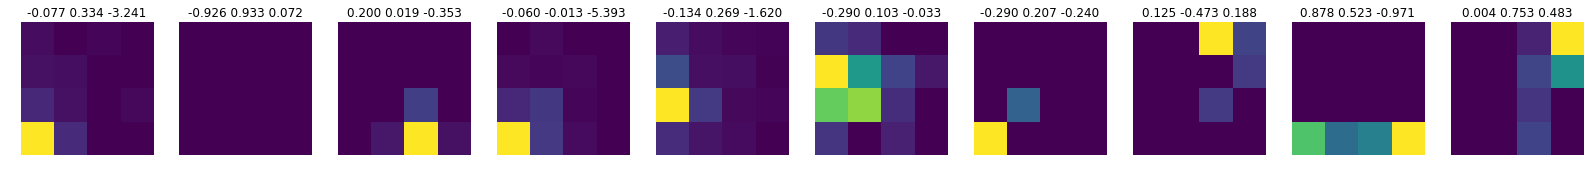

Train loss: 0.3342847358996049 Batch 2000 of 500           epoch: 92
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3563) tensor(2.0498e-08, grad_fn=<SumBackward0>) tensor(78.2596, grad_fn=<AbsBackward>) tensor(-138.9724, grad_fn=<SumBackward0>)


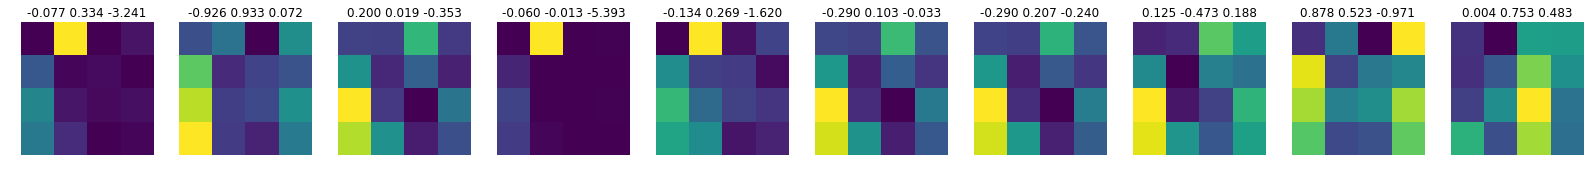

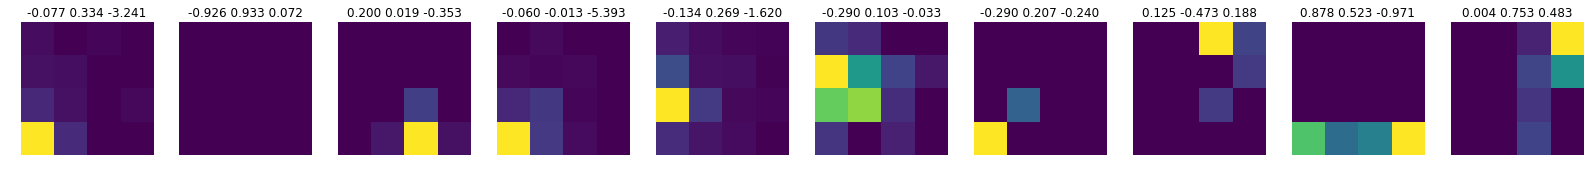

Train loss: 0.3569823549101069 Batch 2000 of 500           epoch: 93
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3839) tensor(3.7730e-08, grad_fn=<SumBackward0>) tensor(89.2922, grad_fn=<AbsBackward>) tensor(-148.3777, grad_fn=<SumBackward0>)


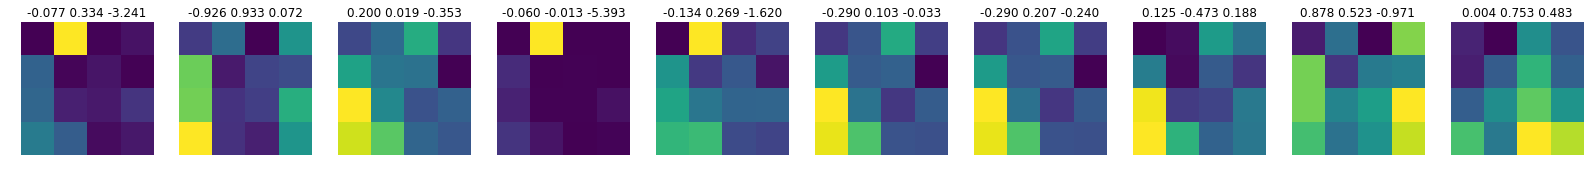

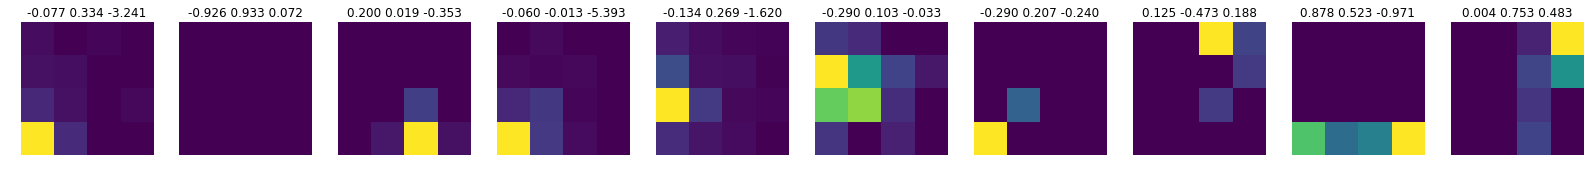

Train loss: 0.3857426452514068 Batch 2000 of 500           epoch: 94
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3628) tensor(6.3453e-09, grad_fn=<SumBackward0>) tensor(77.7877, grad_fn=<AbsBackward>) tensor(-147.0558, grad_fn=<SumBackward0>)


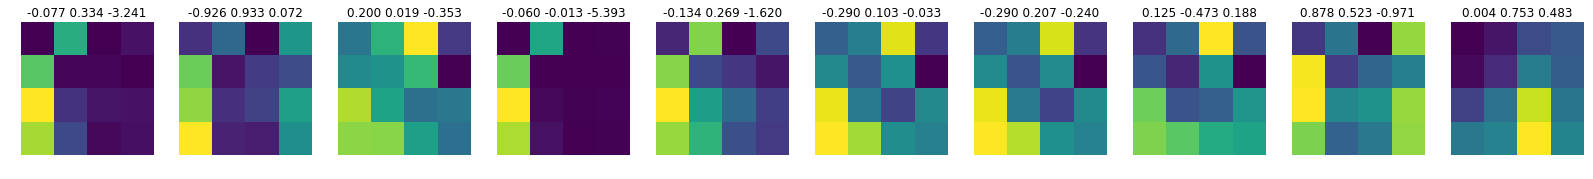

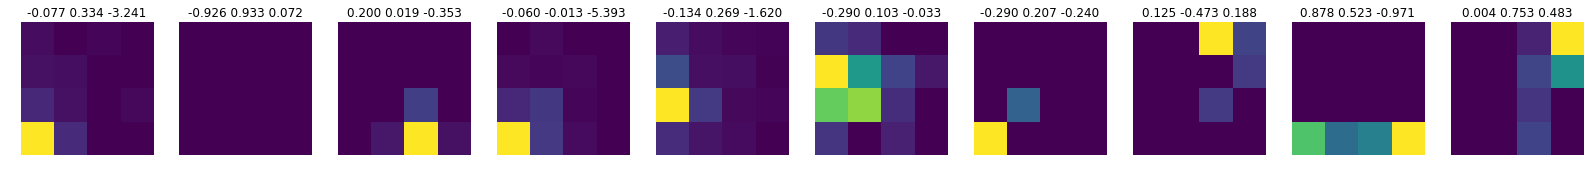

Train loss: 0.36402773243054937 Batch 2000 of 500           epoch: 95
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3756) tensor(3.7655e-10, grad_fn=<SumBackward0>) tensor(73.8532, grad_fn=<AbsBackward>) tensor(-143.8025, grad_fn=<SumBackward0>)


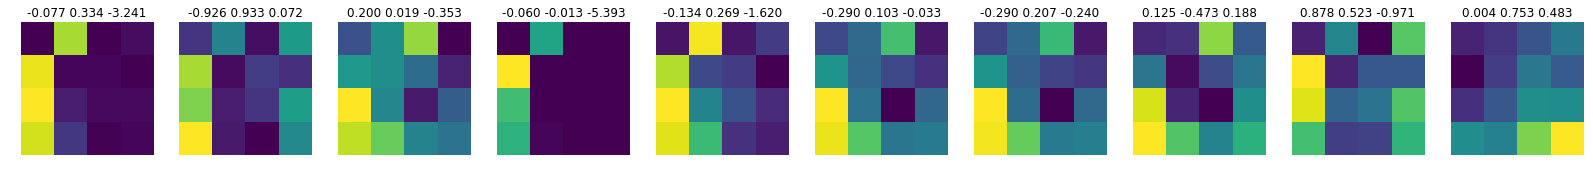

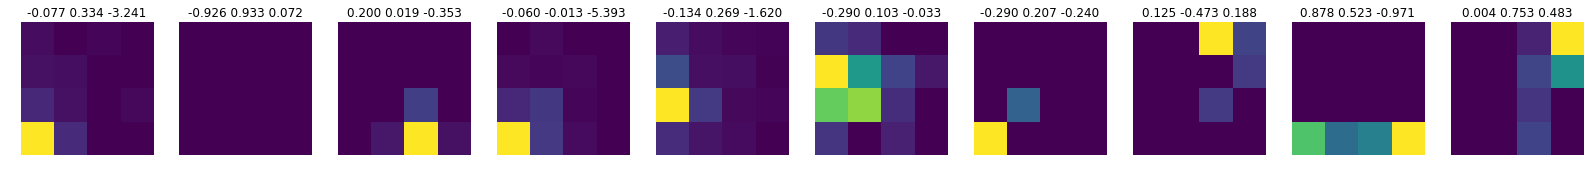

Train loss: 0.3756371292599274 Batch 2000 of 500           epoch: 96
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3834) tensor(2.8659e-08, grad_fn=<SumBackward0>) tensor(86.3228, grad_fn=<AbsBackward>) tensor(-217.2147, grad_fn=<SumBackward0>)


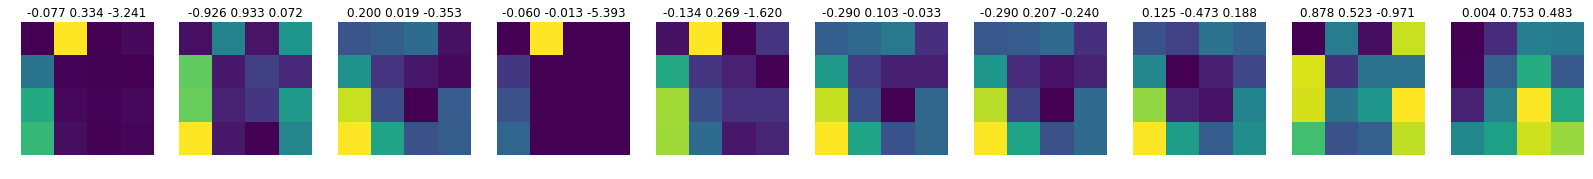

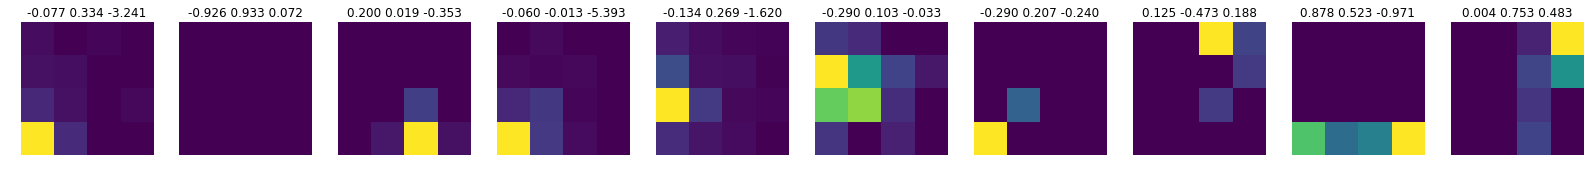

Train loss: 0.3869016796821002 Batch 2000 of 500           epoch: 97
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3820) tensor(1.3056e-08, grad_fn=<SumBackward0>) tensor(88.9402, grad_fn=<AbsBackward>) tensor(-193.6124, grad_fn=<SumBackward0>)


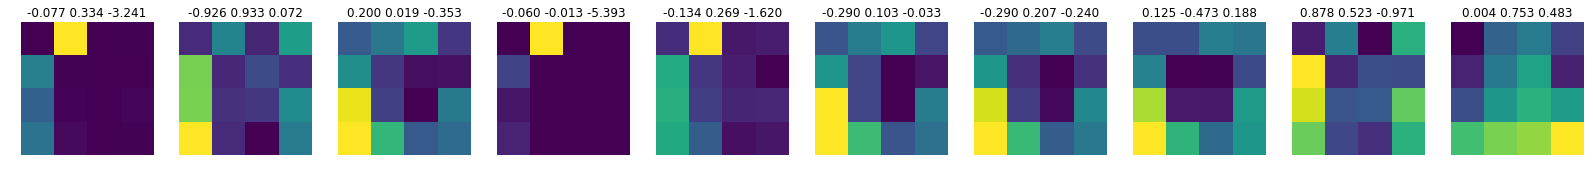

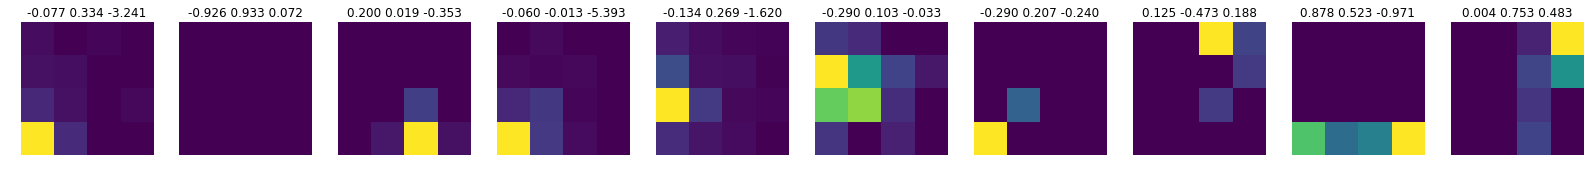

Train loss: 0.38150640403897335 Batch 2000 of 500           epoch: 98
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3847) tensor(1.4343e-09, grad_fn=<SumBackward0>) tensor(81.2225, grad_fn=<AbsBackward>) tensor(-189.0647, grad_fn=<SumBackward0>)


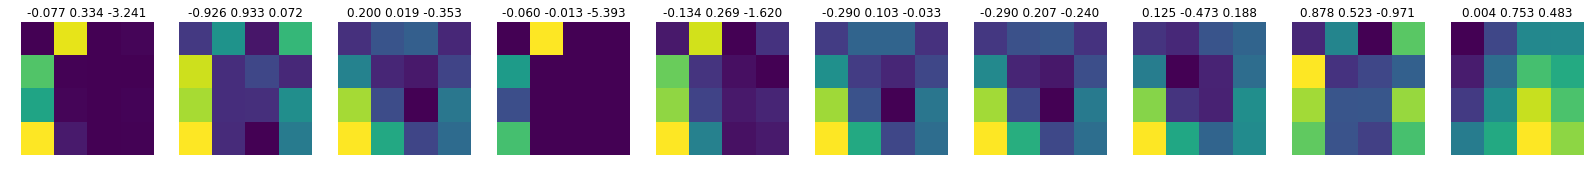

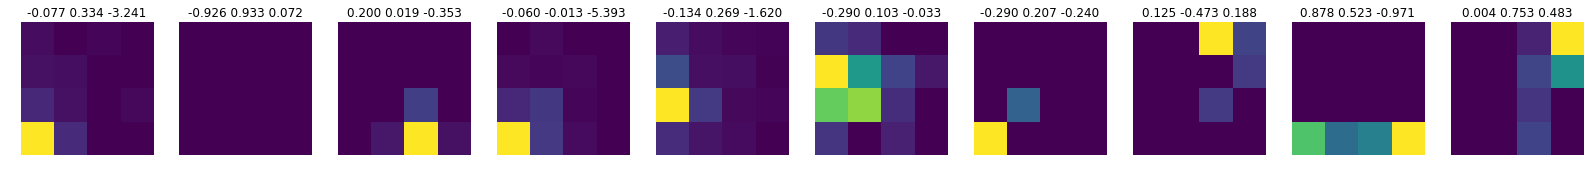

Train loss: 0.38444263443848625 Batch 2000 of 500           epoch: 99
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4254) tensor(4.9199e-08, grad_fn=<SumBackward0>) tensor(105.3044, grad_fn=<AbsBackward>) tensor(-170.9896, grad_fn=<SumBackward0>)


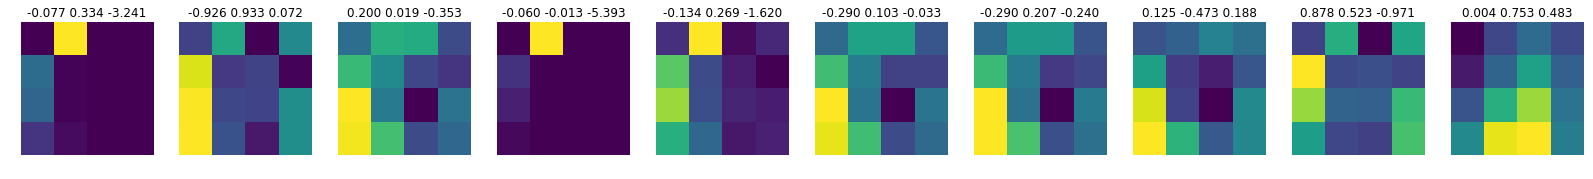

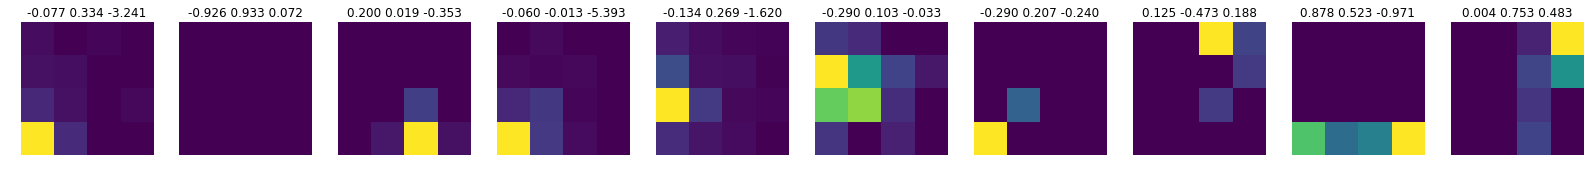

Train loss: 0.422920776559275 Batch 2000 of 500           epoch: 100
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2945) tensor(7.2139e-09, grad_fn=<SumBackward0>) tensor(54.4012, grad_fn=<AbsBackward>) tensor(-113.0576, grad_fn=<SumBackward0>)


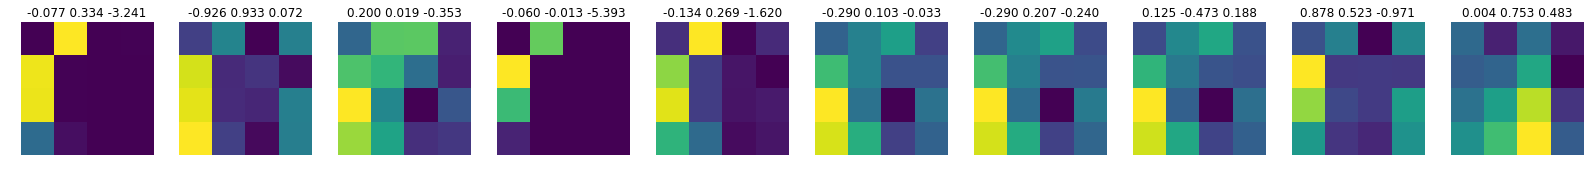

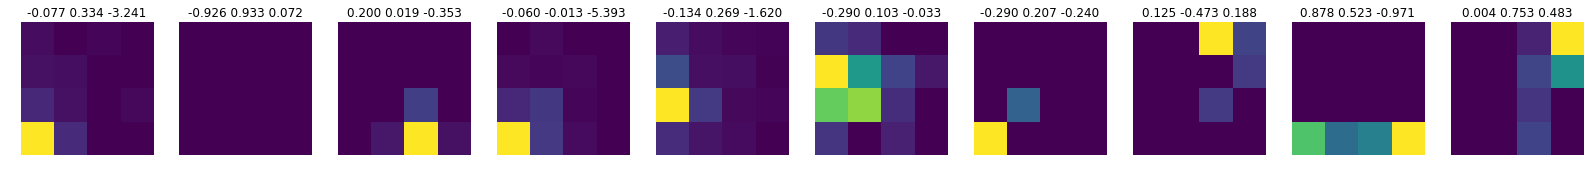

Train loss: 0.29466003374828703 Batch 2000 of 500           epoch: 101
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4139) tensor(3.6461e-08, grad_fn=<SumBackward0>) tensor(86.0018, grad_fn=<AbsBackward>) tensor(-183.3697, grad_fn=<SumBackward0>)


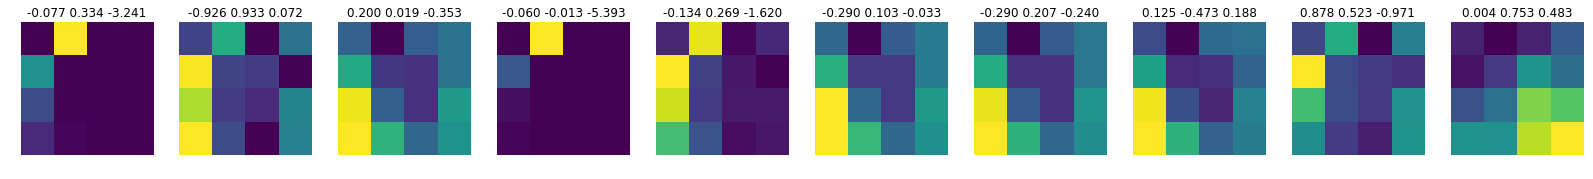

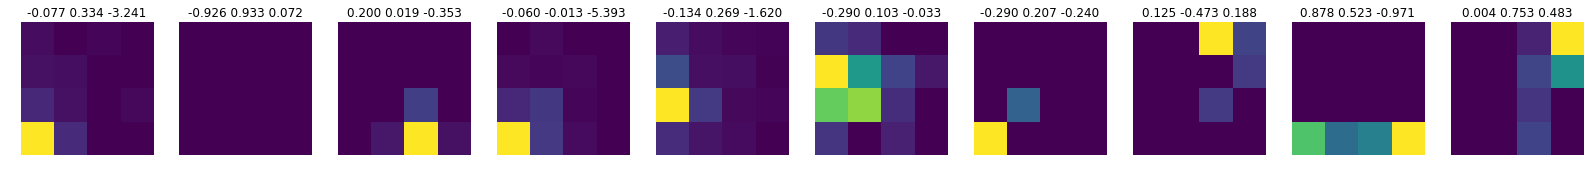

Train loss: 0.4143161720316395 Batch 2000 of 500           epoch: 102
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4380) tensor(1.9004e-08, grad_fn=<SumBackward0>) tensor(111.5303, grad_fn=<AbsBackward>) tensor(-186.4644, grad_fn=<SumBackward0>)


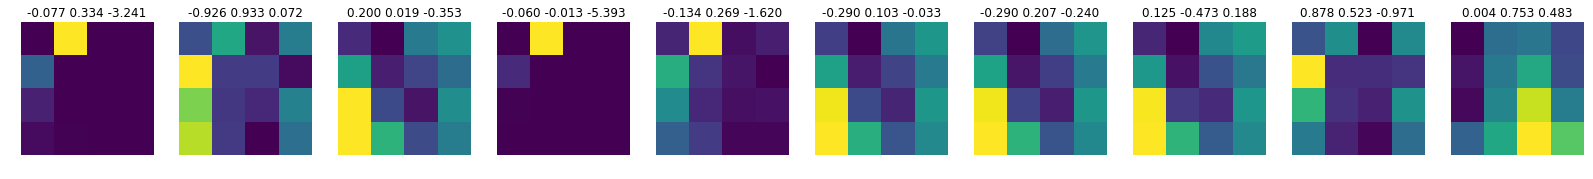

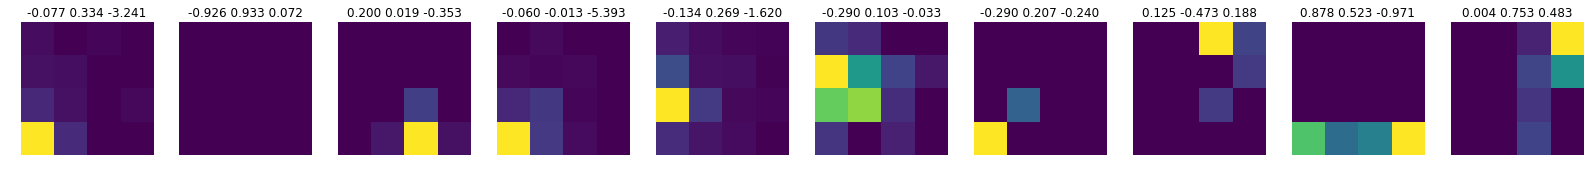

Train loss: 0.4384992561232022 Batch 2000 of 500           epoch: 103
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3516) tensor(2.3379e-07, grad_fn=<SumBackward0>) tensor(80.5810, grad_fn=<AbsBackward>) tensor(-149.0587, grad_fn=<SumBackward0>)


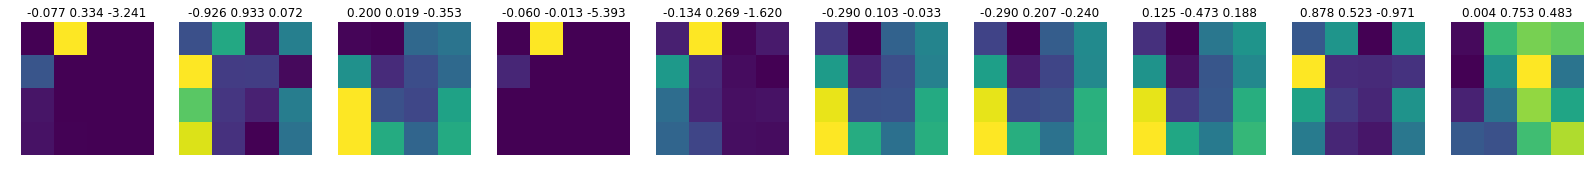

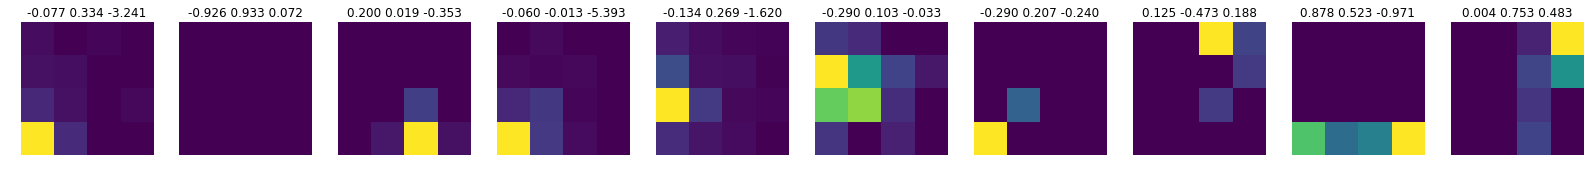

Train loss: 0.3510157642866102 Batch 2000 of 500           epoch: 104
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.1928) tensor(6.2147e-09, grad_fn=<SumBackward0>) tensor(17.3892, grad_fn=<AbsBackward>) tensor(-40.8758, grad_fn=<SumBackward0>)


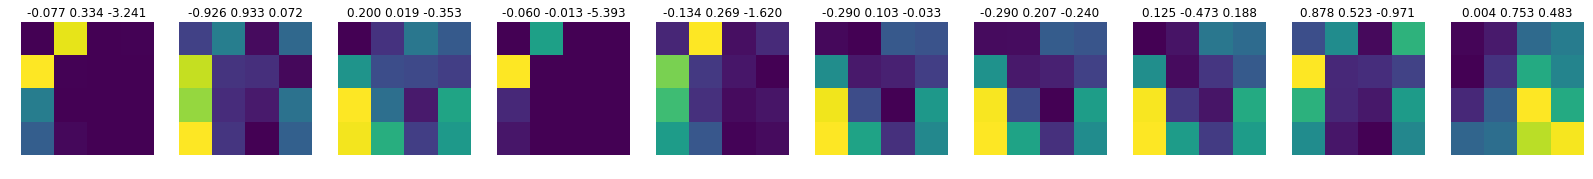

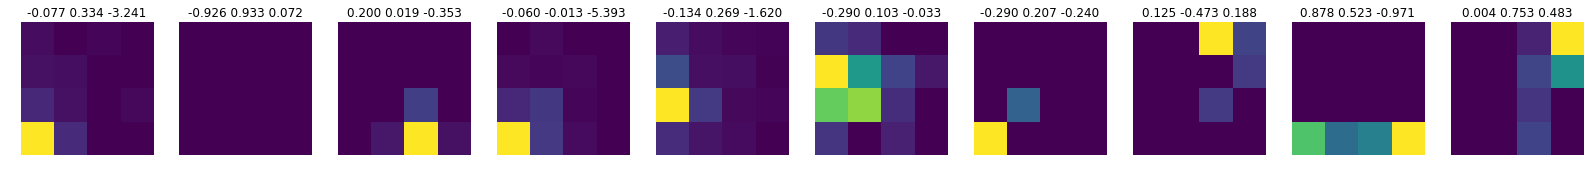

Train loss: 0.1933957683764576 Batch 2000 of 500           epoch: 105
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2270) tensor(5.4551e-08, grad_fn=<SumBackward0>) tensor(34.8758, grad_fn=<AbsBackward>) tensor(-51.0415, grad_fn=<SumBackward0>)


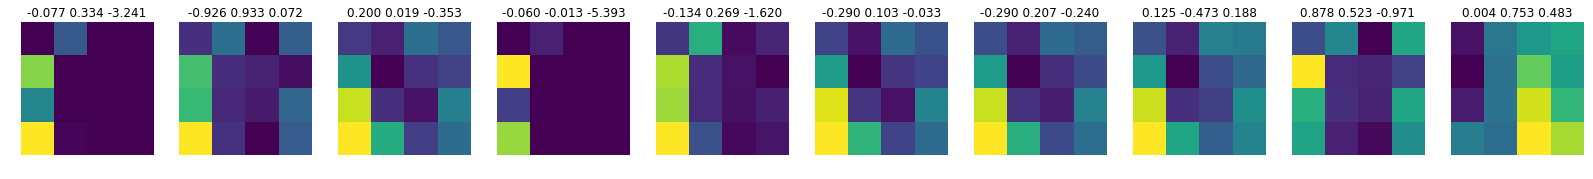

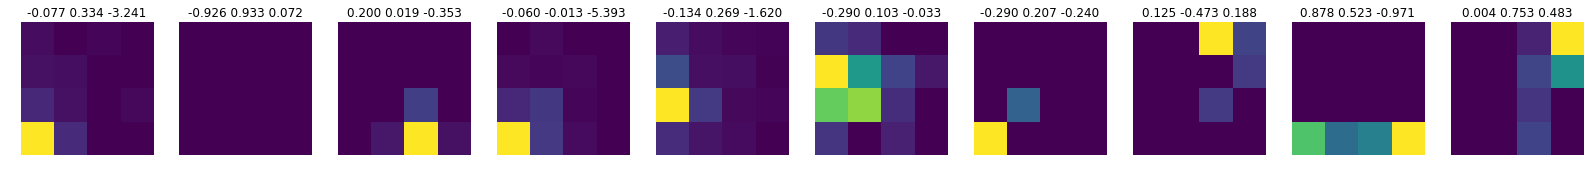

Train loss: 0.22816821852187494 Batch 2000 of 500           epoch: 106
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3702) tensor(6.6582e-09, grad_fn=<SumBackward0>) tensor(74.3855, grad_fn=<AbsBackward>) tensor(-156.0295, grad_fn=<SumBackward0>)


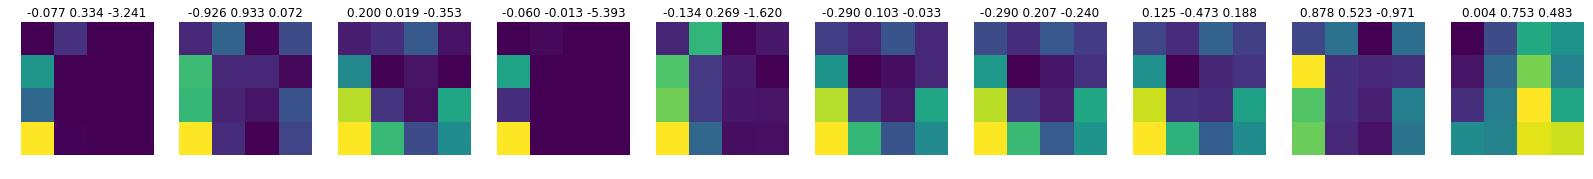

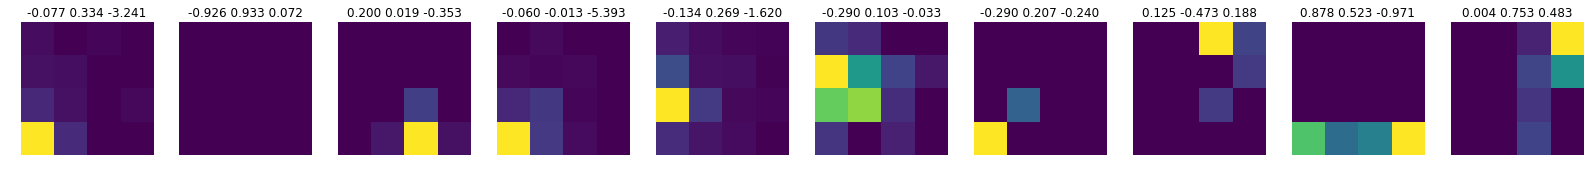

Train loss: 0.36993315206806315 Batch 2000 of 500           epoch: 107
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2581) tensor(4.4765e-08, grad_fn=<SumBackward0>) tensor(36.2362, grad_fn=<AbsBackward>) tensor(-62.1230, grad_fn=<SumBackward0>)


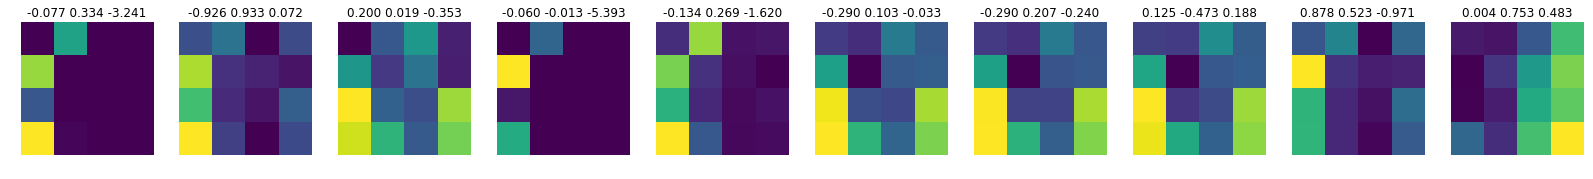

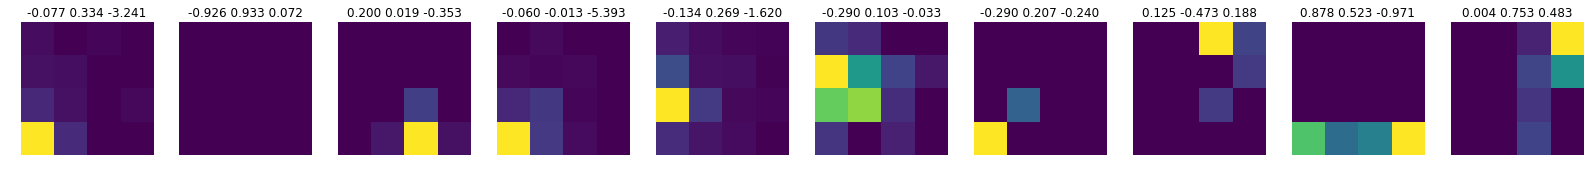

Train loss: 0.2580750528815569 Batch 2000 of 500           epoch: 108
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4689) tensor(6.8409e-10, grad_fn=<SumBackward0>) tensor(118.5960, grad_fn=<AbsBackward>) tensor(-199.8332, grad_fn=<SumBackward0>)


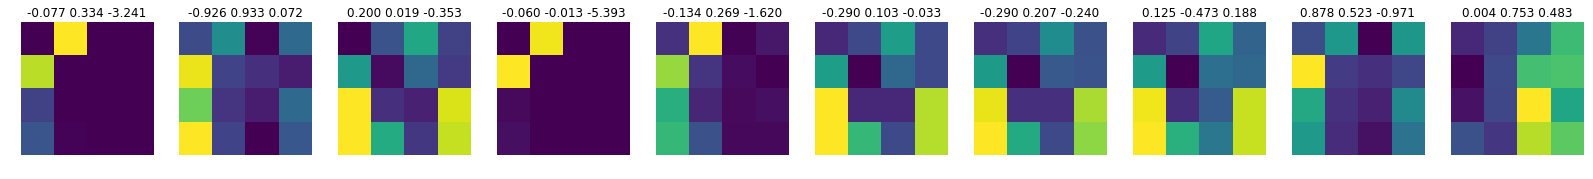

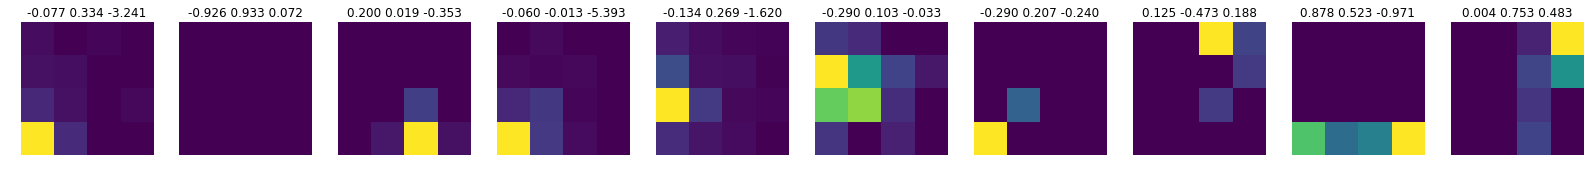

Train loss: 0.4692681391021982 Batch 2000 of 500           epoch: 109
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2719) tensor(1.6444e-08, grad_fn=<SumBackward0>) tensor(42.7485, grad_fn=<AbsBackward>) tensor(-73.7871, grad_fn=<SumBackward0>)


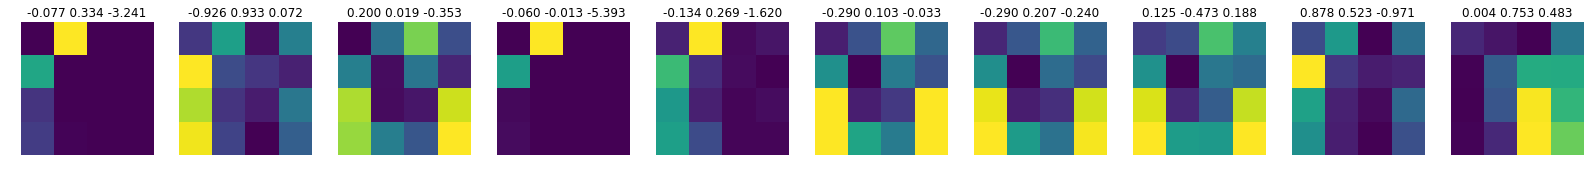

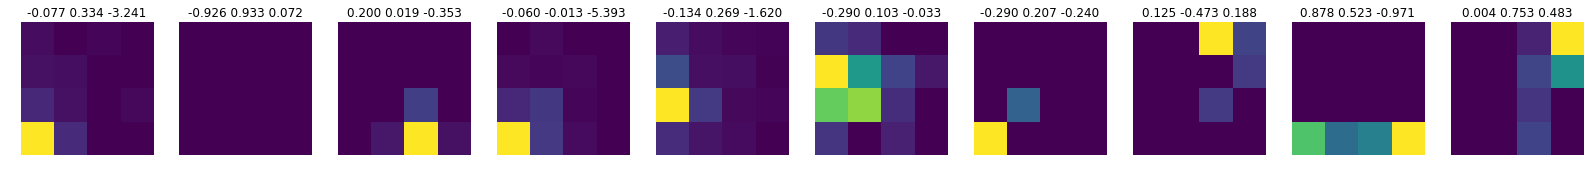

Train loss: 0.2733962703570793 Batch 2000 of 500           epoch: 110
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2740) tensor(2.1836e-07, grad_fn=<SumBackward0>) tensor(46.9315, grad_fn=<AbsBackward>) tensor(-86.0714, grad_fn=<SumBackward0>)


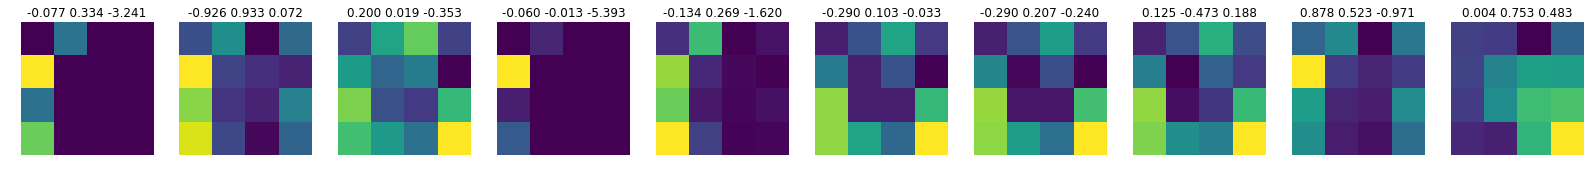

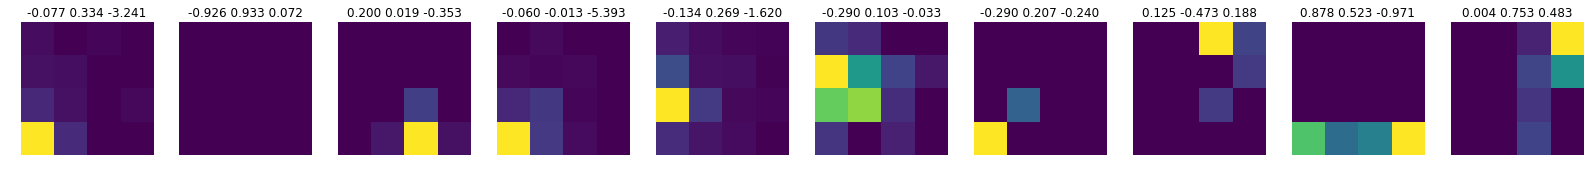

Train loss: 0.2751496468134394 Batch 2000 of 500           epoch: 111
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3777) tensor(5.3473e-08, grad_fn=<SumBackward0>) tensor(78.5293, grad_fn=<AbsBackward>) tensor(-132.5846, grad_fn=<SumBackward0>)


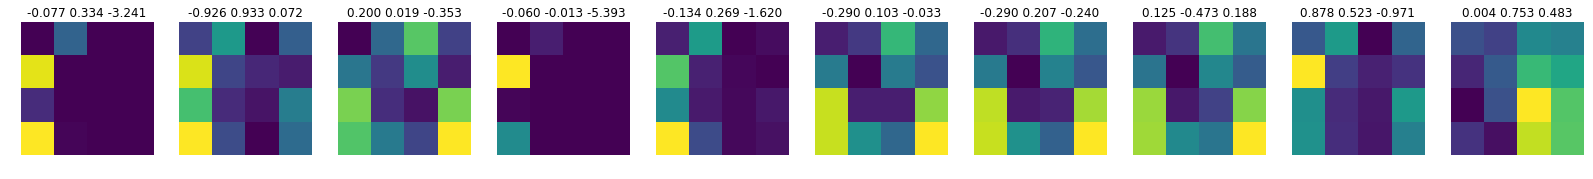

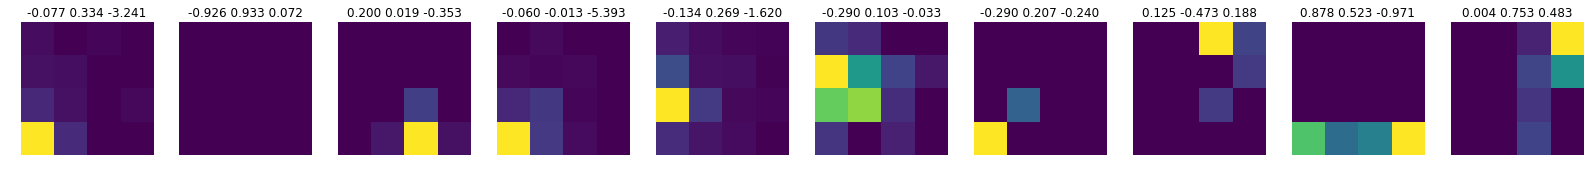

Train loss: 0.3781806481497883 Batch 2000 of 500           epoch: 112
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4500) tensor(3.5617e-08, grad_fn=<SumBackward0>) tensor(107.8949, grad_fn=<AbsBackward>) tensor(-272.7276, grad_fn=<SumBackward0>)


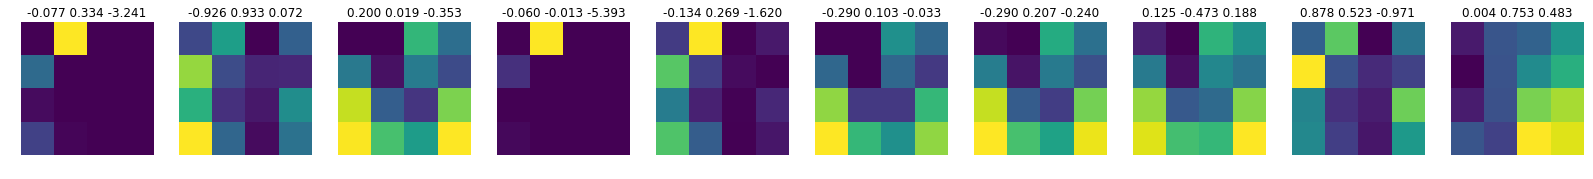

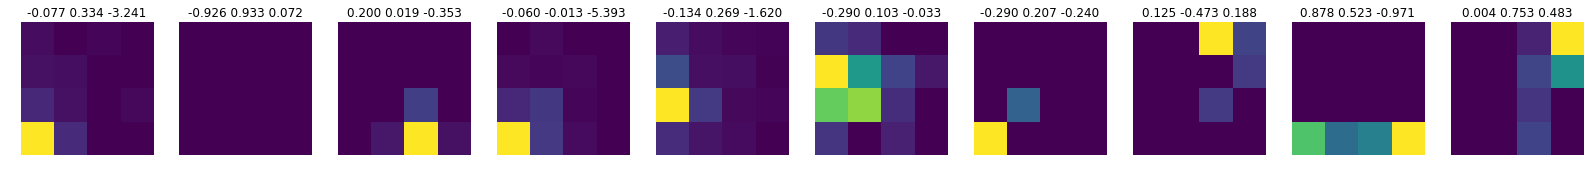

Train loss: 0.4472372321538575 Batch 2000 of 500           epoch: 113
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3692) tensor(6.5121e-09, grad_fn=<SumBackward0>) tensor(69.8093, grad_fn=<AbsBackward>) tensor(-134.6487, grad_fn=<SumBackward0>)


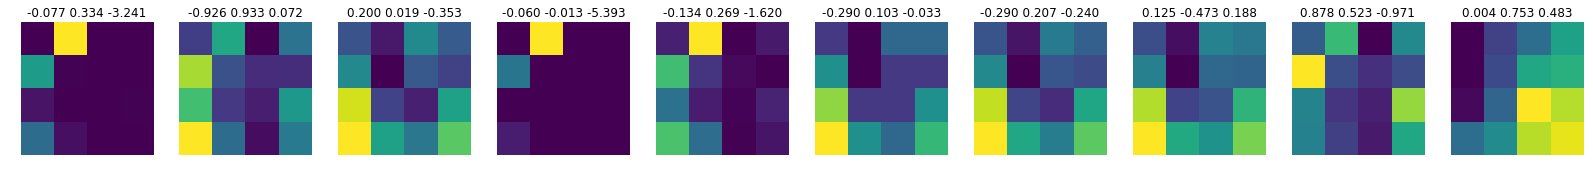

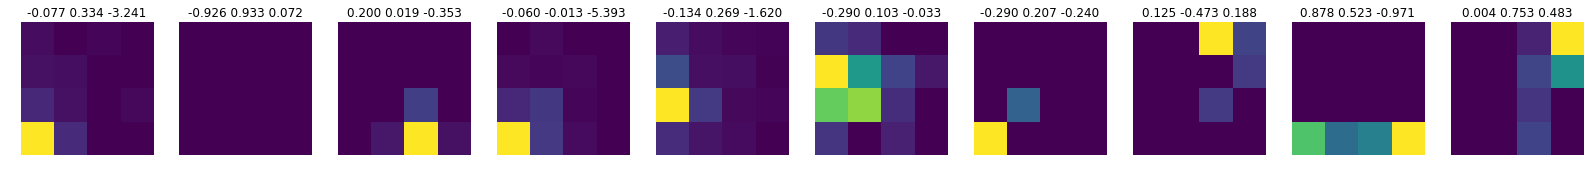

Train loss: 0.36831155031698287 Batch 2000 of 500           epoch: 114
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4625) tensor(1.7223e-07, grad_fn=<SumBackward0>) tensor(125.9231, grad_fn=<AbsBackward>) tensor(-210.3993, grad_fn=<SumBackward0>)


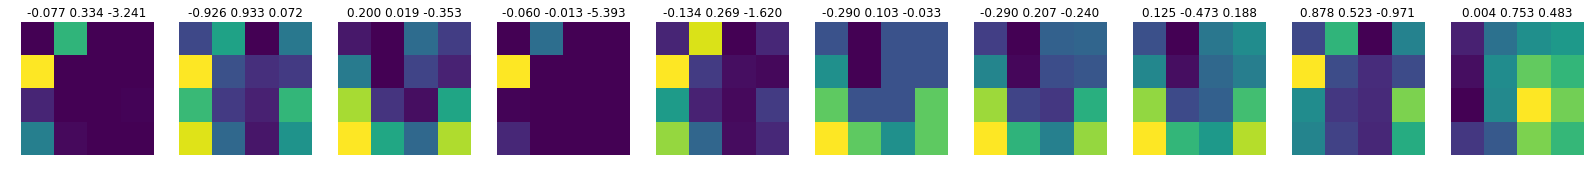

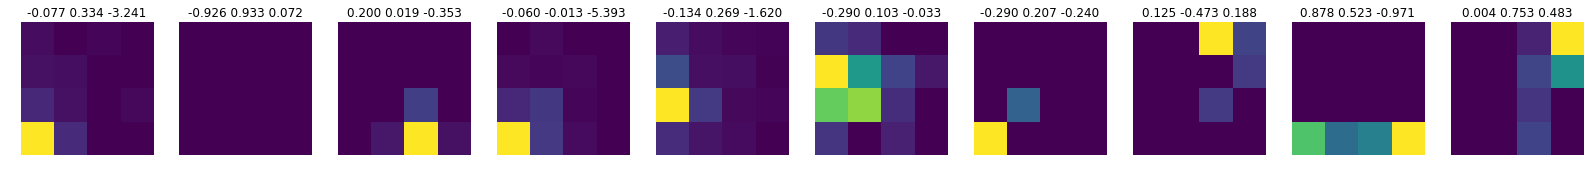

Train loss: 0.45949811719834727 Batch 2000 of 500           epoch: 115
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2879) tensor(2.5404e-08, grad_fn=<SumBackward0>) tensor(51.0281, grad_fn=<AbsBackward>) tensor(-76.1675, grad_fn=<SumBackward0>)


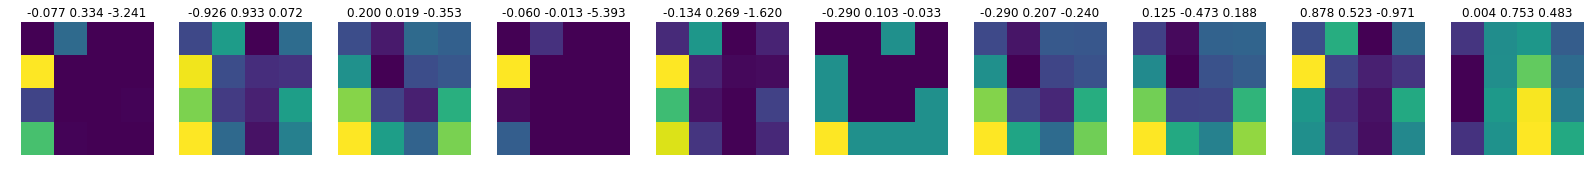

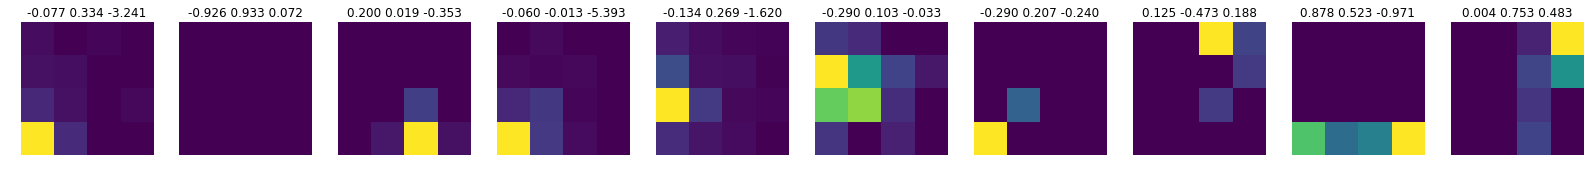

Train loss: 0.28714554717358454 Batch 2000 of 500           epoch: 116
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3313) tensor(8.5789e-08, grad_fn=<SumBackward0>) tensor(58.7678, grad_fn=<AbsBackward>) tensor(-101.1320, grad_fn=<SumBackward0>)


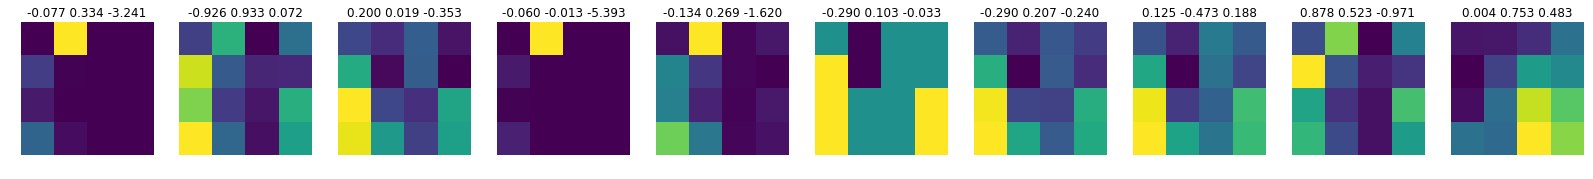

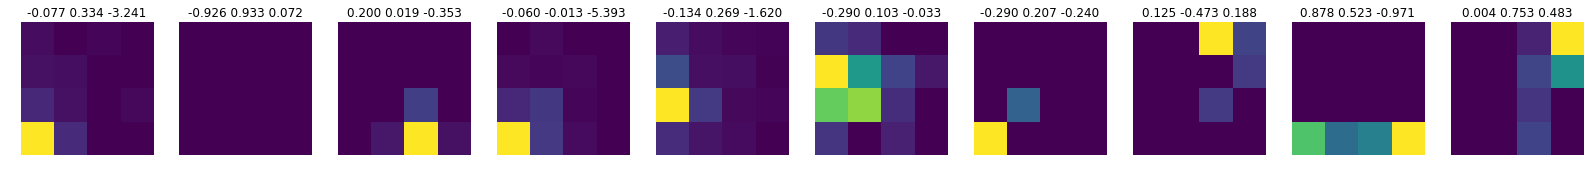

Train loss: 0.331368897870432 Batch 2000 of 500           epoch: 117
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2243) tensor(2.1983e-08, grad_fn=<SumBackward0>) tensor(35.0050, grad_fn=<AbsBackward>) tensor(-53.3469, grad_fn=<SumBackward0>)


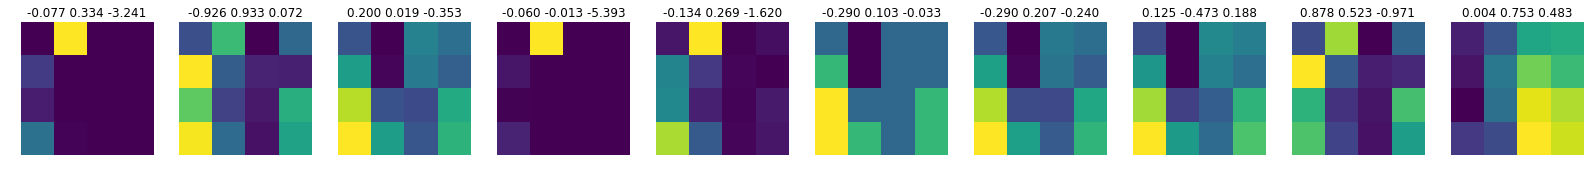

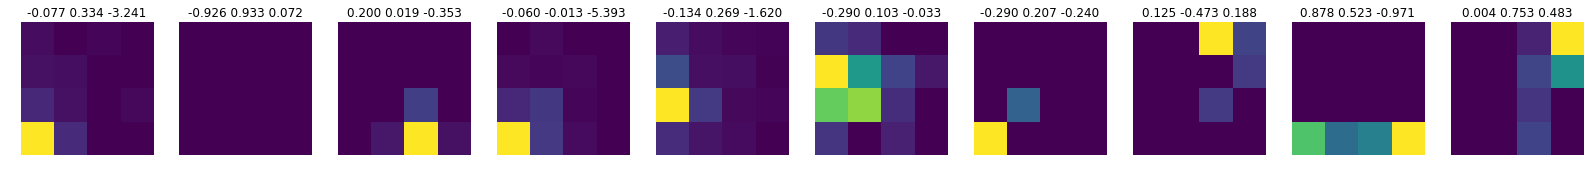

Train loss: 0.22476520621094098 Batch 2000 of 500           epoch: 118
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3069) tensor(9.0709e-08, grad_fn=<SumBackward0>) tensor(66.4888, grad_fn=<AbsBackward>) tensor(-119.4382, grad_fn=<SumBackward0>)


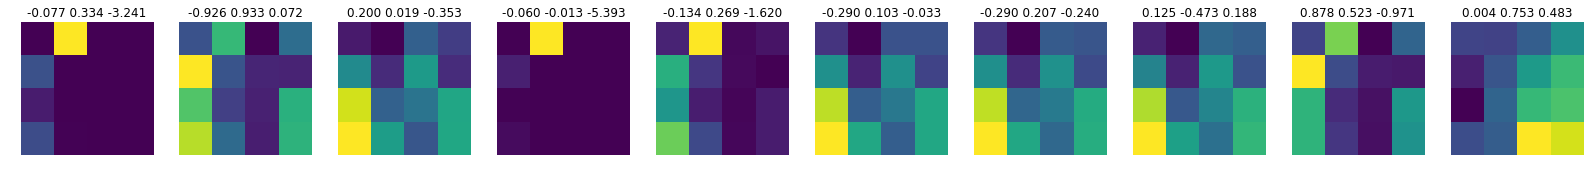

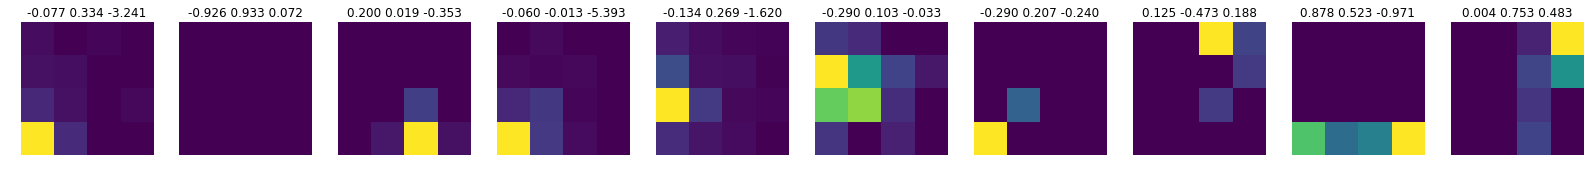

Train loss: 0.3059499307189823 Batch 2000 of 500           epoch: 119
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3450) tensor(1.0491e-08, grad_fn=<SumBackward0>) tensor(72.6702, grad_fn=<AbsBackward>) tensor(-109.9025, grad_fn=<SumBackward0>)


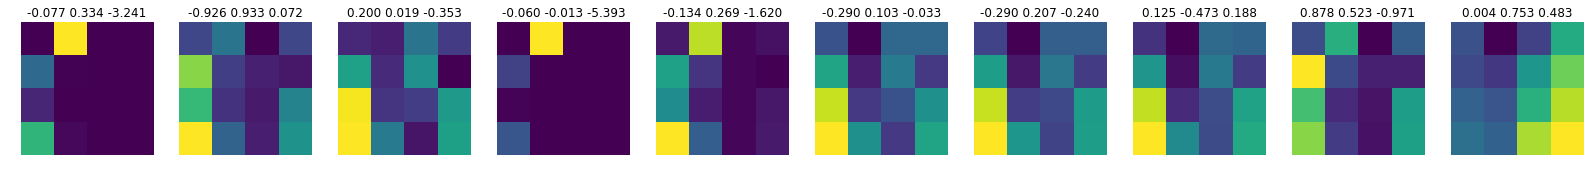

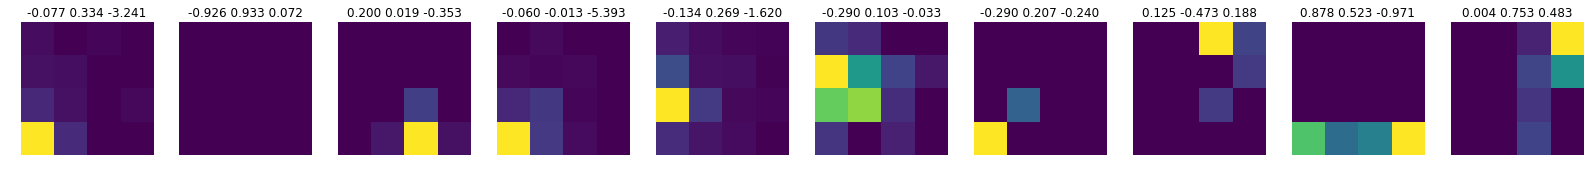

Train loss: 0.3455731975150219 Batch 2000 of 500           epoch: 120
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3880) tensor(4.5951e-08, grad_fn=<SumBackward0>) tensor(72.9109, grad_fn=<AbsBackward>) tensor(-137.3236, grad_fn=<SumBackward0>)


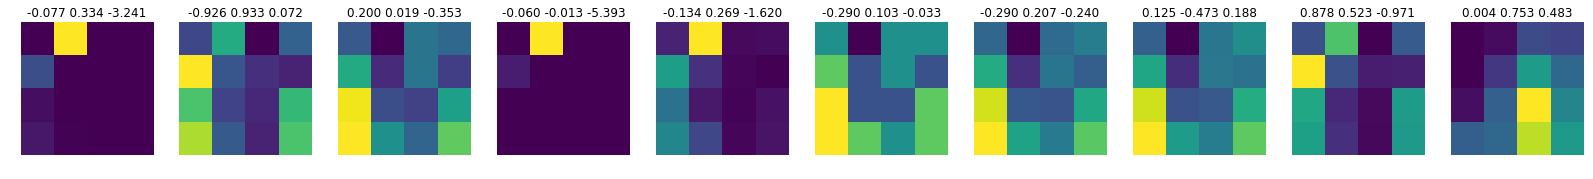

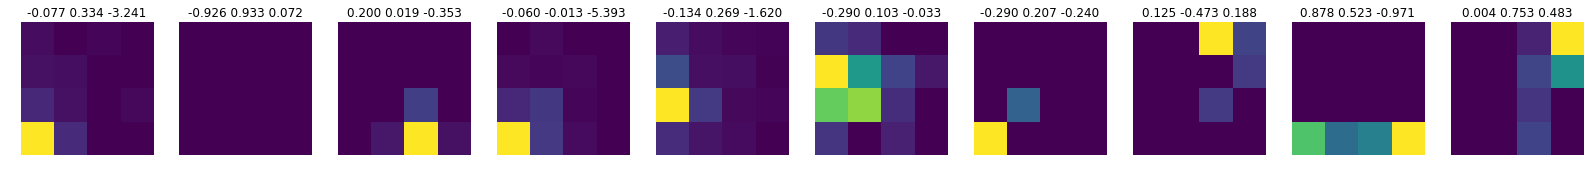

Train loss: 0.38695337369871663 Batch 2000 of 500           epoch: 121
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4295) tensor(4.0132e-09, grad_fn=<SumBackward0>) tensor(101.6757, grad_fn=<AbsBackward>) tensor(-175.2003, grad_fn=<SumBackward0>)


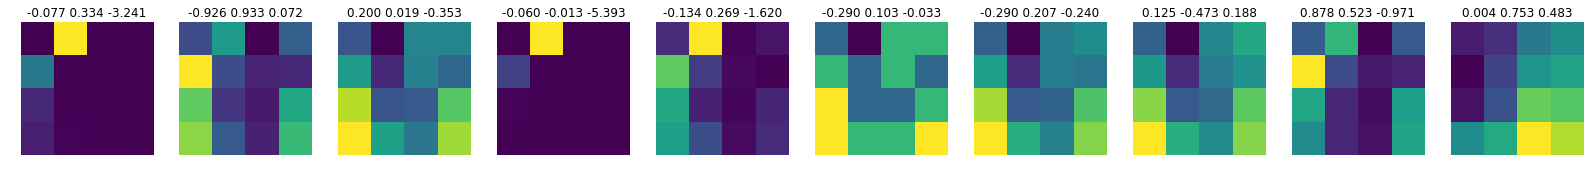

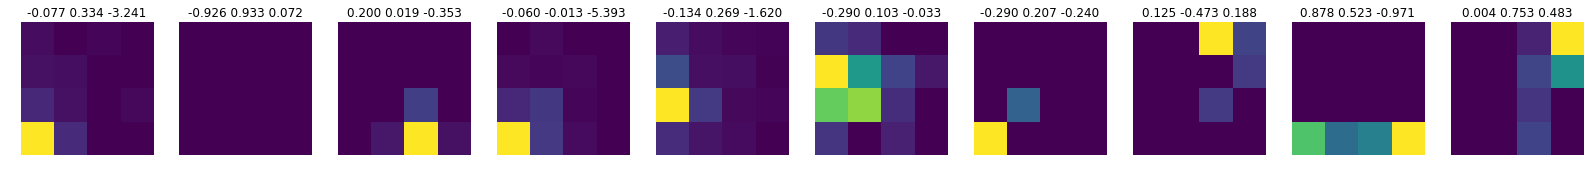

Train loss: 0.42949856494150024 Batch 2000 of 500           epoch: 122
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3878) tensor(6.3896e-10, grad_fn=<SumBackward0>) tensor(81.7158, grad_fn=<AbsBackward>) tensor(-151.4805, grad_fn=<SumBackward0>)


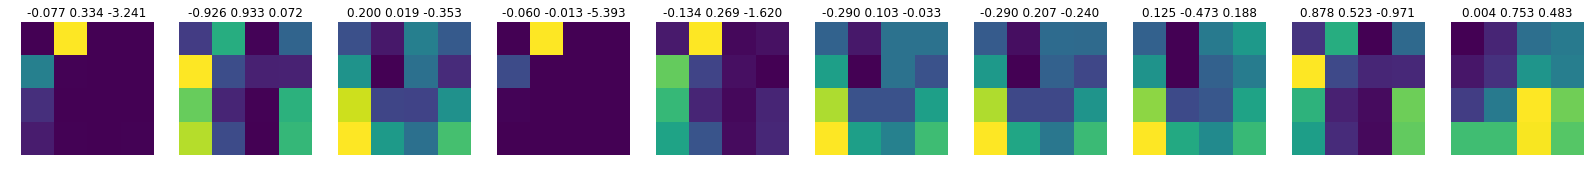

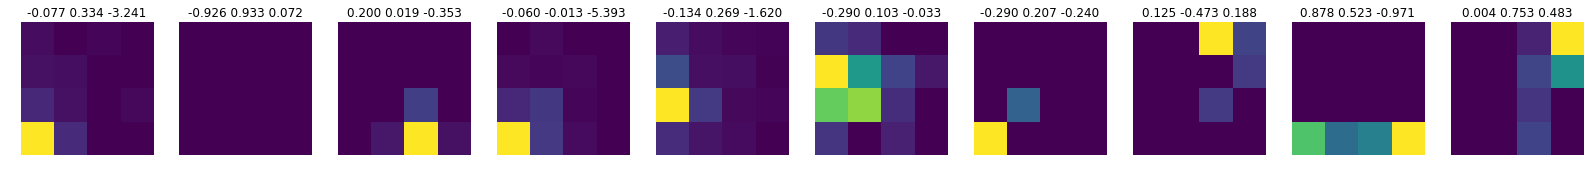

Train loss: 0.3921480818899307 Batch 2000 of 500           epoch: 123
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4493) tensor(1.1251e-08, grad_fn=<SumBackward0>) tensor(102.6075, grad_fn=<AbsBackward>) tensor(-196.4965, grad_fn=<SumBackward0>)


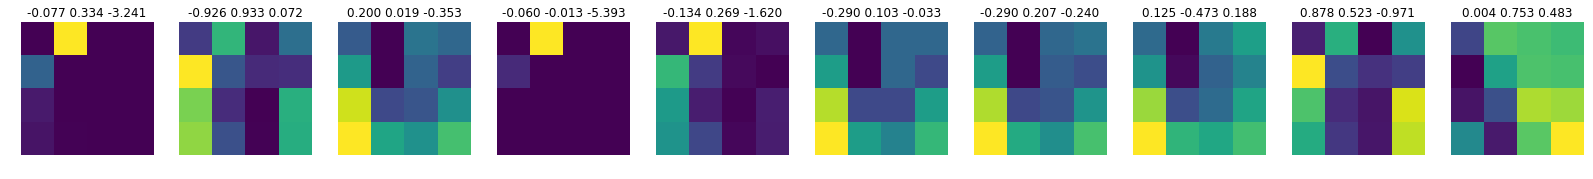

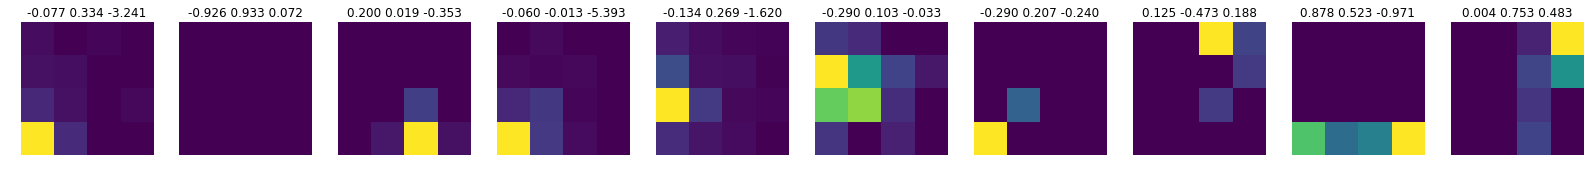

Train loss: 0.448322871779147 Batch 2000 of 500           epoch: 124
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3768) tensor(2.0913e-08, grad_fn=<SumBackward0>) tensor(76.8543, grad_fn=<AbsBackward>) tensor(-300.7254, grad_fn=<SumBackward0>)


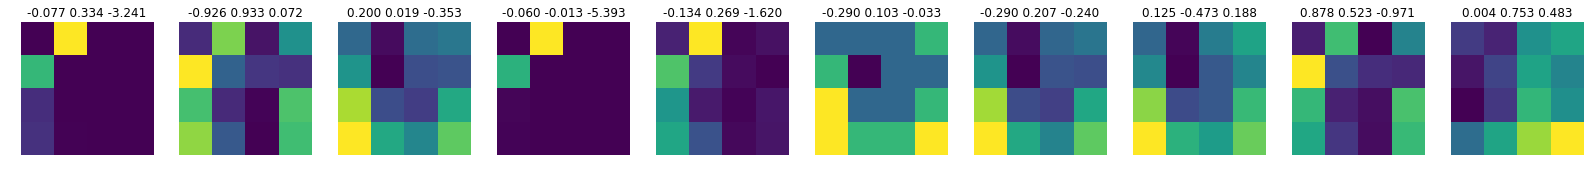

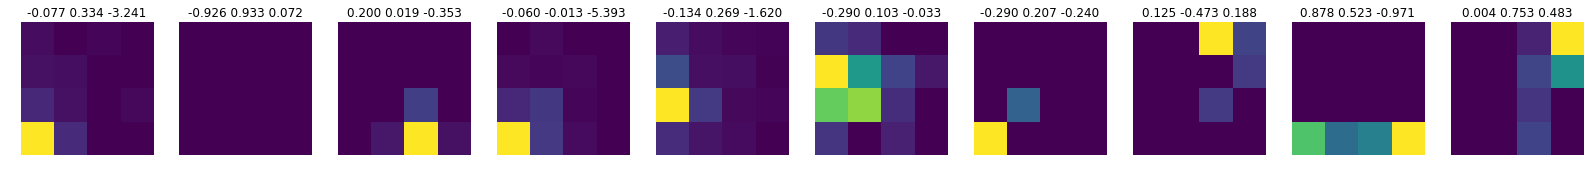

Train loss: 0.3766674855930652 Batch 2000 of 500           epoch: 125
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.5067) tensor(3.7713e-08, grad_fn=<SumBackward0>) tensor(136.2965, grad_fn=<AbsBackward>) tensor(-284.9824, grad_fn=<SumBackward0>)


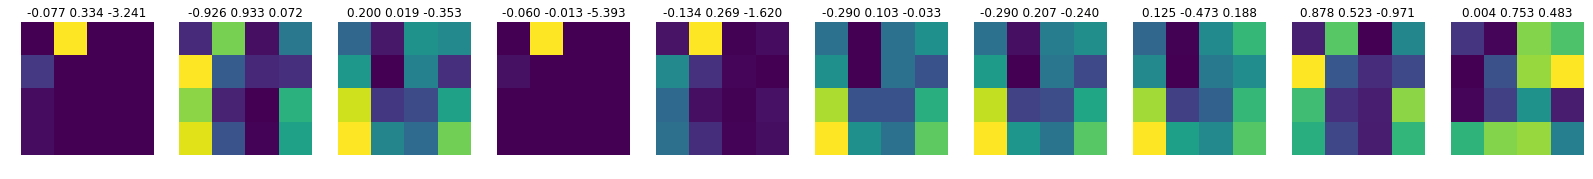

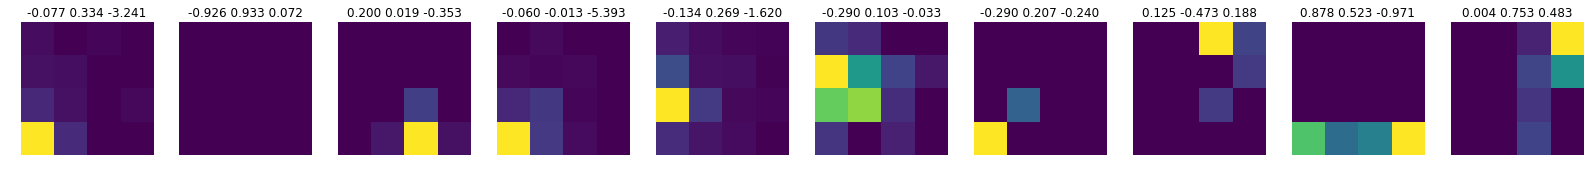

Train loss: 0.508236760917225 Batch 2000 of 500           epoch: 126
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4141) tensor(2.9972e-08, grad_fn=<SumBackward0>) tensor(100.6161, grad_fn=<AbsBackward>) tensor(-176.3474, grad_fn=<SumBackward0>)


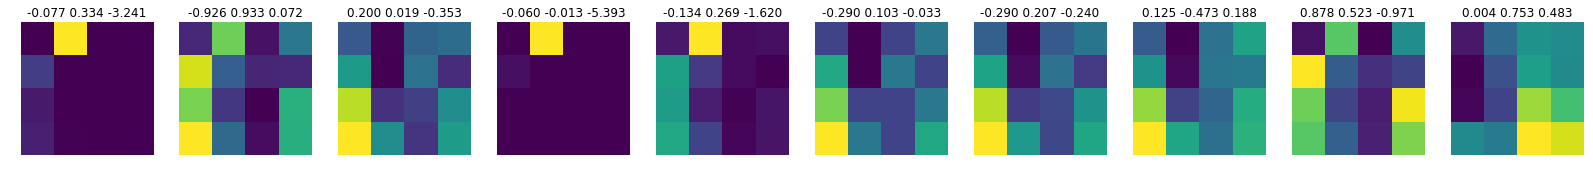

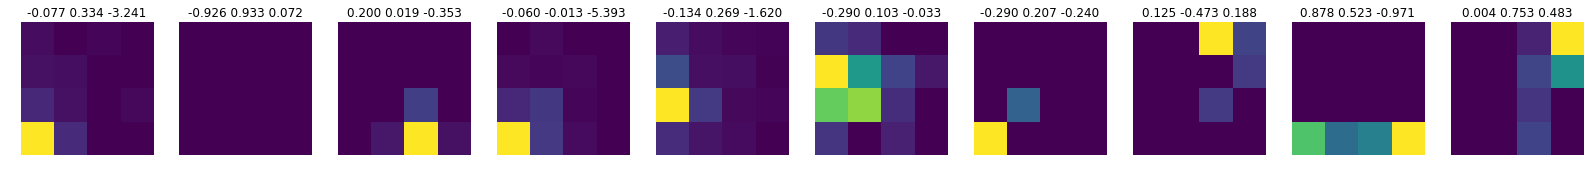

Train loss: 0.41419954113207447 Batch 2000 of 500           epoch: 127
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3585) tensor(1.4553e-08, grad_fn=<SumBackward0>) tensor(66.5465, grad_fn=<AbsBackward>) tensor(-157.5215, grad_fn=<SumBackward0>)


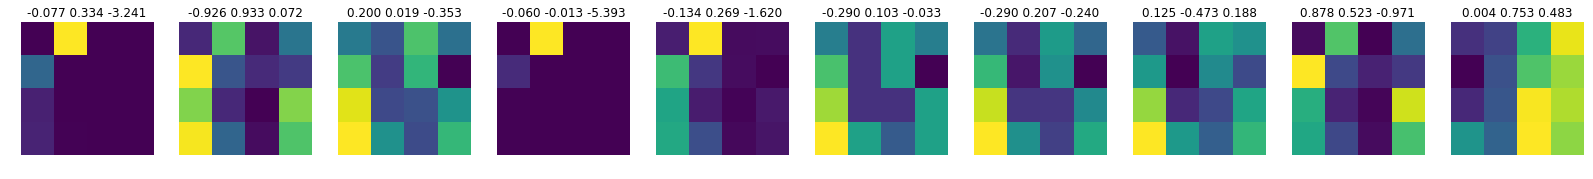

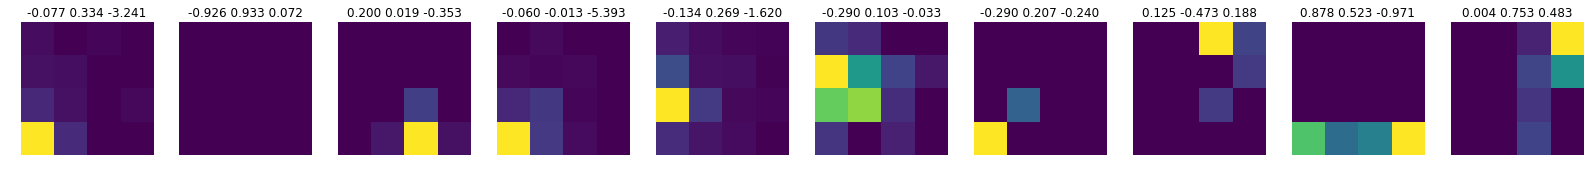

Train loss: 0.3590998731464109 Batch 2000 of 500           epoch: 128
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.5773) tensor(2.8828e-08, grad_fn=<SumBackward0>) tensor(171.7446, grad_fn=<AbsBackward>) tensor(-373.3788, grad_fn=<SumBackward0>)


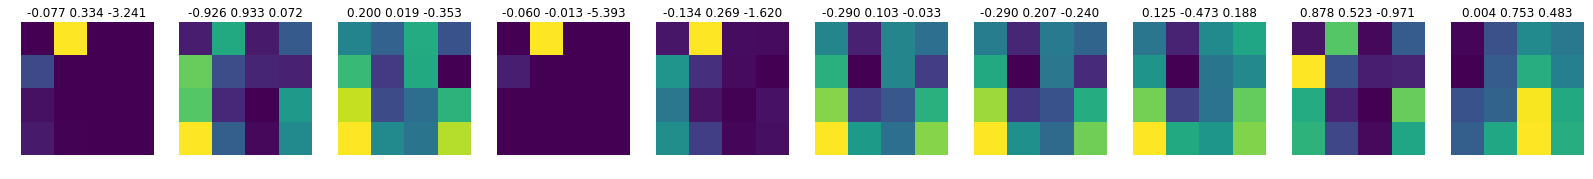

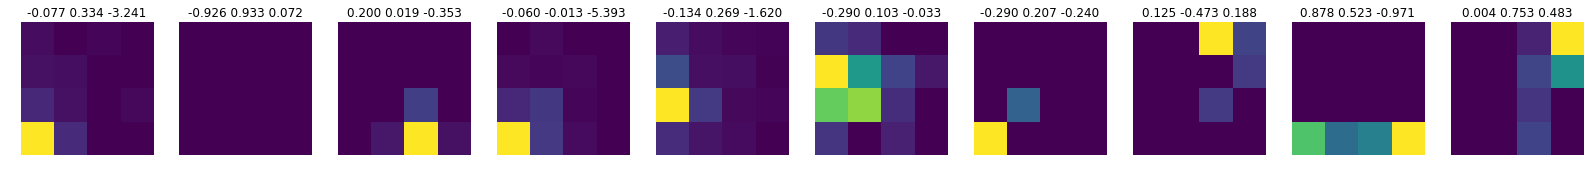

Train loss: 0.5776135735889418 Batch 2000 of 500           epoch: 129
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3715) tensor(4.7359e-09, grad_fn=<SumBackward0>) tensor(80.8092, grad_fn=<AbsBackward>) tensor(-178.9243, grad_fn=<SumBackward0>)


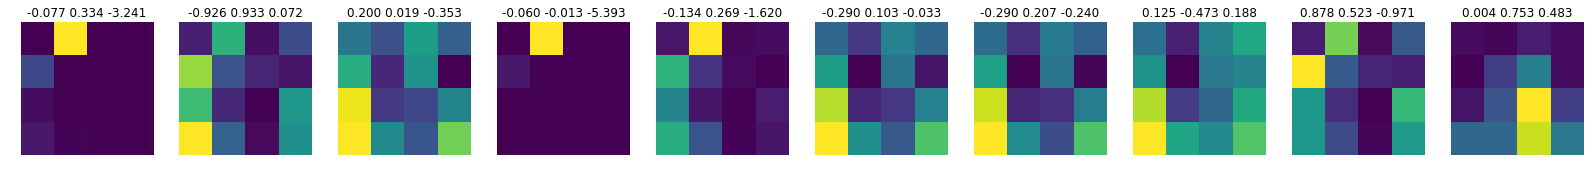

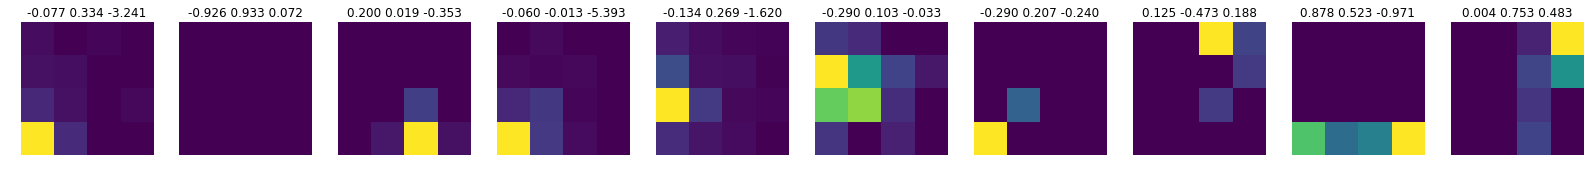

Train loss: 0.37099746178102133 Batch 2000 of 500           epoch: 130
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3441) tensor(5.5596e-08, grad_fn=<SumBackward0>) tensor(79.1820, grad_fn=<AbsBackward>) tensor(-116.5328, grad_fn=<SumBackward0>)


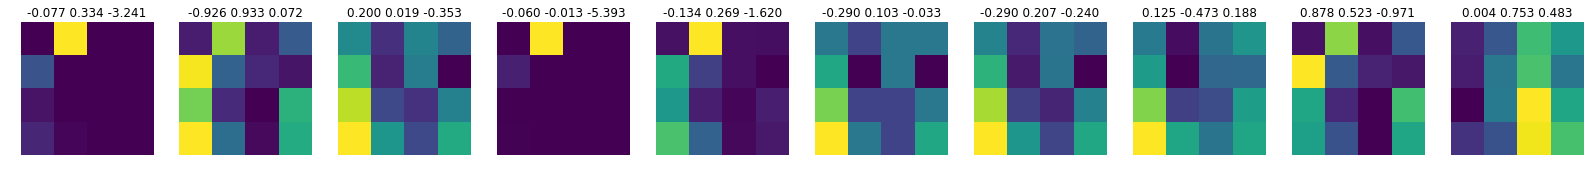

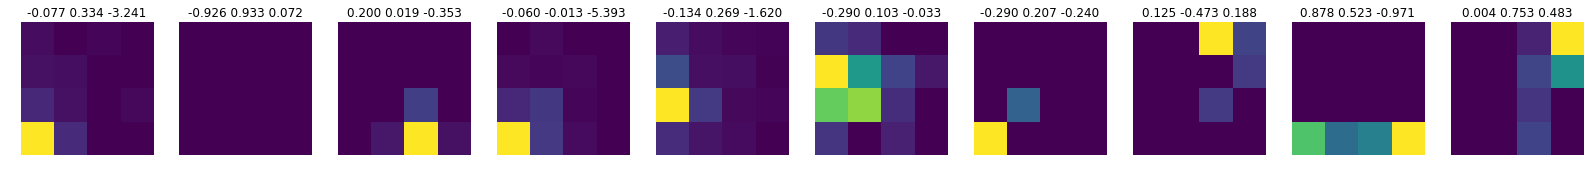

Train loss: 0.3441529299265902 Batch 2000 of 500           epoch: 131
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4480) tensor(2.5487e-08, grad_fn=<SumBackward0>) tensor(107.6493, grad_fn=<AbsBackward>) tensor(-193.8165, grad_fn=<SumBackward0>)


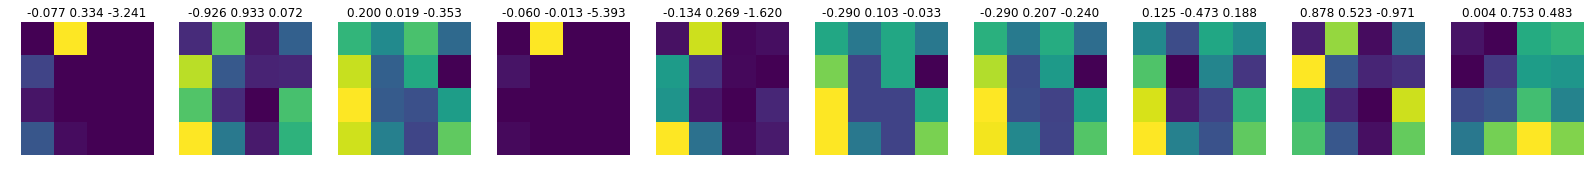

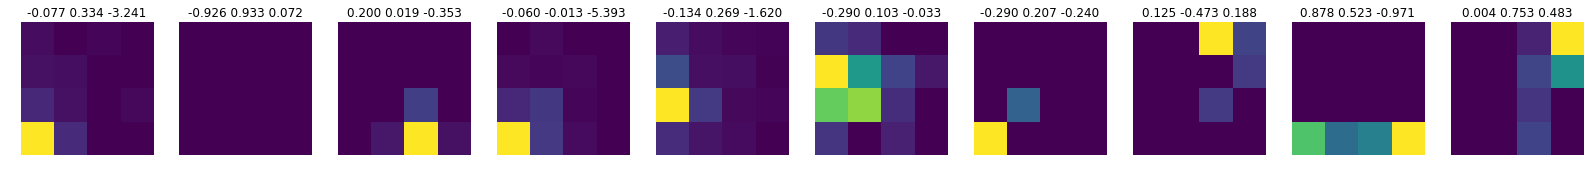

Train loss: 0.44722312026194044 Batch 2000 of 500           epoch: 132
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3430) tensor(4.5008e-08, grad_fn=<SumBackward0>) tensor(59.4544, grad_fn=<AbsBackward>) tensor(-109.4391, grad_fn=<SumBackward0>)


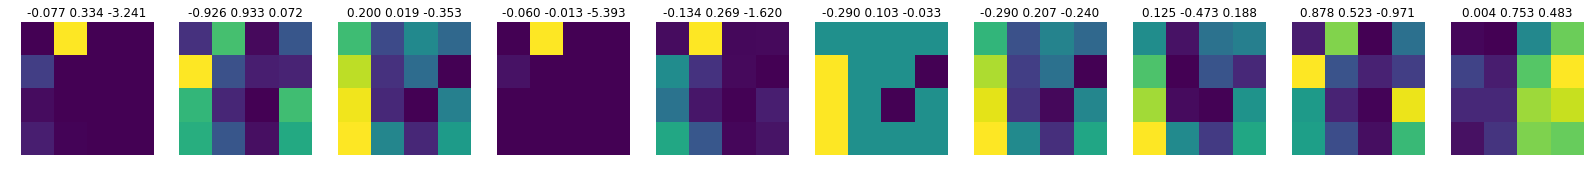

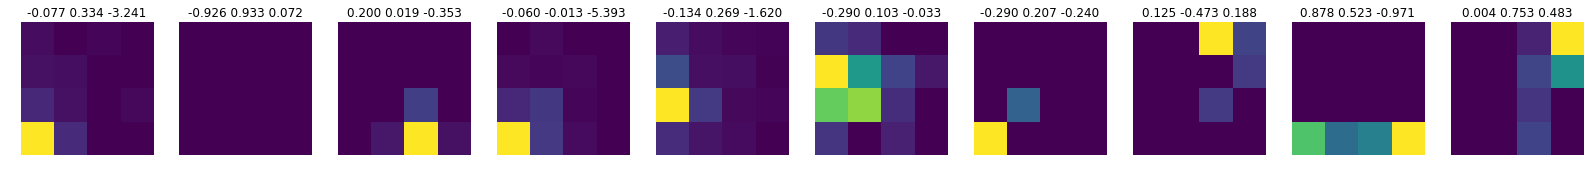

Train loss: 0.3429958626545885 Batch 2000 of 500           epoch: 133
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3230) tensor(2.8023e-08, grad_fn=<SumBackward0>) tensor(64.6444, grad_fn=<AbsBackward>) tensor(-156.8893, grad_fn=<SumBackward0>)


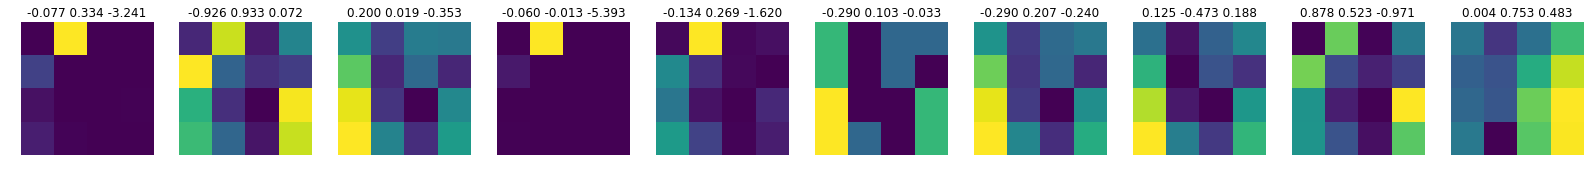

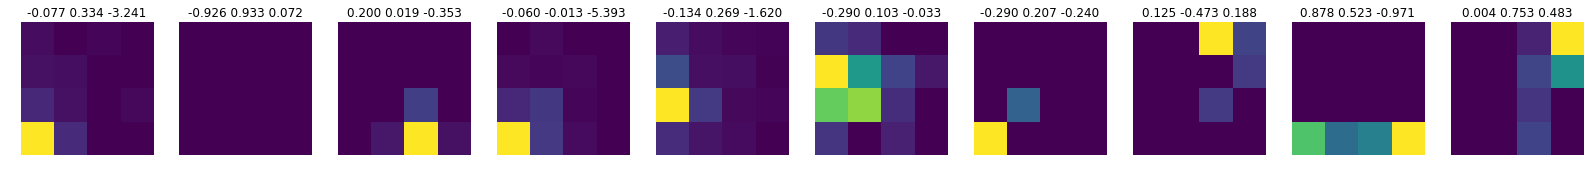

Train loss: 0.32243144988048245 Batch 2000 of 500           epoch: 134
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4113) tensor(6.2013e-09, grad_fn=<SumBackward0>) tensor(97.9781, grad_fn=<AbsBackward>) tensor(-195.7654, grad_fn=<SumBackward0>)


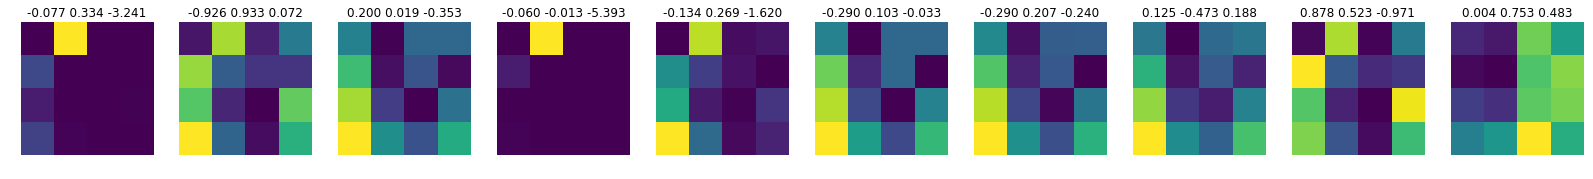

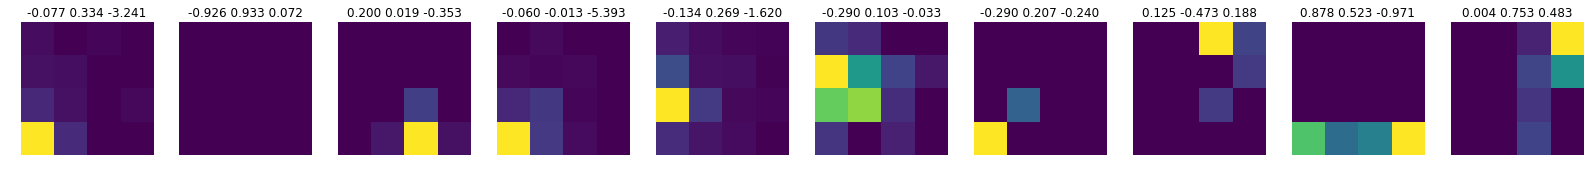

Train loss: 0.4113516512450836 Batch 2000 of 500           epoch: 135
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4127) tensor(4.1683e-08, grad_fn=<SumBackward0>) tensor(91.3574, grad_fn=<AbsBackward>) tensor(-164.6790, grad_fn=<SumBackward0>)


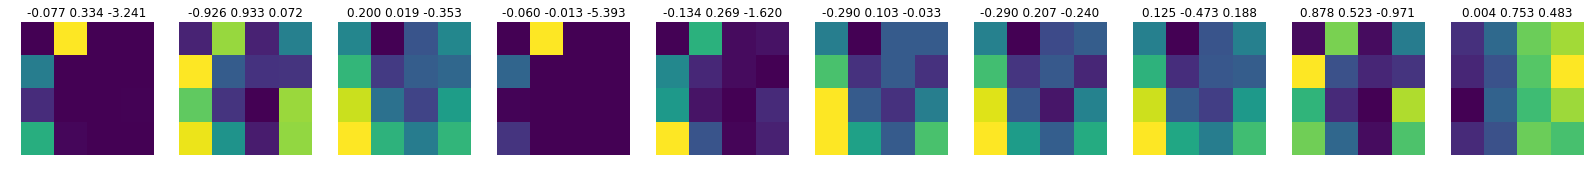

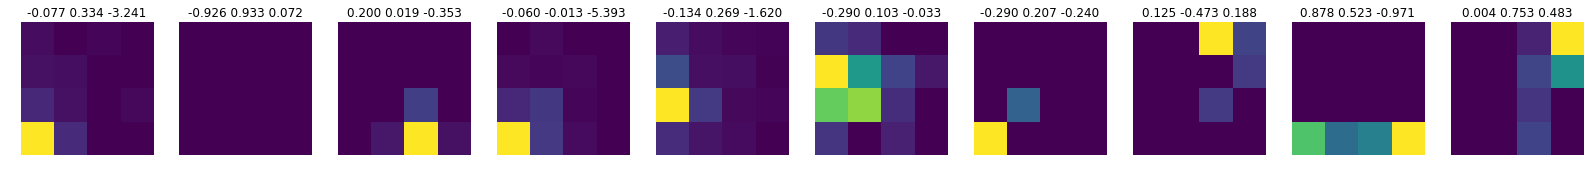

Train loss: 0.412131599131396 Batch 2000 of 500           epoch: 136
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4031) tensor(1.4257e-08, grad_fn=<SumBackward0>) tensor(88.4342, grad_fn=<AbsBackward>) tensor(-166.9440, grad_fn=<SumBackward0>)


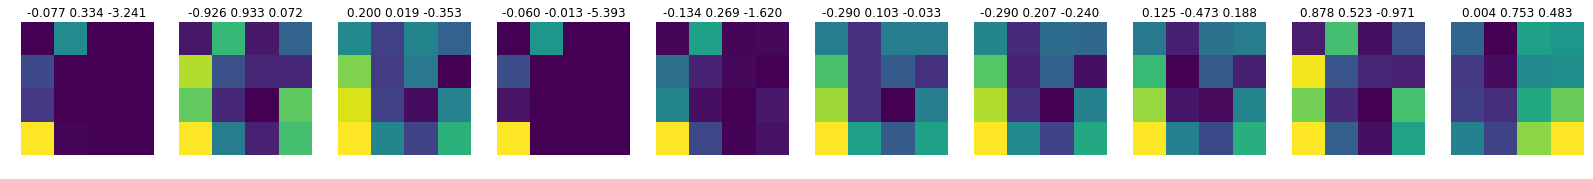

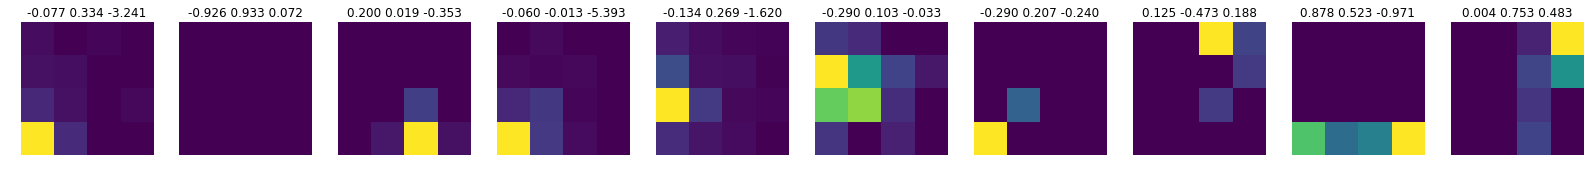

Train loss: 0.40250303271247084 Batch 2000 of 500           epoch: 137
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4955) tensor(1.4296e-07, grad_fn=<SumBackward0>) tensor(129.0964, grad_fn=<AbsBackward>) tensor(-222.3778, grad_fn=<SumBackward0>)


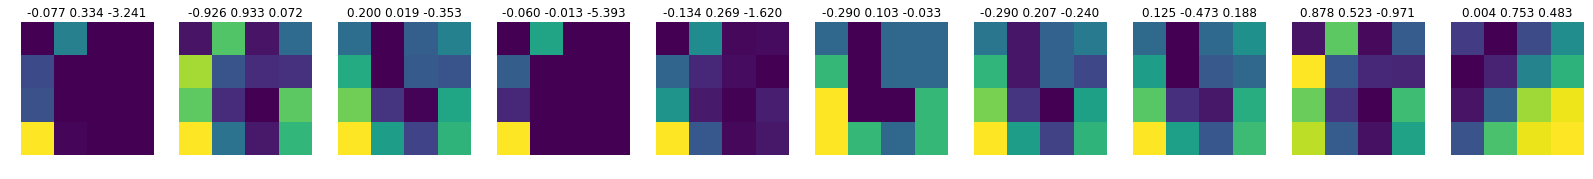

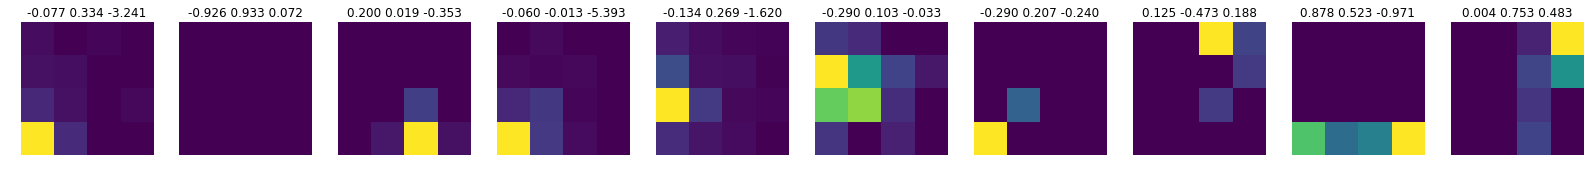

Train loss: 0.4928168806057556 Batch 2000 of 500           epoch: 138
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4350) tensor(9.8102e-09, grad_fn=<SumBackward0>) tensor(103.6399, grad_fn=<AbsBackward>) tensor(-182.5672, grad_fn=<SumBackward0>)


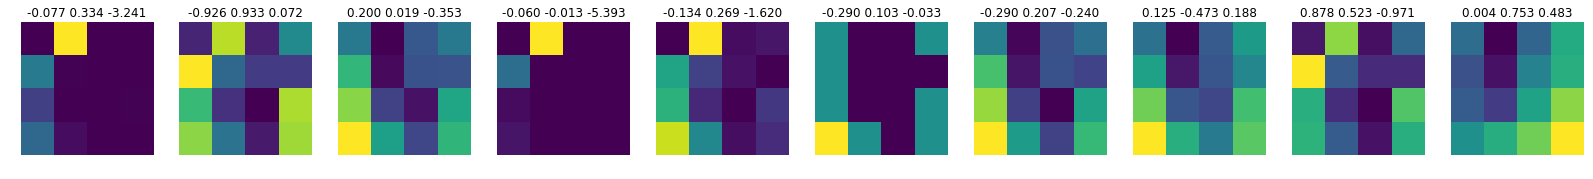

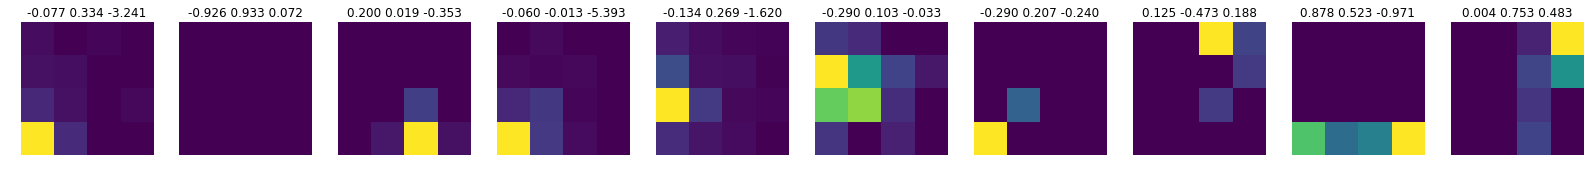

Train loss: 0.4350497519556019 Batch 2000 of 500           epoch: 139
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4127) tensor(2.6763e-08, grad_fn=<SumBackward0>) tensor(99.5822, grad_fn=<AbsBackward>) tensor(-155.4346, grad_fn=<SumBackward0>)


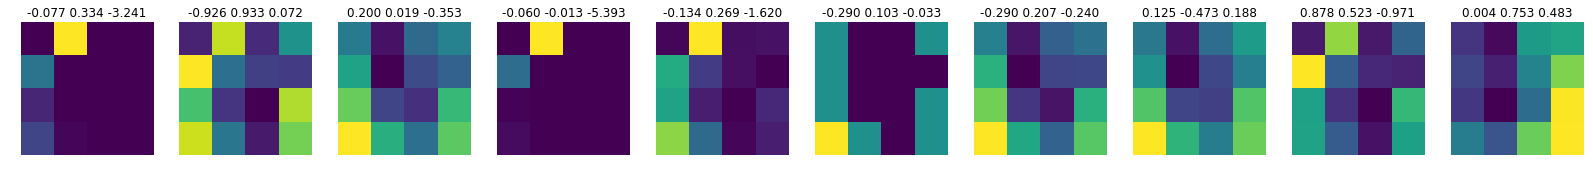

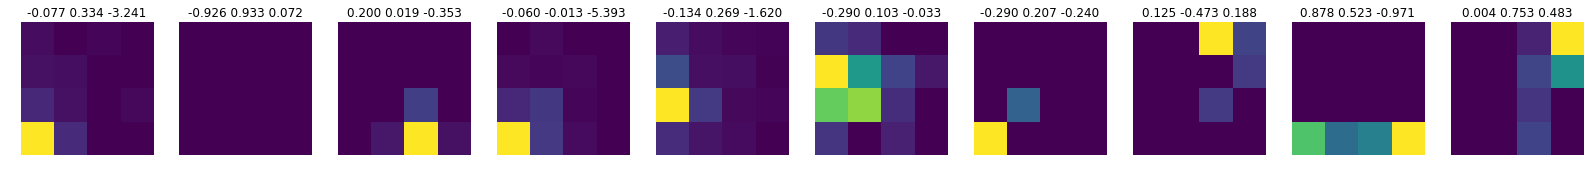

Train loss: 0.41269764105483797 Batch 2000 of 500           epoch: 140
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3863) tensor(2.4498e-09, grad_fn=<SumBackward0>) tensor(88.3839, grad_fn=<AbsBackward>) tensor(-176.6218, grad_fn=<SumBackward0>)


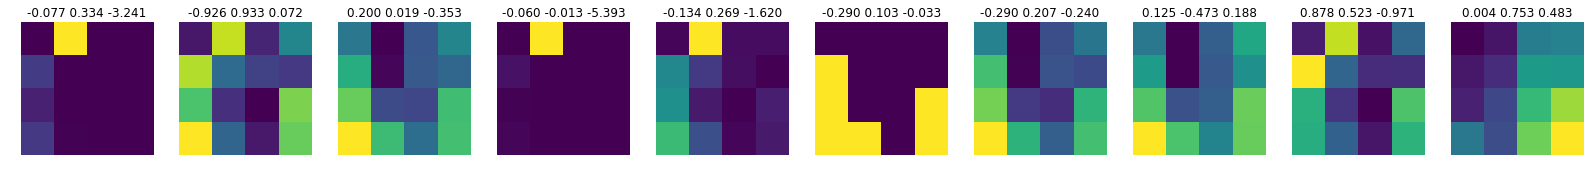

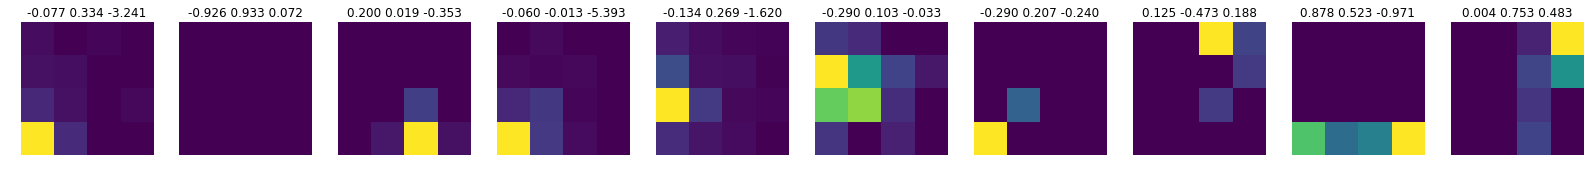

Train loss: 0.3860973385247352 Batch 2000 of 500           epoch: 141
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4935) tensor(2.2453e-08, grad_fn=<SumBackward0>) tensor(129.6283, grad_fn=<AbsBackward>) tensor(-264.1454, grad_fn=<SumBackward0>)


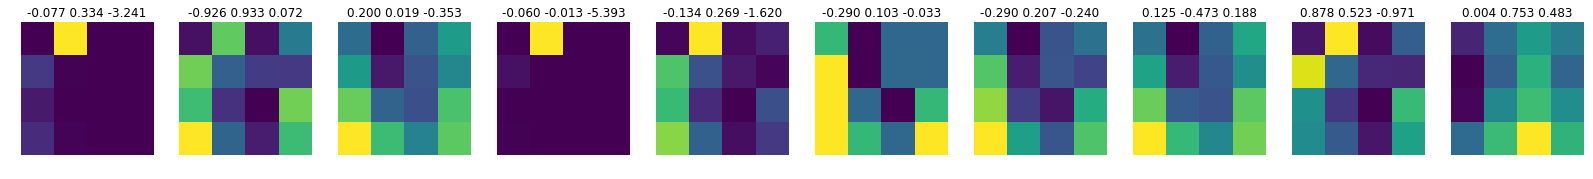

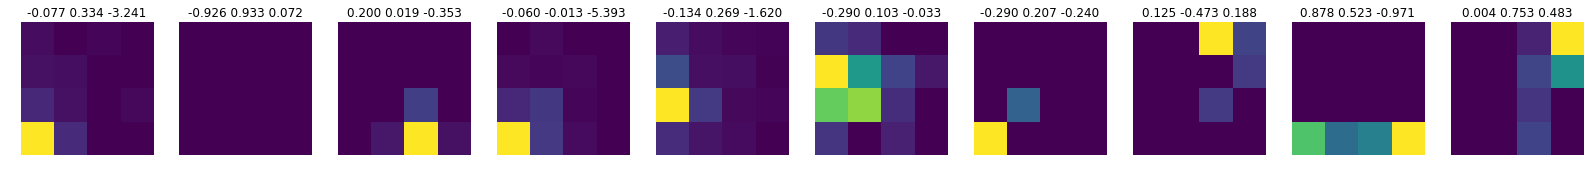

Train loss: 0.49300571999951026 Batch 2000 of 500           epoch: 142
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3464) tensor(2.2147e-08, grad_fn=<SumBackward0>) tensor(70.5406, grad_fn=<AbsBackward>) tensor(-113.8121, grad_fn=<SumBackward0>)


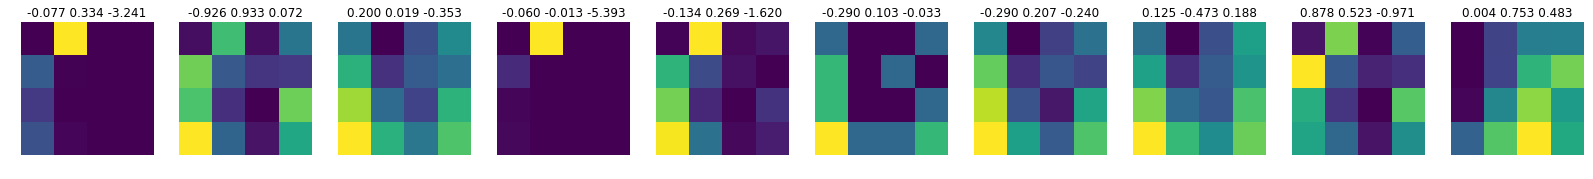

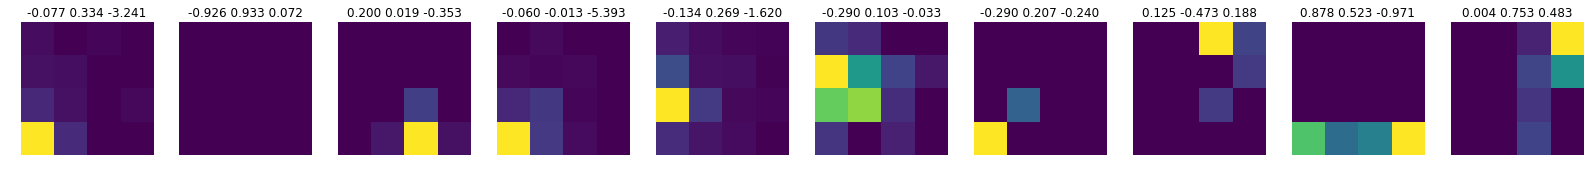

Train loss: 0.3453176328734475 Batch 2000 of 500           epoch: 143
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3504) tensor(6.9644e-09, grad_fn=<SumBackward0>) tensor(71.7030, grad_fn=<AbsBackward>) tensor(-116.3993, grad_fn=<SumBackward0>)


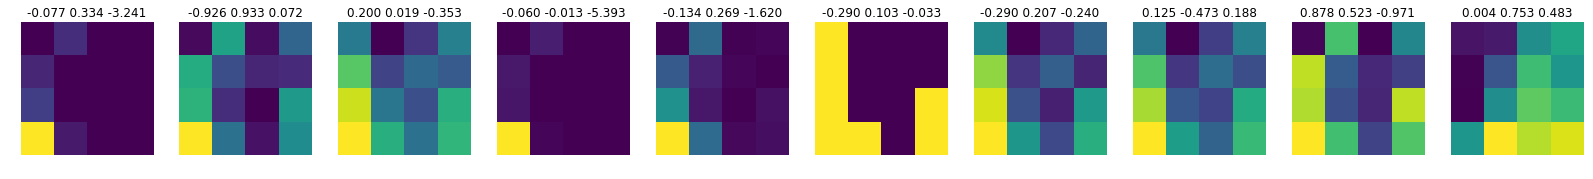

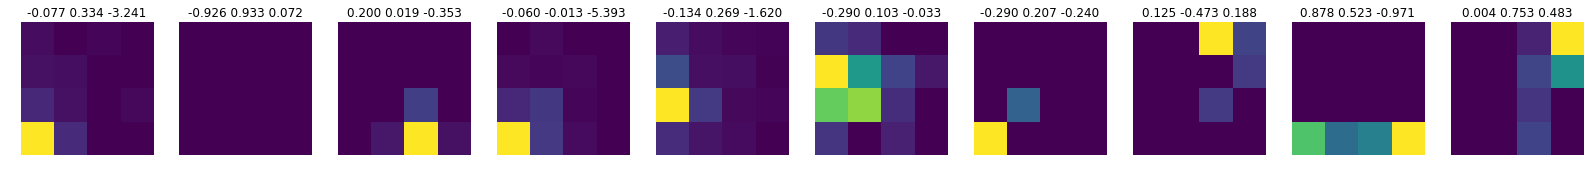

Train loss: 0.35013159243209313 Batch 2000 of 500           epoch: 144
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4337) tensor(8.2476e-08, grad_fn=<SumBackward0>) tensor(102.6778, grad_fn=<AbsBackward>) tensor(-267.7861, grad_fn=<SumBackward0>)


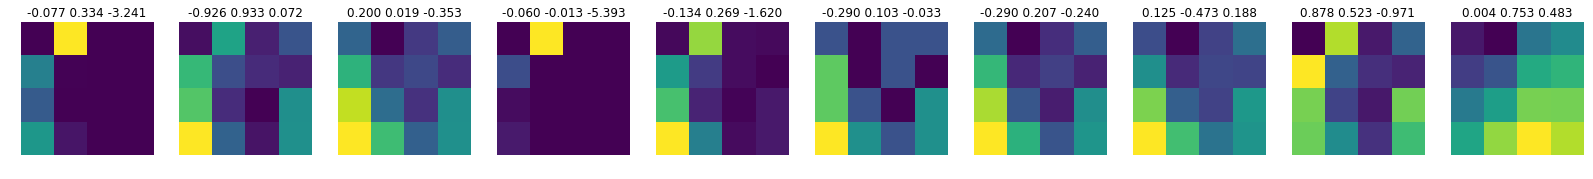

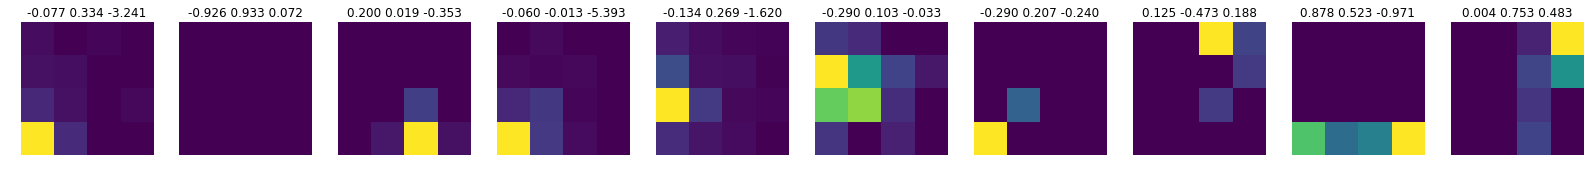

Train loss: 0.43382411477484045 Batch 2000 of 500           epoch: 145
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3018) tensor(5.8116e-09, grad_fn=<SumBackward0>) tensor(45.0462, grad_fn=<AbsBackward>) tensor(-135.7573, grad_fn=<SumBackward0>)


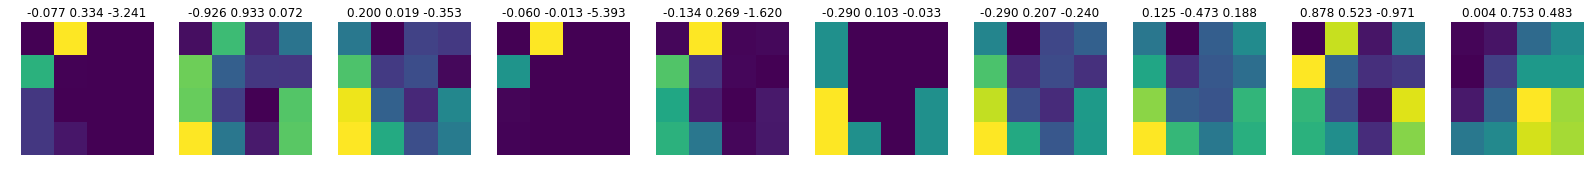

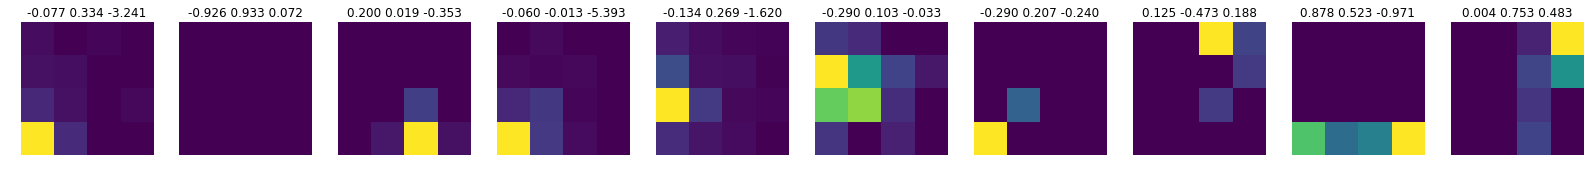

Train loss: 0.30205468551862896 Batch 2000 of 500           epoch: 146
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4470) tensor(9.1897e-09, grad_fn=<SumBackward0>) tensor(99.4164, grad_fn=<AbsBackward>) tensor(-244.3668, grad_fn=<SumBackward0>)


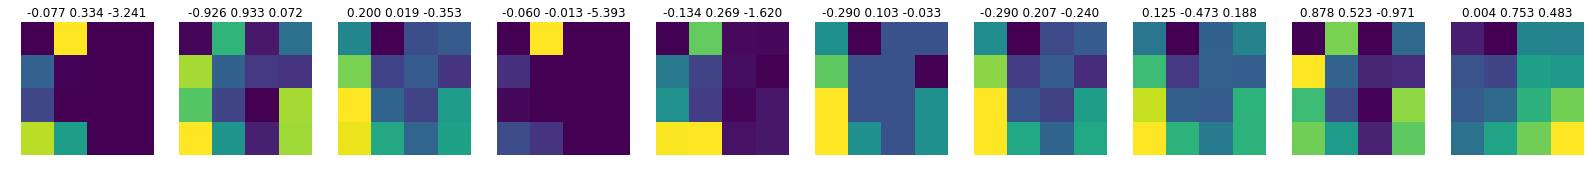

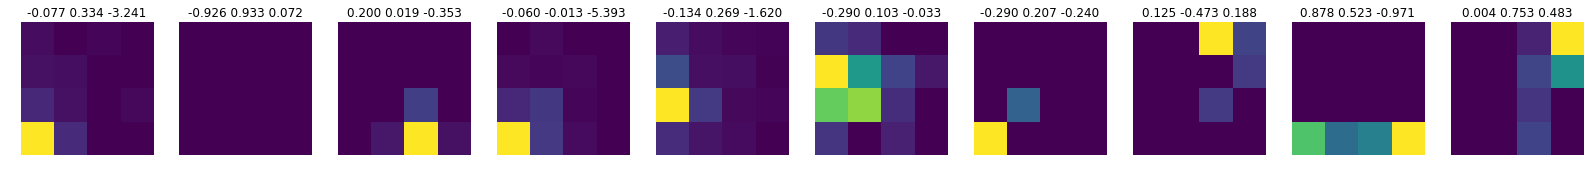

Train loss: 0.44782979792407024 Batch 2000 of 500           epoch: 147
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4552) tensor(2.5446e-08, grad_fn=<SumBackward0>) tensor(112.4048, grad_fn=<AbsBackward>) tensor(-204.2239, grad_fn=<SumBackward0>)


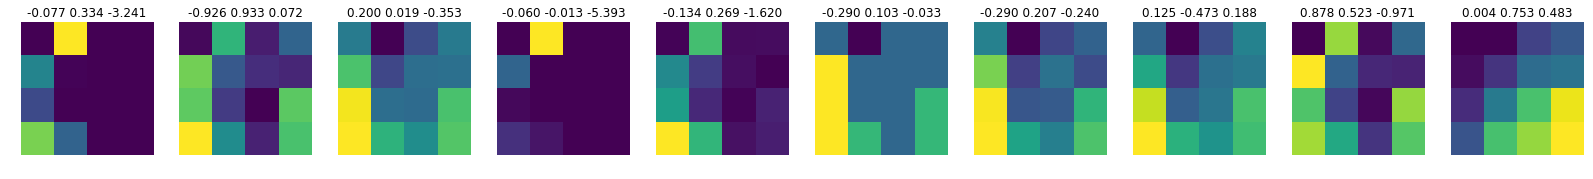

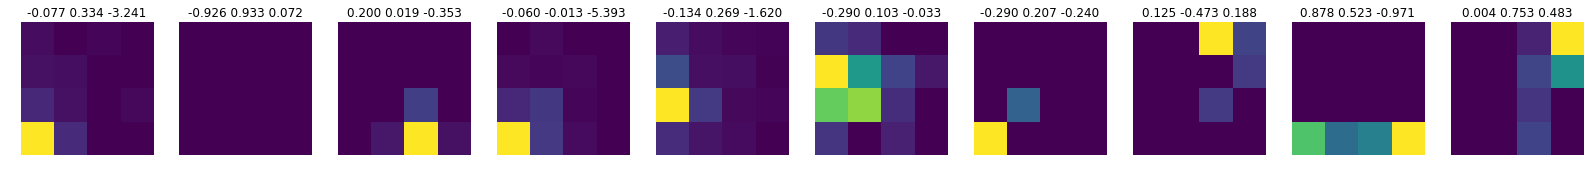

Train loss: 0.4561414739214745 Batch 2000 of 500           epoch: 148
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3777) tensor(8.7912e-09, grad_fn=<SumBackward0>) tensor(79.9730, grad_fn=<AbsBackward>) tensor(-132.0461, grad_fn=<SumBackward0>)


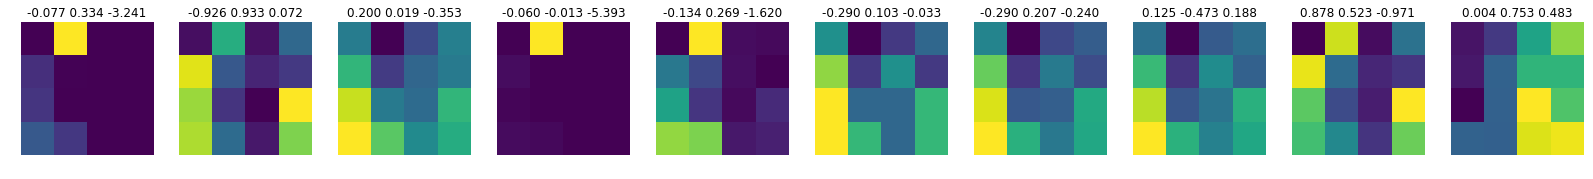

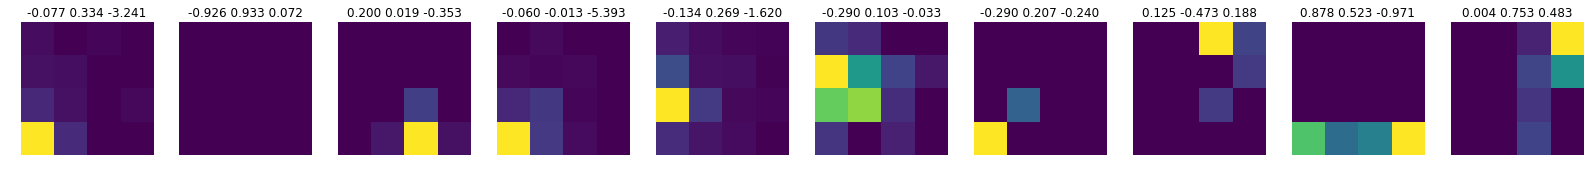

Train loss: 0.3773072484733067 Batch 2000 of 500           epoch: 149
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3751) tensor(1.5353e-08, grad_fn=<SumBackward0>) tensor(81.8149, grad_fn=<AbsBackward>) tensor(-132.0385, grad_fn=<SumBackward0>)


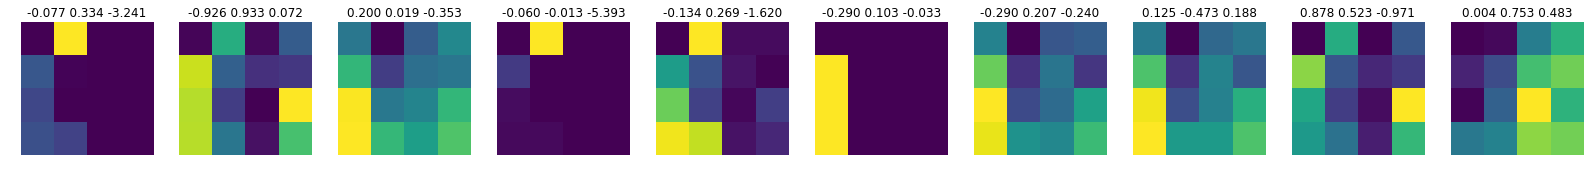

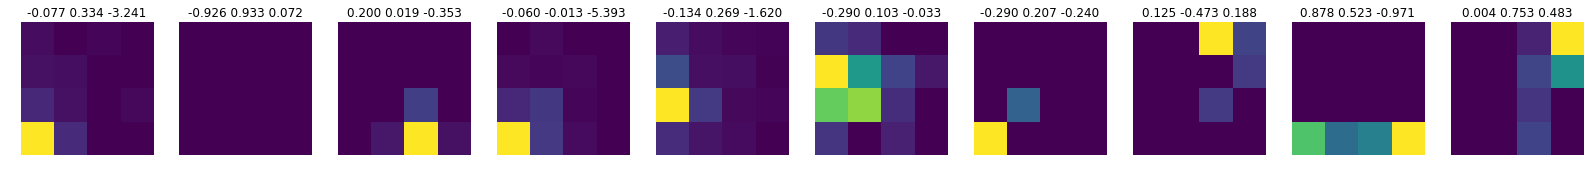

Train loss: 0.37417592497541036 Batch 2000 of 500           epoch: 150
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4696) tensor(2.0801e-08, grad_fn=<SumBackward0>) tensor(122.0157, grad_fn=<AbsBackward>) tensor(-278.8744, grad_fn=<SumBackward0>)


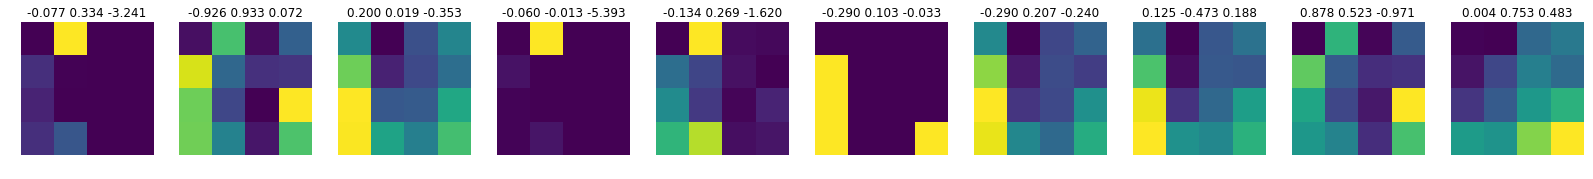

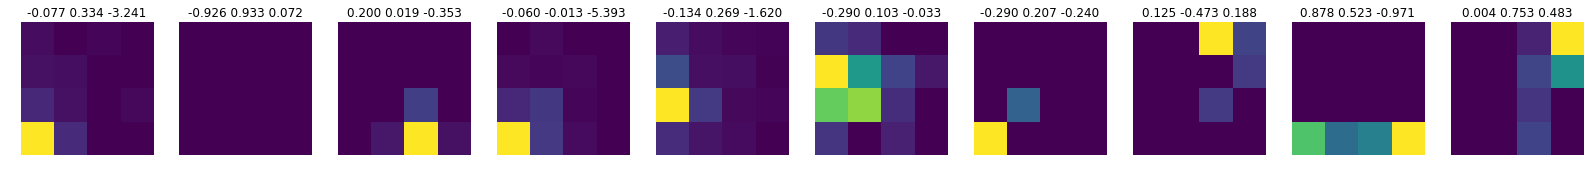

Train loss: 0.46844076546941166 Batch 2000 of 500           epoch: 151
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4190) tensor(2.4870e-08, grad_fn=<SumBackward0>) tensor(92.6263, grad_fn=<AbsBackward>) tensor(-188.4226, grad_fn=<SumBackward0>)


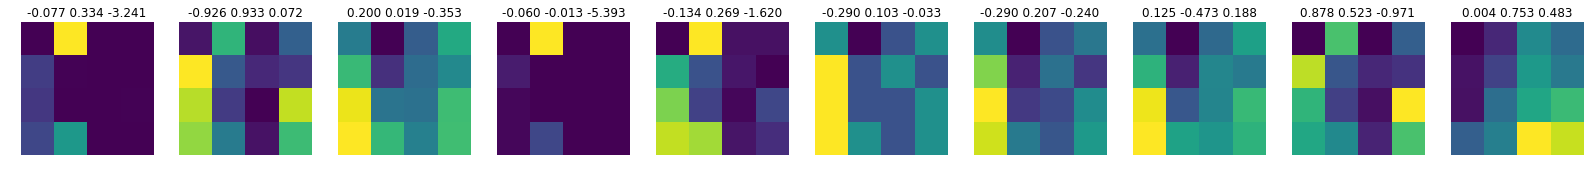

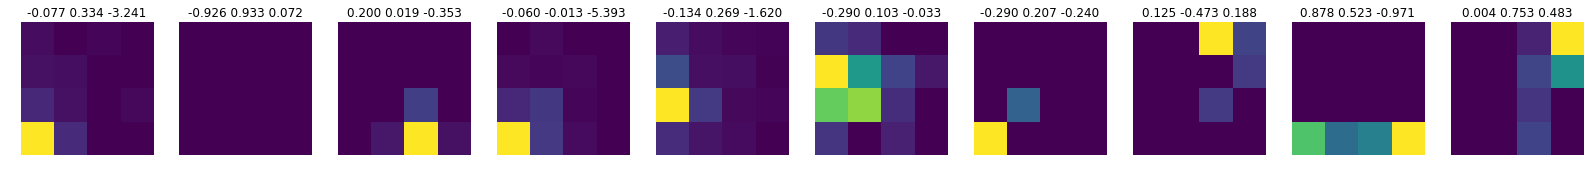

Train loss: 0.41829518100455193 Batch 2000 of 500           epoch: 152
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4498) tensor(2.8741e-08, grad_fn=<SumBackward0>) tensor(109.4471, grad_fn=<AbsBackward>) tensor(-228.4660, grad_fn=<SumBackward0>)


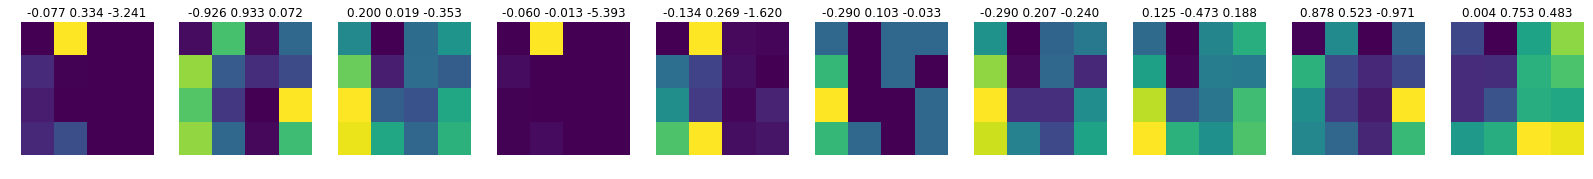

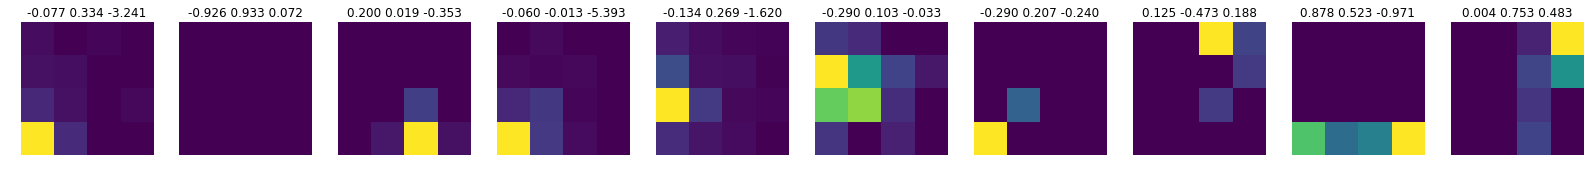

Train loss: 0.4502123484607675 Batch 2000 of 500           epoch: 153
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3309) tensor(1.5559e-09, grad_fn=<SumBackward0>) tensor(62.9927, grad_fn=<AbsBackward>) tensor(-104.6046, grad_fn=<SumBackward0>)


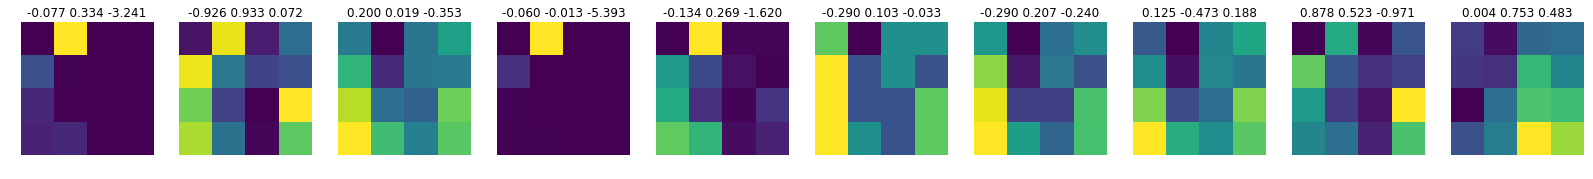

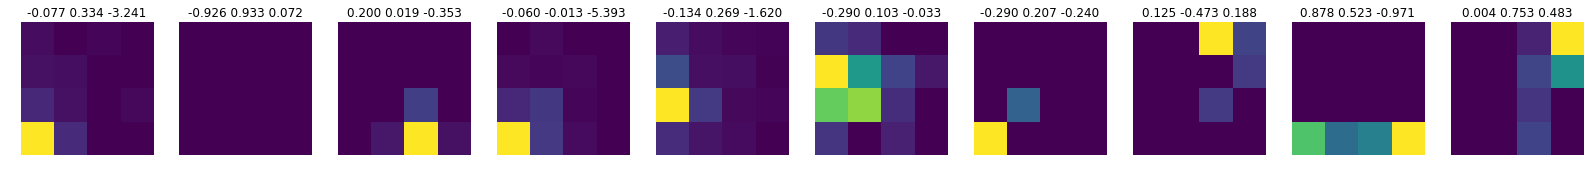

Train loss: 0.33033735075646486 Batch 2000 of 500           epoch: 154
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3805) tensor(3.1959e-08, grad_fn=<SumBackward0>) tensor(72.2623, grad_fn=<AbsBackward>) tensor(-154.1591, grad_fn=<SumBackward0>)


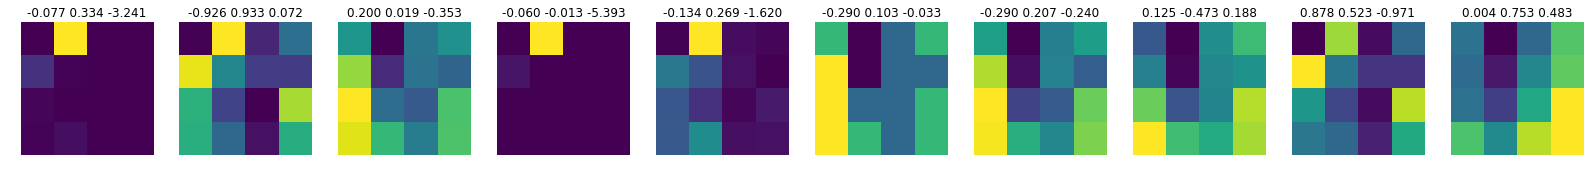

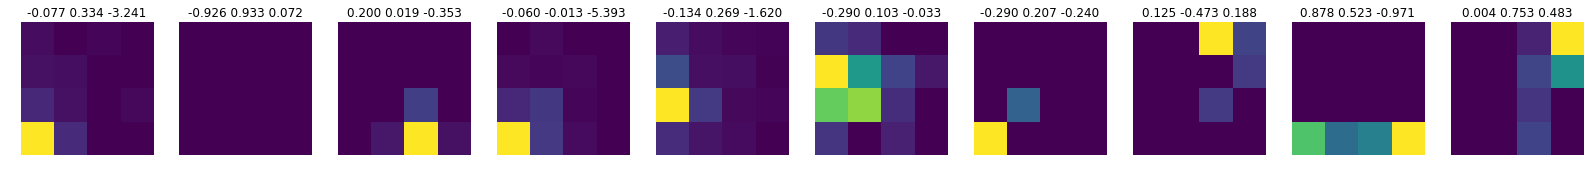

Train loss: 0.38053982099292133 Batch 2000 of 500           epoch: 155
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4622) tensor(1.3636e-07, grad_fn=<SumBackward0>) tensor(120.8868, grad_fn=<AbsBackward>) tensor(-199.9088, grad_fn=<SumBackward0>)


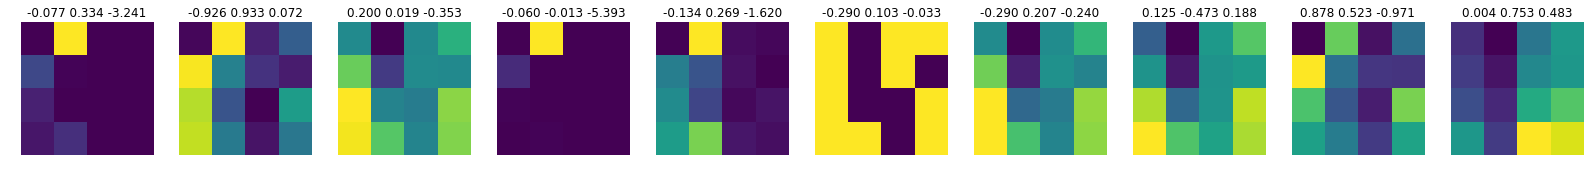

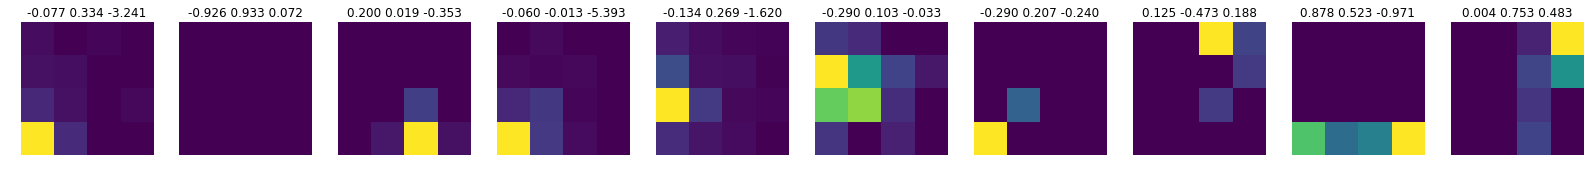

Train loss: 0.4600184221232815 Batch 2000 of 500           epoch: 156
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4038) tensor(1.1691e-07, grad_fn=<SumBackward0>) tensor(82.3804, grad_fn=<AbsBackward>) tensor(-177.9829, grad_fn=<SumBackward0>)


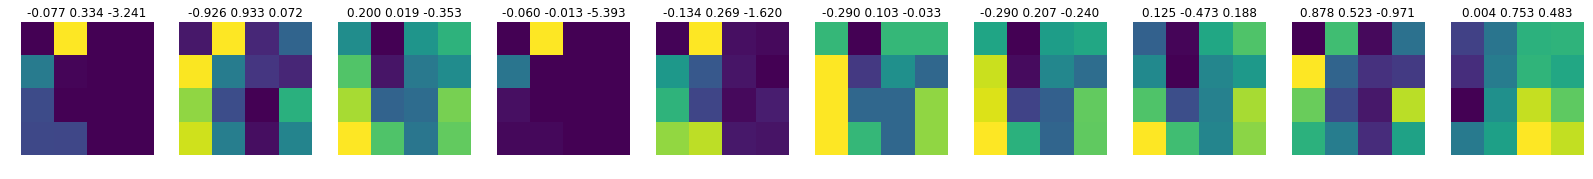

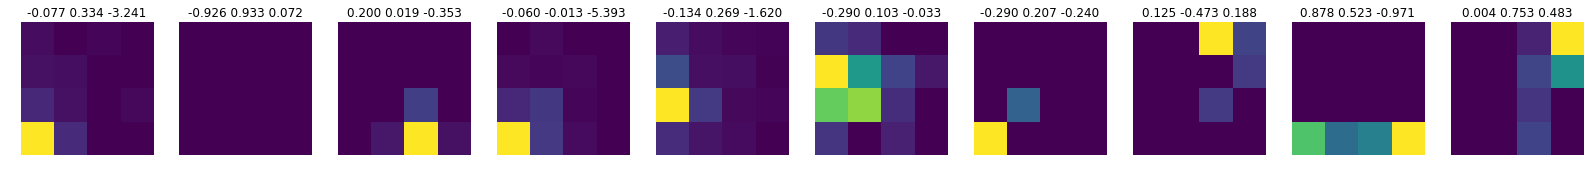

Train loss: 0.4038945960627029 Batch 2000 of 500           epoch: 157
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.5199) tensor(3.1996e-08, grad_fn=<SumBackward0>) tensor(150.5525, grad_fn=<AbsBackward>) tensor(-293.5189, grad_fn=<SumBackward0>)


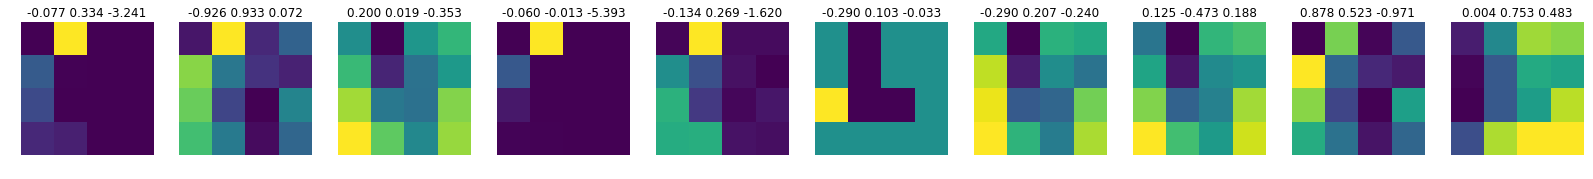

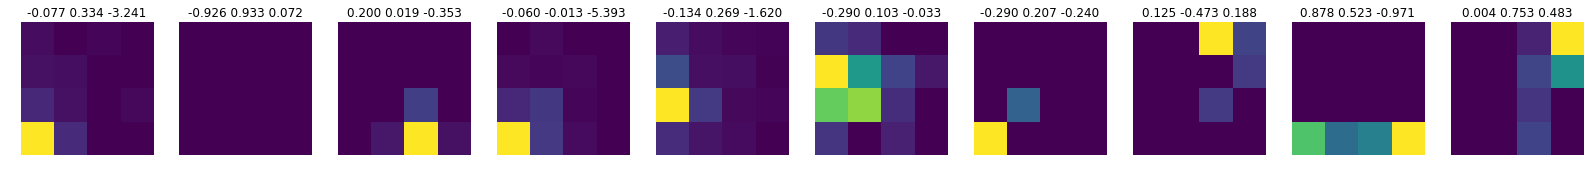

Train loss: 0.5179144234358284 Batch 2000 of 500           epoch: 158
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3948) tensor(1.3855e-08, grad_fn=<SumBackward0>) tensor(86.1883, grad_fn=<AbsBackward>) tensor(-158.9154, grad_fn=<SumBackward0>)


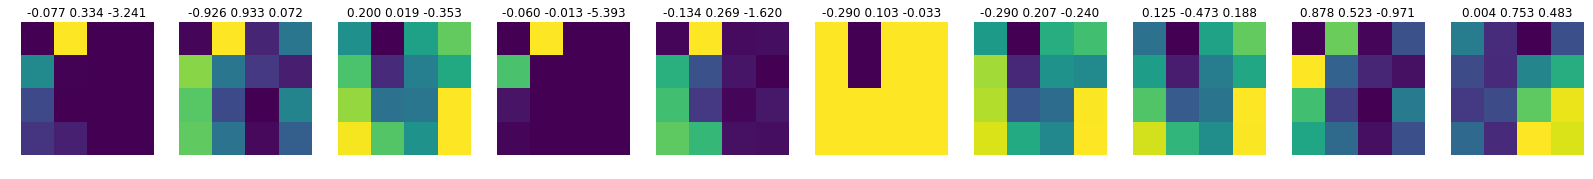

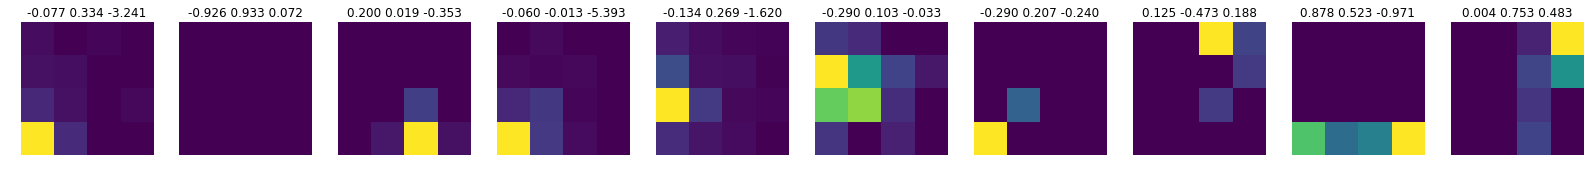

Train loss: 0.3968380848848646 Batch 2000 of 500           epoch: 159
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4781) tensor(2.8091e-08, grad_fn=<SumBackward0>) tensor(140.7368, grad_fn=<AbsBackward>) tensor(-237.8908, grad_fn=<SumBackward0>)


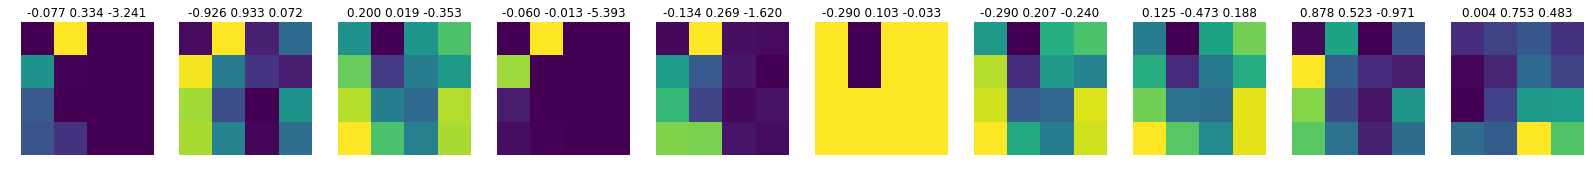

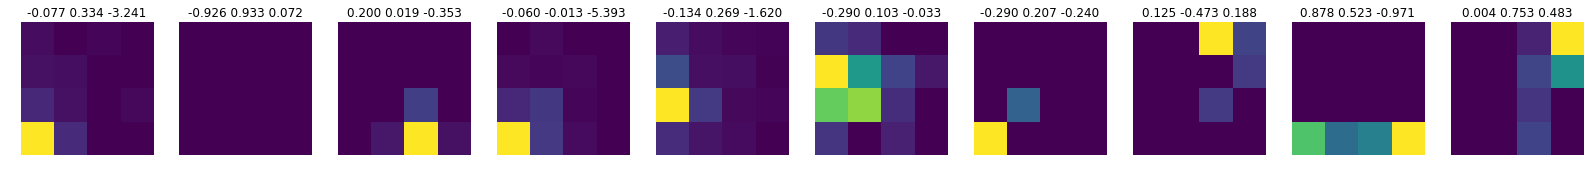

Train loss: 0.47832237722934423 Batch 2000 of 500           epoch: 160
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4366) tensor(7.7821e-09, grad_fn=<SumBackward0>) tensor(104.5117, grad_fn=<AbsBackward>) tensor(-180.8560, grad_fn=<SumBackward0>)


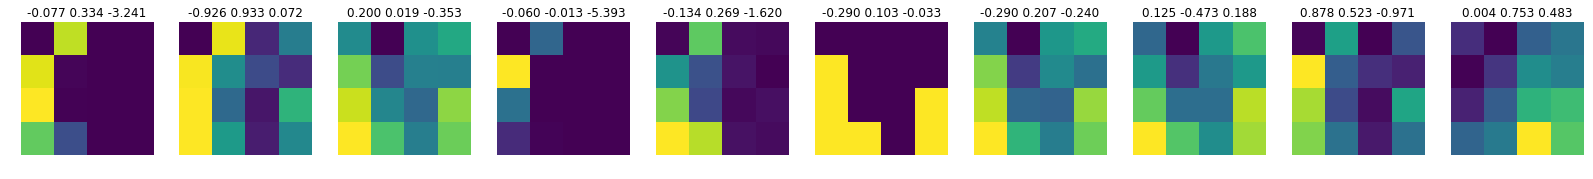

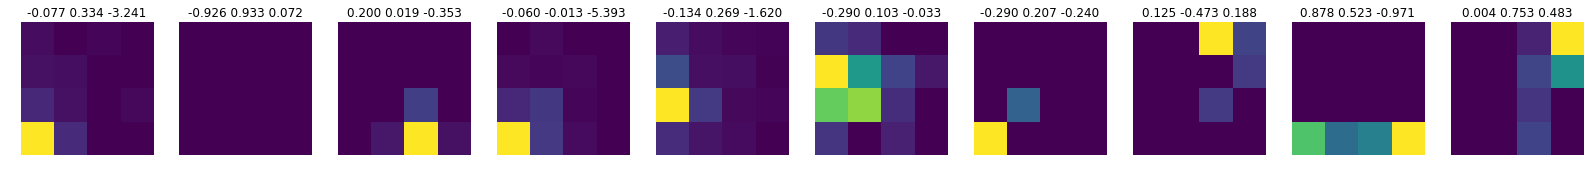

Train loss: 0.4372178596107328 Batch 2000 of 500           epoch: 161
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3633) tensor(2.2451e-08, grad_fn=<SumBackward0>) tensor(78.8206, grad_fn=<AbsBackward>) tensor(-143.5122, grad_fn=<SumBackward0>)


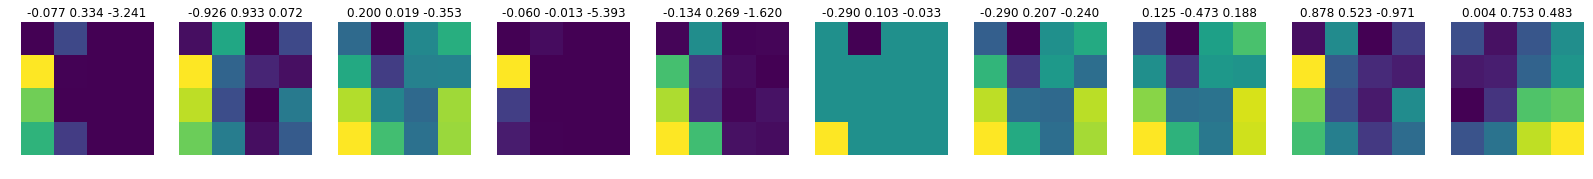

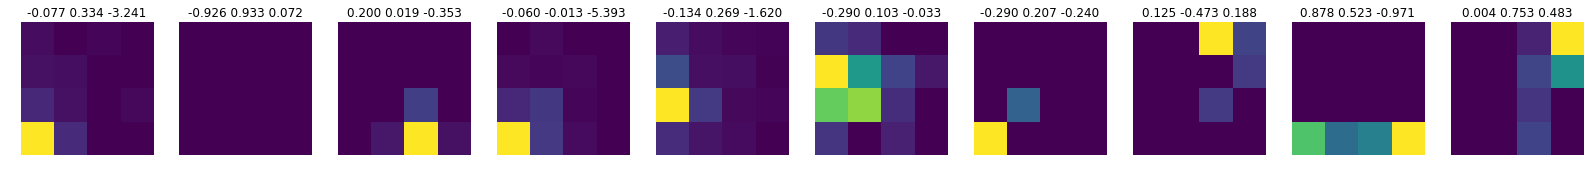

Train loss: 0.3601156754727583 Batch 2000 of 500           epoch: 162
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3660) tensor(4.8329e-08, grad_fn=<SumBackward0>) tensor(87.3880, grad_fn=<AbsBackward>) tensor(-168.5944, grad_fn=<SumBackward0>)


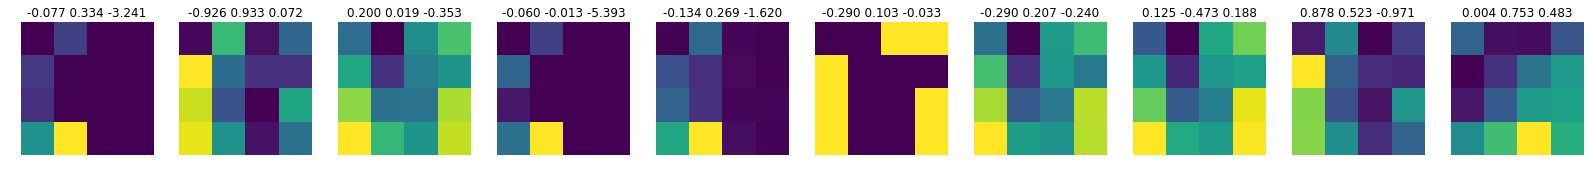

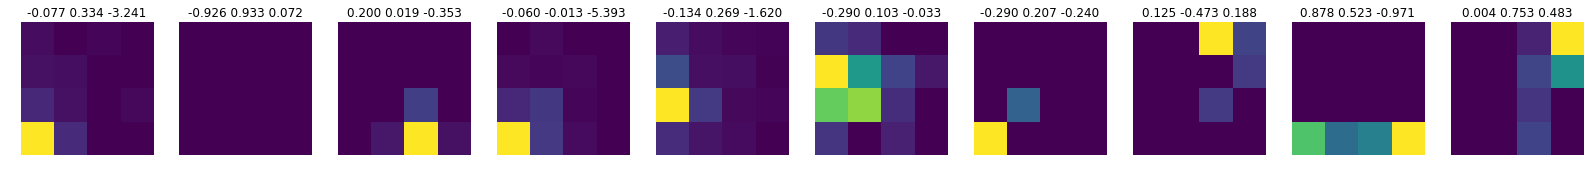

Train loss: 0.3651155561552128 Batch 2000 of 500           epoch: 163
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3067) tensor(1.7223e-08, grad_fn=<SumBackward0>) tensor(61.4222, grad_fn=<AbsBackward>) tensor(-109.1551, grad_fn=<SumBackward0>)


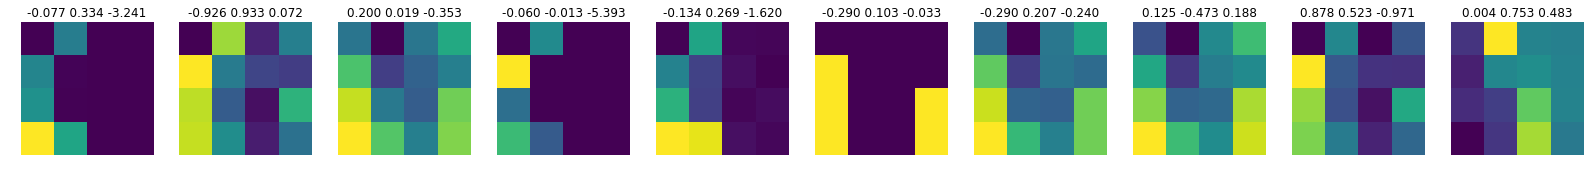

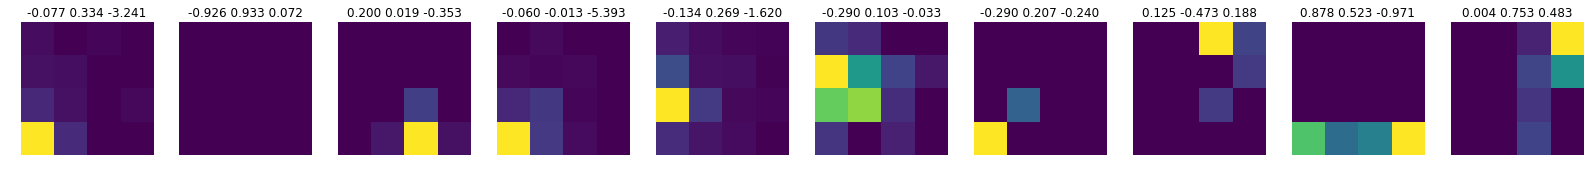

Train loss: 0.30870527476450427 Batch 2000 of 500           epoch: 164
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4107) tensor(1.1929e-07, grad_fn=<SumBackward0>) tensor(95.4226, grad_fn=<AbsBackward>) tensor(-167.5143, grad_fn=<SumBackward0>)


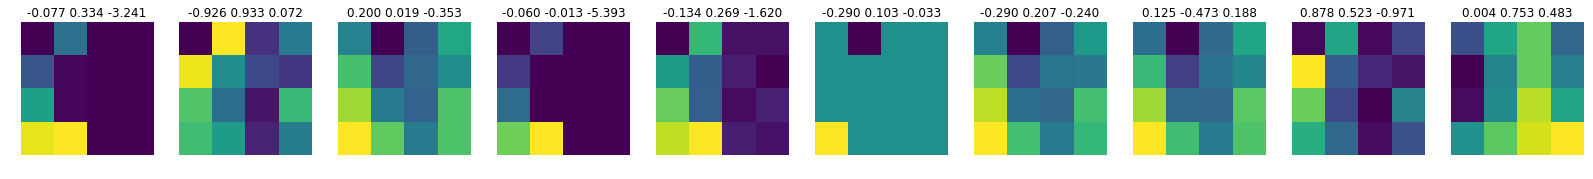

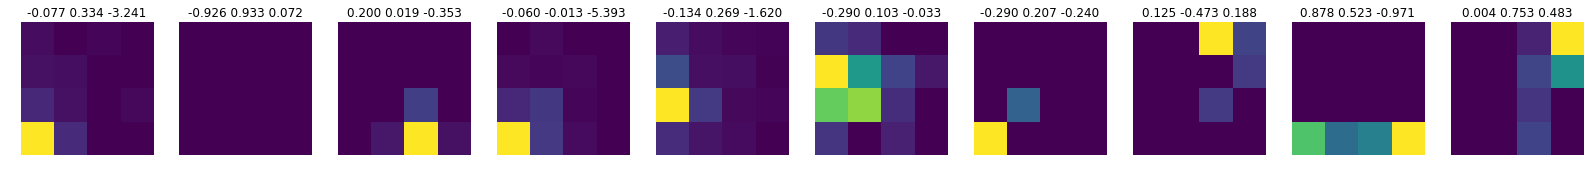

Train loss: 0.41311846838722105 Batch 2000 of 500           epoch: 165
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4225) tensor(1.5124e-08, grad_fn=<SumBackward0>) tensor(97.7115, grad_fn=<AbsBackward>) tensor(-202.7126, grad_fn=<SumBackward0>)


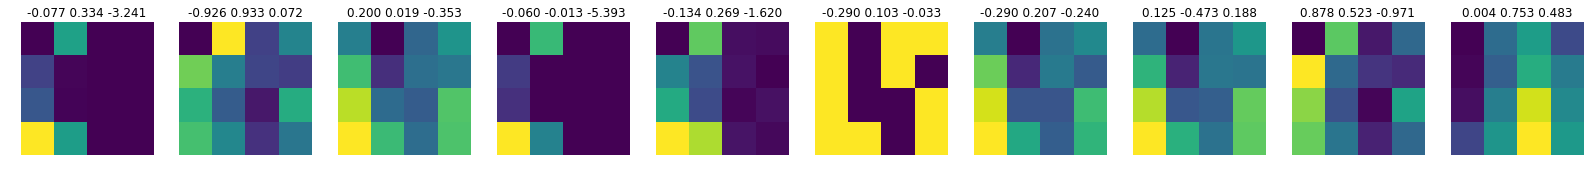

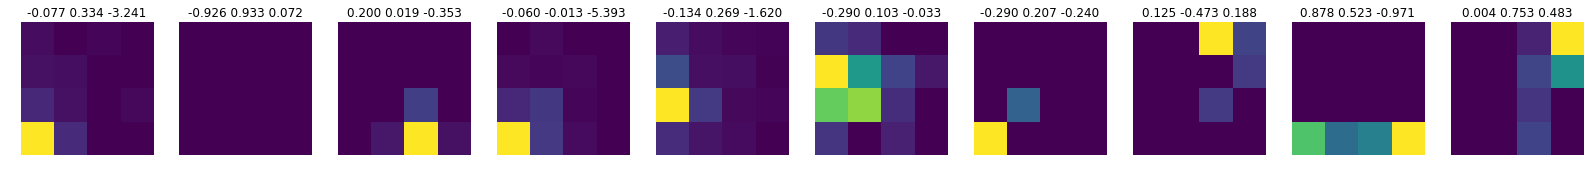

Train loss: 0.42240380060861576 Batch 2000 of 500           epoch: 166
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3648) tensor(6.5239e-08, grad_fn=<SumBackward0>) tensor(77.9059, grad_fn=<AbsBackward>) tensor(-181.9924, grad_fn=<SumBackward0>)


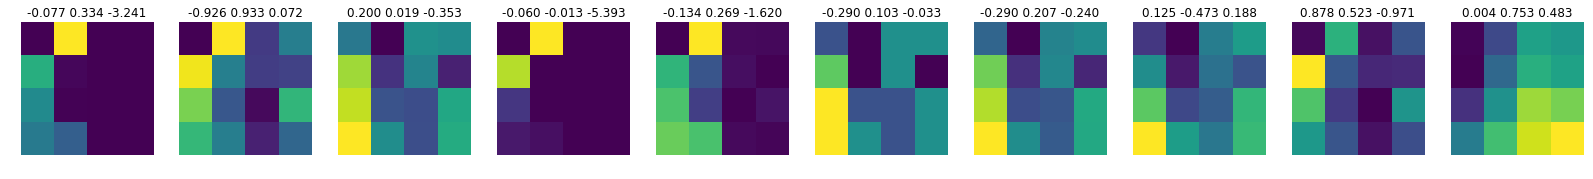

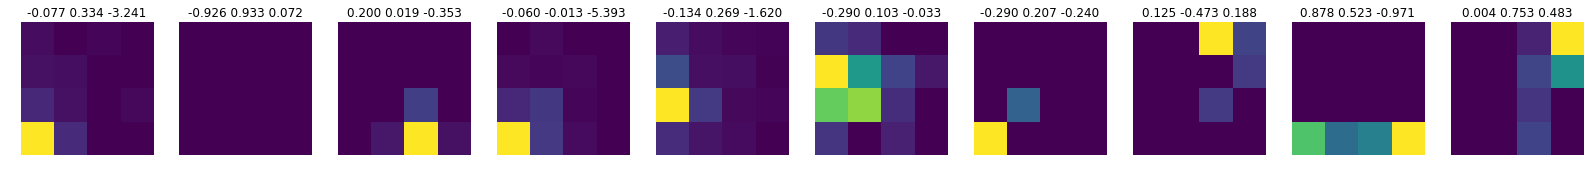

Train loss: 0.364356645518613 Batch 2000 of 500           epoch: 167
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3642) tensor(2.5843e-08, grad_fn=<SumBackward0>) tensor(67.4049, grad_fn=<AbsBackward>) tensor(-144.8517, grad_fn=<SumBackward0>)


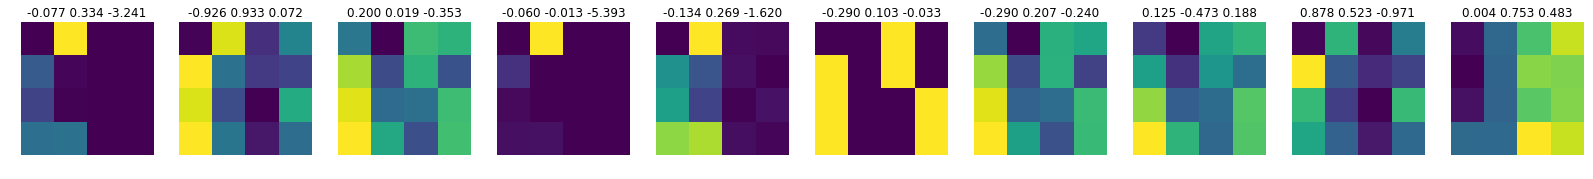

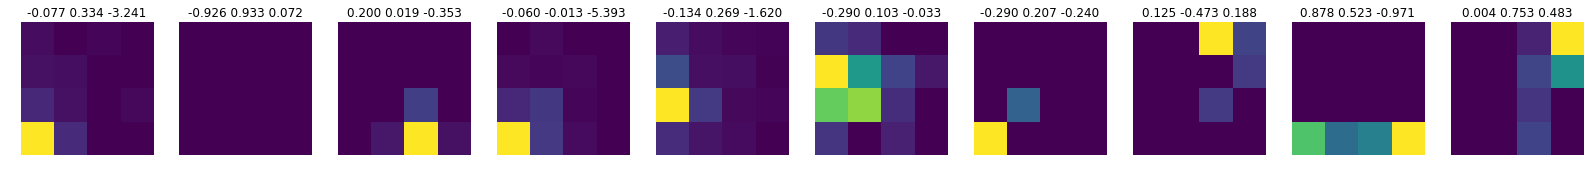

Train loss: 0.36470378580468316 Batch 2000 of 500           epoch: 168
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4592) tensor(2.4037e-09, grad_fn=<SumBackward0>) tensor(107.3325, grad_fn=<AbsBackward>) tensor(-219.2165, grad_fn=<SumBackward0>)


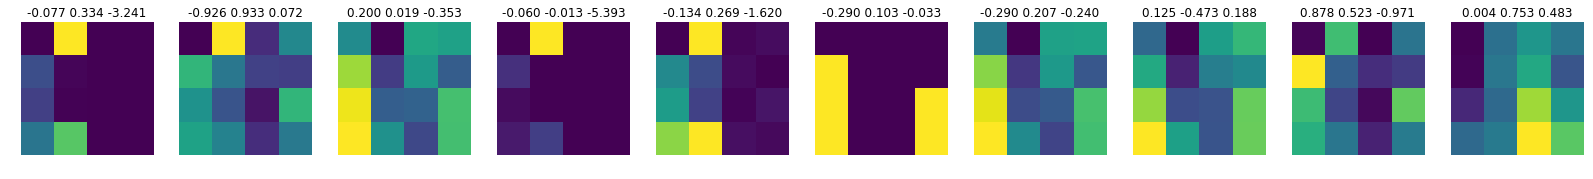

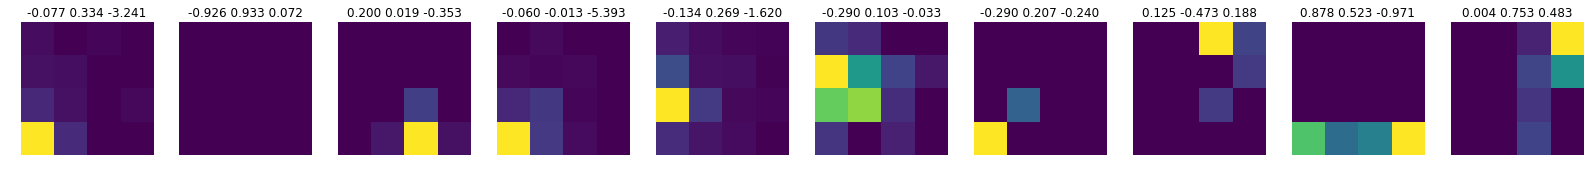

Train loss: 0.4585533050785455 Batch 2000 of 500           epoch: 169
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4363) tensor(4.6440e-08, grad_fn=<SumBackward0>) tensor(107.3450, grad_fn=<AbsBackward>) tensor(-175.8575, grad_fn=<SumBackward0>)


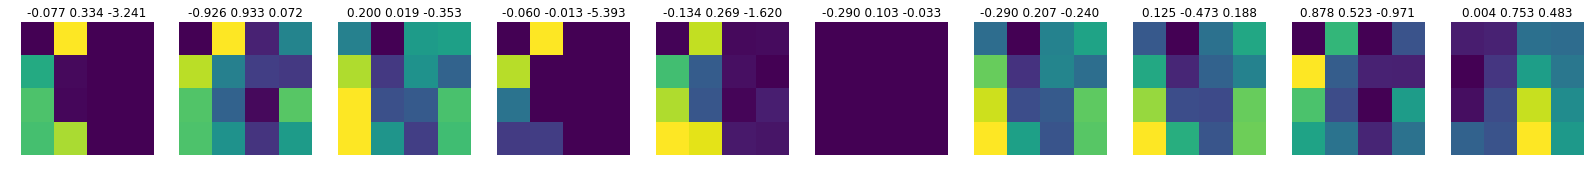

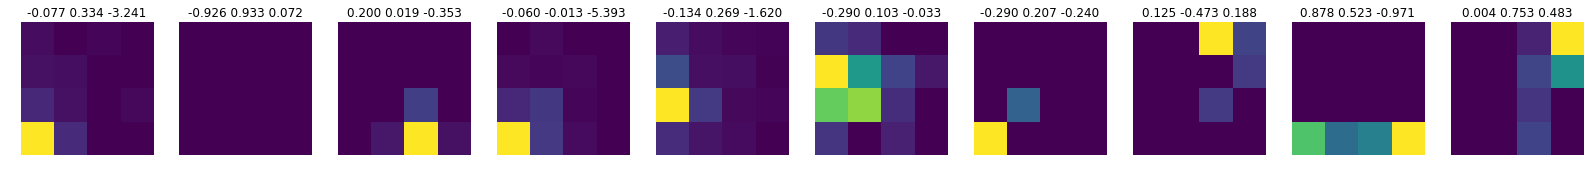

Train loss: 0.4356005395194582 Batch 2000 of 500           epoch: 170
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2685) tensor(4.6402e-08, grad_fn=<SumBackward0>) tensor(35.8550, grad_fn=<AbsBackward>) tensor(-91.5527, grad_fn=<SumBackward0>)


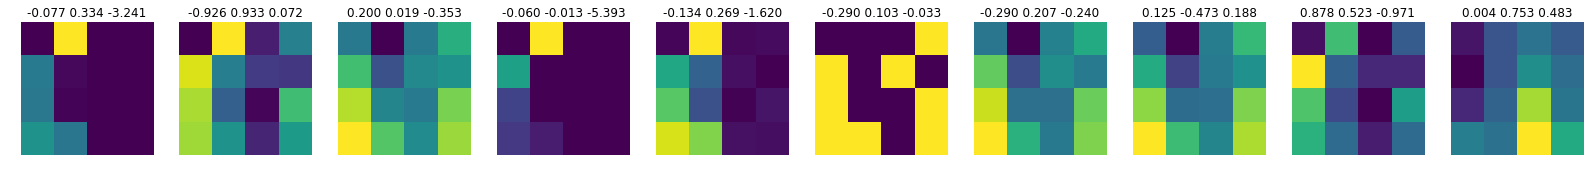

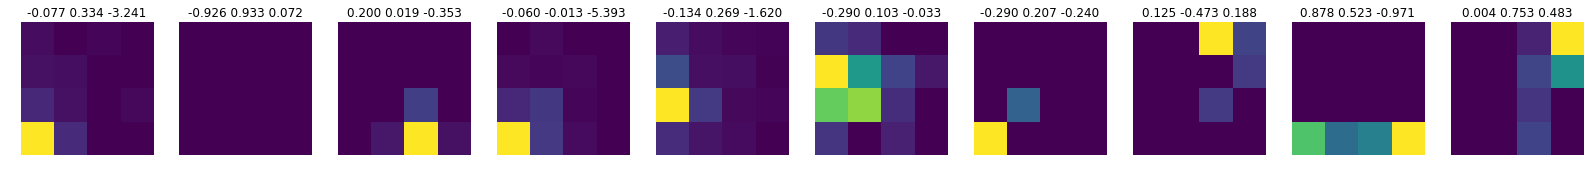

Train loss: 0.26857062367784146 Batch 2000 of 500           epoch: 171
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4791) tensor(6.8823e-09, grad_fn=<SumBackward0>) tensor(115.3759, grad_fn=<AbsBackward>) tensor(-208.9910, grad_fn=<SumBackward0>)


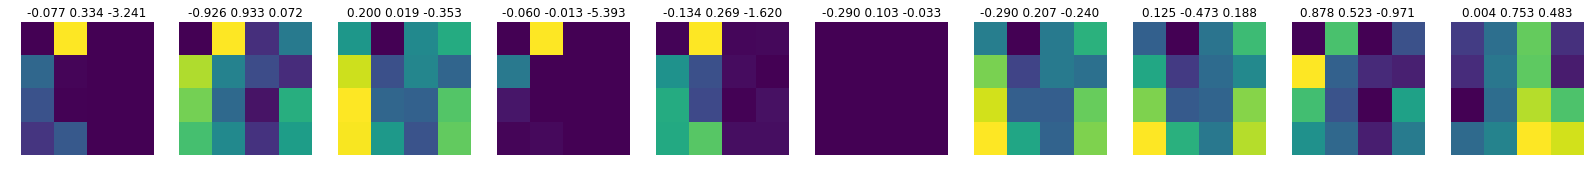

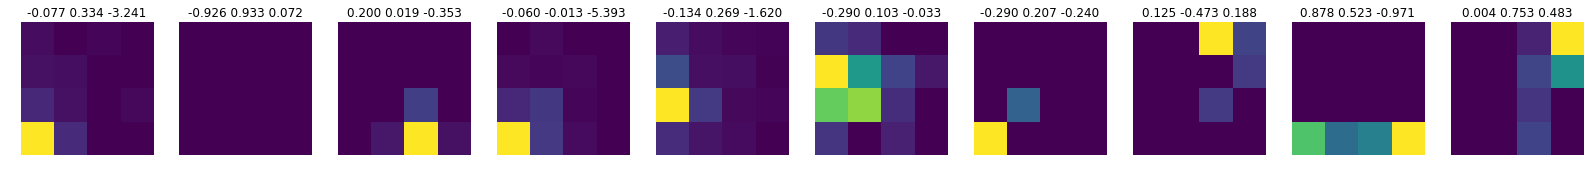

Train loss: 0.4791732326173722 Batch 2000 of 500           epoch: 172
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4153) tensor(2.9740e-08, grad_fn=<SumBackward0>) tensor(89.5906, grad_fn=<AbsBackward>) tensor(-217.5680, grad_fn=<SumBackward0>)


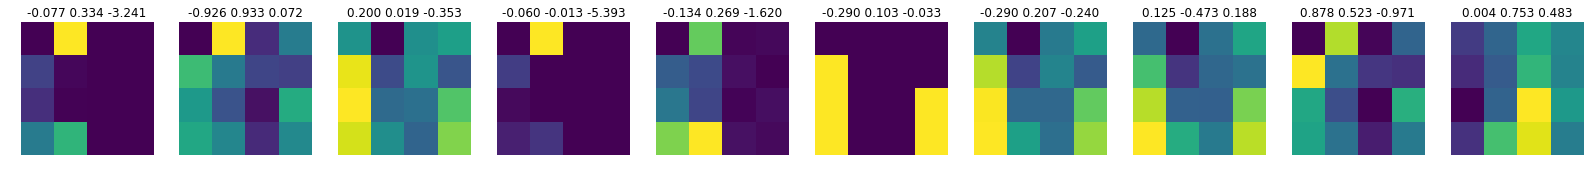

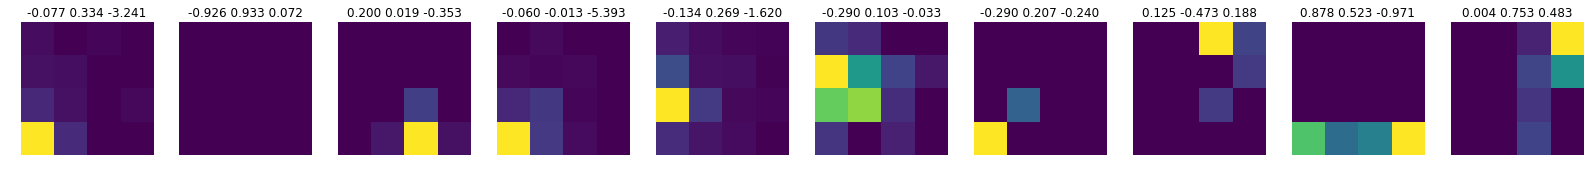

Train loss: 0.4151628914812972 Batch 2000 of 500           epoch: 173
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3879) tensor(8.5487e-09, grad_fn=<SumBackward0>) tensor(79.9111, grad_fn=<AbsBackward>) tensor(-193.4322, grad_fn=<SumBackward0>)


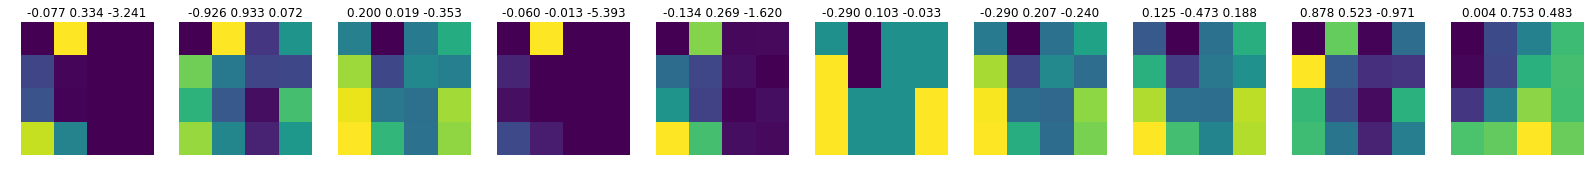

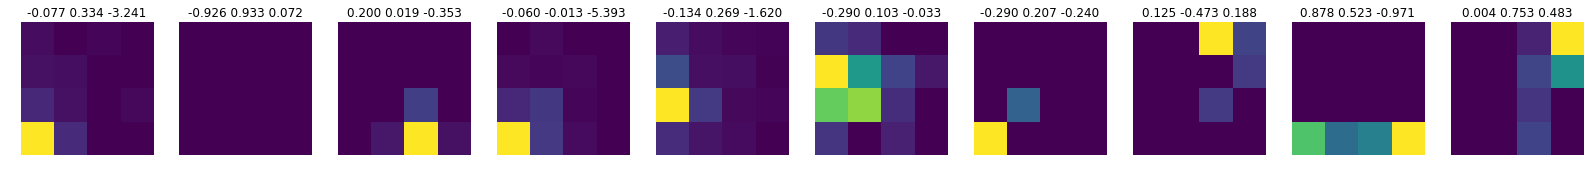

Train loss: 0.38704796433753286 Batch 2000 of 500           epoch: 174
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4011) tensor(3.6163e-08, grad_fn=<SumBackward0>) tensor(94.2367, grad_fn=<AbsBackward>) tensor(-189.0101, grad_fn=<SumBackward0>)


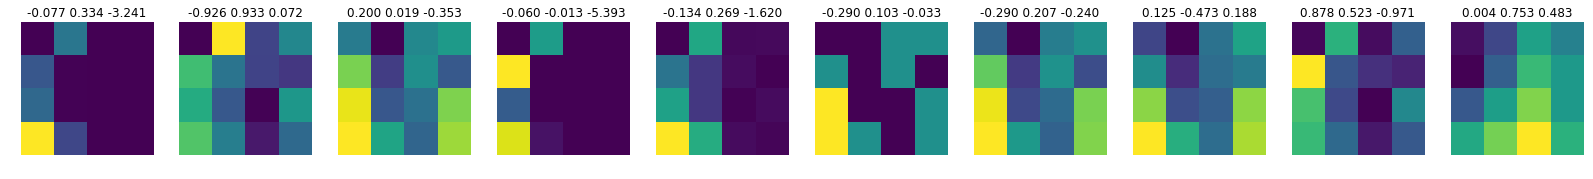

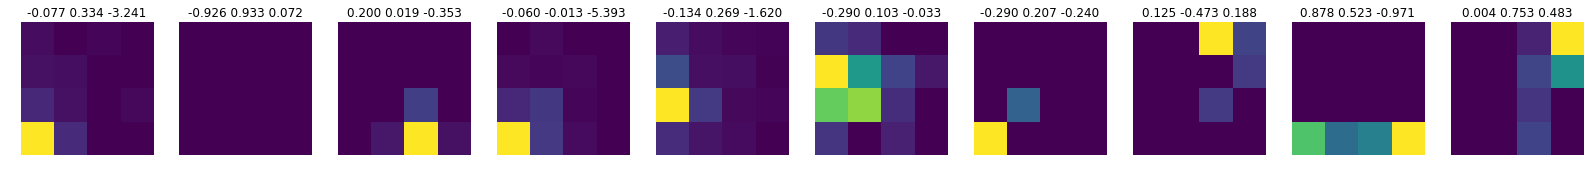

Train loss: 0.4021249447804614 Batch 2000 of 500           epoch: 175
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2479) tensor(3.3337e-08, grad_fn=<SumBackward0>) tensor(31.5510, grad_fn=<AbsBackward>) tensor(-50.0476, grad_fn=<SumBackward0>)


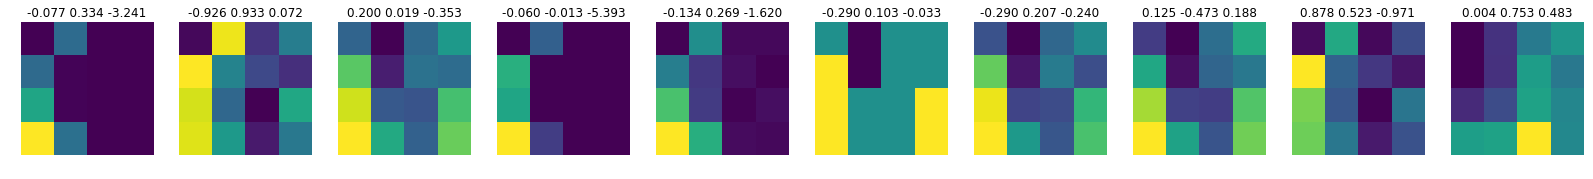

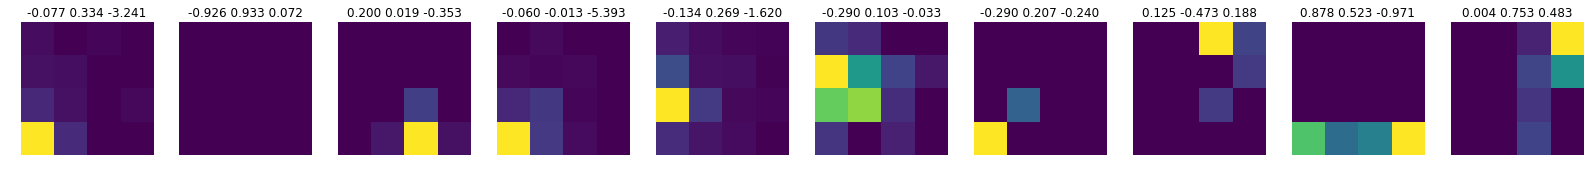

Train loss: 0.24666676835588622 Batch 2000 of 500           epoch: 176
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2959) tensor(3.9604e-08, grad_fn=<SumBackward0>) tensor(51.0254, grad_fn=<AbsBackward>) tensor(-89.9574, grad_fn=<SumBackward0>)


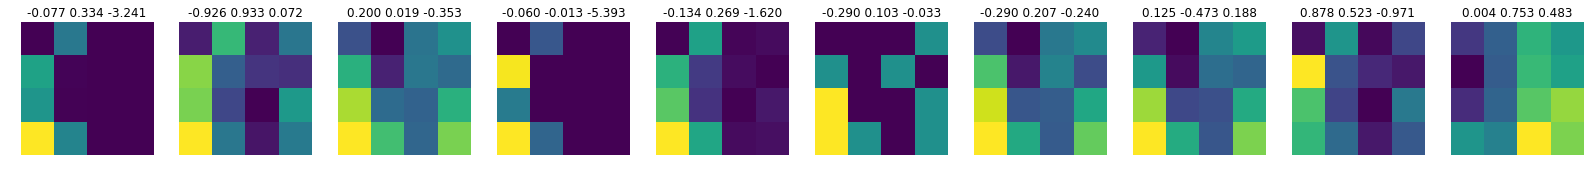

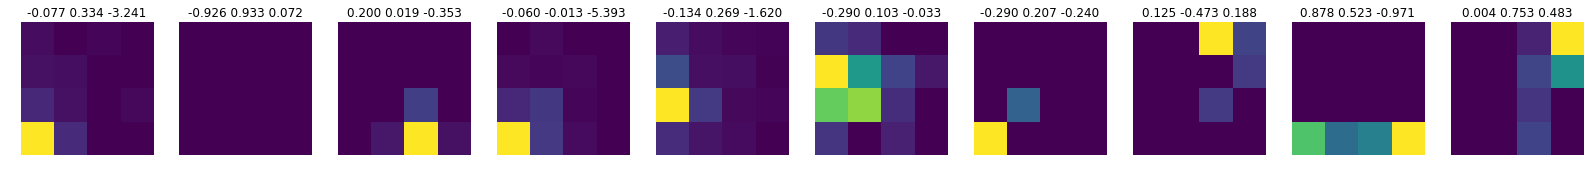

Train loss: 0.2965627803292945 Batch 2000 of 500           epoch: 177
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4317) tensor(1.1275e-08, grad_fn=<SumBackward0>) tensor(104.8568, grad_fn=<AbsBackward>) tensor(-204.1956, grad_fn=<SumBackward0>)


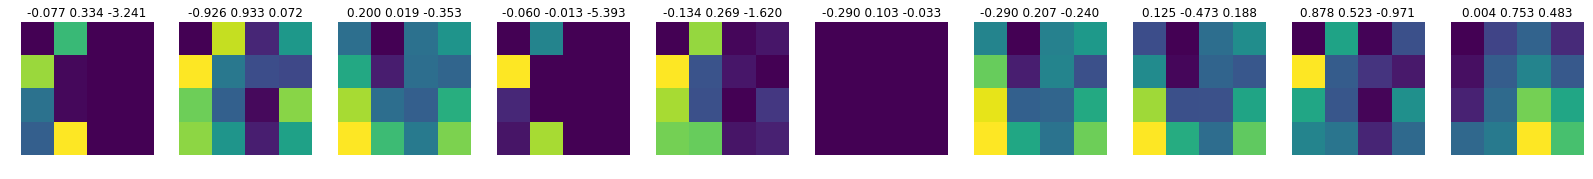

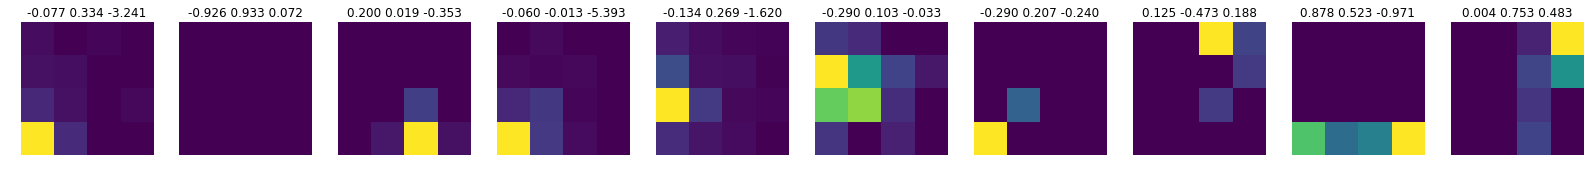

Train loss: 0.4332620904572539 Batch 2000 of 500           epoch: 178
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3903) tensor(1.2960e-08, grad_fn=<SumBackward0>) tensor(83.5368, grad_fn=<AbsBackward>) tensor(-155.0743, grad_fn=<SumBackward0>)


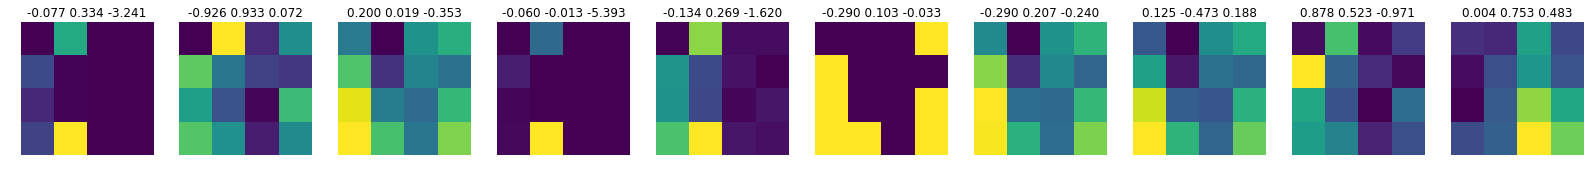

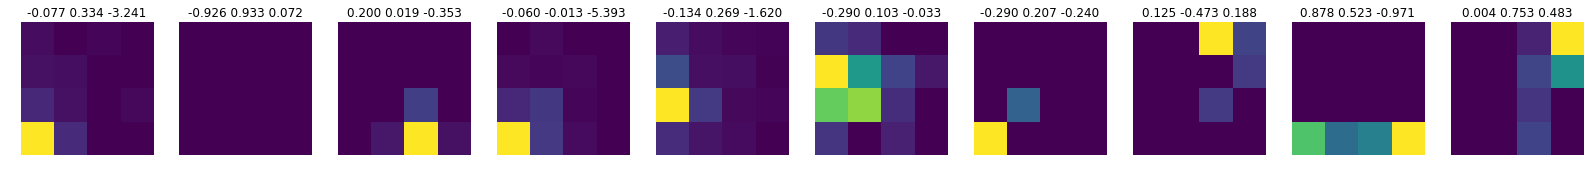

Train loss: 0.3905611177131682 Batch 2000 of 500           epoch: 179
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4387) tensor(9.5255e-10, grad_fn=<SumBackward0>) tensor(102.2507, grad_fn=<AbsBackward>) tensor(-187.1455, grad_fn=<SumBackward0>)


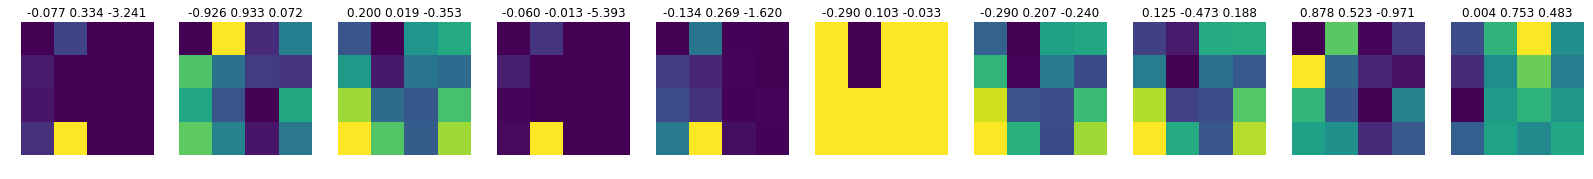

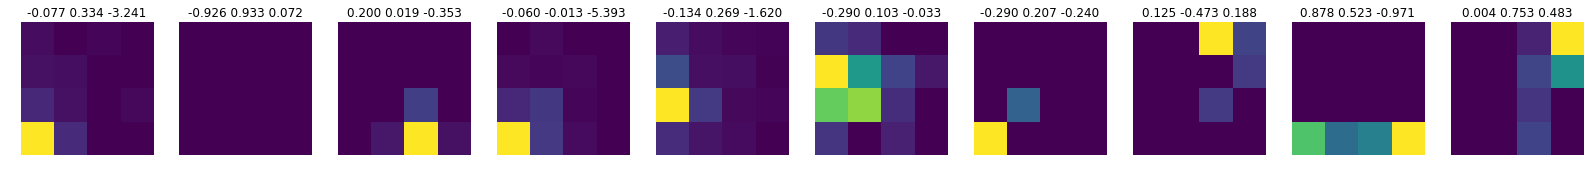

Train loss: 0.43925108646990285 Batch 2000 of 500           epoch: 180
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3663) tensor(3.0423e-07, grad_fn=<SumBackward0>) tensor(82.2243, grad_fn=<AbsBackward>) tensor(-179.7615, grad_fn=<SumBackward0>)


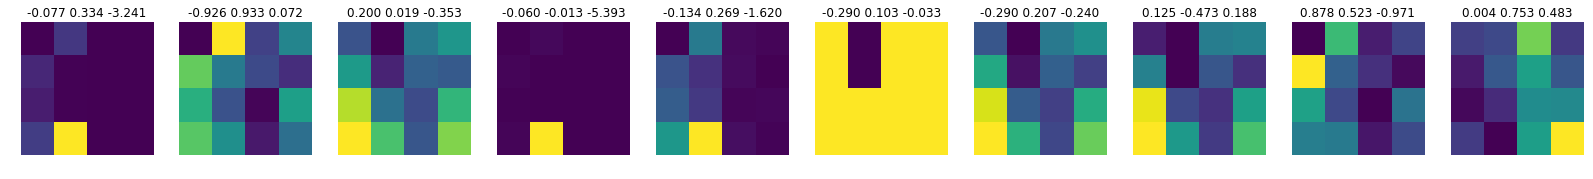

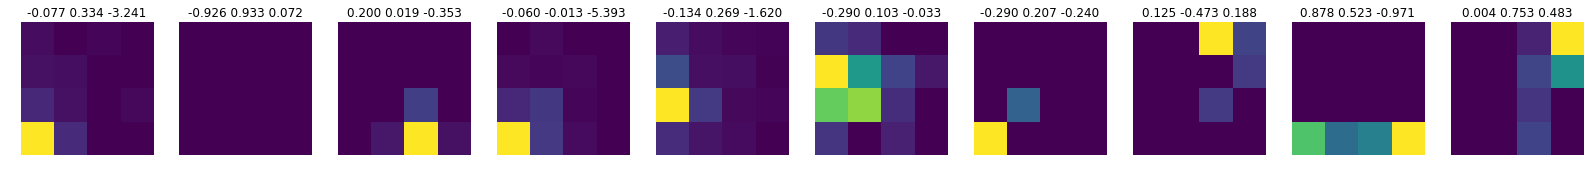

Train loss: 0.37000151567582557 Batch 2000 of 500           epoch: 181
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2791) tensor(1.9329e-08, grad_fn=<SumBackward0>) tensor(48.0608, grad_fn=<AbsBackward>) tensor(-71.0902, grad_fn=<SumBackward0>)


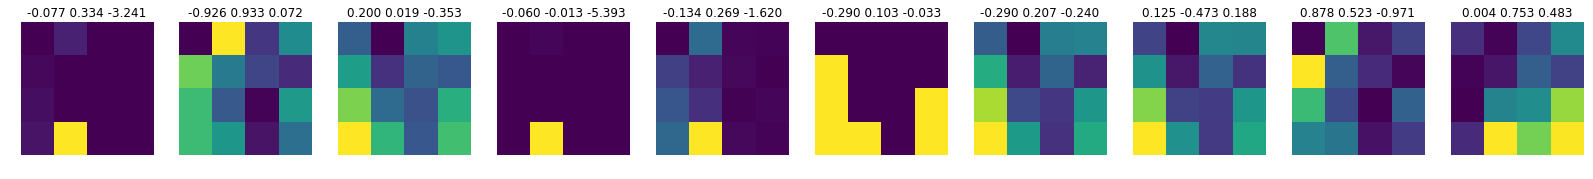

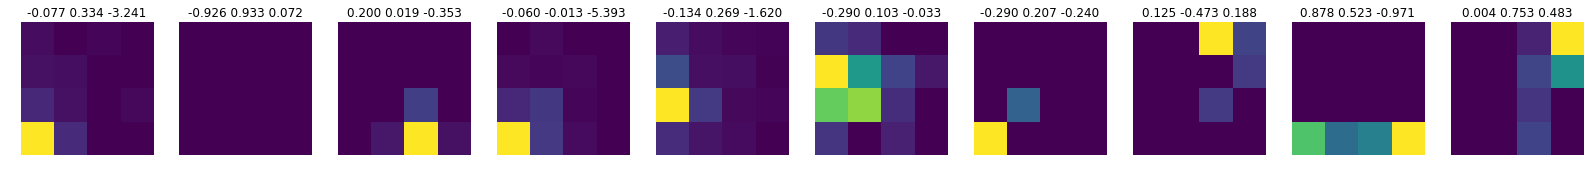

Train loss: 0.27943002927036587 Batch 2000 of 500           epoch: 182
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3864) tensor(3.3261e-09, grad_fn=<SumBackward0>) tensor(97.0103, grad_fn=<AbsBackward>) tensor(-139.9136, grad_fn=<SumBackward0>)


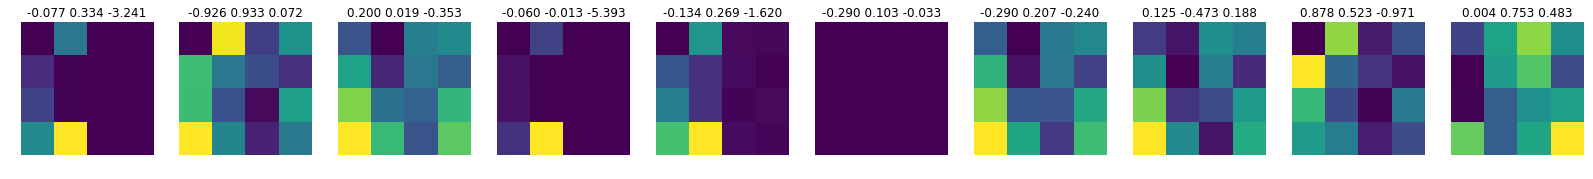

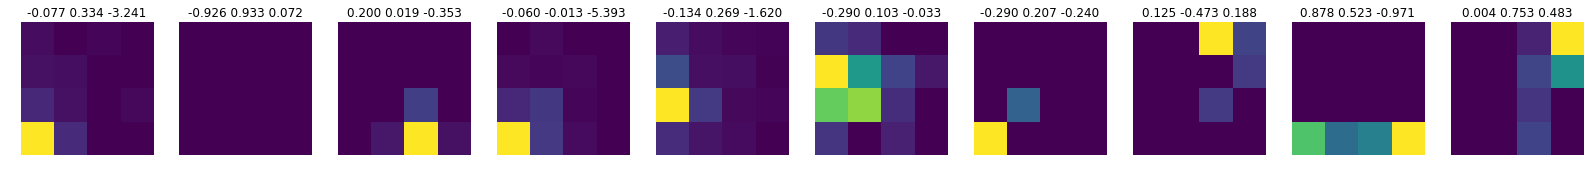

Train loss: 0.38888040192600104 Batch 2000 of 500           epoch: 183
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2164) tensor(2.6186e-06, grad_fn=<SumBackward0>) tensor(40.9671, grad_fn=<AbsBackward>) tensor(-52.9093, grad_fn=<SumBackward0>)


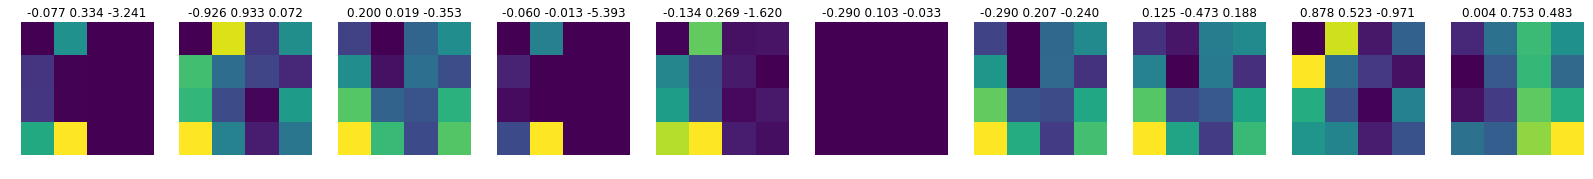

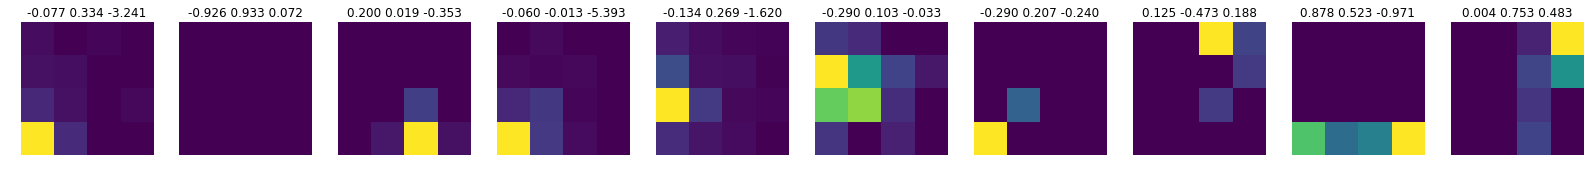

Train loss: 0.21265582980893066 Batch 2000 of 500           epoch: 184
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3454) tensor(1.3190e-08, grad_fn=<SumBackward0>) tensor(75.8710, grad_fn=<AbsBackward>) tensor(-151.8780, grad_fn=<SumBackward0>)


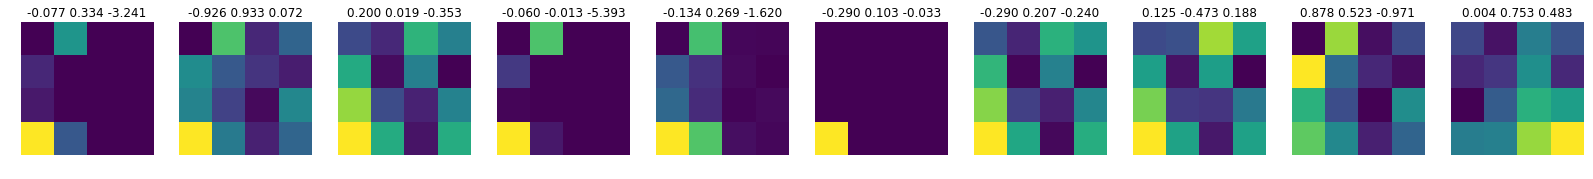

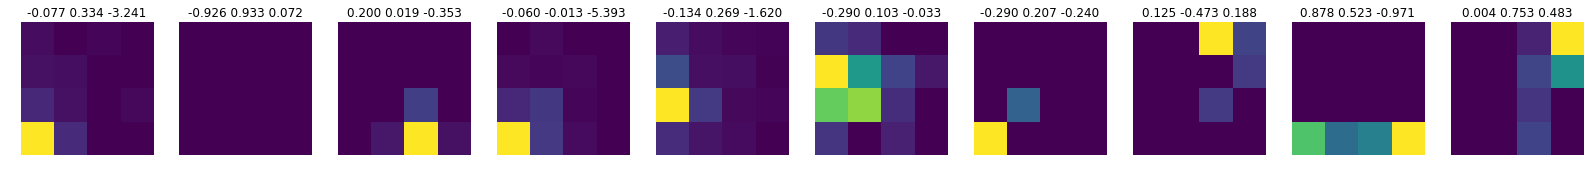

Train loss: 0.3457476608726242 Batch 2000 of 500           epoch: 185
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2717) tensor(1.7384e-06, grad_fn=<SumBackward0>) tensor(42.4290, grad_fn=<AbsBackward>) tensor(-127.4695, grad_fn=<SumBackward0>)


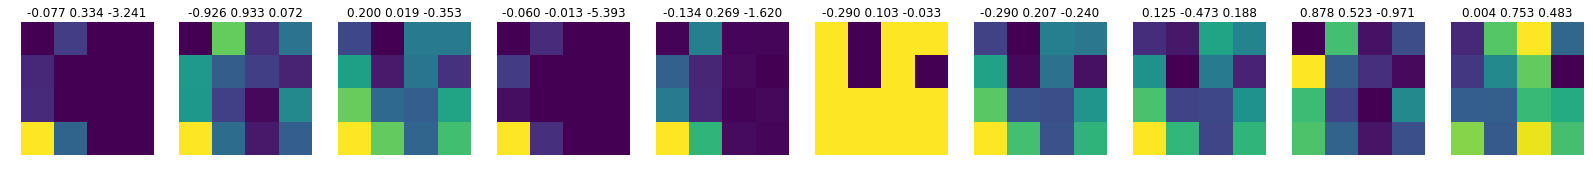

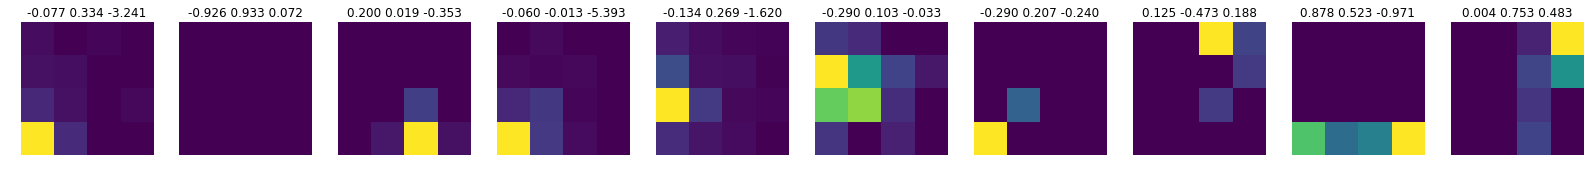

Train loss: 0.26428396083313965 Batch 2000 of 500           epoch: 186
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3672) tensor(2.0271e-09, grad_fn=<SumBackward0>) tensor(73.4388, grad_fn=<AbsBackward>) tensor(-151.4381, grad_fn=<SumBackward0>)


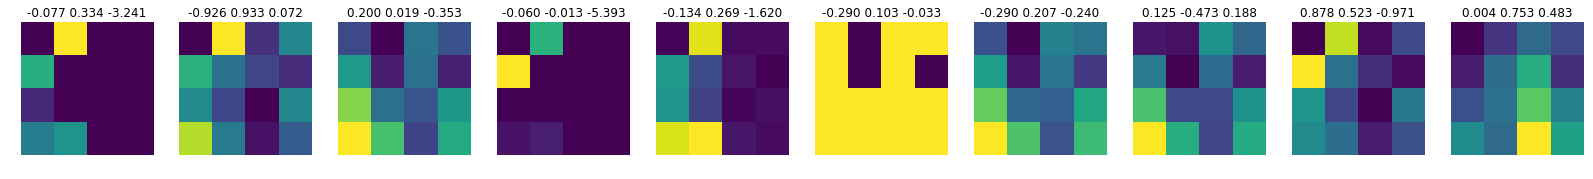

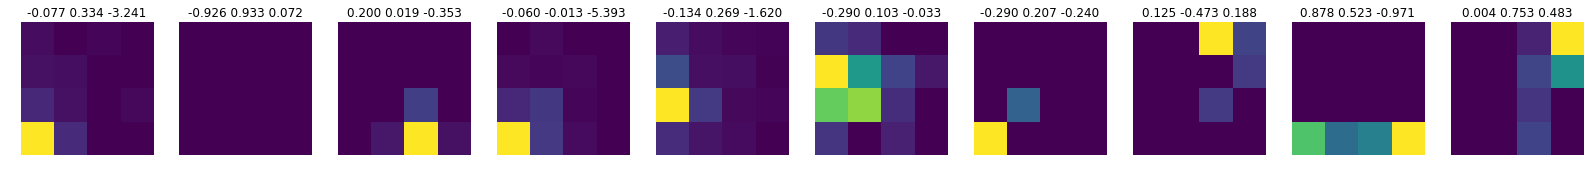

Train loss: 0.3668232285081794 Batch 2000 of 500           epoch: 187
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3500) tensor(6.5404e-09, grad_fn=<SumBackward0>) tensor(72.8529, grad_fn=<AbsBackward>) tensor(-141.4475, grad_fn=<SumBackward0>)


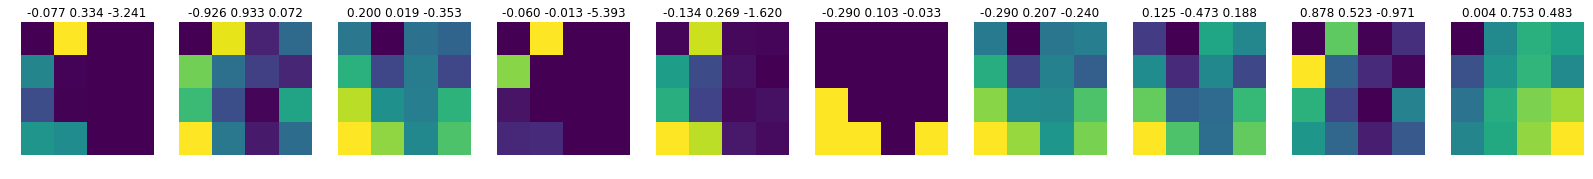

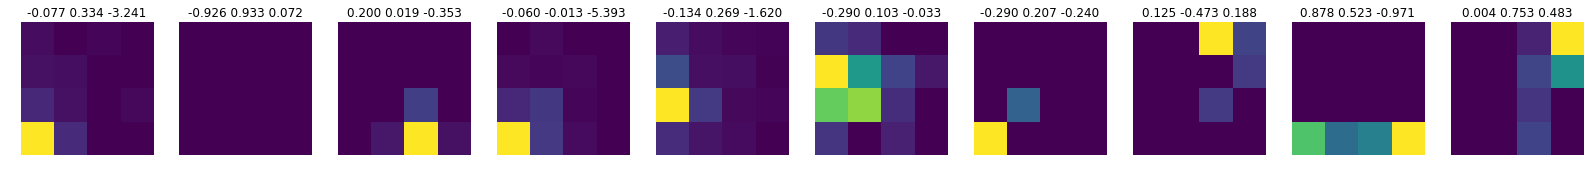

Train loss: 0.35048504643032263 Batch 2000 of 500           epoch: 188
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3642) tensor(1.6946e-07, grad_fn=<SumBackward0>) tensor(81.7290, grad_fn=<AbsBackward>) tensor(-151.9949, grad_fn=<SumBackward0>)


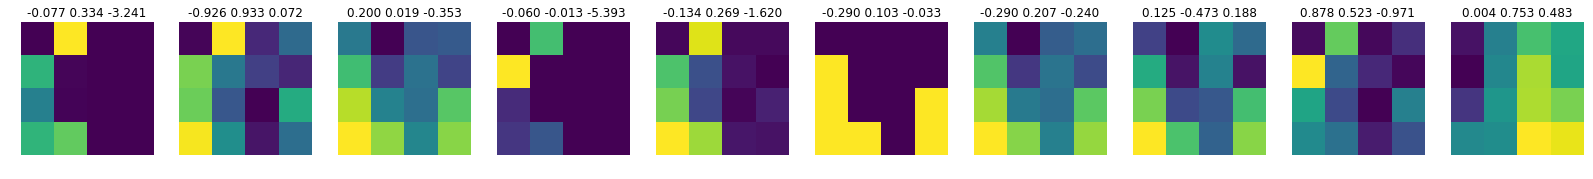

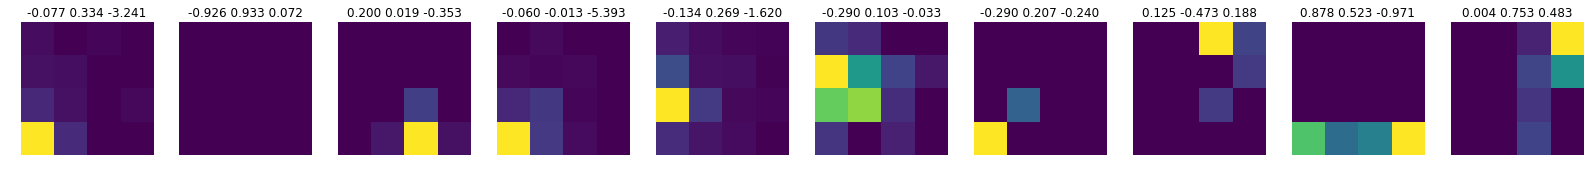

Train loss: 0.36614163879058564 Batch 2000 of 500           epoch: 189
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.5096) tensor(1.8414e-07, grad_fn=<SumBackward0>) tensor(149.0226, grad_fn=<AbsBackward>) tensor(-331.0574, grad_fn=<SumBackward0>)


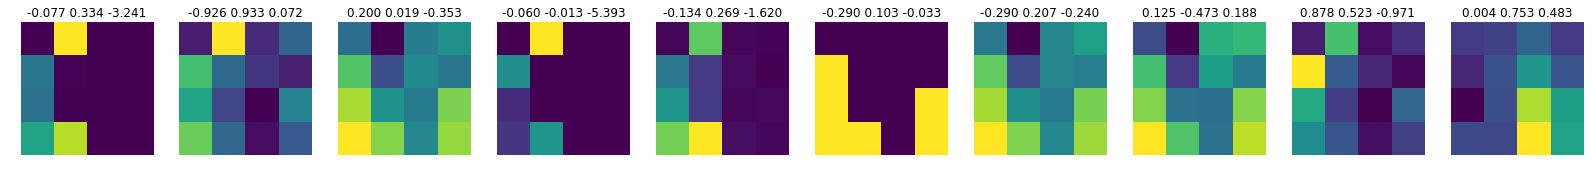

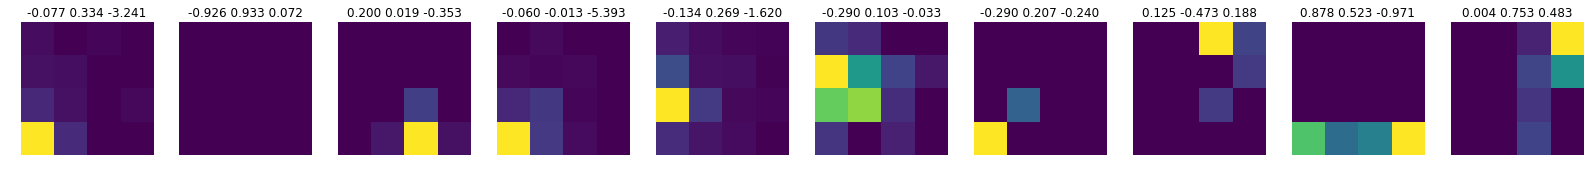

Train loss: 0.5109751039436925 Batch 2000 of 500           epoch: 190
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4107) tensor(2.8906e-07, grad_fn=<SumBackward0>) tensor(92.6838, grad_fn=<AbsBackward>) tensor(-172.8405, grad_fn=<SumBackward0>)


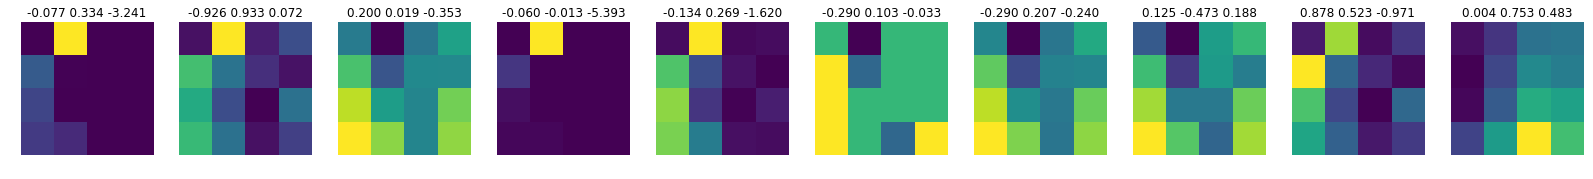

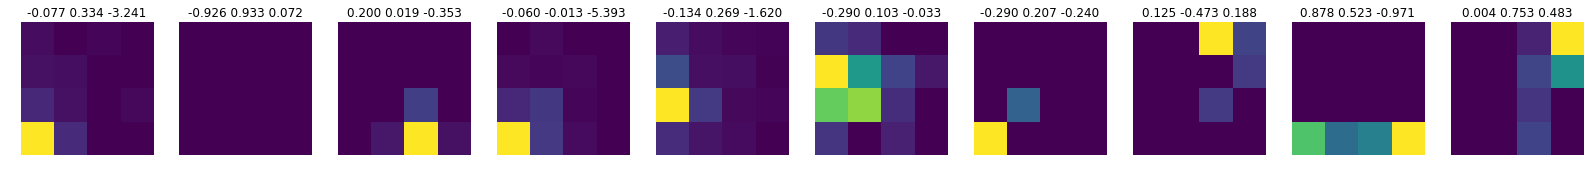

Train loss: 0.41049991859103835 Batch 2000 of 500           epoch: 191
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3499) tensor(2.0090e-08, grad_fn=<SumBackward0>) tensor(62.3142, grad_fn=<AbsBackward>) tensor(-122.9827, grad_fn=<SumBackward0>)


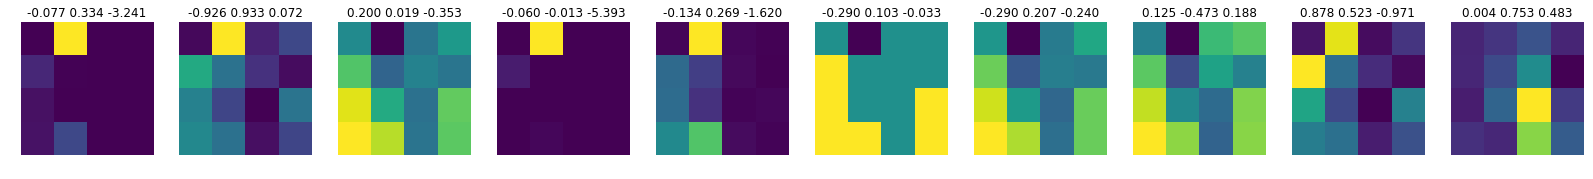

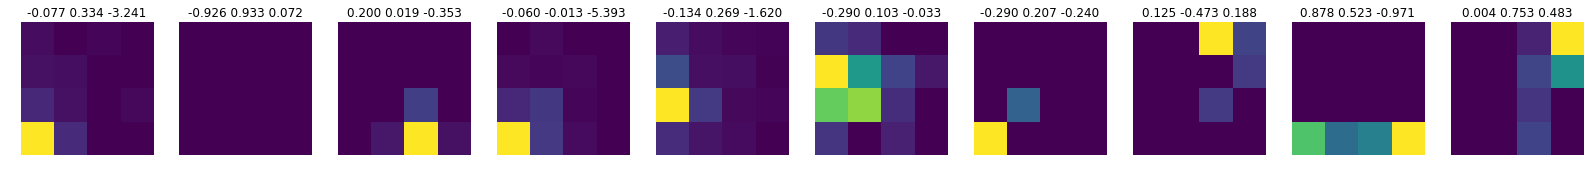

Train loss: 0.349133601395295 Batch 2000 of 500           epoch: 192
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3701) tensor(6.8516e-09, grad_fn=<SumBackward0>) tensor(83.1195, grad_fn=<AbsBackward>) tensor(-215.0126, grad_fn=<SumBackward0>)


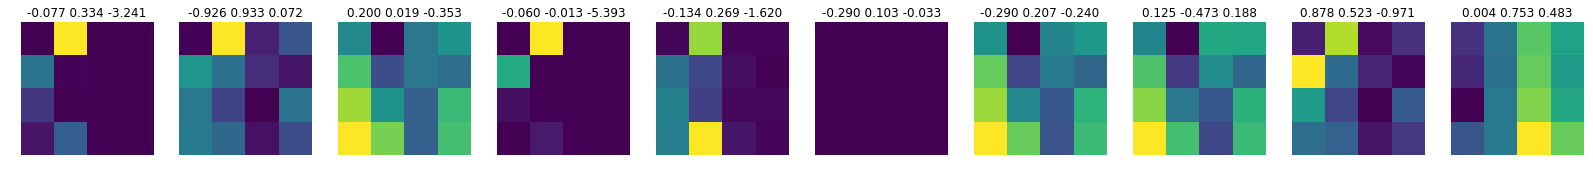

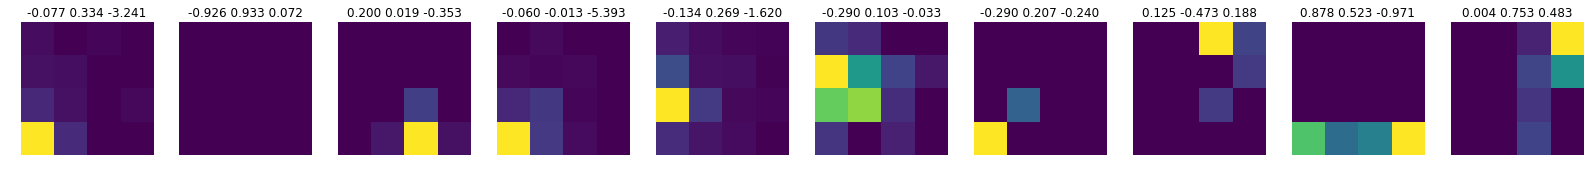

Train loss: 0.36661677982949714 Batch 2000 of 500           epoch: 193
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2661) tensor(1.6150e-10, grad_fn=<SumBackward0>) tensor(31.7529, grad_fn=<AbsBackward>) tensor(-57.5067, grad_fn=<SumBackward0>)


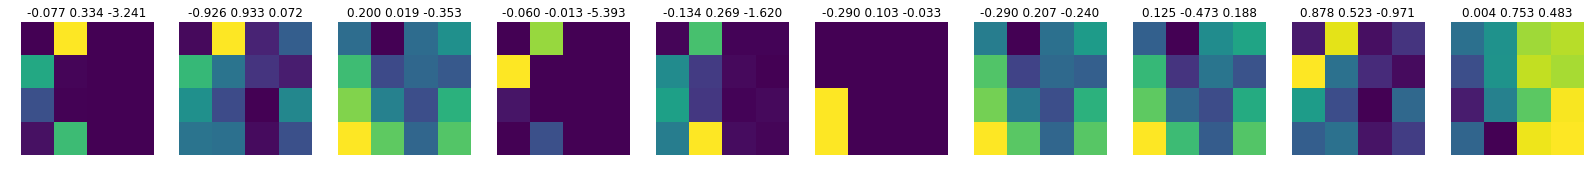

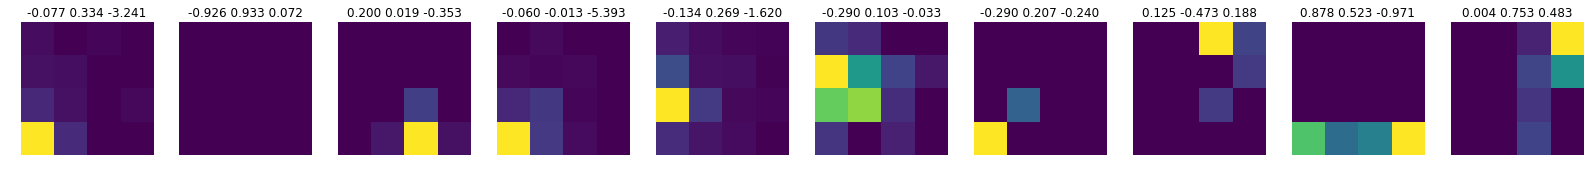

Train loss: 0.2661911837502878 Batch 2000 of 500           epoch: 194
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3737) tensor(1.1538e-08, grad_fn=<SumBackward0>) tensor(80.3376, grad_fn=<AbsBackward>) tensor(-137.2264, grad_fn=<SumBackward0>)


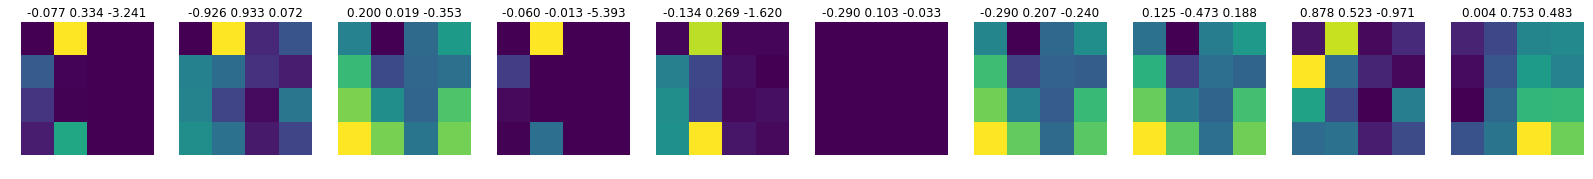

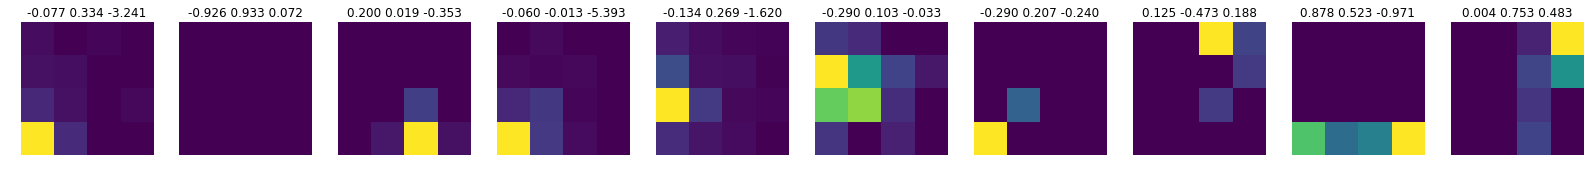

Train loss: 0.3802256293450954 Batch 2000 of 500           epoch: 195
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4376) tensor(5.4425e-10, grad_fn=<SumBackward0>) tensor(119.2449, grad_fn=<AbsBackward>) tensor(-199.8697, grad_fn=<SumBackward0>)


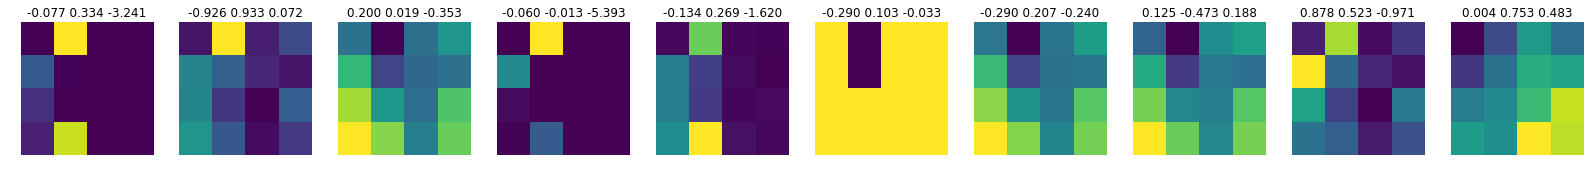

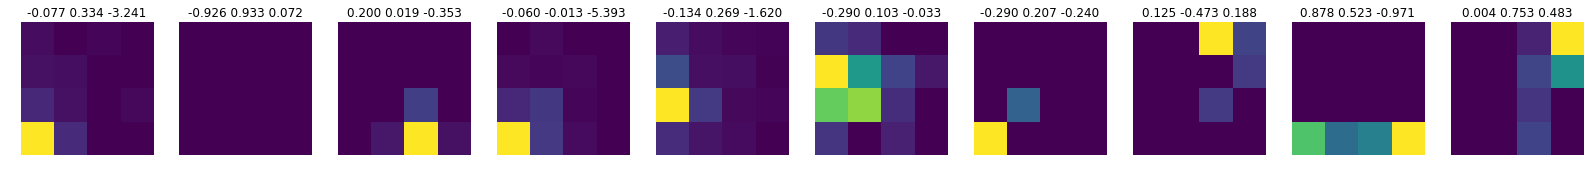

Train loss: 0.43568124830625965 Batch 2000 of 500           epoch: 196
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3638) tensor(3.0835e-08, grad_fn=<SumBackward0>) tensor(67.0802, grad_fn=<AbsBackward>) tensor(-124.9547, grad_fn=<SumBackward0>)


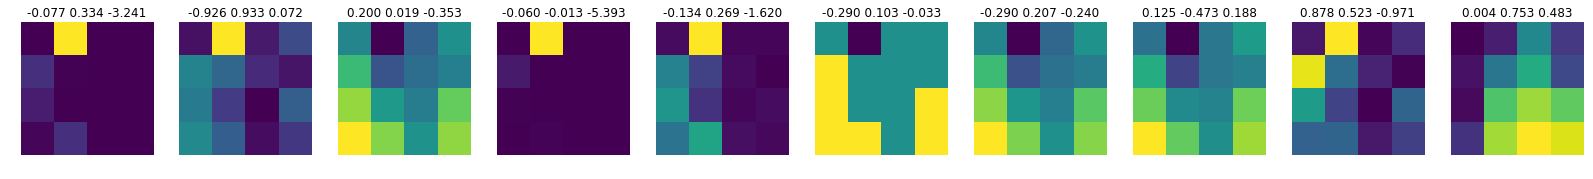

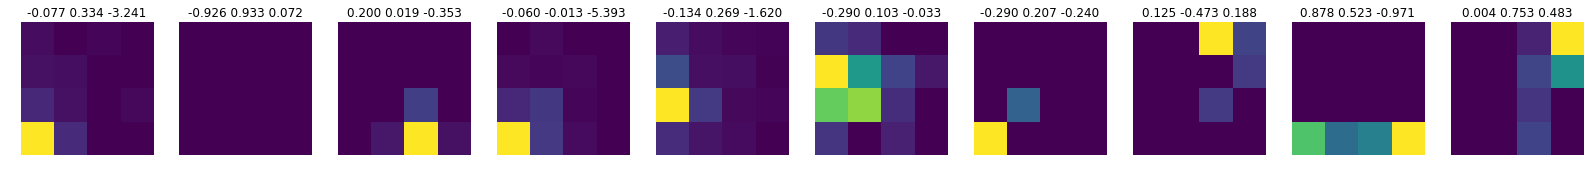

Train loss: 0.3711422840604669 Batch 2000 of 500           epoch: 197
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4498) tensor(2.3922e-08, grad_fn=<SumBackward0>) tensor(110.4773, grad_fn=<AbsBackward>) tensor(-190.7570, grad_fn=<SumBackward0>)


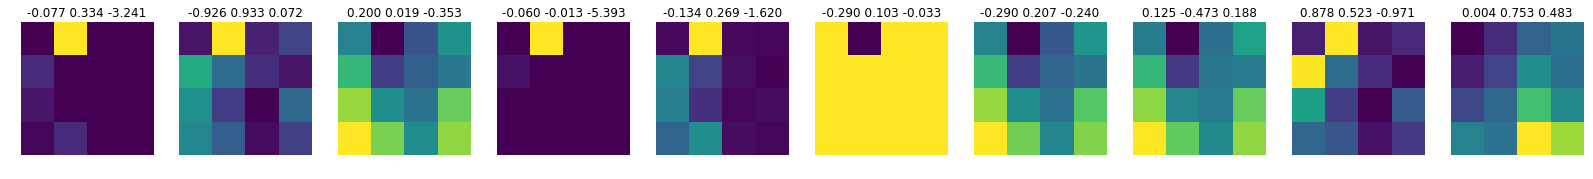

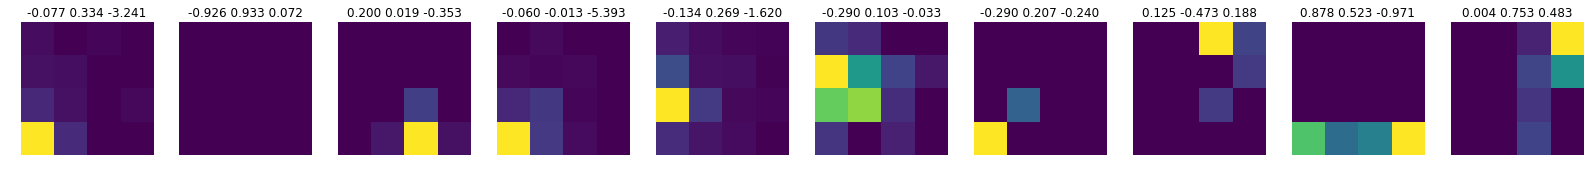

Train loss: 0.4501130343937948 Batch 2000 of 500           epoch: 198
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2936) tensor(2.2014e-07, grad_fn=<SumBackward0>) tensor(45.0630, grad_fn=<AbsBackward>) tensor(-100.4016, grad_fn=<SumBackward0>)


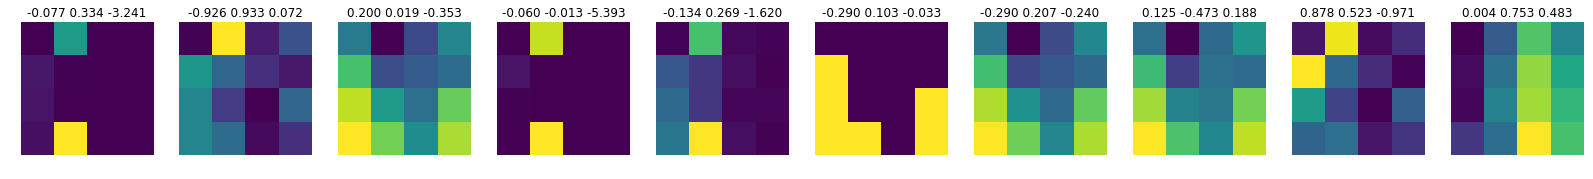

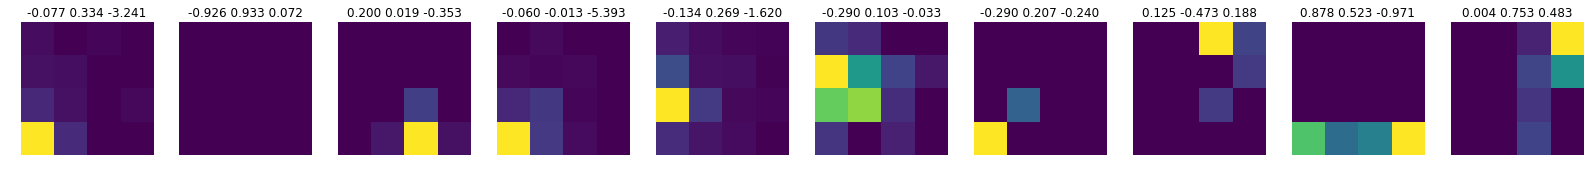

Train loss: 0.2948144456641656 Batch 2000 of 500           epoch: 199
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4477) tensor(5.0272e-08, grad_fn=<SumBackward0>) tensor(110.6927, grad_fn=<AbsBackward>) tensor(-233.5384, grad_fn=<SumBackward0>)


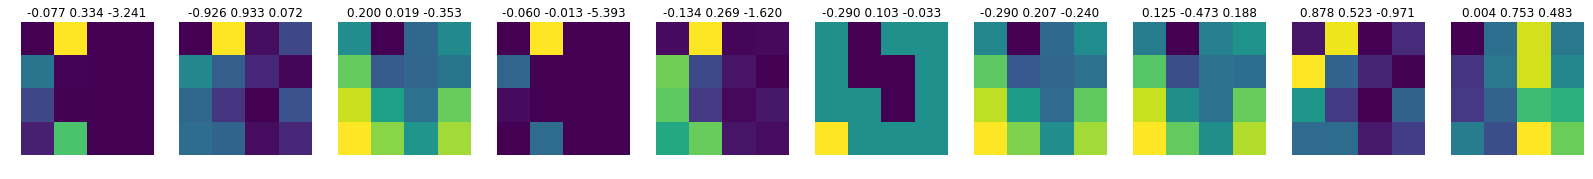

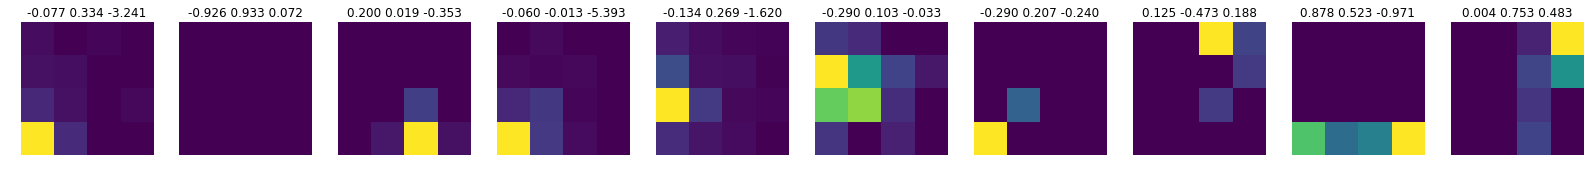

Train loss: 0.4472123890408074 Batch 2000 of 500           epoch: 200
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4576) tensor(1.6235e-08, grad_fn=<SumBackward0>) tensor(121.9964, grad_fn=<AbsBackward>) tensor(-231.1635, grad_fn=<SumBackward0>)


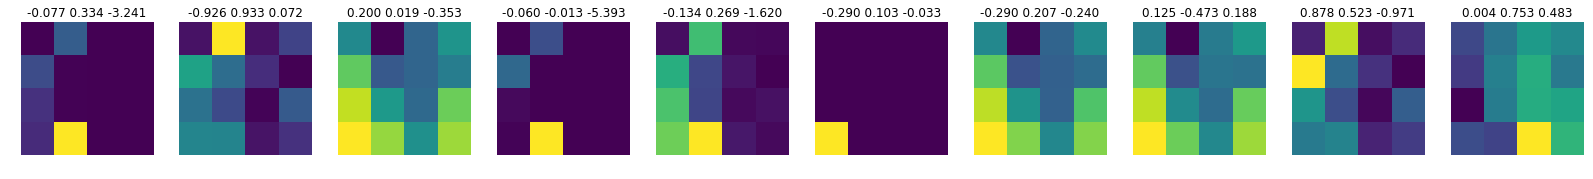

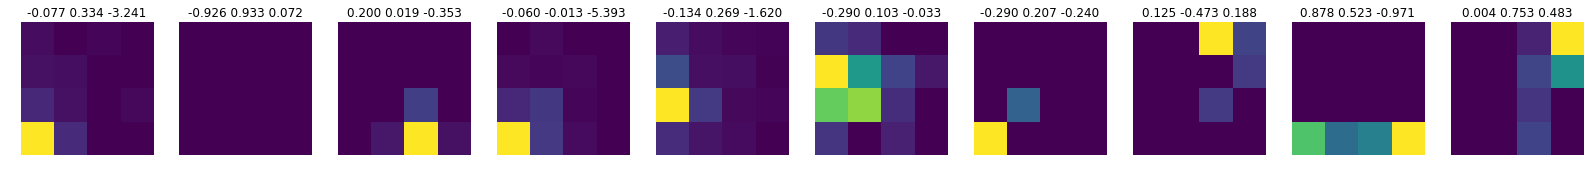

Train loss: 0.4585040036372023 Batch 2000 of 500           epoch: 201
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3986) tensor(9.9186e-09, grad_fn=<SumBackward0>) tensor(102.9222, grad_fn=<AbsBackward>) tensor(-177.0211, grad_fn=<SumBackward0>)


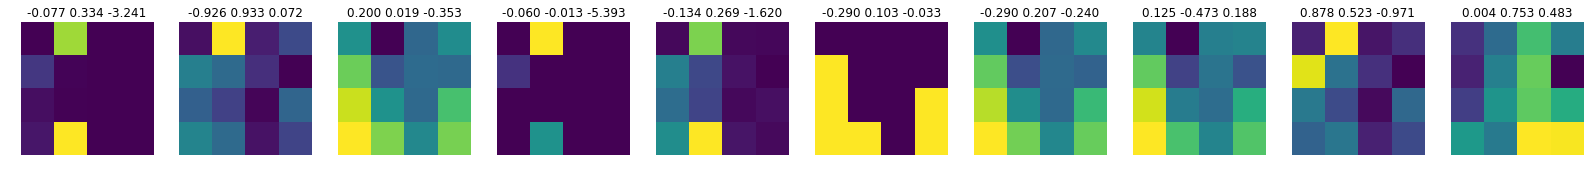

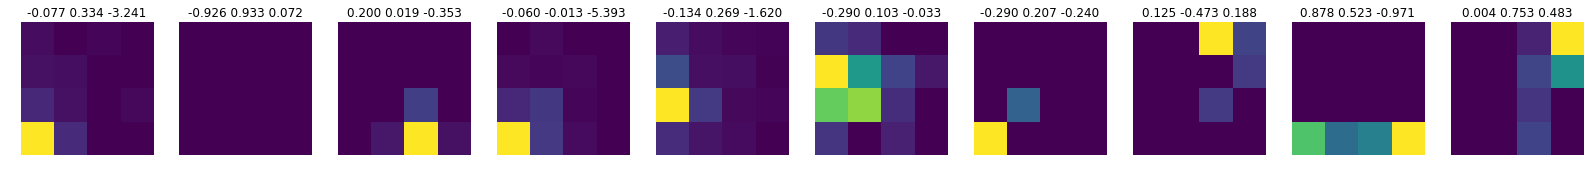

Train loss: 0.39599658976538743 Batch 2000 of 500           epoch: 202
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3095) tensor(5.9075e-08, grad_fn=<SumBackward0>) tensor(57.2649, grad_fn=<AbsBackward>) tensor(-131.5502, grad_fn=<SumBackward0>)


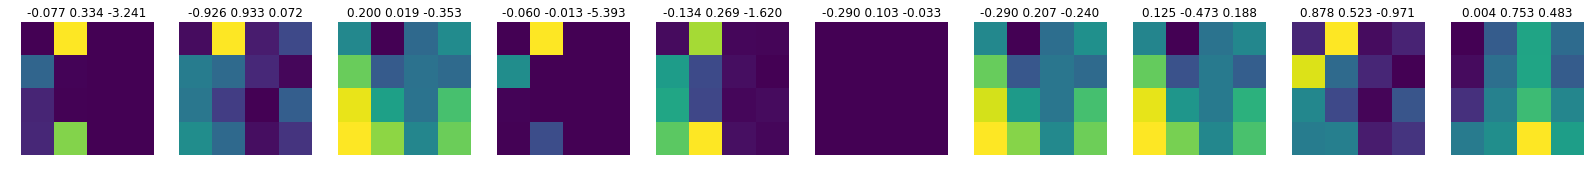

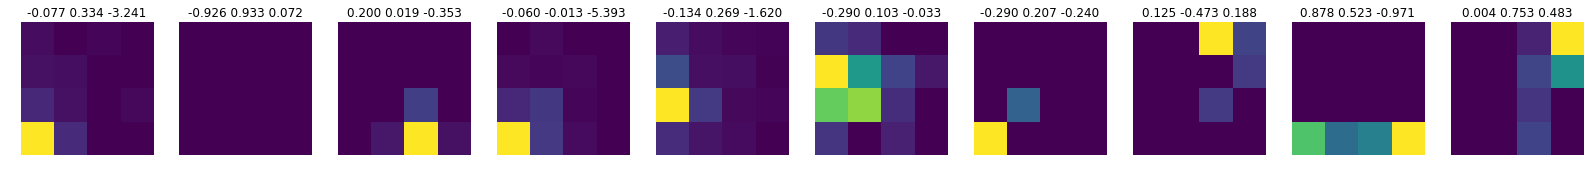

Train loss: 0.31767588254343476 Batch 2000 of 500           epoch: 203
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.5303) tensor(1.8360e-08, grad_fn=<SumBackward0>) tensor(150.0190, grad_fn=<AbsBackward>) tensor(-386.5437, grad_fn=<SumBackward0>)


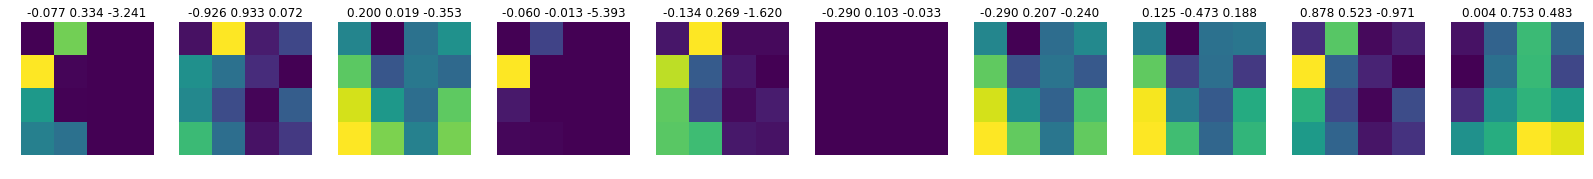

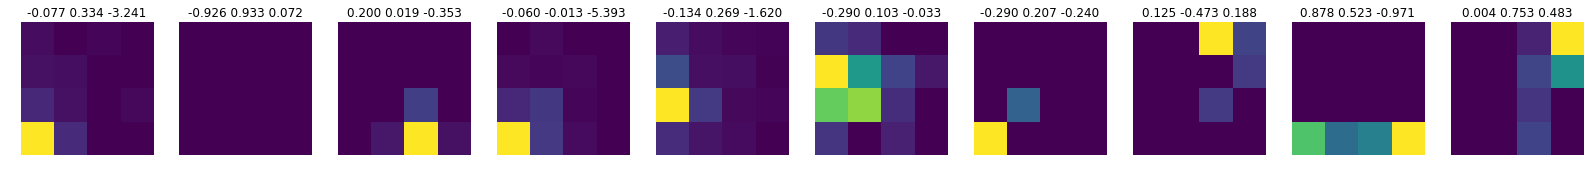

Train loss: 0.5301057189402935 Batch 2000 of 500           epoch: 204
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.2639) tensor(5.0785e-07, grad_fn=<SumBackward0>) tensor(48.5111, grad_fn=<AbsBackward>) tensor(-88.4715, grad_fn=<SumBackward0>)


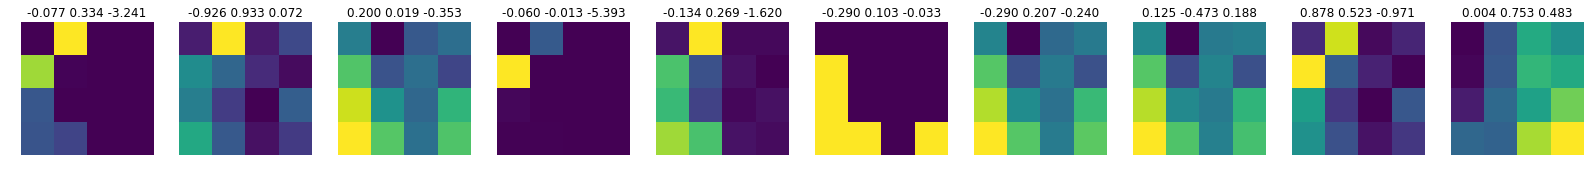

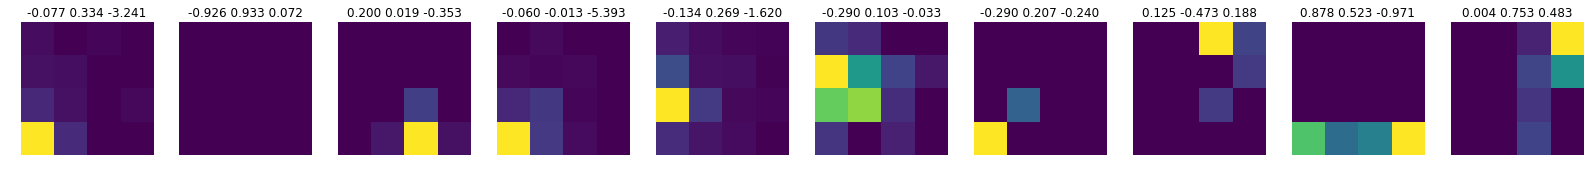

Train loss: 0.2652777298565296 Batch 2000 of 500           epoch: 205
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4547) tensor(6.1760e-09, grad_fn=<SumBackward0>) tensor(104.7311, grad_fn=<AbsBackward>) tensor(-240.9551, grad_fn=<SumBackward0>)


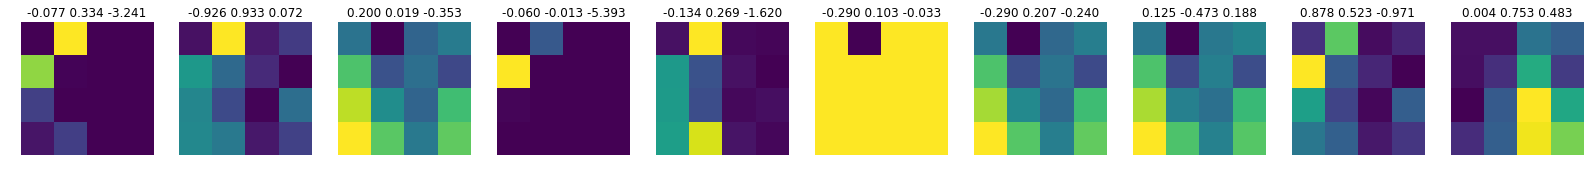

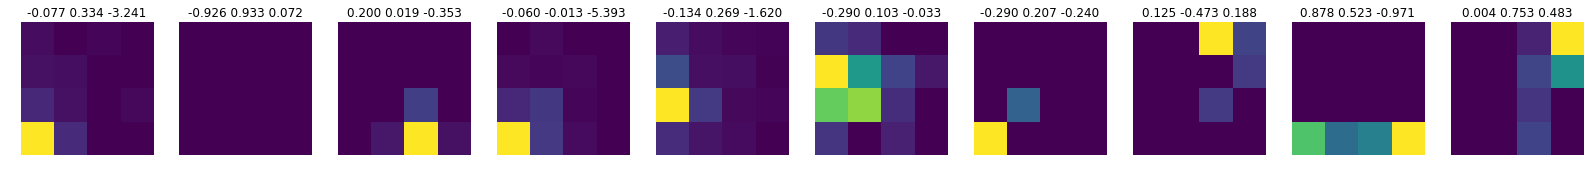

Train loss: 0.4541690660862806 Batch 2000 of 500           epoch: 206
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3231) tensor(1.5072e-08, grad_fn=<SumBackward0>) tensor(57.3412, grad_fn=<AbsBackward>) tensor(-179.2034, grad_fn=<SumBackward0>)


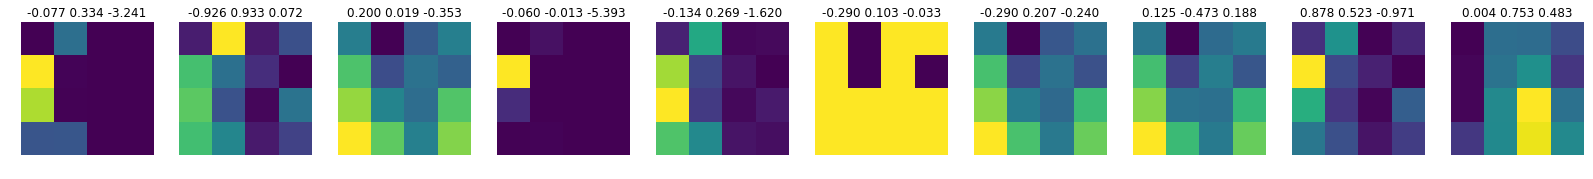

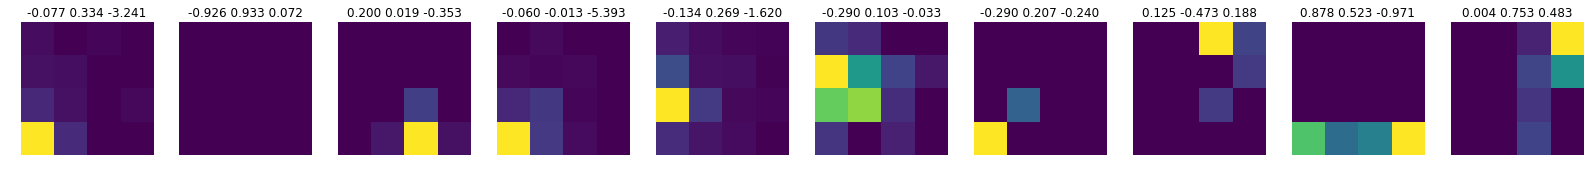

Train loss: 0.3213454168774809 Batch 2000 of 500           epoch: 207
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3295) tensor(2.0373e-10, grad_fn=<SumBackward0>) tensor(70.3531, grad_fn=<AbsBackward>) tensor(-103.8881, grad_fn=<SumBackward0>)


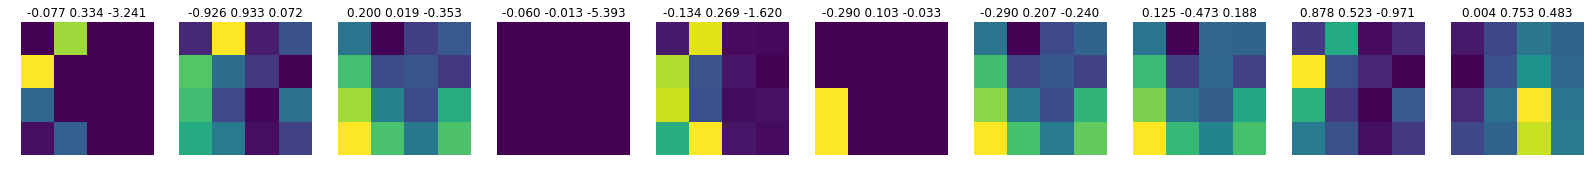

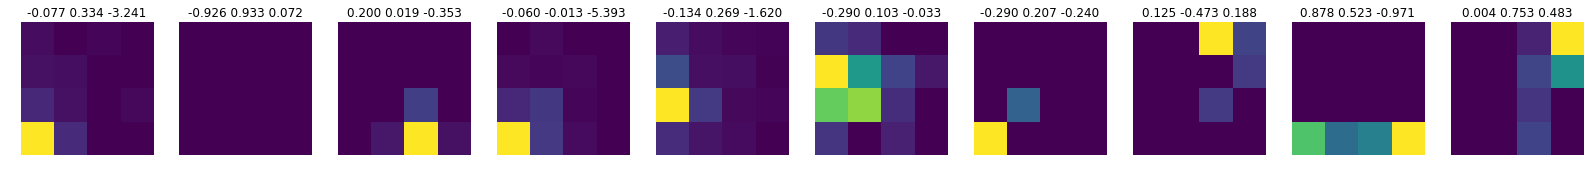

Train loss: 0.33075944767044935 Batch 2000 of 500           epoch: 208
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4213) tensor(9.8359e-09, grad_fn=<SumBackward0>) tensor(100.1303, grad_fn=<AbsBackward>) tensor(-214.5550, grad_fn=<SumBackward0>)


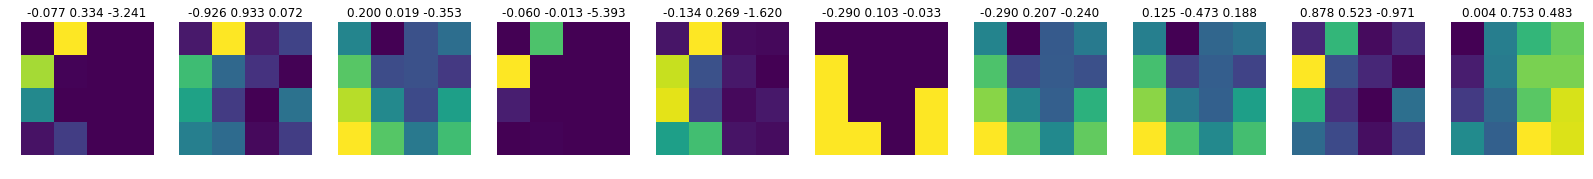

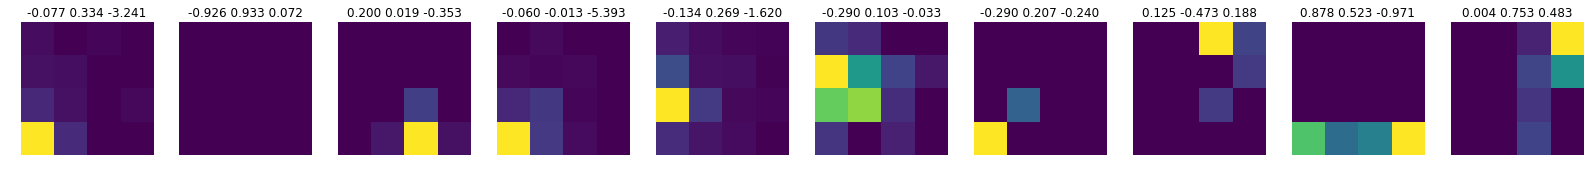

Train loss: 0.4209107422442648 Batch 2000 of 500           epoch: 209
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3246) tensor(1.0141e-07, grad_fn=<SumBackward0>) tensor(59.0517, grad_fn=<AbsBackward>) tensor(-118.1488, grad_fn=<SumBackward0>)


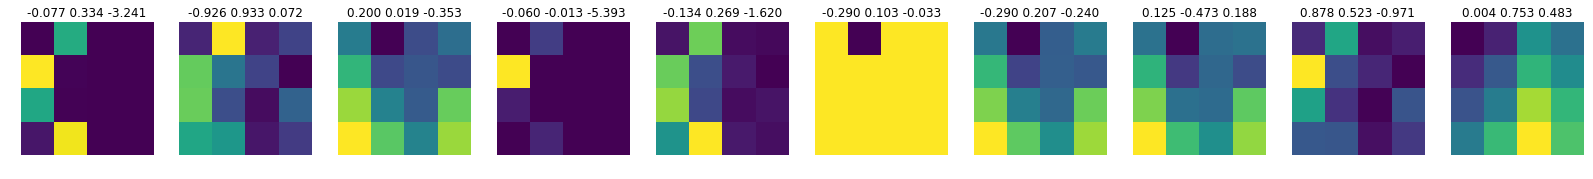

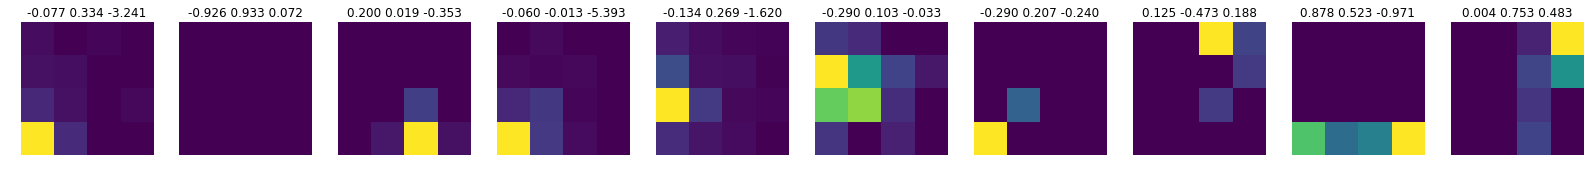

Train loss: 0.32473662785636864 Batch 2000 of 500           epoch: 210
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4210) tensor(7.0845e-09, grad_fn=<SumBackward0>) tensor(91.2259, grad_fn=<AbsBackward>) tensor(-191.4673, grad_fn=<SumBackward0>)


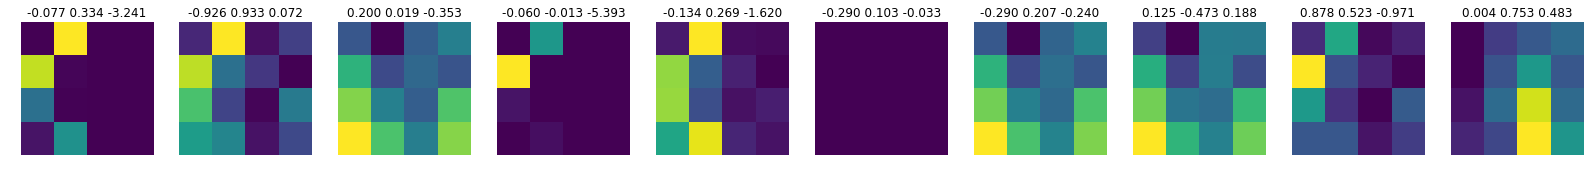

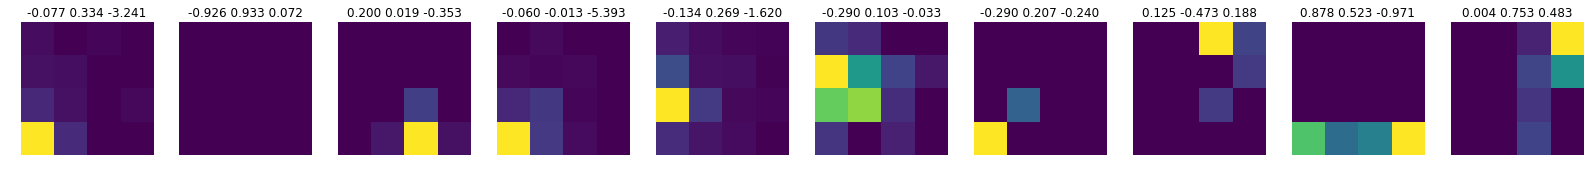

Train loss: 0.42148807595470156 Batch 2000 of 500           epoch: 211
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4428) tensor(3.0557e-09, grad_fn=<SumBackward0>) tensor(104.1645, grad_fn=<AbsBackward>) tensor(-203.6832, grad_fn=<SumBackward0>)


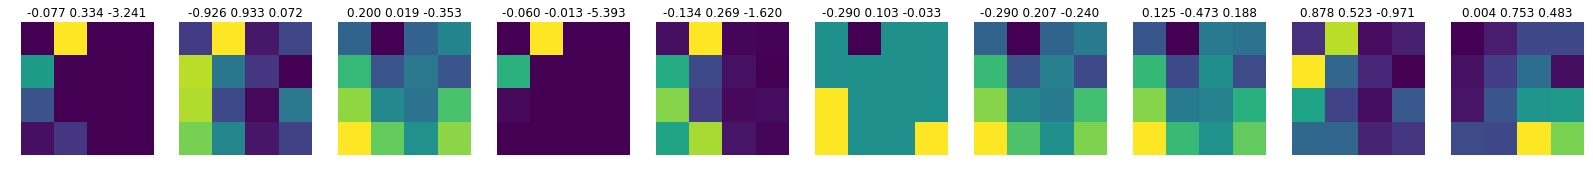

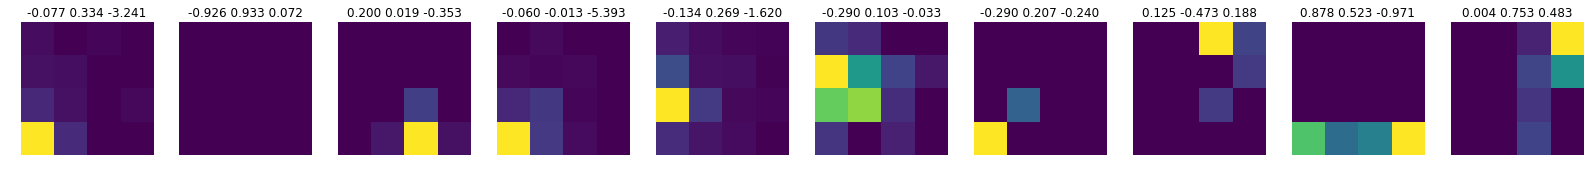

Train loss: 0.44286689311783956 Batch 2000 of 500           epoch: 212
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4527) tensor(2.6902e-09, grad_fn=<SumBackward0>) tensor(109.7187, grad_fn=<AbsBackward>) tensor(-225.9547, grad_fn=<SumBackward0>)


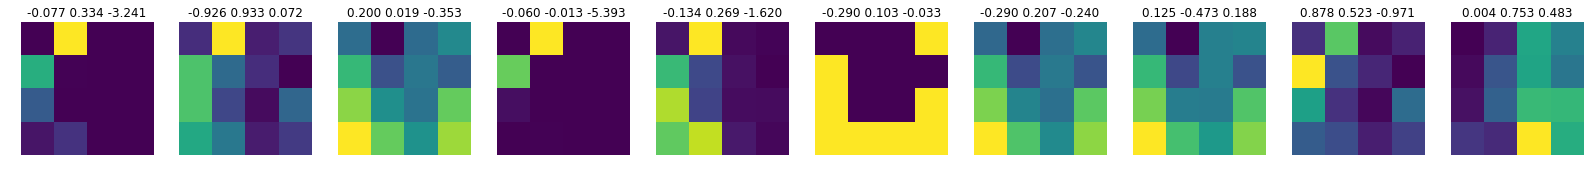

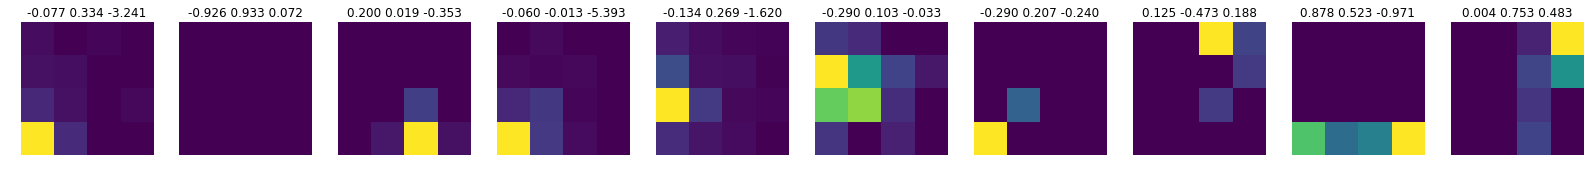

Train loss: 0.452608200541652 Batch 2000 of 500           epoch: 213
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3837) tensor(1.4163e-07, grad_fn=<SumBackward0>) tensor(72.8567, grad_fn=<AbsBackward>) tensor(-153.5671, grad_fn=<SumBackward0>)


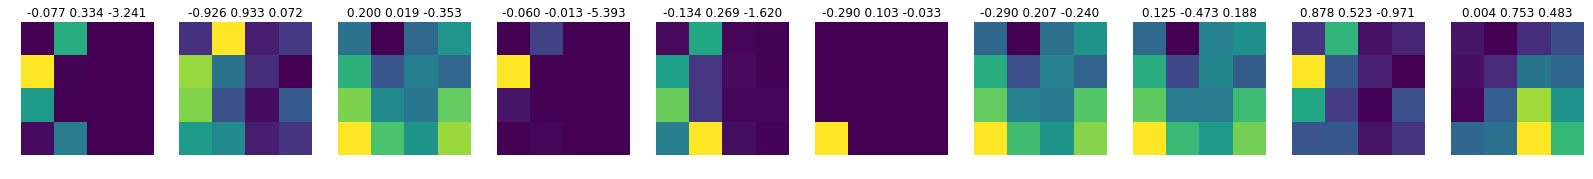

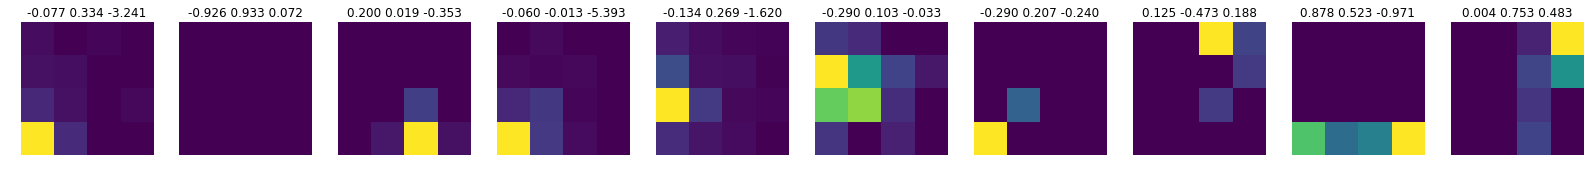

Train loss: 0.3823566896416369 Batch 2000 of 500           epoch: 214
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4315) tensor(1.9801e-07, grad_fn=<SumBackward0>) tensor(100.0611, grad_fn=<AbsBackward>) tensor(-179.0325, grad_fn=<SumBackward0>)


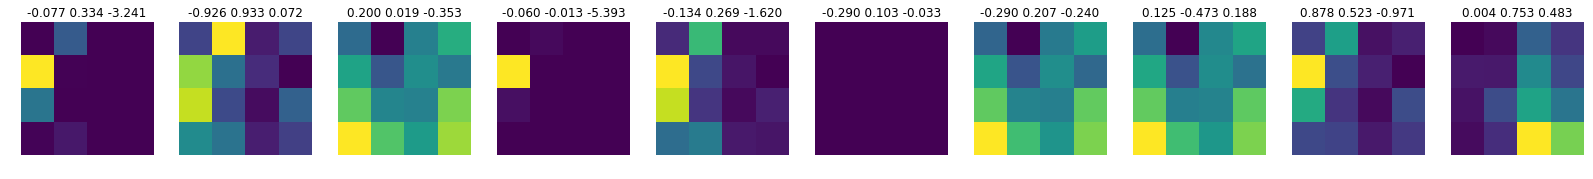

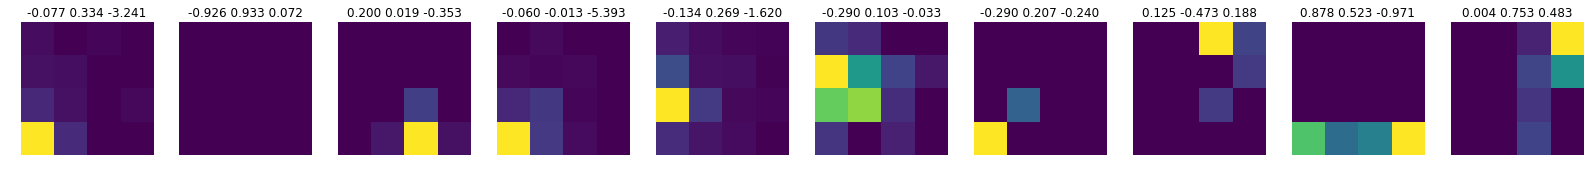

Train loss: 0.4320242003547017 Batch 2000 of 500           epoch: 215
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.4672) tensor(4.2925e-09, grad_fn=<SumBackward0>) tensor(114.6167, grad_fn=<AbsBackward>) tensor(-246.9622, grad_fn=<SumBackward0>)


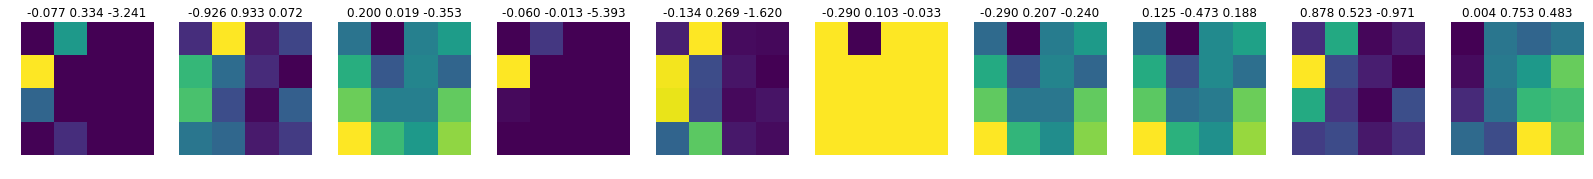

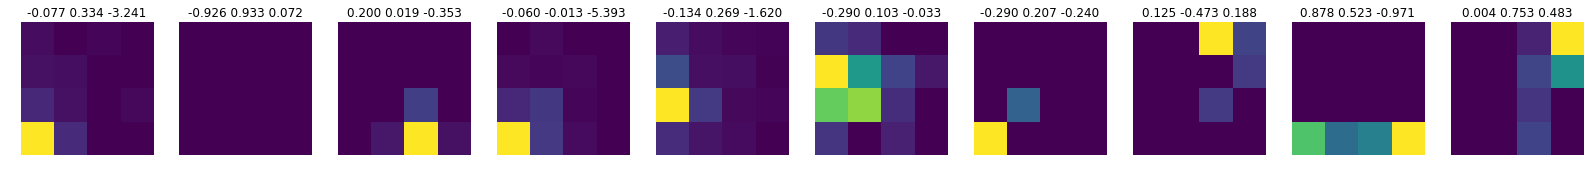

Train loss: 0.46694381164880633 Batch 2000 of 500           epoch: 216
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3669) tensor(1.6929e-08, grad_fn=<SumBackward0>) tensor(84.6575, grad_fn=<AbsBackward>) tensor(-191.7258, grad_fn=<SumBackward0>)


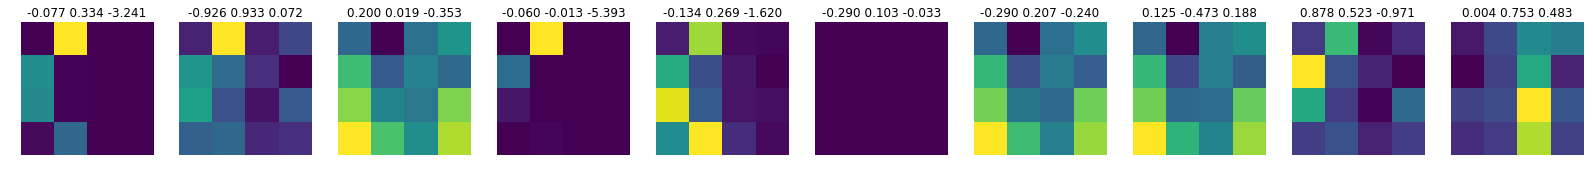

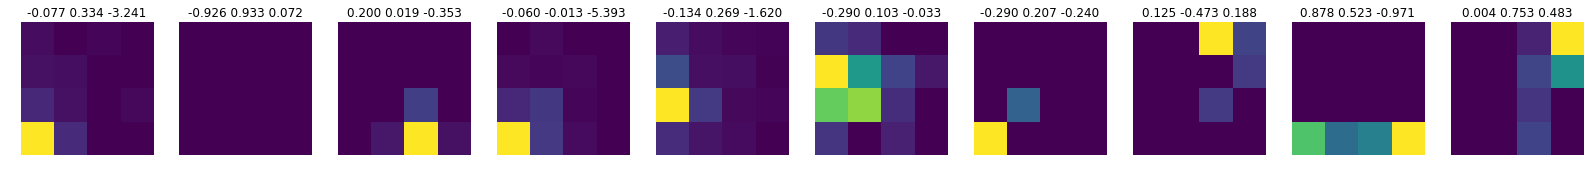

Train loss: 0.3672982925866913 Batch 2000 of 500           epoch: 217
a_gen shape torch.Size([10, 16])
alpha  1.0
batch_loss:loss_simple, KL, sum, res  tensor(0.3176) tensor(6.9353e-08, grad_fn=<SumBackward0>) tensor(49.7947, grad_fn=<AbsBackward>) tensor(-101.3424, grad_fn=<SumBackward0>)


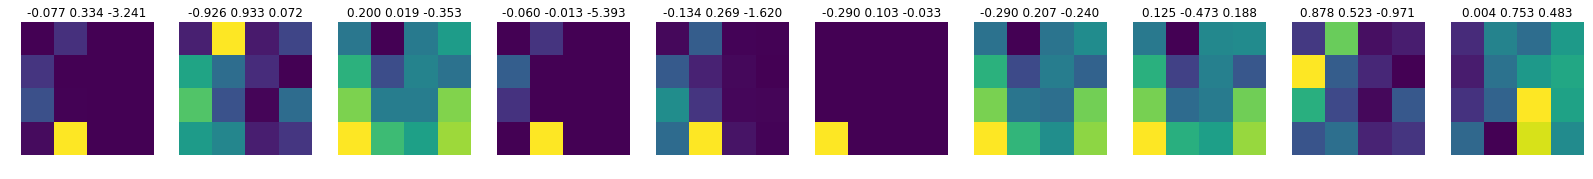

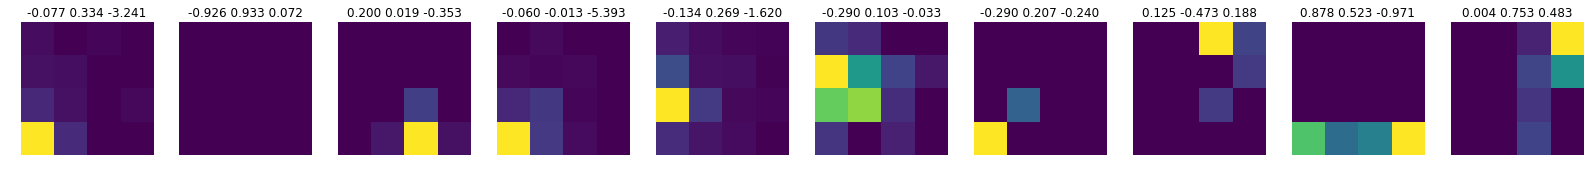

Train loss: 0.31737499757803633 Batch 2000 of 500           

In [ ]:
a = CVAE(1, 5, 16, 0.5)
vae_model_d2_k1 = train_model(a, tests=[])

**only rmse**

Print curves

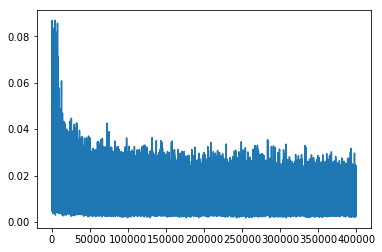

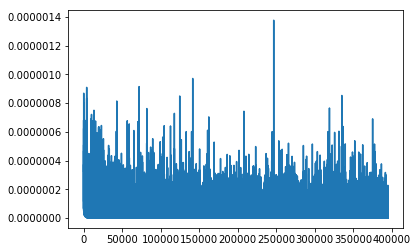

In [88]:
plt.plot(vae_model_d2_k1['train_losses_list1'][100:])
plt.show()
plt.plot(vae_model_d2_k1['train_losses_list2'][5000:])
plt.show()

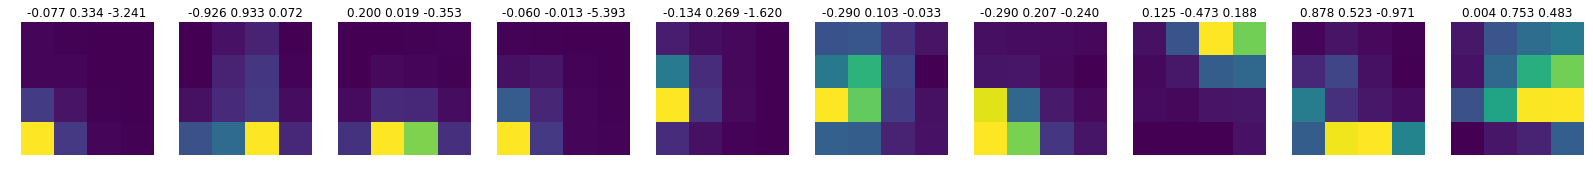

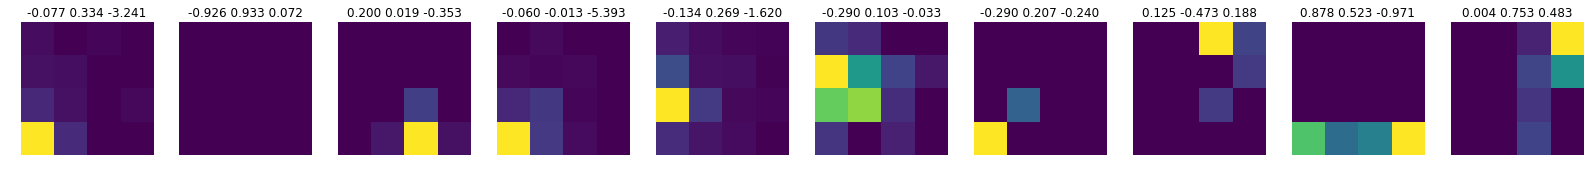

In [60]:
a_gen = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[20:30]).to(device)))
show_images(a_gen, Variable(torch.from_numpy(data_x[20:30])))
show_images(Variable(torch.from_numpy(n_cut_data[20:30])), Variable(torch.from_numpy(data_x[20:30])))

In [68]:
generated_images = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[0:100]).to(device))).cpu().detach().numpy()
print ("generated.shape", generated_images.shape)
for i in range(data_x.shape[0]):
    j = 100*(i+1)
    local_generated_images = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[j:j+100]).to(device)))
    print (type(generated_images))
    print (type(local_generated_images))
    generated_images = np.concatenate((generated_images, local_generated_images.cpu().detach().numpy()), axis=0)
    if (i%100 == 0):
        print (i)
        print ("local_generated_images.shape",local_generated_images.shape)

generated.shape (100, 16)
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
0
local_generated_images.shape torch.Size([100, 16])
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<cla

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>


RuntimeError: cannot unsqueeze empty tensor

In [69]:
generated_images.shape

(29600, 16)

In [72]:
print (np.max(n_generated_images), np.min(n_generated_images))

3371.953567922453 0.0


In [71]:
n_generated_images = []

min_ = np.min(generated_images)
max_ = np.max(generated_images)

for i, elem in enumerate(generated_images):
    if (i%5000 == 0):
        print (i)
    n_elem = (elem - min_)/(max_ - min_)*3371.953567922453
    n_generated_images.append(n_elem)
n_generated_images = np.array(n_generated_images)
print (n_generated_images.shape)

0
5000
10000
15000
20000
25000
(29600, 16)


In [74]:
data_point = data['ParticlePoint']
data_momentum = data['ParticleMomentum']
reshape_gen_im = n_generated_images.reshape((29600, 4, 4))

In [75]:
np.savez("rmse_4_4.npz", ParticlePoint=data_point, ParticleMomentum=data_momentum, EnergyDeposit = reshape_gen_im, flat = n_generated_images)

In [135]:
print (np.min(n_generated_images))
print (np.max(n_generated_images))

0.0
3371.953567922453


### C тюнингом

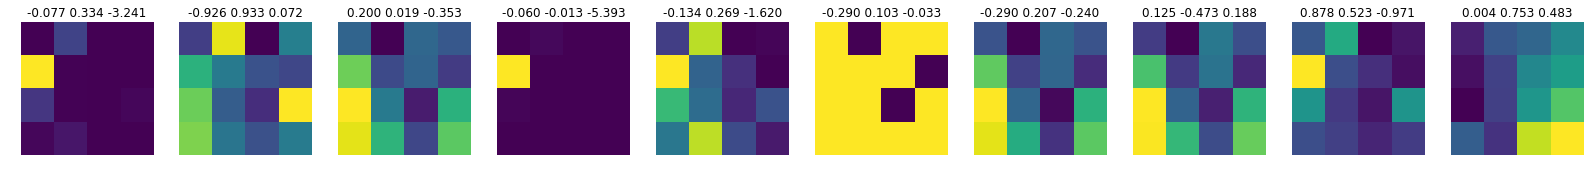

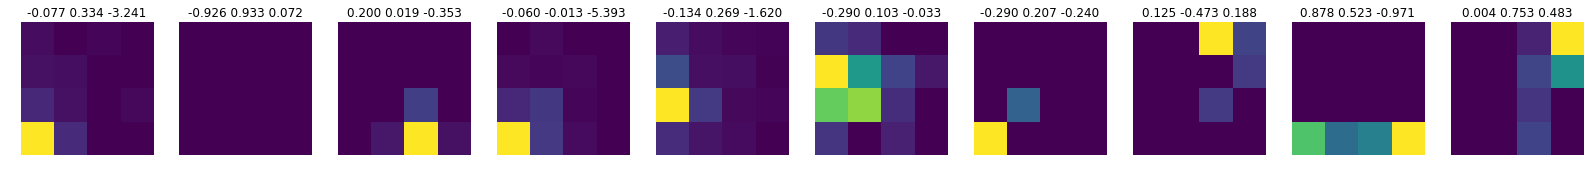

In [187]:
a_gen = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[20:30]).to(device)))
show_images(a_gen, Variable(torch.from_numpy(data_x[20:30])))
show_images(Variable(torch.from_numpy(n_cut_data[20:30])), Variable(torch.from_numpy(data_x[20:30])))

In [188]:
generated_images = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[0:100]).to(device))).cpu().detach().numpy()
print ("generated.shape", generated_images.shape)
for i in range(data_x.shape[0]):
    j = 100*(i+1)
    local_generated_images = a.generate_samples(Variable(torch.cuda.DoubleTensor(data_x[j:j+100]).to(device)))
    print (type(generated_images))
    print (type(local_generated_images))
    generated_images = np.concatenate((generated_images, local_generated_images.cpu().detach().numpy()), axis=0)
    if (i%100 == 0):
        print (i)
        print ("local_generated_images.shape",local_generated_images.shape)

generated.shape (100, 16)
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
0
local_generated_images.shape torch.Size([100, 16])
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<cla

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
200
local_generated_images.shape torch.Size([100, 16])
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<clas

RuntimeError: cannot unsqueeze empty tensor

In [189]:
n_generated_images = []

min_ = np.min(generated_images)
max_ = np.max(generated_images)

for i, elem in enumerate(generated_images):
    if (i%5000 == 0):
        print (i)
    n_elem = (elem - min_)/(max_ - min_)*3371.953567922453
    n_generated_images.append(n_elem)
n_generated_images = np.array(n_generated_images)
print (n_generated_images.shape)

0
5000
10000
15000
20000
25000
(29600, 16)


In [190]:
data_point = data['ParticlePoint']
data_momentum = data['ParticleMomentum']
reshape_gen_im = n_generated_images.reshape((29600, 4, 4))

In [191]:
np.savez("rmse_4_4_metrics.npz", ParticlePoint=data_point, ParticleMomentum=data_momentum, EnergyDeposit = reshape_gen_im, flat = n_generated_images)